# SPRUCE 3-channel whammy bender

The idea here is to provide a smooth and effective sample map to encode [3x slowly-changing SPRUCE voltage signals](https://github.com/spacebox1947/Spruce-Voltmeter)<br>
into a 3x separate, but continuous glissandos. <br><br>
We may utilize samples which have a loopable $\infty$ property, <br>
or alternatively, samples which have a granular property $\equiv$ multi-scale loopable breaks. 

---

Another approach is to use one channel as the glissando, and use the remaining two channels to control the signal in the spatial field.



# $\infty$
<br>

Constraints:
>Bitwig can only bend by ±35 half-steps:
>>Given center at MIDI 80 (830.6 Hz) that means a range of 110.0 to 6271.9 Hz. <br>
>To keep pitch-centeredness, we 

Keep in mind:
> `pretty_midi.note_number_to_hz(note_number)` <br>
> `pretty_midi.hz_to_note_number(frequency)` <br>
> `pretty_midi.note_name_to_number(note_name)` <br>
> ` pretty_midi.note_number_to_name(note_number)` <br>


In [5]:
import os
import struct
import wave
import sys
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# audio libraries
import crepe
from midiutil import MIDIFile
import pretty_midi
from scipy.special import comb
from scipy.io import wavfile
from scipy import signal

# specialized technical libraries
import skimage.measure
from scipy import ndimage
from scipy.interpolate import interp1d
import bezier
import networkx as nx
from tqdm import tqdm

# ========= global constants ======================


# ========= functions =============================

def parse_SPRUCE(meas, start_time, tree):
    
    '''
    Load a raw .CSV file
    '''
    
    SPRUCE = pd.read_csv(meas, header=None) # read in the raw .CSV file
    SPRUCE.columns = ["ch1", "ch2", "ch3", "loop length (ms)"] # give the columns meaningful names
    SPRUCE = SPRUCE.replace(' NULL', np.NaN) # convert 'NULL' strings to numeric NaN
    SPRUCE["loop length (ms)"] = SPRUCE["loop length (ms)"].str[:-1] # strip trailing semicolon
    SPRUCE = SPRUCE.astype('float') # cooerce to floating point numbers

    # a meaningful datetime index
    SPRUCE.index = start_time + (SPRUCE["loop length (ms)"].cumsum()/1000).apply(lambda t: dt.timedelta(seconds=t))
    
    SPRUCE.name = tree

    return SPRUCE

def startPipes() :
    
    global tofile
    global fromfile
    global EOL
    if( sys.platform  == 'win32' ):
        print( "pipe-test.py, running on windows" )
        toname = '\\\\.\\pipe\\ToSrvPipe'
        fromname = '\\\\.\\pipe\\FromSrvPipe'
        EOL = '\r\n\0'
    else:
        print( "pipe-test.py, running on linux or mac" )
        toname = '/tmp/audacity_script_pipe.to.' + str(os.getuid())
        fromname = '/tmp/audacity_script_pipe.from.' + str(os.getuid())
        EOL = '\n'

    print( "Write to  \"" + toname +"\"" )
    if not os.path.exists( toname ) :
        print( " ..does not exist.  Ensure Audacity is running with mod-script-pipe." )
        sys.exit();
        
    print( "Read from \"" + fromname +"\"")
    if not os.path.exists( fromname ) :
        print( " ..does not exist.  Ensure Audacity is running with mod-script-pipe." )
        sys.exit();

    print( "-- Both pipes exist.  Good." )

    tofile = open( toname, 'wt' )
    print( "-- File to write to has been opened" )
    fromfile = open( fromname, 'rt')
    print( "-- File to read from has now been opened too\r\n" )


def sendCommand( command ) :
    global tofile
    global EOL
    print( "Send: >>> \n"+command )
    tofile.write( command + EOL )	
    tofile.flush()

def getResponse() :
    """Return the command response."""
    global fromfile
    result = ''
    line = ''
    while True:
        result += line
        line = fromfile.readline()
        if line == '\n' and len(result) > 0:
            break
    return result

def doCommand( command ) :
    sendCommand( command )
    response = getResponse()
    print( "Rcvd: <<< \n" + response )
    return response

def do( command ) :
    doCommand( command )

def select(start, end):
    
    do("SelectTracks: Track=0")
    do(f'SelectTime: Start={start:.4f} End={end:.4f}')


def risset_drum_gen(freq, decay, cfreq, bwidth, noise, gain):

    do(f'RissetDrum: Freq={freq:.1f} Decay={decay:.2f} Cf={cfreq:.1f} Bw={bwidth:.1f} Noise={noise:.1f} Gain={gain:.3f}')
    

def iterate(freq, decay, cfreq, bwidth, noise, gain, depth=2):
    
    phi = (1 + np.sqrt(5))/2
    max_f = 8000
    
    for i in np.arange(depth):
        
        freq = (freq*phi)%max_f
        decay = decay/phi
        cfreq = (cfreq*phi)%max_f
        bwidth = bwidth*phi
        noise = noise/phi
        gain = gain/phi
        
    
    params_out = {"freq":freq, "decay":decay, 
                  "cfreq":cfreq, "bwidth":bwidth, 
                  "noise":noise, "gain":gain}

    return params_out

def signal_to_wav(signal, fname, Fs):
    
    """Convert a numpy array into a wav file.

     Args
     ----
     signal : 1-D numpy array
         An array containing the audio signal.
     fname : str
         Name of the audio file where the signal will be saved.
     Fs: int
        Sampling rate of the signal.

    """
    data = struct.pack('<' + ('h'*len(signal)), *signal)
    wav_file = wave.open(fname, 'wb')
    wav_file.setnchannels(1)
    wav_file.setsampwidth(2)
    wav_file.setframerate(Fs)
    wav_file.writeframes(data)
    wav_file.close()
    
    print("complete.")

def gold(f, degree=1):

    phi = (1 + np.power(5, 0.5))/2
    
    if(degree == 0):
        
        return f
    
    else:
    
        return degree*phi*f
        
    
def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """

    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i


def bezier_curve(points, nTimes=1000):
    
    """
       Given a set of control points, return the
       bezier curve defined by the control points.

       points should be a list of lists, or list of tuples
       such as [ [1,1], 
                 [2,3], 
                 [4,5], ..[Xn, Yn] ]
        nTimes is the number of time steps, defaults to 1000

        See http://processingjs.nihongoresources.com/bezierinfo/
    """

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)   ])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals

def pitchbend_map(center_MIDI, ascending=True):

    f_lower = pretty_midi.note_number_to_hz(center_MIDI-24)
    f_upper = pretty_midi.note_number_to_hz(center_MIDI+24)

    golden_fs = np.array([gold(f_lower, i) for i in np.arange(0, 30)])
    golden_fs = golden_fs[golden_fs < f_upper]

    if(ascending):
        frequency_to_bend = interp1d([f_lower, f_upper],[8191, 0])
    else:
        frequency_to_bend = interp1d([f_lower, f_upper],[0, 8191])
    
    return frequency_to_bend

def make_curve(row, center_MIDI=80):

    t_e = row["OriginalEnds"]
    t_b = row["OriginalBegins"]
    p_b = row["PitchBegins"]
    
    if(center_MIDI < 80):
    
        f_lower = pretty_midi.note_number_to_hz(center_MIDI)
        f_upper = pretty_midi.note_number_to_hz(center_MIDI+48)
        
    else:
        
        f_lower = pretty_midi.note_number_to_hz(center_MIDI-24)
        f_upper = pretty_midi.note_number_to_hz(center_MIDI+24)
        

    golden_fs = np.array([gold(f_lower, i) for i in np.arange(0, 30)])
    golden_fs = golden_fs[golden_fs < f_upper]

    # this is a generic bezier shape
    generic_pattern = np.array([1.0, 0.95, 0.85, 0.6, 0.28, 0.1, 0.0])
    generic_to_specific = interp1d([0.0, 1.0],[golden_fs[0], p_b])

    # bezier node times
    node_times = np.linspace(t_b, t_e, generic_pattern.shape[0])

    # bezier node pitches
    node_pitches = generic_to_specific(generic_pattern)

    # define the bezier nodes, then the curve
    nodes = np.asfortranarray([node_times, node_pitches])
    curve = bezier.Curve.from_nodes(nodes)

    return curve

def generate_start_times(audioPath, step_size_ms=200):

    # read the audio
    meta, samples = wavfile.read(audioPath)

    # if stereo, use the L channel only
    if(len(samples.shape) > 1):
        samples = samples[:, 0]

    # perform a short-time Fourier transform on the data
    frequencies, times, Zxx = signal.stft(samples, meta, nperseg=2048)

    # make a spectrogram by taking the logarithm of the real component
    spectrogram = np.log(np.abs(Zxx))

    # perform pitch detection
    time, frequency, confidence, activation = crepe.predict(samples, meta, viterbi=False, 
                                                            step_size=step_size_ms, verbose=False)

    pitch_detect = pd.DataFrame([time, frequency, confidence, activation], 
                                index=["Time", "Frequency", "Confidence", "Activation"]).T

    return pitch_detect


def min_groupings(df):
    
    '''
    Utilize an adjacency matrix and graph coloring to find the minimum number
    of resources necessary for non-overlapping assignment.
    
    Inputs
    ------
    
    df (pandas DataFrame): must contain Series "TimeInterval" containing pd.Interval objects
    
    Returns
    -------
    
    groups (pandas Series): a grouping of the rows for easy assignment into the original frame
    
    '''

    # create an `pandas` Interval array
    Ia = pd.arrays.IntervalArray([I for I in df["TimeInterval"]])

    # for every Interval, check it's overlap with every other interval
    adjacency = np.array([Ia.overlaps(I) for I in df["TimeInterval"]])

    plt.imshow(adjacency)
    plt.show()

    # some colors for checking groups
    colors = {0:"green", 2:"red", 3:"magenta", 4:"orange", 5:"indigo", 6:"lime", 
              7:"brown", 8:"pink", 9:"skyblue", 10:"cyan", 11:"teal", 12:"gray", 
              13:"yellow", 14:"navy", 15:"beige", 16:"darkgreen", 1:"blue",
              17:"cornsilk",18:"coral",19:"slategray",20:"lavenderblush",
              21:"darkkhaki",22:"springgreen",23:"mediumorchid",24:"black",
              25:"black",26:"black"}


    # create a graph from the adjacency matrix
    G = nx.convert_matrix.from_numpy_matrix(adjacency)

    # color it... creating non-overlapping groups of notes
    d = nx.coloring.greedy_color(G, strategy="largest_first")

    # organize the groups
    color_lookup = pd.DataFrame.from_dict(d, orient="index", columns=["Group"])
    color_lookup = color_lookup.sort_index()
    color_lookup["Color"] = color_lookup["Group"].apply(lambda c: colors[c])

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    nx.draw_networkx(G, ax=ax, node_color=color_lookup["Color"])
    plt.show()

    print("Assignments to a minimum of",color_lookup["Group"].max(),"channels are as follows.")

    plt.figure(figsize=(14, 4))
    for j, I in enumerate(Ia.to_tuples()):
        plt.plot(I, (j,j), color=color_lookup.iloc[j,:]["Color"], lw=7)

    plt.title("Efficient Allocation of Resources", loc="left")
    plt.show()
    
    # return just the series containing the groupings
    groups = color_lookup["Group"]
    
    return groups

def select(track_num, start, end):
    
    t = int(track_num)
    do(f'SelectTracks: Track={t}')
    do(f'SelectTime: Start={start:.4f} End={end:.4f}')
    
    
def noise_percentage(f, f_cycle):
    if(f > f_cycle):
        return 100*f_cycle/f
    elif(f_cycle > f):
        return 100*f/f_cycle
    elif(f == f_cycle):
        return 100
    

### Load a tree

In [2]:
# meas = '/home/dax/Documents/ALBUM/Spruce/Field Testing/Measurements/2022 06 13/00000.CSV'
# meas = '/home/dax/Documents/ALBUM/SPRUCE/Field Testing/Measurements/2022 06 18/Brushkana_001/00000.CSV'
# meas = '/home/dax/Documents/ALBUM/SPRUCE/Field Testing/Measurements/2022 06 18/Brushkana_003/00000.CSV'
# meas = '/home/dax/Documents/ALBUM/SPRUCE/Field Measurements/2022 06 18/Brushkana_003/10000.CSV'
# meas = '/home/dax/Documents/ALBUM/SPRUCE/Field Measurements/2022 06 19/BlueHome_002/10000.CSV'
meas = "/home/dax/Documents/ALBUM/SPRUCE/Field Measurements/2022 07 12/DenaliHQ_001/11100.CSV"

start_time = dt.datetime(2022, 7, 12, 7, 44)
tree = "Denali HQ 001"


S = parse_SPRUCE(meas, start_time, tree)
S

,ch1,ch2,ch3,loop length (ms)
loop length (ms),,,,
2022-07-12 07:44:00.222,-0.0101,0.0016,0.0220,222.0
2022-07-12 07:44:00.395,0.0080,-0.0003,0.0116,173.0
2022-07-12 07:44:00.570,0.0441,0.0021,0.0010,175.0
2022-07-12 07:44:00.743,0.0015,0.0033,-0.0016,173.0
2022-07-12 07:44:00.917,-0.0093,0.0013,0.0080,174.0
...,...,...,...,...
2022-07-12 17:39:33.335,0.0358,-0.0106,-0.1306,179.0
2022-07-12 17:39:33.514,0.0353,-0.0107,-0.1321,179.0
2022-07-12 17:39:33.695,0.0366,-0.0108,-0.1306,181.0


You know Bitwig can go ±35 half-steps. <br>
With a center pitch and step limits, you know it's frequency limits, too.<br>
You know `pretty_midi` can supply bends from ±8191 (int). <br>
Generate scale values in frequency within Bitwig's limits. <br>
Then you can map these onto bend values. <br>

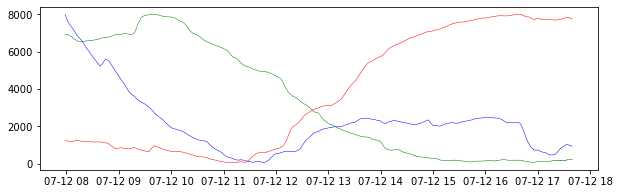

,ch1,ch2,ch3,ch1_f,ch2_f,ch3_f
loop length (ms),,,,,,
2022-07-12 07:58:28.637,-0.072403,0.040293,0.015368,1232.088176,6896.273582,8000.000000
2022-07-12 07:58:28.821,-0.072403,0.040293,0.015359,1232.088176,6896.193236,7999.565851
2022-07-12 07:58:29.008,-0.072402,0.040294,0.015348,1232.138142,6896.300364,7999.012620
2022-07-12 07:58:29.191,-0.072401,0.040294,0.015338,1232.196926,6896.313755,7998.491641
2022-07-12 07:58:29.375,-0.072400,0.040293,0.015326,1232.238075,6896.286973,7997.930968
...,...,...,...,...,...,...
2022-07-12 17:39:33.335,0.038679,-0.009426,-0.126928,7761.925173,238.382056,939.695312
2022-07-12 17:39:33.514,0.038678,-0.009426,-0.126931,7761.854632,238.375361,939.563827
2022-07-12 17:39:33.695,0.038677,-0.009426,-0.126932,7761.795848,238.355274,939.479478


In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

burn_in = 500 # seconds
frame = 2000
transfer_start = S.index.min() + dt.timedelta(seconds=burn_in)

record = S.loc[transfer_start:, "ch1":"ch3"].rolling(window=frame).mean().iloc[frame-1:].copy()

for channel, color in zip(record, ["red","green","blue"]):

    ch = int(channel[2:])
    channel_map = interp1d([record[channel].min(), record[channel].max()],[80, 8000])
    channel_bends = channel_map(record[channel]) #.astype('int')
    
    record.loc[:, channel+"_f"] = channel_bends

    ax.plot(record[channel].index, channel_bends, lw=0.5, color=color)
    
plt.show()  


record

In [129]:

    
    
noise_percentage(500, 500)

100

In [6]:
# basically... check that the `mod-script-pipe` files are there
startPipes()

step = 300 # rows
progBar = tqdm(record[::step], unit="rows")
cycle = {0:1, 1:2, 2:0}

for start_time, row in record[::step].iterrows():
    
    for ch_num in np.arange(1,4):
        
        begin = (start_time - record.index.min()).total_seconds()/900
        select(ch_num-1, (1+(ch_num/5))*begin, ((1+(ch_num/5))*begin)+0.07)
        
        f = row["ch"+str(ch_num)+"_f"]
        f_cycle = row["ch"+str(((ch_num+1)%3)+1)+"_f"]
        
        print(f, f_cycle)
        
        # freq, decay, cfreq, bwidth, noise, gain
        risset_drum_gen(f, 0.1*ch_num, f_cycle, gold(f_cycle, degree=ch_num*2), noise_percentage(f, f_cycle), 0.1)
    
    # 3 channels per row
    progBar.update(1)
#     

pipe-test.py, running on linux or mac
Write to  "/tmp/audacity_script_pipe.to.1000"
Read from "/tmp/audacity_script_pipe.from.1000"
-- Both pipes exist.  Good.
-- File to write to has been opened
-- File to read from has now been opened too




  0%|                                                           | 0/629 [00:16<?, ?rows/s]

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.0000 End=0.0700
Rcvd: <<< 

BatchCommand finished: OK

1232.0881758618568 8000.0
Send: >>> 
RissetDrum: Freq=1232.1 Decay=0.10 Cf=8000.0 Bw=25888.5 Noise=15.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.0000 End=0.0700


Rcvd: <<< 

BatchCommand finished: OK

6896.273582194027 1232.0881758618568
Send: >>> 
RissetDrum: Freq=6896.3 Decay=0.20 Cf=1232.1 Bw=7974.2 Noise=17.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.0000 End=0.0700



  0%|                                                   | 1/629 [00:00<06:57,  1.50rows/s]

Rcvd: <<< 

BatchCommand finished: OK

8000.0 6896.273582194027
Send: >>> 
RissetDrum: Freq=8000.0 Decay=0.30 Cf=6896.3 Bw=66950.4 Noise=86.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.0738 End=0.1438
Rcvd: <<< 

BatchCommand finished: OK

1235.4711897618026 7858.747613509254
Send: >>> 
RissetDrum: Freq=1235.5 Decay=0.10 Cf=7858.7 Bw=25431.4 Noise=15.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.0861 End=0.1561



  0%|▏                                                  | 2/629 [00:01<06:31,  1.60rows/s]

Rcvd: <<< 

BatchCommand finished: OK

6897.585900223522 1235.4711897618026
Send: >>> 
RissetDrum: Freq=6897.6 Decay=0.20 Cf=1235.5 Bw=7996.1 Noise=17.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.0984 End=0.1684
Rcvd: <<< 

BatchCommand finished: OK

7858.747613509254 6897.585900223522
Send: >>> 
RissetDrum: Freq=7858.7 Decay=0.30 Cf=6897.6 Bw=66963.2 Noise=87.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.1474 End=0.2174
Rcvd: <<< 

BatchCommand finished: OK

1235.5240952789172 7745.898524925536
Send: >>> 
RissetDrum: Freq=1235.5 Decay=0.10 Cf=7745.9 Bw=25066.3 Noise=16.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.1720 End=0.2420
Rcvd: <<< 

BatchCommand finished


  0%|▏                                                  | 3/629 [00:01<06:40,  1.56rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.2211 End=0.2911
Rcvd: <<< 

BatchCommand finished: OK

1228.3524585144817 7652.186744408447
Send: >>> 
RissetDrum: Freq=1228.4 Decay=0.10 Cf=7652.2 Bw=24763.0 Noise=16.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.2580 End=0.3280
Rcvd: <<< 

BatchCommand finished: OK

6899.494117766408 1228.3524585144817
Send: >>> 
RissetDrum: Freq=6899.5 Decay=0.20 Cf=1228.4 Bw=7950.1 Noise=17.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.2948 End=0.3648
Rcvd: <<< 

BatchCommand finished: OK

7652.186744408447 6899.494117766408
Send: >>> 
RissetDrum: Freq=7652.2 Decay=0.30 Cf=6899.5 Bw=66981.7 Noise=90.2 Gain=0.100



  1%|▎                                                  | 4/629 [00:02<07:07,  1.46rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.2950 End=0.3650
Rcvd: <<< 

BatchCommand finished: OK

1220.807543934848 7569.723156109934
Send: >>> 
RissetDrum: Freq=1220.8 Decay=0.10 Cf=7569.7 Bw=24496.1 Noise=16.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.3441 End=0.4141
Rcvd: <<< 

BatchCommand finished: OK

6890.729708069431 1220.807543934848
Send: >>> 
RissetDrum: Freq=6890.7 Decay=0.20 Cf=1220.8 Bw=7901.2 Noise=17.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



  1%|▍                                                  | 5/629 [00:03<06:34,  1.58rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.3933 End=0.4633
Rcvd: <<< 

BatchCommand finished: OK

7569.723156109934 6890.729708069431
Send: >>> 
RissetDrum: Freq=7569.7 Decay=0.30 Cf=6890.7 Bw=66896.6 Noise=91.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.3686 End=0.4386
Rcvd: <<< 

BatchCommand finished: OK

1213.5506705039497 7493.097017368172
Send: >>> 
RissetDrum: Freq=1213.6 Decay=0.10 Cf=7493.1 Bw=24248.2 Noise=16.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.4301 End=0.5001
Rcvd: <<< 

BatchCommand finished: OK

6873.749919687813 1213.5506705039497
Send: >>> 
RissetDrum: Freq=6873.7 Decay=0.20 Cf=1213.6 Bw=7854.3 Noise=17.7 Gain=0.100



  1%|▍                                                  | 6/629 [00:03<06:45,  1.54rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.4915 End=0.5615
Rcvd: <<< 

BatchCommand finished: OK

7493.097017368172 6873.749919687813
Send: >>> 
RissetDrum: Freq=7493.1 Decay=0.30 Cf=6873.7 Bw=66731.8 Noise=91.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.4423 End=0.5123
Rcvd: <<< 

BatchCommand finished: OK

1203.5162574245296 7423.8811896446905
Send: >>> 
RissetDrum: Freq=1203.5 Decay=0.10 Cf=7423.9 Bw=24024.2 Noise=16.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.5161 End=0.5861
Rcvd: <<< 

BatchCommand finished: OK

6849.01004663179 1203.5162574245296
Send: >>> 
RissetDrum: Freq=6849.0 Decay=0.20 Cf=1203.5 Bw=7789.3 Noise=17.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished


  1%|▌                                                  | 7/629 [00:04<06:28,  1.60rows/s]

Rcvd: <<< 

BatchCommand finished: OK

7423.8811896446905 6849.01004663179
Send: >>> 
RissetDrum: Freq=7423.9 Decay=0.30 Cf=6849.0 Bw=66491.6 Noise=92.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.5161 End=0.5861
Rcvd: <<< 

BatchCommand finished: OK

1190.8277509031898 7365.543906887785
Send: >>> 
RissetDrum: Freq=1190.8 Decay=0.10 Cf=7365.5 Bw=23835.4 Noise=16.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.6021 End=0.6721
Rcvd: <<< 

BatchCommand finished: OK

6817.480936423181 1190.8277509031898
Send: >>> 
RissetDrum: Freq=6817.5 Decay=0.20 Cf=1190.8 Bw=7707.2 Noise=17.5 Gain=0.100



  1%|▋                                                  | 8/629 [00:05<06:33,  1.58rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.6881 End=0.7581
Rcvd: <<< 

BatchCommand finished: OK

7365.543906887785 6817.480936423181
Send: >>> 
RissetDrum: Freq=7365.5 Decay=0.30 Cf=6817.5 Bw=66185.5 Noise=92.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.5900 End=0.6600
Rcvd: <<< 

BatchCommand finished: OK

1185.6459494213457 7318.727710293885
Send: >>> 
RissetDrum: Freq=1185.6 Decay=0.10 Cf=7318.7 Bw=23683.9 Noise=16.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.6883 End=0.7583
Rcvd: <<< 

BatchCommand finished: OK

6795.874557437585 1185.6459494213457
Send: >>> 
RissetDrum: Freq=6795.9 Decay=0.20 Cf=1185.6 Bw=7673.7 Noise=17.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished


  1%|▋                                                  | 9/629 [00:05<07:08,  1.45rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.6639 End=0.7339
Rcvd: <<< 

BatchCommand finished: OK

1196.2064784765168 7267.287201768925
Send: >>> 
RissetDrum: Freq=1196.2 Decay=0.10 Cf=7267.3 Bw=23517.4 Noise=16.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.7745 End=0.8445
Rcvd: <<< 

BatchCommand finished: OK

6764.974824243121 1196.2064784765168
Send: >>> 
RissetDrum: Freq=6765.0 Decay=0.20 Cf=1196.2 Bw=7742.0 Noise=17.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



  2%|▊                                                 | 10/629 [00:06<06:50,  1.51rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.8852 End=0.9552
Rcvd: <<< 

BatchCommand finished: OK

7267.287201768925 6764.974824243121
Send: >>> 
RissetDrum: Freq=7267.3 Decay=0.30 Cf=6765.0 Bw=65675.8 Noise=93.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.7377 End=0.8077
Rcvd: <<< 

BatchCommand finished: OK

1208.765660400465 7205.566034101094
Send: >>> 
RissetDrum: Freq=1208.8 Decay=0.10 Cf=7205.6 Bw=23317.7 Noise=16.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.8607 End=0.9307
Rcvd: <<< 

BatchCommand finished: OK

6732.602081015552 1208.765660400465
Send: >>> 
RissetDrum: Freq=6732.6 Decay=0.20 Cf=1208.8 Bw=7823.3 Noise=18.0 Gain=0.100



  2%|▊                                                 | 11/629 [00:07<06:50,  1.51rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.9837 End=1.0537
Rcvd: <<< 

BatchCommand finished: OK

7205.566034101094 6732.602081015552
Send: >>> 
RissetDrum: Freq=7205.6 Decay=0.30 Cf=6732.6 Bw=65361.5 Noise=93.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.8117 End=0.8817
Rcvd: <<< 

BatchCommand finished: OK

1221.7804176106786 7135.543928814525
Send: >>> 
RissetDrum: Freq=1221.8 Decay=0.10 Cf=7135.5 Bw=23091.1 Noise=17.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.9469 End=1.0169
Rcvd: <<< 

BatchCommand finished: OK

6692.4826441138775 1221.7804176106786
Send: >>> 
RissetDrum: Freq=6692.5 Decay=0.20 Cf=1221.8 Bw=7907.5 Noise=18.3 Gain=0.100



  2%|▉                                                 | 12/629 [00:07<06:45,  1.52rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.0822 End=1.1522
Rcvd: <<< 

BatchCommand finished: OK

7135.543928814525 6692.4826441138775
Send: >>> 
RissetDrum: Freq=7135.5 Decay=0.30 Cf=6692.5 Bw=64972.0 Noise=93.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.8855 End=0.9555
Rcvd: <<< 

BatchCommand finished: OK

1238.6837303288219 7065.697964164816
Send: >>> 
RissetDrum: Freq=1238.7 Decay=0.10 Cf=7065.7 Bw=22865.1 Noise=17.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.0330 End=1.1030
Rcvd: <<< 

BatchCommand finished: OK

6657.91377683695 1238.6837303288219
Send: >>> 
RissetDrum: Freq=6657.9 Decay=0.20 Cf=1238.7 Bw=8016.9 Noise=18.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished


  2%|█                                                 | 13/629 [00:08<06:35,  1.56rows/s]

Rcvd: <<< 

BatchCommand finished: OK

7065.697964164816 6657.91377683695
Send: >>> 
RissetDrum: Freq=7065.7 Decay=0.30 Cf=6657.9 Bw=64636.4 Noise=94.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=0.9593 End=1.0293
Rcvd: <<< 

BatchCommand finished: OK

1251.2164594942126 6997.591078197334
Send: >>> 
RissetDrum: Freq=1251.2 Decay=0.10 Cf=6997.6 Bw=22644.7 Noise=17.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.1192 End=1.1892
Rcvd: <<< 

BatchCommand finished: OK

6630.12745121246 1251.2164594942126
Send: >>> 
RissetDrum: Freq=6630.1 Decay=0.20 Cf=1251.2 Bw=8098.0 Noise=18.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



  2%|█                                                 | 14/629 [00:09<06:35,  1.55rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.2790 End=1.3490
Rcvd: <<< 

BatchCommand finished: OK

6997.591078197334 6630.12745121246
Send: >>> 
RissetDrum: Freq=6997.6 Decay=0.30 Cf=6630.1 Bw=64366.6 Noise=94.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.0331 End=1.1031
Rcvd: <<< 

BatchCommand finished: OK

1262.8615516502352 6929.727315925798
Send: >>> 
RissetDrum: Freq=1262.9 Decay=0.10 Cf=6929.7 Bw=22425.1 Noise=18.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



  2%|█▏                                                | 15/629 [00:09<07:02,  1.45rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.2053 End=1.2753
Rcvd: <<< 

BatchCommand finished: OK

6599.810226531088 1262.8615516502352
Send: >>> 
RissetDrum: Freq=6599.8 Decay=0.20 Cf=1262.9 Bw=8173.4 Noise=19.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.3774 End=1.4474
Rcvd: <<< 

BatchCommand finished: OK

6929.727315925798 6599.810226531088
Send: >>> 
RissetDrum: Freq=6929.7 Decay=0.30 Cf=6599.8 Bw=64072.3 Noise=95.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.1070 End=1.1770
Rcvd: <<< 

BatchCommand finished: OK

1263.9931418774113 6860.900982286639
Send: >>> 
RissetDrum: Freq=1264.0 Decay=0.10 Cf=6860.9 Bw=22202.3 Noise=18.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



  3%|█▎                                                | 16/629 [00:10<06:53,  1.48rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.2915 End=1.3615
Rcvd: <<< 

BatchCommand finished: OK

6567.477656304422 1263.9931418774113
Send: >>> 
RissetDrum: Freq=6567.5 Decay=0.20 Cf=1264.0 Bw=8180.7 Noise=19.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.4760 End=1.5460
Rcvd: <<< 

BatchCommand finished: OK

6860.900982286639 6567.477656304422
Send: >>> 
RissetDrum: Freq=6860.9 Decay=0.30 Cf=6567.5 Bw=63758.4 Noise=95.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.1808 End=1.2508
Rcvd: <<< 

BatchCommand finished: OK

1254.8169738534066 6805.101613212928
Send: >>> 
RissetDrum: Freq=1254.8 Decay=0.10 Cf=6805.1 Bw=22021.8 Noise=18.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished


  3%|█▎                                                | 17/629 [00:11<06:30,  1.57rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.5744 End=1.6444
Rcvd: <<< 

BatchCommand finished: OK

6805.101613212928 6551.2276774392085
Send: >>> 
RissetDrum: Freq=6805.1 Decay=0.30 Cf=6551.2 Bw=63600.7 Noise=96.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.2547 End=1.3247
Rcvd: <<< 

BatchCommand finished: OK

1245.464454105687 6759.352183856345
Send: >>> 
RissetDrum: Freq=1245.5 Decay=0.10 Cf=6759.4 Bw=21873.7 Noise=18.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.4638 End=1.5338
Rcvd: <<< 

BatchCommand finished: OK

6544.103665279097 1245.464454105687
Send: >>> 
RissetDrum: Freq=6544.1 Decay=0.20 Cf=1245.5 Bw=8060.8 Noise=19.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



  3%|█▍                                                | 18/629 [00:11<06:32,  1.56rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.6730 End=1.7430
Rcvd: <<< 

BatchCommand finished: OK

6759.352183856345 6544.103665279097
Send: >>> 
RissetDrum: Freq=6759.4 Decay=0.30 Cf=6544.1 Bw=63531.5 Noise=96.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.3287 End=1.3987
Rcvd: <<< 

BatchCommand finished: OK

1231.494458392015 6715.250041582498
Send: >>> 
RissetDrum: Freq=1231.5 Decay=0.10 Cf=6715.3 Bw=21731.0 Noise=18.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.5502 End=1.6202
Rcvd: <<< 

BatchCommand finished: OK

6536.410535606196 1231.494458392015
Send: >>> 
RissetDrum: Freq=6536.4 Decay=0.20 Cf=1231.5 Bw=7970.4 Noise=18.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



  3%|█▌                                                | 19/629 [00:12<06:20,  1.60rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.7716 End=1.8416
Rcvd: <<< 

BatchCommand finished: OK

6715.250041582498 6536.410535606196
Send: >>> 
RissetDrum: Freq=6715.3 Decay=0.30 Cf=6536.4 Bw=63456.8 Noise=97.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.4026 End=1.4726
Rcvd: <<< 

BatchCommand finished: OK

1219.0851754332245 6670.100978903657
Send: >>> 
RissetDrum: Freq=1219.1 Decay=0.10 Cf=6670.1 Bw=21584.9 Noise=18.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.6363 End=1.7063
Rcvd: <<< 

BatchCommand finished: OK

6532.527145518919 1219.0851754332245
Send: >>> 
RissetDrum: Freq=6532.5 Decay=0.20 Cf=1219.1 Bw=7890.1 Noise=18.7 Gain=0.100



  3%|█▌                                                | 20/629 [00:12<06:16,  1.62rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.8701 End=1.9401
Rcvd: <<< 

BatchCommand finished: OK

6670.100978903657 6532.527145518919
Send: >>> 
RissetDrum: Freq=6670.1 Decay=0.30 Cf=6532.5 Bw=63419.1 Noise=97.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.4765 End=1.5465
Rcvd: <<< 

BatchCommand finished: OK

1216.4692915314427 6619.8363951937845
Send: >>> 
RissetDrum: Freq=1216.5 Decay=0.10 Cf=6619.8 Bw=21422.2 Noise=18.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.7226 End=1.7926
Rcvd: <<< 

BatchCommand finished: OK

6533.1364360326115 1216.4692915314427
Send: >>> 
RissetDrum: Freq=6533.1 Decay=0.20 Cf=1216.5 Bw=7873.2 Noise=18.6 Gain=0.100



  3%|█▋                                                | 21/629 [00:13<06:10,  1.64rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.9687 End=2.0387
Rcvd: <<< 

BatchCommand finished: OK

6619.8363951937845 6533.1364360326115
Send: >>> 
RissetDrum: Freq=6619.8 Decay=0.30 Cf=6533.1 Bw=63425.0 Noise=98.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.5504 End=1.6204
Rcvd: <<< 

BatchCommand finished: OK

1214.5558753291284 6561.181563119725
Send: >>> 
RissetDrum: Freq=1214.6 Decay=0.10 Cf=6561.2 Bw=21232.4 Noise=18.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.8088 End=1.8788
Rcvd: <<< 

BatchCommand finished: OK

6533.410951538782 1214.5558753291284
Send: >>> 
RissetDrum: Freq=6533.4 Decay=0.20 Cf=1214.6 Bw=7860.8 Noise=18.6 Gain=0.100
Rcvd: <<< 

BatchCommand finish


  3%|█▋                                                | 22/629 [00:14<06:03,  1.67rows/s]

Rcvd: <<< 

BatchCommand finished: OK

6561.181563119725 6533.410951538782
Send: >>> 
RissetDrum: Freq=6561.2 Decay=0.30 Cf=6533.4 Bw=63427.7 Noise=99.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.6243 End=1.6943
Rcvd: <<< 

BatchCommand finished: OK

1215.5111138325879 6499.145326988779
Send: >>> 
RissetDrum: Freq=1215.5 Decay=0.10 Cf=6499.1 Bw=21031.7 Noise=18.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.8950 End=1.9650
Rcvd: <<< 

BatchCommand finished: OK

6536.731919613419 1215.5111138325879
Send: >>> 
RissetDrum: Freq=6536.7 Decay=0.20 Cf=1215.5 Bw=7867.0 Noise=18.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



  4%|█▊                                                | 23/629 [00:14<05:58,  1.69rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.1657 End=2.2357
Rcvd: <<< 

BatchCommand finished: OK

6499.145326988779 6536.731919613419
Send: >>> 
RissetDrum: Freq=6499.1 Decay=0.30 Cf=6536.7 Bw=63459.9 Noise=99.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.6982 End=1.7682
Rcvd: <<< 

BatchCommand finished: OK

1214.7234094666574 6434.060121242344
Send: >>> 
RissetDrum: Freq=1214.7 Decay=0.10 Cf=6434.1 Bw=20821.1 Noise=18.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.9813 End=2.0513
Rcvd: <<< 

BatchCommand finished: OK

6544.110360779248 1214.7234094666574
Send: >>> 
RissetDrum: Freq=6544.1 Decay=0.20 Cf=1214.7 Bw=7861.9 Noise=18.6 Gain=0.100



  4%|█▉                                                | 24/629 [00:15<06:08,  1.64rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.2643 End=2.3343
Rcvd: <<< 

BatchCommand finished: OK

6434.060121242344 6544.110360779248
Send: >>> 
RissetDrum: Freq=6434.1 Decay=0.30 Cf=6544.1 Bw=63531.6 Noise=98.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.7722 End=1.8422
Rcvd: <<< 

BatchCommand finished: OK

1210.1265078684705 6363.283836327535
Send: >>> 
RissetDrum: Freq=1210.1 Decay=0.10 Cf=6363.3 Bw=20592.0 Noise=19.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.0675 End=2.1375
Rcvd: <<< 

BatchCommand finished: OK

6543.387246762996 1210.1265078684705
Send: >>> 
RissetDrum: Freq=6543.4 Decay=0.20 Cf=1210.1 Bw=7832.1 Noise=18.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished


  4%|█▉                                                | 25/629 [00:15<05:18,  1.90rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.8461 End=1.9161
Rcvd: <<< 

BatchCommand finished: OK

1208.362990631315 6291.086022047651
Send: >>> 
RissetDrum: Freq=1208.4 Decay=0.10 Cf=6291.1 Bw=20358.4 Noise=19.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.1538 End=2.2238
Rcvd: <<< 

BatchCommand finished: OK

6551.937400455158 1208.362990631315
Send: >>> 
RissetDrum: Freq=6551.9 Decay=0.20 Cf=1208.4 Bw=7820.7 Noise=18.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



  4%|██                                                | 26/629 [00:16<05:28,  1.83rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.4615 End=2.5315
Rcvd: <<< 

BatchCommand finished: OK

6291.086022047651 6551.937400455158
Send: >>> 
RissetDrum: Freq=6291.1 Decay=0.30 Cf=6551.9 Bw=63607.5 Noise=96.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.9203 End=1.9903
Rcvd: <<< 

BatchCommand finished: OK

1205.2680178801056 6224.936529917941
Send: >>> 
RissetDrum: Freq=1205.3 Decay=0.10 Cf=6224.9 Bw=20144.3 Noise=19.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.2403 End=2.3103
Rcvd: <<< 

BatchCommand finished: OK

6562.342207689004 1205.2680178801056
Send: >>> 
RissetDrum: Freq=6562.3 Decay=0.20 Cf=1205.3 Bw=7800.7 Noise=18.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished


  4%|██▏                                               | 27/629 [00:16<05:37,  1.78rows/s]

Rcvd: <<< 

BatchCommand finished: OK

6224.936529917941 6562.342207689004
Send: >>> 
RissetDrum: Freq=6224.9 Decay=0.30 Cf=6562.3 Bw=63708.6 Noise=94.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=1.9943 End=2.0643
Rcvd: <<< 

BatchCommand finished: OK

1195.5951258343032 6163.639588290996
Send: >>> 
RissetDrum: Freq=1195.6 Decay=0.10 Cf=6163.6 Bw=19946.0 Noise=19.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.3267 End=2.3967
Rcvd: <<< 

BatchCommand finished: OK

6570.202724865666 1195.5951258343032
Send: >>> 
RissetDrum: Freq=6570.2 Decay=0.20 Cf=1195.6 Bw=7738.1 Noise=18.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.6591 End=2.7291
Rcvd: <<< 

BatchCommand finished


  4%|██▏                                               | 28/629 [00:17<06:23,  1.57rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.0684 End=2.1384
Rcvd: <<< 

BatchCommand finished: OK

1186.4424713734613 6108.477798705634
Send: >>> 
RissetDrum: Freq=1186.4 Decay=0.10 Cf=6108.5 Bw=19767.4 Noise=19.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.4131 End=2.4831
Rcvd: <<< 

BatchCommand finished: OK

6577.748553535258 1186.4424713734613
Send: >>> 
RissetDrum: Freq=6577.7 Decay=0.20 Cf=1186.4 Bw=7678.8 Noise=18.0 Gain=0.100



  5%|██▎                                               | 29/629 [00:18<06:14,  1.60rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.7578 End=2.8278
Rcvd: <<< 

BatchCommand finished: OK

6108.477798705634 6577.748553535258
Send: >>> 
RissetDrum: Freq=6108.5 Decay=0.30 Cf=6577.7 Bw=63858.1 Noise=92.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.1424 End=2.2124
Rcvd: <<< 

BatchCommand finished: OK

1183.2446267834173 6051.001372300701
Send: >>> 
RissetDrum: Freq=1183.2 Decay=0.10 Cf=6051.0 Bw=19581.5 Noise=19.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.4994 End=2.5694
Rcvd: <<< 

BatchCommand finished: OK

6585.019866698679 1183.2446267834173
Send: >>> 
RissetDrum: Freq=6585.0 Decay=0.20 Cf=1183.2 Bw=7658.1 Noise=18.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished


  5%|██▍                                               | 30/629 [00:18<06:14,  1.60rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.8565 End=2.9265
Rcvd: <<< 

BatchCommand finished: OK

6051.001372300701 6585.019866698679
Send: >>> 
RissetDrum: Freq=6051.0 Decay=0.30 Cf=6585.0 Bw=63928.7 Noise=91.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.2164 End=2.2864
Rcvd: <<< 

BatchCommand finished: OK

1179.1709019655864 5990.565287025729
Send: >>> 
RissetDrum: Freq=1179.2 Decay=0.10 Cf=5990.6 Bw=19385.9 Noise=19.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.5858 End=2.6558
Rcvd: <<< 

BatchCommand finished: OK

6587.925713763987 1179.1709019655864
Send: >>> 
RissetDrum: Freq=6587.9 Decay=0.20 Cf=1179.2 Bw=7631.8 Noise=17.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



  5%|██▍                                               | 31/629 [00:19<06:06,  1.63rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.9552 End=3.0252
Rcvd: <<< 

BatchCommand finished: OK

5990.565287025729 6587.925713763987
Send: >>> 
RissetDrum: Freq=5990.6 Decay=0.30 Cf=6587.9 Bw=63956.9 Noise=90.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.2904 End=2.3604
Rcvd: <<< 

BatchCommand finished: OK

1178.0657644969685 5931.17860300979
Send: >>> 
RissetDrum: Freq=1178.1 Decay=0.10 Cf=5931.2 Bw=19193.7 Noise=19.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.6721 End=2.7421
Rcvd: <<< 

BatchCommand finished: OK

6596.07413744712 1178.0657644969685
Send: >>> 
RissetDrum: Freq=6596.1 Decay=0.20 Cf=1178.1 Bw=7624.6 Noise=17.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: 


  5%|██▌                                               | 32/629 [00:20<06:02,  1.65rows/s]

Rcvd: <<< 

BatchCommand finished: OK

5931.17860300979 6596.07413744712
Send: >>> 
RissetDrum: Freq=5931.2 Decay=0.30 Cf=6596.1 Bw=64036.0 Noise=89.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.3644 End=2.4344
Rcvd: <<< 

BatchCommand finished: OK

1171.8611230175736 5866.792998102711
Send: >>> 
RissetDrum: Freq=1171.9 Decay=0.10 Cf=5866.8 Bw=18985.3 Noise=20.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.7585 End=2.8285
Rcvd: <<< 

BatchCommand finished: OK

6591.132858336067 1171.8611230175736
Send: >>> 
RissetDrum: Freq=6591.1 Decay=0.20 Cf=1171.9 Bw=7584.4 Noise=17.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



  5%|██▌                                               | 33/629 [00:20<05:58,  1.66rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.1526 End=3.2226
Rcvd: <<< 

BatchCommand finished: OK

5866.792998102711 6591.132858336067
Send: >>> 
RissetDrum: Freq=5866.8 Decay=0.30 Cf=6591.1 Bw=63988.1 Noise=89.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.4384 End=2.5084
Rcvd: <<< 

BatchCommand finished: OK

1173.9009246218845 5804.600468167228
Send: >>> 
RissetDrum: Freq=1173.9 Decay=0.10 Cf=5804.6 Bw=18784.1 Noise=20.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.8449 End=2.9149
Rcvd: <<< 

BatchCommand finished: OK

6599.468756023414 1173.9009246218845
Send: >>> 
RissetDrum: Freq=6599.5 Decay=0.20 Cf=1173.9 Bw=7597.6 Noise=17.8 Gain=0.100



  5%|██▋                                               | 34/629 [00:21<06:03,  1.64rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.2513 End=3.3213
Rcvd: <<< 

BatchCommand finished: OK

5804.600468167228 6599.468756023414
Send: >>> 
RissetDrum: Freq=5804.6 Decay=0.30 Cf=6599.5 Bw=64069.0 Noise=88.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.5125 End=2.5825
Rcvd: <<< 

BatchCommand finished: OK

1171.3555814095891 5738.324452481465
Send: >>> 
RissetDrum: Freq=1171.4 Decay=0.10 Cf=5738.3 Bw=18569.6 Noise=20.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.9312 End=3.0012
Rcvd: <<< 

BatchCommand finished: OK

6600.419517044781 1171.3555814095891
Send: >>> 
RissetDrum: Freq=6600.4 Decay=0.20 Cf=1171.4 Bw=7581.2 Noise=17.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished


  6%|██▊                                               | 35/629 [00:21<05:57,  1.66rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.3500 End=3.4200
Rcvd: <<< 

BatchCommand finished: OK

5738.324452481465 6600.419517044781
Send: >>> 
RissetDrum: Freq=5738.3 Decay=0.30 Cf=6600.4 Bw=64078.2 Noise=86.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.5867 End=2.6567
Rcvd: <<< 

BatchCommand finished: OK

1167.8608780846241 5673.05814439009
Send: >>> 
RissetDrum: Freq=1167.9 Decay=0.10 Cf=5673.1 Bw=18358.4 Noise=20.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.0178 End=3.0878
Rcvd: <<< 

BatchCommand finished: OK

6605.153235651171 1167.8608780846241
Send: >>> 
RissetDrum: Freq=6605.2 Decay=0.20 Cf=1167.9 Bw=7558.6 Noise=17.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



  6%|██▊                                               | 36/629 [00:22<05:55,  1.67rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.4489 End=3.5189
Rcvd: <<< 

BatchCommand finished: OK

5673.05814439009 6605.153235651171
Send: >>> 
RissetDrum: Freq=5673.1 Decay=0.30 Cf=6605.2 Bw=64124.2 Noise=85.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.6609 End=2.7309
Rcvd: <<< 

BatchCommand finished: OK

1168.3311493478654 5614.440525126634
Send: >>> 
RissetDrum: Freq=1168.3 Decay=0.10 Cf=5614.4 Bw=18168.7 Noise=20.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



  6%|██▉                                               | 37/629 [00:23<06:26,  1.53rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.1043 End=3.1743
Rcvd: <<< 

BatchCommand finished: OK

6615.022402872978 1168.3311493478654
Send: >>> 
RissetDrum: Freq=6615.0 Decay=0.20 Cf=1168.3 Bw=7561.6 Noise=17.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.5478 End=3.6178
Rcvd: <<< 

BatchCommand finished: OK

5614.440525126634 6615.022402872978
Send: >>> 
RissetDrum: Freq=5614.4 Decay=0.30 Cf=6615.0 Bw=64220.0 Noise=84.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.7350 End=2.8050
Rcvd: <<< 

BatchCommand finished: OK

1171.905210948503 5559.236561022589
Send: >>> 
RissetDrum: Freq=1171.9 Decay=0.10 Cf=5559.2 Bw=17990.1 Noise=21.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



  6%|███                                               | 38/629 [00:23<06:26,  1.53rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.1908 End=3.2608
Rcvd: <<< 

BatchCommand finished: OK

6624.945134095989 1171.905210948503
Send: >>> 
RissetDrum: Freq=6624.9 Decay=0.20 Cf=1171.9 Bw=7584.7 Noise=17.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.6466 End=3.7166
Rcvd: <<< 

BatchCommand finished: OK

5559.236561022589 6624.945134095989
Send: >>> 
RissetDrum: Freq=5559.2 Decay=0.30 Cf=6624.9 Bw=64316.3 Noise=83.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.8090 End=2.8790
Rcvd: <<< 

BatchCommand finished: OK

1173.4482885310144 5507.0393920153465
Send: >>> 
RissetDrum: Freq=1173.4 Decay=0.10 Cf=5507.0 Bw=17821.2 Noise=21.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished


  6%|███                                               | 39/629 [00:24<06:05,  1.61rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.7454 End=3.8154
Rcvd: <<< 

BatchCommand finished: OK

5507.0393920153465 6632.08923275655
Send: >>> 
RissetDrum: Freq=5507.0 Decay=0.30 Cf=6632.1 Bw=64385.7 Noise=83.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.8831 End=2.9531
Rcvd: <<< 

BatchCommand finished: OK

1173.2689976119032 5453.472791577877
Send: >>> 
RissetDrum: Freq=1173.3 Decay=0.10 Cf=5453.5 Bw=17647.8 Noise=21.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



  6%|███▏                                              | 40/629 [00:25<06:24,  1.53rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.3636 End=3.4336
Rcvd: <<< 

BatchCommand finished: OK

6637.927708887769 1173.2689976119032
Send: >>> 
RissetDrum: Freq=6637.9 Decay=0.20 Cf=1173.3 Bw=7593.6 Noise=17.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.8441 End=3.9141
Rcvd: <<< 

BatchCommand finished: OK

5453.472791577877 6637.927708887769
Send: >>> 
RissetDrum: Freq=5453.5 Decay=0.30 Cf=6637.9 Bw=64442.4 Noise=82.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=2.9572 End=3.0272
Rcvd: <<< 

BatchCommand finished: OK

1172.0933194537986 5398.586376790984
Send: >>> 
RissetDrum: Freq=1172.1 Decay=0.10 Cf=5398.6 Bw=17470.2 Noise=21.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished

Rcvd: <<< 

BatchCommand finished: OK

6652.242688209495 1172.0933194537986
Send: >>> 
RissetDrum: Freq=6652.2 Decay=0.20 Cf=1172.1 Bw=7585.9 Noise=17.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.9429 End=4.0129
Rcvd: <<< 

BatchCommand finished: OK

5398.586376790984 6652.242688209495
Send: >>> 
RissetDrum: Freq=5398.6 Decay=0.30 Cf=6652.2 Bw=64581.3 Noise=81.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK



  7%|███▎                                              | 41/629 [00:25<06:28,  1.51rows/s]

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.0312 End=3.1012
Rcvd: <<< 

BatchCommand finished: OK

1174.050823587043 5341.0826609916085
Send: >>> 
RissetDrum: Freq=1174.1 Decay=0.10 Cf=5341.1 Bw=17284.1 Noise=22.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.5364 End=3.6064
Rcvd: <<< 

BatchCommand finished: OK

6661.884208426185 1174.050823587043
Send: >>> 
RissetDrum: Freq=6661.9 Decay=0.20 Cf=1174.1 Bw=7598.6 Noise=17.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



  7%|███▎                                              | 42/629 [00:26<07:02,  1.39rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.0416 End=4.1116
Rcvd: <<< 

BatchCommand finished: OK

5341.0826609916085 6661.884208426185
Send: >>> 
RissetDrum: Freq=5341.1 Decay=0.30 Cf=6661.9 Bw=64674.9 Noise=80.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.1053 End=3.1753
Rcvd: <<< 

BatchCommand finished: OK

1173.3424774967852 5282.943846557925
Send: >>> 
RissetDrum: Freq=1173.3 Decay=0.10 Cf=5282.9 Bw=17096.0 Noise=22.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



  7%|███▍                                              | 43/629 [00:27<05:55,  1.65rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.6229 End=3.6929
Rcvd: <<< 

BatchCommand finished: OK

6669.088566588101 1173.3424774967852
Send: >>> 
RissetDrum: Freq=6669.1 Decay=0.20 Cf=1173.3 Bw=7594.0 Noise=17.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.1404 End=4.2104
Rcvd: <<< 

BatchCommand finished: OK

5282.943846557925 6669.088566588101
Send: >>> 
RissetDrum: Freq=5282.9 Decay=0.30 Cf=6669.1 Bw=64744.9 Noise=79.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.1794 End=3.2494
Rcvd: <<< 

BatchCommand finished: OK

1170.0035515277686 5229.694795437609
Send: >>> 
RissetDrum: Freq=1170.0 Decay=0.10 Cf=5229.7 Bw=16923.6 Noise=22.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



  7%|███▍                                              | 44/629 [00:27<06:10,  1.58rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.7093 End=3.7793
Rcvd: <<< 

BatchCommand finished: OK

6684.97029294504 1170.0035515277686
Send: >>> 
RissetDrum: Freq=6685.0 Decay=0.20 Cf=1170.0 Bw=7572.4 Noise=17.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.2392 End=4.3092
Rcvd: <<< 

BatchCommand finished: OK

5229.694795437609 6684.97029294504
Send: >>> 
RissetDrum: Freq=5229.7 Decay=0.30 Cf=6685.0 Bw=64899.1 Noise=78.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.2535 End=3.3235
Rcvd: <<< 

BatchCommand finished: OK

1165.1832710795422 5236.46008440542
Send: >>> 
RissetDrum: Freq=1165.2 Decay=0.10 Cf=5236.5 Bw=16945.5 Noise=22.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: O


  7%|███▌                                              | 45/629 [00:28<06:18,  1.54rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.3276 End=3.3976
Rcvd: <<< 

BatchCommand finished: OK

1163.9899577490655 5278.210377049093
Send: >>> 
RissetDrum: Freq=1164.0 Decay=0.10 Cf=5278.2 Bw=17080.6 Noise=22.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



  7%|███▋                                              | 46/629 [00:29<06:11,  1.57rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.8822 End=3.9522
Rcvd: <<< 

BatchCommand finished: OK

6721.909367275235 1163.9899577490655
Send: >>> 
RissetDrum: Freq=6721.9 Decay=0.20 Cf=1164.0 Bw=7533.5 Noise=17.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.4368 End=4.5068
Rcvd: <<< 

BatchCommand finished: OK

5278.210377049093 6721.909367275235
Send: >>> 
RissetDrum: Freq=5278.2 Decay=0.30 Cf=6721.9 Bw=65257.7 Noise=78.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.4017 End=3.4717
Rcvd: <<< 

BatchCommand finished: OK

1161.2271140775213 5329.834468773033
Send: >>> 
RissetDrum: Freq=1161.2 Decay=0.10 Cf=5329.8 Bw=17247.7 Noise=21.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished


  7%|███▋                                              | 47/629 [00:29<06:20,  1.53rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.4757 End=3.5457
Rcvd: <<< 

BatchCommand finished: OK

1155.760210642336 5388.968105676864
Send: >>> 
RissetDrum: Freq=1155.8 Decay=0.10 Cf=5389.0 Bw=17439.1 Noise=21.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.0550 End=4.1250
Rcvd: <<< 

BatchCommand finished: OK

6737.757616131421 1155.760210642336
Send: >>> 
RissetDrum: Freq=6737.8 Decay=0.20 Cf=1155.8 Bw=7480.2 Noise=17.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.6343 End=4.7043
Rcvd: <<< 

BatchCommand finished: OK

5388.968105676864 6737.757616131421
Send: >>> 
RissetDrum: Freq=5389.0 Decay=0.30 Cf=6737.8 Bw=65411.5 Noise=80.0 Gain=0.100



  8%|███▊                                              | 48/629 [00:30<06:38,  1.46rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.5498 End=3.6198
Rcvd: <<< 

BatchCommand finished: OK

1149.4909068642453 5461.222979599674
Send: >>> 
RissetDrum: Freq=1149.5 Decay=0.10 Cf=5461.2 Bw=17672.9 Noise=21.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.1414 End=4.2114
Rcvd: <<< 

BatchCommand finished: OK

6749.139966387237 1149.4909068642453
Send: >>> 
RissetDrum: Freq=6749.1 Decay=0.20 Cf=1149.5 Bw=7439.7 Noise=17.0 Gain=0.100



  8%|███▉                                              | 49/629 [00:31<06:25,  1.51rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.7330 End=4.8030
Rcvd: <<< 

BatchCommand finished: OK

5461.222979599674 6749.139966387237
Send: >>> 
RissetDrum: Freq=5461.2 Decay=0.30 Cf=6749.1 Bw=65522.0 Noise=80.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.6238 End=3.6938
Rcvd: <<< 

BatchCommand finished: OK

1142.8218725123998 5535.20204708047
Send: >>> 
RissetDrum: Freq=1142.8 Decay=0.10 Cf=5535.2 Bw=17912.3 Noise=20.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.2278 End=4.2978
Rcvd: <<< 

BatchCommand finished: OK

6754.790968514241 1142.8218725123998
Send: >>> 
RissetDrum: Freq=6754.8 Decay=0.20 Cf=1142.8 Bw=7396.5 Noise=16.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished:


  8%|███▉                                              | 50/629 [00:31<06:35,  1.46rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.6979 End=3.7679
Rcvd: <<< 

BatchCommand finished: OK

1133.0608046047396 5594.948454932248
Send: >>> 
RissetDrum: Freq=1133.1 Decay=0.10 Cf=5594.9 Bw=18105.6 Noise=20.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.3142 End=4.3842
Rcvd: <<< 

BatchCommand finished: OK

6754.416020505815 1133.0608046047396
Send: >>> 
RissetDrum: Freq=6754.4 Decay=0.20 Cf=1133.1 Bw=7333.3 Noise=16.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.9305 End=5.0005
Rcvd: <<< 

BatchCommand finished: OK

5594.948454932248 6754.416020505815
Send: >>> 
RissetDrum: Freq=5594.9 Decay=0.30 Cf=6754.4 Bw=65573.2 Noise=82.8 Gain=0.100



  8%|████                                              | 51/629 [00:32<06:54,  1.40rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.7720 End=3.8420
Rcvd: <<< 

BatchCommand finished: OK

1121.9065580797255 5585.16892830551
Send: >>> 
RissetDrum: Freq=1121.9 Decay=0.10 Cf=5585.2 Bw=18074.0 Noise=20.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.4006 End=4.4706
Rcvd: <<< 

BatchCommand finished: OK

6762.684963191657 1121.9065580797255
Send: >>> 
RissetDrum: Freq=6762.7 Decay=0.20 Cf=1121.9 Bw=7261.1 Noise=16.6 Gain=0.100



  8%|████▏                                             | 52/629 [00:33<06:24,  1.50rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.0293 End=5.0993
Rcvd: <<< 

BatchCommand finished: OK

5585.16892830551 6762.684963191657
Send: >>> 
RissetDrum: Freq=5585.2 Decay=0.30 Cf=6762.7 Bw=65653.5 Noise=82.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.8461 End=3.9161
Rcvd: <<< 

BatchCommand finished: OK

1106.0554773130848 5560.496834875044
Send: >>> 
RissetDrum: Freq=1106.1 Decay=0.10 Cf=5560.5 Bw=17994.1 Noise=19.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



  8%|████▏                                             | 53/629 [00:33<06:17,  1.53rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.4871 End=4.5571
Rcvd: <<< 

BatchCommand finished: OK

6764.660135736048 1106.0554773130848
Send: >>> 
RissetDrum: Freq=6764.7 Decay=0.20 Cf=1106.1 Bw=7158.5 Noise=16.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.1281 End=5.1981
Rcvd: <<< 

BatchCommand finished: OK

5560.496834875044 6764.660135736048
Send: >>> 
RissetDrum: Freq=5560.5 Decay=0.30 Cf=6764.7 Bw=65672.7 Noise=82.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.9203 End=3.9903
Rcvd: <<< 

BatchCommand finished: OK

1089.422570571306 5529.6970319651155
Send: >>> 
RissetDrum: Freq=1089.4 Decay=0.10 Cf=5529.7 Bw=17894.5 Noise=19.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished


  9%|████▎                                             | 54/629 [00:34<06:01,  1.59rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.2271 End=5.2971
Rcvd: <<< 

BatchCommand finished: OK

5529.6970319651155 6766.903128286459
Send: >>> 
RissetDrum: Freq=5529.7 Decay=0.30 Cf=6766.9 Bw=65694.5 Noise=81.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=3.9946 End=4.0646
Rcvd: <<< 

BatchCommand finished: OK

1069.3419876308863 5492.7323067651205
Send: >>> 
RissetDrum: Freq=1069.3 Decay=0.10 Cf=5492.7 Bw=17774.9 Noise=19.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.6604 End=4.7304
Rcvd: <<< 

BatchCommand finished: OK

6774.268178451986 1069.3419876308863
Send: >>> 
RissetDrum: Freq=6774.3 Decay=0.20 Cf=1069.3 Bw=6920.9 Noise=15.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finish


  9%|████▎                                             | 55/629 [00:35<07:04,  1.35rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.0688 End=4.1388
Rcvd: <<< 

BatchCommand finished: OK

1041.6635845937171 5441.765641361851
Send: >>> 
RissetDrum: Freq=1041.7 Decay=0.10 Cf=5441.8 Bw=17609.9 Noise=19.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.7469 End=4.8169
Rcvd: <<< 

BatchCommand finished: OK

6778.164959539566 1041.6635845937171
Send: >>> 
RissetDrum: Freq=6778.2 Decay=0.20 Cf=1041.7 Bw=6741.8 Noise=15.4 Gain=0.100



  9%|████▍                                             | 56/629 [00:35<06:30,  1.47rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.4250 End=5.4950
Rcvd: <<< 

BatchCommand finished: OK

5441.765641361851 6778.164959539566
Send: >>> 
RissetDrum: Freq=5441.8 Decay=0.30 Cf=6778.2 Bw=65803.8 Noise=80.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.1429 End=4.2129
Rcvd: <<< 

BatchCommand finished: OK

1011.4222031718813 5379.905545867765
Send: >>> 
RissetDrum: Freq=1011.4 Decay=0.10 Cf=5379.9 Bw=17409.7 Noise=18.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.8333 End=4.9033
Rcvd: <<< 

BatchCommand finished: OK

6792.245596356025 1011.4222031718813
Send: >>> 
RissetDrum: Freq=6792.2 Decay=0.20 Cf=1011.4 Bw=6546.1 Noise=14.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished


  9%|████▌                                             | 57/629 [00:36<06:58,  1.37rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.5238 End=5.5938
Rcvd: <<< 

BatchCommand finished: OK

5379.905545867765 6792.245596356025
Send: >>> 
RissetDrum: Freq=5379.9 Decay=0.30 Cf=6792.2 Bw=65940.5 Noise=79.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.2169 End=4.2869
Rcvd: <<< 

BatchCommand finished: OK

978.423856469291 5314.82282097537
Send: >>> 
RissetDrum: Freq=978.4 Decay=0.10 Cf=5314.8 Bw=17199.1 Noise=18.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.9198 End=4.9898



  9%|████▌                                             | 58/629 [00:37<06:39,  1.43rows/s]

Rcvd: <<< 

BatchCommand finished: OK

6806.868568684672 978.423856469291
Send: >>> 
RissetDrum: Freq=6806.9 Decay=0.20 Cf=978.4 Bw=6332.5 Noise=14.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.6226 End=5.6926
Rcvd: <<< 

BatchCommand finished: OK

5314.82282097537 6806.868568684672
Send: >>> 
RissetDrum: Freq=5314.8 Decay=0.30 Cf=6806.9 Bw=66082.5 Noise=78.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.2910 End=4.3610
Rcvd: <<< 

BatchCommand finished: OK

943.3474986222521 5248.680771407781
Send: >>> 
RissetDrum: Freq=943.3 Decay=0.10 Cf=5248.7 Bw=16985.1 Noise=18.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.0062 End=5.0762
Rcvd: <<< 

BatchCommand finished: OK




  9%|████▋                                             | 59/629 [00:37<06:24,  1.48rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.7214 End=5.7914
Rcvd: <<< 

BatchCommand finished: OK

5248.680771407781 6819.663669472238
Send: >>> 
RissetDrum: Freq=5248.7 Decay=0.30 Cf=6819.7 Bw=66206.7 Noise=77.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.3651 End=4.4351
Rcvd: <<< 

BatchCommand finished: OK

906.654583307819 5177.537320095012
Send: >>> 
RissetDrum: Freq=906.7 Decay=0.10 Cf=5177.5 Bw=16754.9 Noise=17.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.0926 End=5.1626
Rcvd: <<< 

BatchCommand finished: OK

6837.286225868302 906.654583307819
Send: >>> 
RissetDrum: Freq=6837.3 Decay=0.20 Cf=906.7 Bw=5868.0 Noise=13.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK




 10%|████▊                                             | 60/629 [00:38<06:08,  1.54rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.8201 End=5.8901
Rcvd: <<< 

BatchCommand finished: OK

5177.537320095012 6837.286225868302
Send: >>> 
RissetDrum: Freq=5177.5 Decay=0.30 Cf=6837.3 Bw=66377.8 Noise=75.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.4392 End=4.5092
Rcvd: <<< 

BatchCommand finished: OK

873.553364766395 5105.897697974189
Send: >>> 
RissetDrum: Freq=873.6 Decay=0.10 Cf=5105.9 Bw=16523.0 Noise=17.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.1790 End=5.2490
Rcvd: <<< 

BatchCommand finished: OK

6858.243141339302 873.553364766395
Send: >>> 
RissetDrum: Freq=6858.2 Decay=0.20 Cf=873.6 Bw=5653.8 Noise=12.7 Gain=0.100



 10%|████▊                                             | 61/629 [00:39<05:45,  1.65rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.9189 End=5.9889
Rcvd: <<< 

BatchCommand finished: OK

5105.897697974189 6858.243141339302
Send: >>> 
RissetDrum: Freq=5105.9 Decay=0.30 Cf=6858.2 Bw=66581.2 Noise=74.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.5134 End=4.5834
Rcvd: <<< 

BatchCommand finished: OK

848.8788194231829 5037.684135282975
Send: >>> 
RissetDrum: Freq=848.9 Decay=0.10 Cf=5037.7 Bw=16302.3 Noise=16.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.2656 End=5.3356
Rcvd: <<< 

BatchCommand finished: OK

6884.362287426324 848.8788194231829
Send: >>> 
RissetDrum: Freq=6884.4 Decay=0.20 Cf=848.9 Bw=5494.1 Noise=12.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK


 10%|████▉                                             | 62/629 [00:39<05:01,  1.88rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.5875 End=4.6575
Rcvd: <<< 

BatchCommand finished: OK

826.4116098218113 4974.891238669748
Send: >>> 
RissetDrum: Freq=826.4 Decay=0.10 Cf=4974.9 Bw=16099.1 Noise=16.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.3521 End=5.4221
Rcvd: <<< 

BatchCommand finished: OK

6899.159342758884 826.4116098218113
Send: >>> 
RissetDrum: Freq=6899.2 Decay=0.20 Cf=826.4 Bw=5348.6 Noise=12.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.1167 End=6.1867



 10%|█████                                             | 63/629 [00:40<05:08,  1.83rows/s]

Rcvd: <<< 

BatchCommand finished: OK

4974.891238669748 6899.159342758884
Send: >>> 
RissetDrum: Freq=4974.9 Decay=0.30 Cf=6899.2 Bw=66978.4 Noise=72.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.6617 End=4.7317
Rcvd: <<< 

BatchCommand finished: OK

818.5022350131645 4920.205773060117
Send: >>> 
RissetDrum: Freq=818.5 Decay=0.10 Cf=4920.2 Bw=15922.1 Noise=16.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.4386 End=5.5086
Rcvd: <<< 

BatchCommand finished: OK

6904.254618373398 818.5022350131645
Send: >>> 
RissetDrum: Freq=6904.3 Decay=0.20 Cf=818.5 Bw=5297.5 Noise=11.9 Gain=0.100



 10%|█████                                             | 64/629 [00:40<05:22,  1.75rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.2156 End=6.2856
Rcvd: <<< 

BatchCommand finished: OK

4920.205773060117 6904.254618373398
Send: >>> 
RissetDrum: Freq=4920.2 Decay=0.30 Cf=6904.3 Bw=67027.9 Noise=71.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.7359 End=4.8059
Rcvd: <<< 

BatchCommand finished: OK

818.707978690833 4858.261328528663
Send: >>> 
RissetDrum: Freq=818.7 Decay=0.10 Cf=4858.3 Bw=15721.7 Noise=16.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.5252 End=5.5952
Rcvd: <<< 

BatchCommand finished: OK

6903.8328018639195 818.707978690833
Send: >>> 
RissetDrum: Freq=6903.8 Decay=0.20 Cf=818.7 Bw=5298.8 Noise=11.9 Gain=0.100



 10%|█████▏                                            | 65/629 [00:41<05:30,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.3145 End=6.3845
Rcvd: <<< 

BatchCommand finished: OK

4858.261328528663 6903.8328018639195
Send: >>> 
RissetDrum: Freq=4858.3 Decay=0.30 Cf=6903.8 Bw=67023.8 Noise=70.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.8099 End=4.8799
Rcvd: <<< 

BatchCommand finished: OK

826.3381299369302 4792.997501291328
Send: >>> 
RissetDrum: Freq=826.3 Decay=0.10 Cf=4793.0 Bw=15510.5 Noise=17.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.6116 End=5.6816
Rcvd: <<< 

BatchCommand finished: OK

6904.41531037701 826.3381299369302
Send: >>> 
RissetDrum: Freq=6904.4 Decay=0.20 Cf=826.3 Bw=5348.2 Noise=12.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK


 10%|█████▏                                            | 66/629 [00:41<04:54,  1.91rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.8840 End=4.9540
Rcvd: <<< 

BatchCommand finished: OK

837.5188292205006 4727.03903492272
Send: >>> 
RissetDrum: Freq=837.5 Decay=0.10 Cf=4727.0 Bw=15297.0 Noise=17.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.6980 End=5.7680



 11%|█████▎                                            | 67/629 [00:42<05:44,  1.63rows/s]

Rcvd: <<< 

BatchCommand finished: OK

6901.5697228130575 837.5188292205006
Send: >>> 
RissetDrum: Freq=6901.6 Decay=0.20 Cf=837.5 Bw=5420.5 Noise=12.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.5120 End=6.5820
Rcvd: <<< 

BatchCommand finished: OK

4727.03903492272 6901.5697228130575
Send: >>> 
RissetDrum: Freq=4727.0 Decay=0.30 Cf=6901.6 Bw=67001.8 Noise=68.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=4.9581 End=5.0281
Rcvd: <<< 

BatchCommand finished: OK

844.4964790888482 4657.453559947238
Send: >>> 
RissetDrum: Freq=844.5 Decay=0.10 Cf=4657.5 Bw=15071.8 Noise=18.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.7845 End=5.8545
Rcvd: <<< 

BatchCommand finished: O


 11%|█████▍                                            | 68/629 [00:43<05:30,  1.70rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.6108 End=6.6808
Rcvd: <<< 

BatchCommand finished: OK

4657.453559947238 6898.603616246394
Send: >>> 
RissetDrum: Freq=4657.5 Decay=0.30 Cf=6898.6 Bw=66973.1 Noise=67.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.0322 End=5.1022
Rcvd: <<< 

BatchCommand finished: OK

854.2075806747902 4588.689247659086
Send: >>> 
RissetDrum: Freq=854.2 Decay=0.10 Cf=4588.7 Bw=14849.3 Noise=18.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.8709 End=5.9409
Rcvd: <<< 

BatchCommand finished: OK

6906.290050419145 854.2075806747902
Send: >>> 
RissetDrum: Freq=6906.3 Decay=0.20 Cf=854.2 Bw=5528.5 Noise=12.4 Gain=0.100



 11%|█████▍                                            | 69/629 [00:43<05:35,  1.67rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.7096 End=6.7796
Rcvd: <<< 

BatchCommand finished: OK

4588.689247659086 6906.290050419145
Send: >>> 
RissetDrum: Freq=4588.7 Decay=0.30 Cf=6906.3 Bw=67047.7 Noise=66.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.1064 End=5.1764
Rcvd: <<< 

BatchCommand finished: OK

861.332190312901 4521.758286506692
Send: >>> 
RissetDrum: Freq=861.3 Decay=0.10 Cf=4521.8 Bw=14632.7 Noise=19.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.9574 End=6.0274
Rcvd: <<< 

BatchCommand finished: OK

6911.974530046902 861.332190312901
Send: >>> 
RissetDrum: Freq=6912.0 Decay=0.20 Cf=861.3 Bw=5574.7 Noise=12.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK




 11%|█████▌                                            | 70/629 [00:44<05:37,  1.66rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.8085 End=6.8785
Rcvd: <<< 

BatchCommand finished: OK

4521.758286506692 6911.974530046902
Send: >>> 
RissetDrum: Freq=4521.8 Decay=0.30 Cf=6912.0 Bw=67102.9 Noise=65.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.1805 End=5.2505
Rcvd: <<< 

BatchCommand finished: OK

857.1938031963742 4457.519051987987
Send: >>> 
RissetDrum: Freq=857.2 Decay=0.10 Cf=4457.5 Bw=14424.8 Noise=19.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.0439 End=6.1139
Rcvd: <<< 

BatchCommand finished: OK

6923.912606815207 857.1938031963742
Send: >>> 
RissetDrum: Freq=6923.9 Decay=0.20 Cf=857.2 Bw=5547.9 Noise=12.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK


 11%|█████▋                                            | 71/629 [00:44<05:29,  1.70rows/s]

Rcvd: <<< 

BatchCommand finished: OK

4457.519051987987 6923.912606815207
Send: >>> 
RissetDrum: Freq=4457.5 Decay=0.30 Cf=6923.9 Bw=67218.8 Noise=64.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.2548 End=5.3248
Rcvd: <<< 

BatchCommand finished: OK

850.8510195334023 4404.106264501014
Send: >>> 
RissetDrum: Freq=850.9 Decay=0.10 Cf=4404.1 Bw=14252.0 Noise=19.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.1306 End=6.2006
Rcvd: <<< 

BatchCommand finished: OK

6942.131062724661 850.8510195334023
Send: >>> 
RissetDrum: Freq=6942.1 Decay=0.20 Cf=850.9 Bw=5506.8 Noise=12.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 11%|█████▋                                            | 72/629 [00:45<05:26,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.0064 End=7.0764
Rcvd: <<< 

BatchCommand finished: OK

4404.106264501014 6942.131062724661
Send: >>> 
RissetDrum: Freq=4404.1 Decay=0.30 Cf=6942.1 Bw=67395.6 Noise=63.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.3289 End=5.3989
Rcvd: <<< 

BatchCommand finished: OK

842.2979609331937 4353.898740434068
Send: >>> 
RissetDrum: Freq=842.3 Decay=0.10 Cf=4353.9 Bw=14089.5 Noise=19.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.2171 End=6.2871
Rcvd: <<< 

BatchCommand finished: OK

6963.108064696115 842.2979609331937
Send: >>> 
RissetDrum: Freq=6963.1 Decay=0.20 Cf=842.3 Bw=5451.5 Noise=12.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 12%|█████▊                                            | 73/629 [00:45<05:26,  1.70rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.1052 End=7.1752
Rcvd: <<< 

BatchCommand finished: OK

4353.898740434068 6963.108064696115
Send: >>> 
RissetDrum: Freq=4353.9 Decay=0.30 Cf=6963.1 Bw=67599.3 Noise=62.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.4031 End=5.4731
Rcvd: <<< 

BatchCommand finished: OK

830.638172800196 4292.646454179848
Send: >>> 
RissetDrum: Freq=830.6 Decay=0.10 Cf=4292.6 Bw=13891.3 Noise=19.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.3036 End=6.3736
Rcvd: <<< 

BatchCommand finished: OK

6971.015450373831 830.638172800196
Send: >>> 
RissetDrum: Freq=6971.0 Decay=0.20 Cf=830.6 Bw=5376.0 Noise=11.9 Gain=0.100



 12%|█████▉                                            | 74/629 [00:46<05:28,  1.69rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.2041 End=7.2741
Rcvd: <<< 

BatchCommand finished: OK

4292.646454179848 6971.015450373831
Send: >>> 
RissetDrum: Freq=4292.6 Decay=0.30 Cf=6971.0 Bw=67676.0 Noise=61.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.4772 End=5.5472
Rcvd: <<< 

BatchCommand finished: OK

821.8411609821803 4224.274116830057
Send: >>> 
RissetDrum: Freq=821.8 Decay=0.10 Cf=4224.3 Bw=13670.0 Noise=19.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.3900 End=6.4600
Rcvd: <<< 

BatchCommand finished: OK

6968.846108325077 821.8411609821803
Send: >>> 
RissetDrum: Freq=6968.8 Decay=0.20 Cf=821.8 Bw=5319.1 Noise=11.8 Gain=0.100



 12%|█████▉                                            | 75/629 [00:47<05:29,  1.68rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.3029 End=7.3729
Rcvd: <<< 

BatchCommand finished: OK

4224.274116830057 6968.846108325077
Send: >>> 
RissetDrum: Freq=4224.3 Decay=0.30 Cf=6968.8 Bw=67655.0 Noise=60.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.5512 End=5.6212
Rcvd: <<< 

BatchCommand finished: OK

818.240646622987 4151.664480779489
Send: >>> 
RissetDrum: Freq=818.2 Decay=0.10 Cf=4151.7 Bw=13435.1 Noise=19.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.4764 End=6.5464
Rcvd: <<< 

BatchCommand finished: OK

6965.304188745473 818.240646622987
Send: >>> 
RissetDrum: Freq=6965.3 Decay=0.20 Cf=818.2 Bw=5295.8 Noise=11.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK




 12%|██████                                            | 76/629 [00:47<05:26,  1.69rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.4017 End=7.4717
Rcvd: <<< 

BatchCommand finished: OK

4151.664480779489 6965.304188745473
Send: >>> 
RissetDrum: Freq=4151.7 Decay=0.30 Cf=6965.3 Bw=67620.6 Noise=59.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.6253 End=5.6953
Rcvd: <<< 

BatchCommand finished: OK

812.906006980589 4079.2681981763835
Send: >>> 
RissetDrum: Freq=812.9 Decay=0.10 Cf=4079.3 Bw=13200.8 Noise=19.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 12%|██████                                            | 77/629 [00:48<06:00,  1.53rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.5629 End=6.6329
Rcvd: <<< 

BatchCommand finished: OK

6961.876092668427 812.906006980589
Send: >>> 
RissetDrum: Freq=6961.9 Decay=0.20 Cf=812.9 Bw=5261.2 Noise=11.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.5005 End=7.5705
Rcvd: <<< 

BatchCommand finished: OK

4079.2681981763835 6961.876092668427
Send: >>> 
RissetDrum: Freq=4079.3 Decay=0.30 Cf=6961.9 Bw=67587.3 Noise=58.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.6994 End=5.7694
Rcvd: <<< 

BatchCommand finished: OK

806.8042373400281 4006.7999708061107
Send: >>> 
RissetDrum: Freq=806.8 Decay=0.10 Cf=4006.8 Bw=12966.3 Noise=20.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: O


 12%|██████▏                                           | 78/629 [00:49<06:36,  1.39rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.5992 End=7.6692
Rcvd: <<< 

BatchCommand finished: OK

4006.7999708061107 6951.042773424951
Send: >>> 
RissetDrum: Freq=4006.8 Decay=0.30 Cf=6951.0 Bw=67482.1 Noise=57.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.7735 End=5.8435
Rcvd: <<< 

BatchCommand finished: OK

799.9706080460467 3932.9126949248052
Send: >>> 
RissetDrum: Freq=800.0 Decay=0.10 Cf=3932.9 Bw=12727.2 Noise=20.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.7357 End=6.8057



 13%|██████▎                                           | 79/629 [00:50<06:21,  1.44rows/s]

Rcvd: <<< 

BatchCommand finished: OK

6939.526513166125 799.9706080460467
Send: >>> 
RissetDrum: Freq=6939.5 Decay=0.20 Cf=800.0 Bw=5177.5 Noise=11.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.6980 End=7.7680
Rcvd: <<< 

BatchCommand finished: OK

3932.9126949248052 6939.526513166125
Send: >>> 
RissetDrum: Freq=3932.9 Decay=0.30 Cf=6939.5 Bw=67370.3 Noise=56.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.8477 End=5.9177
Rcvd: <<< 

BatchCommand finished: OK

793.8776559916726 3864.225289111901
Send: >>> 
RissetDrum: Freq=793.9 Decay=0.10 Cf=3864.2 Bw=12504.9 Noise=20.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.8223 End=6.8923
Rcvd: <<< 

BatchCommand finished: O


 13%|██████▎                                           | 80/629 [00:50<06:26,  1.42rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.9219 End=5.9919
Rcvd: <<< 

BatchCommand finished: OK

809.5729594023624 3812.1422393905113
Send: >>> 
RissetDrum: Freq=809.6 Decay=0.10 Cf=3812.1 Bw=12336.4 Noise=21.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.9089 End=6.9789



 13%|██████▍                                           | 81/629 [00:51<06:28,  1.41rows/s]

Rcvd: <<< 

BatchCommand finished: OK

6925.07762384139 809.5729594023624
Send: >>> 
RissetDrum: Freq=6925.1 Decay=0.20 Cf=809.6 Bw=5239.7 Noise=11.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.8958 End=7.9658
Rcvd: <<< 

BatchCommand finished: OK

3812.1422393905113 6925.07762384139
Send: >>> 
RissetDrum: Freq=3812.1 Decay=0.30 Cf=6925.1 Bw=67230.1 Noise=55.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=5.9961 End=6.0661
Rcvd: <<< 

BatchCommand finished: OK

822.5054191415095 3769.756848112531
Send: >>> 
RissetDrum: Freq=822.5 Decay=0.10 Cf=3769.8 Bw=12199.2 Noise=21.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 13%|██████▌                                           | 82/629 [00:52<06:24,  1.42rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.9954 End=7.0654
Rcvd: <<< 

BatchCommand finished: OK

6921.57587726269 822.5054191415095
Send: >>> 
RissetDrum: Freq=6921.6 Decay=0.20 Cf=822.5 Bw=5323.4 Noise=11.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.9947 End=8.0647
Rcvd: <<< 

BatchCommand finished: OK

3769.756848112531 6921.57587726269
Send: >>> 
RissetDrum: Freq=3769.8 Decay=0.30 Cf=6921.6 Bw=67196.1 Noise=54.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.0701 End=6.1401
Rcvd: <<< 

BatchCommand finished: OK

832.9160492315224 3732.811969744857
Send: >>> 
RissetDrum: Freq=832.9 Decay=0.10 Cf=3732.8 Bw=12079.6 Noise=22.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK




 13%|██████▌                                           | 83/629 [00:52<06:06,  1.49rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.0935 End=8.1635
Rcvd: <<< 

BatchCommand finished: OK

3732.811969744857 6916.487297148325
Send: >>> 
RissetDrum: Freq=3732.8 Decay=0.30 Cf=6916.5 Bw=67146.7 Noise=54.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.1443 End=6.2143
Rcvd: <<< 

BatchCommand finished: OK

844.3230665605286 3698.263596380082
Send: >>> 
RissetDrum: Freq=844.3 Decay=0.10 Cf=3698.3 Bw=11967.8 Noise=22.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.1683 End=7.2383
Rcvd: <<< 

BatchCommand finished: OK

6919.835047223565 844.3230665605286
Send: >>> 
RissetDrum: Freq=6919.8 Decay=0.20 Cf=844.3 Bw=5464.6 Noise=12.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK


 13%|██████▋                                           | 84/629 [00:53<05:14,  1.73rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.2183 End=6.2883
Rcvd: <<< 

BatchCommand finished: OK

852.890821137713 3666.1117280182075
Send: >>> 
RissetDrum: Freq=852.9 Decay=0.10 Cf=3666.1 Bw=11863.8 Noise=23.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.2547 End=7.3247
Rcvd: <<< 

BatchCommand finished: OK

6939.908156674704 852.890821137713
Send: >>> 
RissetDrum: Freq=6939.9 Decay=0.20 Cf=852.9 Bw=5520.0 Noise=12.3 Gain=0.100



 14%|██████▊                                           | 85/629 [00:53<04:38,  1.95rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.2911 End=8.3611
Rcvd: <<< 

BatchCommand finished: OK

3666.1117280182075 6939.908156674704
Send: >>> 
RissetDrum: Freq=3666.1 Decay=0.30 Cf=6939.9 Bw=67374.0 Noise=52.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.2924 End=6.3624
Rcvd: <<< 

BatchCommand finished: OK

866.5286877717218 3632.5805048099437
Send: >>> 
RissetDrum: Freq=866.5 Decay=0.10 Cf=3632.6 Bw=11755.3 Noise=23.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.3412 End=7.4112
Rcvd: <<< 

BatchCommand finished: OK

6975.066227964872 866.5286877717218
Send: >>> 
RissetDrum: Freq=6975.1 Decay=0.20 Cf=866.5 Bw=5608.3 Noise=12.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: 


 14%|██████▊                                           | 86/629 [00:53<04:18,  2.10rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.3666 End=6.4366
Rcvd: <<< 

BatchCommand finished: OK

865.32067846427 3595.0302980564447
Send: >>> 
RissetDrum: Freq=865.3 Decay=0.10 Cf=3595.0 Bw=11633.8 Noise=24.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.4277 End=7.4977
Rcvd: <<< 

BatchCommand finished: OK

7035.707372827766 865.32067846427
Send: >>> 
RissetDrum: Freq=7035.7 Decay=0.20 Cf=865.3 Bw=5600.5 Noise=12.3 Gain=0.100



 14%|██████▉                                           | 87/629 [00:54<04:00,  2.25rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.4887 End=8.5587
Rcvd: <<< 

BatchCommand finished: OK

3595.0302980564447 7035.707372827766
Send: >>> 
RissetDrum: Freq=3595.0 Decay=0.30 Cf=7035.7 Bw=68304.1 Noise=51.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.4406 End=6.5106
Rcvd: <<< 

BatchCommand finished: OK

850.9979793031655 3552.6225790921003
Send: >>> 
RissetDrum: Freq=851.0 Decay=0.10 Cf=3552.6 Bw=11496.5 Noise=24.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.5141 End=7.5841
Rcvd: <<< 

BatchCommand finished: OK

7114.921835108092 850.9979793031655
Send: >>> 
RissetDrum: Freq=7114.9 Decay=0.20 Cf=851.0 Bw=5507.8 Noise=12.0 Gain=0.100



 14%|██████▉                                           | 88/629 [00:54<04:29,  2.01rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.5875 End=8.6575
Rcvd: <<< 

BatchCommand finished: OK

3552.6225790921003 7114.921835108092
Send: >>> 
RissetDrum: Freq=3552.6 Decay=0.30 Cf=7114.9 Bw=69073.1 Noise=49.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.5149 End=6.5849
Rcvd: <<< 

BatchCommand finished: OK

834.5002755495684 3508.555168774818
Send: >>> 
RissetDrum: Freq=834.5 Decay=0.10 Cf=3508.6 Bw=11353.9 Noise=23.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.6007 End=7.6707



 14%|███████                                           | 89/629 [00:55<05:17,  1.70rows/s]

Rcvd: <<< 

BatchCommand finished: OK

7216.593004893125 834.5002755495684
Send: >>> 
RissetDrum: Freq=7216.6 Decay=0.20 Cf=834.5 Bw=5401.0 Noise=11.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.6865 End=8.7565
Rcvd: <<< 

BatchCommand finished: OK

3508.555168774818 7216.593004893125
Send: >>> 
RissetDrum: Freq=3508.6 Decay=0.30 Cf=7216.6 Bw=70060.2 Noise=48.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.5890 End=6.6590
Rcvd: <<< 

BatchCommand finished: OK

819.1341620231458 3462.4336113121935
Send: >>> 
RissetDrum: Freq=819.1 Decay=0.10 Cf=3462.4 Bw=11204.7 Noise=23.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.6871 End=7.7571
Rcvd: <<< 

BatchCommand finished: O


 14%|███████▏                                          | 90/629 [00:56<05:39,  1.59rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.6632 End=6.7332
Rcvd: <<< 

BatchCommand finished: OK

802.03980160431 3418.6093246908563
Send: >>> 
RissetDrum: Freq=802.0 Decay=0.10 Cf=3418.6 Bw=11062.9 Noise=23.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.7738 End=7.8438
Rcvd: <<< 

BatchCommand finished: OK

7441.769370453908 802.03980160431
Send: >>> 
RissetDrum: Freq=7441.8 Decay=0.20 Cf=802.0 Bw=5190.9 Noise=10.8 Gain=0.100



 14%|███████▏                                          | 91/629 [00:57<05:33,  1.61rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.8843 End=8.9543
Rcvd: <<< 

BatchCommand finished: OK

3418.6093246908563 7441.769370453908
Send: >>> 
RissetDrum: Freq=3418.6 Decay=0.30 Cf=7441.8 Bw=72246.2 Noise=45.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.7375 End=6.8075
Rcvd: <<< 

BatchCommand finished: OK

781.973914640866 3379.024817624337
Send: >>> 
RissetDrum: Freq=782.0 Decay=0.10 Cf=3379.0 Bw=10934.8 Noise=23.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.8604 End=7.9304
Rcvd: <<< 

BatchCommand finished: OK

7547.973393840817 781.973914640866
Send: >>> 
RissetDrum: Freq=7548.0 Decay=0.20 Cf=782.0 Bw=5061.0 Noise=10.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK



 15%|███████▎                                          | 92/629 [00:57<06:11,  1.44rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.8115 End=6.8815
Rcvd: <<< 

BatchCommand finished: OK

764.0036739942443 3352.6086838035626
Send: >>> 
RissetDrum: Freq=764.0 Decay=0.10 Cf=3352.6 Bw=10849.3 Noise=22.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.9468 End=8.0168
Rcvd: <<< 

BatchCommand finished: OK

7636.936504340239 764.0036739942443
Send: >>> 
RissetDrum: Freq=7636.9 Decay=0.20 Cf=764.0 Bw=4944.7 Noise=10.0 Gain=0.100



 15%|███████▍                                          | 93/629 [00:58<05:15,  1.70rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.0821 End=9.1521
Rcvd: <<< 

BatchCommand finished: OK

3352.6086838035626 7636.936504340239
Send: >>> 
RissetDrum: Freq=3352.6 Decay=0.30 Cf=7636.9 Bw=74140.9 Noise=43.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.8857 End=6.9557
Rcvd: <<< 

BatchCommand finished: OK

751.1153021860266 3331.0153302370686
Send: >>> 
RissetDrum: Freq=751.1 Decay=0.10 Cf=3331.0 Bw=10779.4 Noise=22.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.0333 End=8.1033
Rcvd: <<< 

BatchCommand finished: OK

7718.949685683466 751.1153021860266
Send: >>> 
RissetDrum: Freq=7718.9 Decay=0.20 Cf=751.1 Bw=4861.3 Noise=9.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: O


 15%|███████▍                                          | 94/629 [00:58<05:23,  1.65rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.1809 End=9.2509
Rcvd: <<< 

BatchCommand finished: OK

3331.0153302370686 7718.949685683466
Send: >>> 
RissetDrum: Freq=3331.0 Decay=0.30 Cf=7718.9 Bw=74937.1 Noise=43.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=6.9598 End=7.0298
Rcvd: <<< 

BatchCommand finished: OK

737.7919294593099 3311.78374971691
Send: >>> 
RissetDrum: Freq=737.8 Decay=0.10 Cf=3311.8 Bw=10717.2 Noise=22.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.1197 End=8.1897
Rcvd: <<< 

BatchCommand finished: OK

7786.279635196688 737.7919294593099
Send: >>> 
RissetDrum: Freq=7786.3 Decay=0.20 Cf=737.8 Bw=4775.1 Noise=9.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK



 15%|███████▌                                          | 95/629 [00:59<04:46,  1.87rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.0339 End=7.1039
Rcvd: <<< 

BatchCommand finished: OK

728.1484293674602 3293.3609276138786
Send: >>> 
RissetDrum: Freq=728.1 Decay=0.10 Cf=3293.4 Bw=10657.5 Noise=22.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.2062 End=8.2762
Rcvd: <<< 

BatchCommand finished: OK

7837.24578234214 728.1484293674602
Send: >>> 
RissetDrum: Freq=7837.2 Decay=0.20 Cf=728.1 Bw=4712.7 Noise=9.3 Gain=0.100



 15%|███████▋                                          | 96/629 [00:59<04:59,  1.78rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.3785 End=9.4485
Rcvd: <<< 

BatchCommand finished: OK

3293.3609276138786 7837.24578234214
Send: >>> 
RissetDrum: Freq=3293.4 Decay=0.30 Cf=7837.2 Bw=76085.6 Noise=42.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.1081 End=7.1781
Rcvd: <<< 

BatchCommand finished: OK

718.484354907843 3272.353055600888
Send: >>> 
RissetDrum: Freq=718.5 Decay=0.10 Cf=3272.4 Bw=10589.6 Noise=22.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.2927 End=8.3627
Rcvd: <<< 

BatchCommand finished: OK

7872.69845563893 718.484354907843
Send: >>> 
RissetDrum: Freq=7872.7 Decay=0.20 Cf=718.5 Bw=4650.1 Noise=9.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Se


 15%|███████▋                                          | 97/629 [01:00<05:01,  1.76rows/s]

Rcvd: <<< 

BatchCommand finished: OK

3272.353055600888 7872.69845563893
Send: >>> 
RissetDrum: Freq=3272.4 Decay=0.30 Cf=7872.7 Bw=76429.8 Noise=41.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.1822 End=7.2522
Rcvd: <<< 

BatchCommand finished: OK

710.7807237768654 3249.4746196415354
Send: >>> 
RissetDrum: Freq=710.8 Decay=0.10 Cf=3249.5 Bw=10515.5 Noise=21.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.3793 End=8.4493
Rcvd: <<< 

BatchCommand finished: OK

7895.074817141833 710.7807237768654
Send: >>> 
RissetDrum: Freq=7895.1 Decay=0.20 Cf=710.8 Bw=4600.3 Noise=9.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.5763 End=9.6463



 16%|███████▊                                          | 98/629 [01:01<05:03,  1.75rows/s]

Rcvd: <<< 

BatchCommand finished: OK

3249.4746196415354 7895.074817141833
Send: >>> 
RissetDrum: Freq=3249.5 Decay=0.30 Cf=7895.1 Bw=76647.0 Noise=41.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.2565 End=7.3265
Rcvd: <<< 

BatchCommand finished: OK

703.885371379585 3220.905104513807
Send: >>> 
RissetDrum: Freq=703.9 Decay=0.10 Cf=3220.9 Bw=10423.1 Noise=21.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 16%|███████▊                                          | 99/629 [01:01<04:24,  2.00rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.4659 End=8.5359
Rcvd: <<< 

BatchCommand finished: OK

7910.420903486731 703.885371379585
Send: >>> 
RissetDrum: Freq=7910.4 Decay=0.20 Cf=703.9 Bw=4555.6 Noise=8.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.6753 End=9.7453
Rcvd: <<< 

BatchCommand finished: OK

3220.905104513807 7910.420903486731
Send: >>> 
RissetDrum: Freq=3220.9 Decay=0.30 Cf=7910.4 Bw=76796.0 Noise=40.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.3306 End=7.4006
Rcvd: <<< 

BatchCommand finished: OK

694.0772763455999 3186.818170000523
Send: >>> 
RissetDrum: Freq=694.1 Decay=0.10 Cf=3186.8 Bw=10312.8 Noise=21.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK




 16%|███████▊                                         | 100/629 [01:02<05:02,  1.75rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.4047 End=7.4747
Rcvd: <<< 

BatchCommand finished: OK

680.9890392505044 3153.654113190218
Send: >>> 
RissetDrum: Freq=681.0 Decay=0.10 Cf=3153.7 Bw=10205.4 Noise=21.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 16%|███████▊                                         | 101/629 [01:02<05:09,  1.70rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.6388 End=8.7088
Rcvd: <<< 

BatchCommand finished: OK

7927.789030877076 680.9890392505044
Send: >>> 
RissetDrum: Freq=7927.8 Decay=0.20 Cf=681.0 Bw=4407.5 Noise=8.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.8729 End=9.9429
Rcvd: <<< 

BatchCommand finished: OK

3153.654113190218 7927.789030877076
Send: >>> 
RissetDrum: Freq=3153.7 Decay=0.30 Cf=7927.8 Bw=76964.6 Noise=39.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.4788 End=7.5488
Rcvd: <<< 

BatchCommand finished: OK

668.5297899699948 3119.5374084284504
Send: >>> 
RissetDrum: Freq=668.5 Decay=0.10 Cf=3119.5 Bw=10095.0 Noise=21.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 16%|███████▉                                         | 102/629 [01:03<05:17,  1.66rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.7253 End=8.7953
Rcvd: <<< 

BatchCommand finished: OK

7940.718041667653 668.5297899699948
Send: >>> 
RissetDrum: Freq=7940.7 Decay=0.20 Cf=668.5 Bw=4326.8 Noise=8.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.9717 End=10.0417
Rcvd: <<< 

BatchCommand finished: OK

3119.5374084284504 7940.718041667653
Send: >>> 
RissetDrum: Freq=3119.5 Decay=0.30 Cf=7940.7 Bw=77090.1 Noise=39.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.5529 End=7.6229
Rcvd: <<< 

BatchCommand finished: OK

660.0942991855976 3089.491785146763
Send: >>> 
RissetDrum: Freq=660.1 Decay=0.10 Cf=3089.5 Bw=9997.8 Noise=21.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK


 16%|████████                                         | 103/629 [01:04<05:23,  1.62rows/s]

Rcvd: <<< 

BatchCommand finished: OK

7956.981411533168 660.0942991855976
Send: >>> 
RissetDrum: Freq=7957.0 Decay=0.20 Cf=660.1 Bw=4272.2 Noise=8.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.0705 End=10.1405
Rcvd: <<< 

BatchCommand finished: OK

3089.491785146763 7956.981411533168
Send: >>> 
RissetDrum: Freq=3089.5 Decay=0.30 Cf=7957.0 Bw=77248.0 Noise=38.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.6270 End=7.6970
Rcvd: <<< 

BatchCommand finished: OK

654.4040169003736 3060.4385034811826
Send: >>> 
RissetDrum: Freq=654.4 Decay=0.10 Cf=3060.4 Bw=9903.8 Noise=21.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 17%|████████                                         | 104/629 [01:04<05:24,  1.62rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.8982 End=8.9682
Rcvd: <<< 

BatchCommand finished: OK

7969.970681825099 654.4040169003736
Send: >>> 
RissetDrum: Freq=7970.0 Decay=0.20 Cf=654.4 Bw=4235.4 Noise=8.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.1694 End=10.2394
Rcvd: <<< 

BatchCommand finished: OK

3060.4385034811826 7969.970681825099
Send: >>> 
RissetDrum: Freq=3060.4 Decay=0.30 Cf=7970.0 Bw=77374.1 Noise=38.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.7011 End=7.7711
Rcvd: <<< 

BatchCommand finished: OK

659.3712571183639 3028.4454097778853
Send: >>> 
RissetDrum: Freq=659.4 Decay=0.10 Cf=3028.4 Bw=9800.3 Noise=21.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: 


 17%|████████▏                                        | 105/629 [01:05<05:40,  1.54rows/s]

Rcvd: <<< 

BatchCommand finished: OK

3028.4454097778853 7977.697288998752
Send: >>> 
RissetDrum: Freq=3028.4 Decay=0.30 Cf=7977.7 Bw=77449.1 Noise=38.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.7752 End=7.8452
Rcvd: <<< 

BatchCommand finished: OK

730.6967117751509 2991.0986330556875
Send: >>> 
RissetDrum: Freq=730.7 Decay=0.10 Cf=2991.1 Bw=9679.4 Noise=24.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.0711 End=9.1411
Rcvd: <<< 

BatchCommand finished: OK

7990.50578078662 730.6967117751509
Send: >>> 
RissetDrum: Freq=7990.5 Decay=0.20 Cf=730.7 Bw=4729.2 Noise=9.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.3669 End=10.4369
Rcvd: <<< 

BatchCommand finished: O


 17%|████████▎                                        | 106/629 [01:06<05:39,  1.54rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.8494 End=7.9194
Rcvd: <<< 

BatchCommand finished: OK

789.1367338191171 2947.9689855656266
Send: >>> 
RissetDrum: Freq=789.1 Decay=0.10 Cf=2948.0 Bw=9539.8 Noise=26.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.1577 End=9.2277
Rcvd: <<< 

BatchCommand finished: OK

7997.3485819404095 789.1367338191171
Send: >>> 
RissetDrum: Freq=7997.3 Decay=0.20 Cf=789.1 Bw=5107.4 Noise=9.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.4659 End=10.5359
Rcvd: <<< 

BatchCommand finished: OK

2947.9689855656266 7997.3485819404095
Send: >>> 
RissetDrum: Freq=2948.0 Decay=0.30 Cf=7997.3 Bw=77639.9 Noise=36.9 Gain=0.100



 17%|████████▎                                        | 107/629 [01:06<05:39,  1.54rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.9237 End=7.9937
Rcvd: <<< 

BatchCommand finished: OK

841.8717776008809 2901.1155761611226
Send: >>> 
RissetDrum: Freq=841.9 Decay=0.10 Cf=2901.1 Bw=9388.2 Noise=29.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 17%|████████▍                                        | 108/629 [01:07<05:37,  1.54rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.2443 End=9.3143
Rcvd: <<< 

BatchCommand finished: OK

7999.343840985252 841.8717776008809
Send: >>> 
RissetDrum: Freq=7999.3 Decay=0.20 Cf=841.9 Bw=5448.7 Noise=10.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.5649 End=10.6349
Rcvd: <<< 

BatchCommand finished: OK

2901.1155761611226 7999.343840985252
Send: >>> 
RissetDrum: Freq=2901.1 Decay=0.30 Cf=7999.3 Bw=77659.3 Noise=36.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=7.9979 End=8.0679
Rcvd: <<< 

BatchCommand finished: OK

888.2317065703257 2852.5528583228743
Send: >>> 
RissetDrum: Freq=888.2 Decay=0.10 Cf=2852.6 Bw=9231.1 Noise=31.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 17%|████████▍                                        | 109/629 [01:07<05:37,  1.54rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.3309 End=9.4009
Rcvd: <<< 

BatchCommand finished: OK

7994.1213508678775 888.2317065703257
Send: >>> 
RissetDrum: Freq=7994.1 Decay=0.20 Cf=888.2 Bw=5748.8 Noise=11.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.6639 End=10.7339
Rcvd: <<< 

BatchCommand finished: OK

2852.5528583228743 7994.1213508678775
Send: >>> 
RissetDrum: Freq=2852.6 Decay=0.30 Cf=7994.1 Bw=77608.6 Noise=35.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.0720 End=8.1420
Rcvd: <<< 

BatchCommand finished: OK

924.354417978078 2801.2463159160884
Send: >>> 
RissetDrum: Freq=924.4 Decay=0.10 Cf=2801.2 Bw=9065.0 Noise=33.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished


 17%|████████▌                                        | 110/629 [01:08<05:32,  1.56rows/s]

Rcvd: <<< 

BatchCommand finished: OK

7991.021334298205 924.354417978078
Send: >>> 
RissetDrum: Freq=7991.0 Decay=0.20 Cf=924.4 Bw=5982.5 Noise=11.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.7627 End=10.8327
Rcvd: <<< 

BatchCommand finished: OK

2801.2463159160884 7991.021334298205
Send: >>> 
RissetDrum: Freq=2801.2 Decay=0.30 Cf=7991.0 Bw=77578.5 Noise=35.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.1461 End=8.2161
Rcvd: <<< 

BatchCommand finished: OK

957.3703998530395 2749.805807391128
Send: >>> 
RissetDrum: Freq=957.4 Decay=0.10 Cf=2749.8 Bw=8898.6 Noise=34.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 18%|████████▋                                        | 111/629 [01:09<05:27,  1.58rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.5038 End=9.5738
Rcvd: <<< 

BatchCommand finished: OK

7996.946851931381 957.3703998530395
Send: >>> 
RissetDrum: Freq=7996.9 Decay=0.20 Cf=957.4 Bw=6196.2 Noise=12.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.8615 End=10.9315
Rcvd: <<< 

BatchCommand finished: OK

2749.805807391128 7996.946851931381
Send: >>> 
RissetDrum: Freq=2749.8 Decay=0.30 Cf=7996.9 Bw=77636.0 Noise=34.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.2203 End=8.2903
Rcvd: <<< 

BatchCommand finished: OK

958.6548282407687 2700.60799091857
Send: >>> 
RissetDrum: Freq=958.7 Decay=0.10 Cf=2700.6 Bw=8739.4 Noise=35.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 18%|████████▋                                        | 112/629 [01:09<05:30,  1.56rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.5903 End=9.6603
Rcvd: <<< 

BatchCommand finished: OK

7994.7373368817225 958.6548282407687
Send: >>> 
RissetDrum: Freq=7994.7 Decay=0.20 Cf=958.7 Bw=6204.5 Noise=12.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.9603 End=11.0303
Rcvd: <<< 

BatchCommand finished: OK

2700.60799091857 7994.7373368817225
Send: >>> 
RissetDrum: Freq=2700.6 Decay=0.30 Cf=7994.7 Bw=77614.5 Noise=33.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.2944 End=8.3644
Rcvd: <<< 

BatchCommand finished: OK

940.658134835588 2657.364224142656
Send: >>> 
RissetDrum: Freq=940.7 Decay=0.10 Cf=2657.4 Bw=8599.4 Noise=35.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 18%|████████▊                                        | 113/629 [01:10<05:31,  1.56rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.6767 End=9.7467
Rcvd: <<< 

BatchCommand finished: OK

7987.318722714992 940.658134835588
Send: >>> 
RissetDrum: Freq=7987.3 Decay=0.20 Cf=940.7 Bw=6088.1 Noise=11.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.0591 End=11.1291
Rcvd: <<< 

BatchCommand finished: OK

2657.364224142656 7987.318722714992
Send: >>> 
RissetDrum: Freq=2657.4 Decay=0.30 Cf=7987.3 Bw=77542.5 Noise=33.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.3684 End=8.4384
Rcvd: <<< 

BatchCommand finished: OK

924.6571551037896 2619.7594386002716
Send: >>> 
RissetDrum: Freq=924.7 Decay=0.10 Cf=2619.8 Bw=8477.7 Noise=35.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: O


 18%|████████▉                                        | 114/629 [01:11<05:32,  1.55rows/s]

Rcvd: <<< 

BatchCommand finished: OK

7978.601181519066 924.6571551037896
Send: >>> 
RissetDrum: Freq=7978.6 Decay=0.20 Cf=924.7 Bw=5984.5 Noise=11.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.1579 End=11.2279
Rcvd: <<< 

BatchCommand finished: OK

2619.7594386002716 7978.601181519066
Send: >>> 
RissetDrum: Freq=2619.8 Decay=0.30 Cf=7978.6 Bw=77457.9 Noise=32.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.4425 End=8.5125
Rcvd: <<< 

BatchCommand finished: OK

912.5711836384783 2585.630329568303
Send: >>> 
RissetDrum: Freq=912.6 Decay=0.10 Cf=2585.6 Bw=8367.3 Noise=35.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 18%|████████▉                                        | 115/629 [01:11<05:31,  1.55rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.8496 End=9.9196
Rcvd: <<< 

BatchCommand finished: OK

7974.403102924715 912.5711836384783
Send: >>> 
RissetDrum: Freq=7974.4 Decay=0.20 Cf=912.6 Bw=5906.3 Noise=11.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.2567 End=11.3267
Rcvd: <<< 

BatchCommand finished: OK

2585.630329568303 7974.403102924715
Send: >>> 
RissetDrum: Freq=2585.6 Decay=0.30 Cf=7974.4 Bw=77417.1 Noise=32.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.5167 End=8.5867
Rcvd: <<< 

BatchCommand finished: OK

896.3027371257116 2552.9525201498914
Send: >>> 
RissetDrum: Freq=896.3 Decay=0.10 Cf=2553.0 Bw=8261.5 Noise=35.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: 


 18%|█████████                                        | 116/629 [01:12<05:28,  1.56rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.5909 End=8.6609
Rcvd: <<< 

BatchCommand finished: OK

882.9911211805763 2521.02392865164
Send: >>> 
RissetDrum: Freq=883.0 Decay=0.10 Cf=2521.0 Bw=8158.2 Noise=35.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.0227 End=10.0927



 19%|█████████                                        | 117/629 [01:13<05:29,  1.55rows/s]

Rcvd: <<< 

BatchCommand finished: OK

7948.009441331525 882.9911211805763
Send: >>> 
RissetDrum: Freq=7948.0 Decay=0.20 Cf=883.0 Bw=5714.8 Noise=11.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.4545 End=11.5245
Rcvd: <<< 

BatchCommand finished: OK

2521.02392865164 7948.009441331525
Send: >>> 
RissetDrum: Freq=2521.0 Decay=0.30 Cf=7948.0 Bw=77160.9 Noise=31.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.6650 End=8.7350
Rcvd: <<< 

BatchCommand finished: OK

870.0116343151062 2488.891907122087
Send: >>> 
RissetDrum: Freq=870.0 Decay=0.10 Cf=2488.9 Bw=8054.2 Noise=35.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 19%|█████████▏                                       | 118/629 [01:13<05:26,  1.57rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.1092 End=10.1792
Rcvd: <<< 

BatchCommand finished: OK

7931.4112964584865 870.0116343151062
Send: >>> 
RissetDrum: Freq=7931.4 Decay=0.20 Cf=870.0 Bw=5630.8 Noise=11.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.5534 End=11.6234
Rcvd: <<< 

BatchCommand finished: OK

2488.891907122087 7931.4112964584865
Send: >>> 
RissetDrum: Freq=2488.9 Decay=0.30 Cf=7931.4 Bw=76999.8 Noise=31.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.7391 End=8.8091
Rcvd: <<< 

BatchCommand finished: OK

851.1096687281854 2458.821475299996
Send: >>> 
RissetDrum: Freq=851.1 Decay=0.10 Cf=2458.8 Bw=7956.9 Noise=34.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 19%|█████████▎                                       | 119/629 [01:14<05:23,  1.58rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.1956 End=10.2656
Rcvd: <<< 

BatchCommand finished: OK

7918.676455172274 851.1096687281854
Send: >>> 
RissetDrum: Freq=7918.7 Decay=0.20 Cf=851.1 Bw=5508.5 Noise=10.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.6521 End=11.7221
Rcvd: <<< 

BatchCommand finished: OK

2458.821475299996 7918.676455172274
Send: >>> 
RissetDrum: Freq=2458.8 Decay=0.30 Cf=7918.7 Bw=76876.1 Noise=31.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.8132 End=8.8832
Rcvd: <<< 

BatchCommand finished: OK

827.4197538423845 2427.0640627305243
Send: >>> 
RissetDrum: Freq=827.4 Decay=0.10 Cf=2427.1 Bw=7854.1 Noise=34.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 19%|█████████▎                                       | 120/629 [01:14<05:19,  1.59rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.2820 End=10.3520
Rcvd: <<< 

BatchCommand finished: OK

7910.159778980863 827.4197538423845
Send: >>> 
RissetDrum: Freq=7910.2 Decay=0.20 Cf=827.4 Bw=5355.2 Noise=10.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.7509 End=11.8209
Rcvd: <<< 

BatchCommand finished: OK

2427.0640627305243 7910.159778980863
Send: >>> 
RissetDrum: Freq=2427.1 Decay=0.30 Cf=7910.2 Bw=76793.4 Noise=30.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.8872 End=8.9572
Rcvd: <<< 

BatchCommand finished: OK

807.7976853836262 2393.207847642985
Send: >>> 
RissetDrum: Freq=807.8 Decay=0.10 Cf=2393.2 Bw=7744.6 Noise=33.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished


 19%|█████████▍                                       | 121/629 [01:15<05:23,  1.57rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=8.9613 End=9.0313
Rcvd: <<< 

BatchCommand finished: OK

788.7046720960137 2354.533814009244
Send: >>> 
RissetDrum: Freq=788.7 Decay=0.10 Cf=2354.5 Bw=7619.4 Noise=33.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.4549 End=10.5249



 19%|█████████▌                                       | 122/629 [01:16<05:21,  1.58rows/s]

Rcvd: <<< 

BatchCommand finished: OK

7887.060303461707 788.7046720960137
Send: >>> 
RissetDrum: Freq=7887.1 Decay=0.20 Cf=788.7 Bw=5104.6 Noise=10.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.9484 End=12.0184
Rcvd: <<< 

BatchCommand finished: OK

2354.533814009244 7887.060303461707
Send: >>> 
RissetDrum: Freq=2354.5 Decay=0.30 Cf=7887.1 Bw=76569.2 Noise=29.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.0354 End=9.1054
Rcvd: <<< 

BatchCommand finished: OK

777.1506949972451 2311.054366099505
Send: >>> 
RissetDrum: Freq=777.2 Decay=0.10 Cf=2311.1 Bw=7478.7 Noise=33.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.5413 End=10.6113



 20%|█████████▌                                       | 123/629 [01:16<05:40,  1.49rows/s]

Rcvd: <<< 

BatchCommand finished: OK

7878.543627270298 777.1506949972451
Send: >>> 
RissetDrum: Freq=7878.5 Decay=0.20 Cf=777.2 Bw=5029.8 Noise=9.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.0472 End=12.1172
Rcvd: <<< 

BatchCommand finished: OK

2311.054366099505 7878.543627270298
Send: >>> 
RissetDrum: Freq=2311.1 Decay=0.30 Cf=7878.5 Bw=76486.5 Noise=29.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.1094 End=9.1794
Rcvd: <<< 

BatchCommand finished: OK

767.1515522625675 2267.5873224599663
Send: >>> 
RissetDrum: Freq=767.2 Decay=0.10 Cf=2267.6 Bw=7338.1 Noise=33.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.6277 End=10.6977



 20%|█████████▋                                       | 124/629 [01:17<05:44,  1.47rows/s]

Rcvd: <<< 

BatchCommand finished: OK

7867.797349528778 767.1515522625675
Send: >>> 
RissetDrum: Freq=7867.8 Decay=0.20 Cf=767.2 Bw=4965.1 Noise=9.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.1459 End=12.2159
Rcvd: <<< 

BatchCommand finished: OK

2267.5873224599663 7867.797349528778
Send: >>> 
RissetDrum: Freq=2267.6 Decay=0.30 Cf=7867.8 Bw=76382.2 Noise=28.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.1837 End=9.2537
Rcvd: <<< 

BatchCommand finished: OK

756.0737248178309 2222.217463771543
Send: >>> 
RissetDrum: Freq=756.1 Decay=0.10 Cf=2222.2 Bw=7191.2 Noise=34.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 20%|█████████▋                                       | 125/629 [01:18<05:43,  1.47rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.7143 End=10.7843
Rcvd: <<< 

BatchCommand finished: OK

7862.94311191968 756.0737248178309
Send: >>> 
RissetDrum: Freq=7862.9 Decay=0.20 Cf=756.1 Bw=4893.4 Noise=9.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.2449 End=12.3149
Rcvd: <<< 

BatchCommand finished: OK

2222.217463771543 7862.94311191968
Send: >>> 
RissetDrum: Freq=2222.2 Decay=0.30 Cf=7862.9 Bw=76335.1 Noise=28.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.2578 End=9.3278
Rcvd: <<< 

BatchCommand finished: OK

740.3078807176528 2176.083502038716
Send: >>> 
RissetDrum: Freq=740.3 Decay=0.10 Cf=2176.1 Bw=7042.0 Noise=34.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK


 20%|█████████▊                                       | 126/629 [01:18<05:36,  1.50rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.3437 End=12.4137
Rcvd: <<< 

BatchCommand finished: OK

2176.083502038716 7862.52799091035
Send: >>> 
RissetDrum: Freq=2176.1 Decay=0.30 Cf=7862.5 Bw=76331.0 Noise=27.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.3319 End=9.4019
Rcvd: <<< 

BatchCommand finished: OK

722.1172004163859 2131.4504570002523
Send: >>> 
RissetDrum: Freq=722.1 Decay=0.10 Cf=2131.5 Bw=6897.5 Noise=33.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.8872 End=10.9572



 20%|█████████▉                                       | 127/629 [01:19<05:39,  1.48rows/s]

Rcvd: <<< 

BatchCommand finished: OK

7858.236175313893 722.1172004163859
Send: >>> 
RissetDrum: Freq=7858.2 Decay=0.20 Cf=722.1 Bw=4673.6 Noise=9.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.4425 End=12.5125
Rcvd: <<< 

BatchCommand finished: OK

2131.4504570002523 7858.236175313893
Send: >>> 
RissetDrum: Freq=2131.5 Decay=0.30 Cf=7858.2 Bw=76289.4 Noise=27.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.4060 End=9.4760
Rcvd: <<< 

BatchCommand finished: OK

708.2882860816854 2088.030549587479
Send: >>> 
RissetDrum: Freq=708.3 Decay=0.10 Cf=2088.0 Bw=6757.0 Noise=33.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.9736 End=11.0436
Rcvd: <<< 

BatchCommand finished:


 20%|█████████▉                                       | 128/629 [01:20<05:26,  1.53rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.5413 End=12.6113
Rcvd: <<< 

BatchCommand finished: OK

2088.030549587479 7855.752144758066
Send: >>> 
RissetDrum: Freq=2088.0 Decay=0.30 Cf=7855.8 Bw=76265.2 Noise=26.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.4800 End=9.5500
Rcvd: <<< 

BatchCommand finished: OK

700.9167840303705 2049.505367196156
Send: >>> 
RissetDrum: Freq=700.9 Decay=0.10 Cf=2049.5 Bw=6632.3 Noise=34.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.0600 End=11.1300
Rcvd: <<< 

BatchCommand finished: OK

7851.051903652428 700.9167840303705
Send: >>> 
RissetDrum: Freq=7851.1 Decay=0.20 Cf=700.9 Bw=4536.4 Noise=8.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 21%|██████████                                       | 129/629 [01:21<05:52,  1.42rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.6400 End=12.7100
Rcvd: <<< 

BatchCommand finished: OK

2049.505367196156 7851.051903652428
Send: >>> 
RissetDrum: Freq=2049.5 Decay=0.30 Cf=7851.1 Bw=76219.6 Noise=26.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.5541 End=9.6241
Rcvd: <<< 

BatchCommand finished: OK

688.2282775090313 2015.5523988010448
Send: >>> 
RissetDrum: Freq=688.2 Decay=0.10 Cf=2015.6 Bw=6522.5 Noise=34.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 21%|██████████▏                                      | 130/629 [01:21<04:54,  1.69rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.1465 End=11.2165
Rcvd: <<< 

BatchCommand finished: OK

7853.562716208858 688.2282775090313
Send: >>> 
RissetDrum: Freq=7853.6 Decay=0.20 Cf=688.2 Bw=4454.3 Noise=8.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.7388 End=12.8088
Rcvd: <<< 

BatchCommand finished: OK

2015.5523988010448 7853.562716208858
Send: >>> 
RissetDrum: Freq=2015.6 Decay=0.30 Cf=7853.6 Bw=76244.0 Noise=25.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.6282 End=9.6982
Rcvd: <<< 

BatchCommand finished: OK

675.3751760455577 1982.3312823478145
Send: >>> 
RissetDrum: Freq=675.4 Decay=0.10 Cf=1982.3 Bw=6415.0 Noise=34.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished


 21%|██████████▏                                      | 131/629 [01:22<04:54,  1.69rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.8376 End=12.9076
Rcvd: <<< 

BatchCommand finished: OK

1982.3312823478145 7852.698996689446
Send: >>> 
RissetDrum: Freq=1982.3 Decay=0.30 Cf=7852.7 Bw=76235.6 Noise=25.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.7023 End=9.7723
Rcvd: <<< 

BatchCommand finished: OK

664.6353560712761 1953.2581538499126
Send: >>> 
RissetDrum: Freq=664.6 Decay=0.10 Cf=1953.3 Bw=6320.9 Noise=34.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 21%|██████████▎                                      | 132/629 [01:22<05:22,  1.54rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.3193 End=11.3893
Rcvd: <<< 

BatchCommand finished: OK

7849.016471606682 664.6353560712761
Send: >>> 
RissetDrum: Freq=7849.0 Decay=0.20 Cf=664.6 Bw=4301.6 Noise=8.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.9363 End=13.0063
Rcvd: <<< 

BatchCommand finished: OK

1953.2581538499126 7849.016471606682
Send: >>> 
RissetDrum: Freq=1953.3 Decay=0.30 Cf=7849.0 Bw=76199.9 Noise=24.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.7766 End=9.8466
Rcvd: <<< 

BatchCommand finished: OK

658.1044639030061 1928.2958004967343
Send: >>> 
RissetDrum: Freq=658.1 Decay=0.10 Cf=1928.3 Bw=6240.1 Noise=34.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished


 21%|██████████▎                                      | 133/629 [01:23<05:05,  1.62rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.0355 End=13.1055
Rcvd: <<< 

BatchCommand finished: OK

1928.2958004967343 7842.762874466135
Send: >>> 
RissetDrum: Freq=1928.3 Decay=0.30 Cf=7842.8 Bw=76139.1 Noise=24.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.8507 End=9.9207
Rcvd: <<< 

BatchCommand finished: OK

655.9088849427461 1906.9083578155823
Send: >>> 
RissetDrum: Freq=655.9 Decay=0.10 Cf=1906.9 Bw=6170.9 Noise=34.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.4925 End=11.5625
Rcvd: <<< 

BatchCommand finished: OK

7833.148136250046 655.9088849427461
Send: >>> 
RissetDrum: Freq=7833.1 Decay=0.20 Cf=655.9 Bw=4245.1 Noise=8.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 21%|██████████▍                                      | 134/629 [01:23<05:00,  1.65rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.1343 End=13.2043
Rcvd: <<< 

BatchCommand finished: OK

1906.9083578155823 7833.148136250046
Send: >>> 
RissetDrum: Freq=1906.9 Decay=0.30 Cf=7833.1 Bw=76045.8 Noise=24.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.9249 End=9.9949
Rcvd: <<< 

BatchCommand finished: OK

651.0562733451718 1889.7730989594506
Send: >>> 
RissetDrum: Freq=651.1 Decay=0.10 Cf=1889.8 Bw=6115.4 Noise=34.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.5790 End=11.6490
Rcvd: <<< 

BatchCommand finished: OK

7819.596443945475 651.0562733451718
Send: >>> 
RissetDrum: Freq=7819.6 Decay=0.20 Cf=651.1 Bw=4213.7 Noise=8.3 Gain=0.100



 21%|██████████▌                                      | 135/629 [01:24<05:11,  1.59rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.2332 End=13.3032
Rcvd: <<< 

BatchCommand finished: OK

1889.7730989594506 7819.596443945475
Send: >>> 
RissetDrum: Freq=1889.8 Decay=0.30 Cf=7819.6 Bw=75914.2 Noise=24.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=9.9990 End=10.0690
Rcvd: <<< 

BatchCommand finished: OK

647.6085971465308 1875.962184517278
Send: >>> 
RissetDrum: Freq=647.6 Decay=0.10 Cf=1876.0 Bw=6070.7 Noise=34.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.6655 End=11.7355
Rcvd: <<< 

BatchCommand finished: OK

7806.901775660165 647.6085971465308
Send: >>> 
RissetDrum: Freq=7806.9 Decay=0.20 Cf=647.6 Bw=4191.4 Noise=8.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished


 22%|██████████▌                                      | 136/629 [01:25<05:42,  1.44rows/s]

Rcvd: <<< 

BatchCommand finished: OK

1875.962184517278 7806.901775660165
Send: >>> 
RissetDrum: Freq=1876.0 Decay=0.30 Cf=7806.9 Bw=75791.0 Noise=24.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.0731 End=10.1431
Rcvd: <<< 

BatchCommand finished: OK

652.590533341497 1863.4561993002856
Send: >>> 
RissetDrum: Freq=652.6 Decay=0.10 Cf=1863.5 Bw=6030.3 Noise=35.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 22%|██████████▋                                      | 137/629 [01:25<04:48,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.7519 End=11.8219
Rcvd: <<< 

BatchCommand finished: OK

7789.486779768768 652.590533341497
Send: >>> 
RissetDrum: Freq=7789.5 Decay=0.20 Cf=652.6 Bw=4223.7 Noise=8.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.4308 End=13.5008
Rcvd: <<< 

BatchCommand finished: OK

1863.4561993002856 7789.486779768768
Send: >>> 
RissetDrum: Freq=1863.5 Decay=0.30 Cf=7789.5 Bw=75621.9 Noise=23.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.1472 End=10.2172
Rcvd: <<< 

BatchCommand finished: OK

654.4128344865596 1852.8331822998582
Send: >>> 
RissetDrum: Freq=654.4 Decay=0.10 Cf=1852.8 Bw=5995.9 Noise=35.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finishe


 22%|██████████▊                                      | 138/629 [01:26<05:27,  1.50rows/s]

Rcvd: <<< 

BatchCommand finished: OK

1852.8331822998582 7768.596819299271
Send: >>> 
RissetDrum: Freq=1852.8 Decay=0.30 Cf=7768.6 Bw=75419.1 Noise=23.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.2213 End=10.2913
Rcvd: <<< 

BatchCommand finished: OK

656.3585818382209 1839.2182553268663
Send: >>> 
RissetDrum: Freq=656.4 Decay=0.10 Cf=1839.2 Bw=5951.8 Noise=35.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.9248 End=11.9948



 22%|██████████▊                                      | 139/629 [01:26<04:37,  1.77rows/s]

Rcvd: <<< 

BatchCommand finished: OK

7736.719543082838 656.3585818382209
Send: >>> 
RissetDrum: Freq=7736.7 Decay=0.20 Cf=656.4 Bw=4248.0 Noise=8.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.6283 End=13.6983
Rcvd: <<< 

BatchCommand finished: OK

1839.2182553268663 7736.719543082838
Send: >>> 
RissetDrum: Freq=1839.2 Decay=0.30 Cf=7736.7 Bw=75109.7 Noise=23.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.2953 End=10.3653
Rcvd: <<< 

BatchCommand finished: OK

659.2213581532046 1825.290740744801
Send: >>> 
RissetDrum: Freq=659.2 Decay=0.10 Cf=1825.3 Bw=5906.8 Noise=36.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.0112 End=12.0812



 22%|██████████▉                                      | 140/629 [01:27<05:00,  1.63rows/s]

Rcvd: <<< 

BatchCommand finished: OK

7709.221123964817 659.2213581532046
Send: >>> 
RissetDrum: Freq=7709.2 Decay=0.20 Cf=659.2 Bw=4266.6 Noise=8.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.7271 End=13.7971
Rcvd: <<< 

BatchCommand finished: OK

1825.290740744801 7709.221123964817
Send: >>> 
RissetDrum: Freq=1825.3 Decay=0.30 Cf=7709.2 Bw=74842.7 Noise=23.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.3694 End=10.4394
Rcvd: <<< 

BatchCommand finished: OK

658.0780111444489 1807.711409015461
Send: >>> 
RissetDrum: Freq=658.1 Decay=0.10 Cf=1807.7 Bw=5849.9 Noise=36.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.0976 End=12.1676
Rcvd: <<< 

BatchCommand finished


 22%|██████████▉                                      | 141/629 [01:28<04:48,  1.69rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.8259 End=13.8959
Rcvd: <<< 

BatchCommand finished: OK

1807.711409015461 7682.914503873584
Send: >>> 
RissetDrum: Freq=1807.7 Decay=0.30 Cf=7682.9 Bw=74587.3 Noise=23.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.4436 End=10.5136
Rcvd: <<< 

BatchCommand finished: OK

659.0626416018616 1794.1857927879191
Send: >>> 
RissetDrum: Freq=659.1 Decay=0.10 Cf=1794.2 Bw=5806.1 Noise=36.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.1842 End=12.2542
Rcvd: <<< 

BatchCommand finished: OK

7661.709854897014 659.0626416018616
Send: >>> 
RissetDrum: Freq=7661.7 Decay=0.20 Cf=659.1 Bw=4265.5 Noise=8.6 Gain=0.100



 23%|███████████                                      | 142/629 [01:28<04:53,  1.66rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.9248 End=13.9948
Rcvd: <<< 

BatchCommand finished: OK

1794.1857927879191 7661.709854897014
Send: >>> 
RissetDrum: Freq=1794.2 Decay=0.30 Cf=7661.7 Bw=74381.4 Noise=23.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.5176 End=10.5876
Rcvd: <<< 

BatchCommand finished: OK

654.7302675892471 1783.6322397006172
Send: >>> 
RissetDrum: Freq=654.7 Decay=0.10 Cf=1783.6 Bw=5772.0 Noise=36.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 23%|███████████▏                                     | 143/629 [01:29<05:16,  1.54rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.2706 End=12.3406
Rcvd: <<< 

BatchCommand finished: OK

7631.010986707065 654.7302675892471
Send: >>> 
RissetDrum: Freq=7631.0 Decay=0.20 Cf=654.7 Bw=4237.5 Noise=8.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.0235 End=14.0935
Rcvd: <<< 

BatchCommand finished: OK

1783.6322397006172 7631.010986707065
Send: >>> 
RissetDrum: Freq=1783.6 Decay=0.30 Cf=7631.0 Bw=74083.4 Noise=23.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.5919 End=10.6619
Rcvd: <<< 

BatchCommand finished: OK

647.2999816300285 1773.0638014890753
Send: >>> 
RissetDrum: Freq=647.3 Decay=0.10 Cf=1773.1 Bw=5737.8 Noise=36.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finish


 23%|███████████▏                                     | 144/629 [01:30<05:21,  1.51rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.1225 End=14.1925
Rcvd: <<< 

BatchCommand finished: OK

1773.0638014890753 7612.136371782863
Send: >>> 
RissetDrum: Freq=1773.1 Decay=0.30 Cf=7612.1 Bw=73900.2 Noise=23.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.6661 End=10.7361
Rcvd: <<< 

BatchCommand finished: OK

638.3383748698792 1758.612826704513
Send: >>> 
RissetDrum: Freq=638.3 Decay=0.10 Cf=1758.6 Bw=5691.0 Noise=36.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 23%|███████████▎                                     | 145/629 [01:30<04:31,  1.78rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.4437 End=12.5137
Rcvd: <<< 

BatchCommand finished: OK

7601.323139039838 638.3383748698792
Send: >>> 
RissetDrum: Freq=7601.3 Decay=0.20 Cf=638.3 Bw=4131.4 Noise=8.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.2214 End=14.2914
Rcvd: <<< 

BatchCommand finished: OK

1758.612826704513 7601.323139039838
Send: >>> 
RissetDrum: Freq=1758.6 Decay=0.30 Cf=7601.3 Bw=73795.2 Noise=23.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.7401 End=10.8101
Rcvd: <<< 

BatchCommand finished: OK

631.2637315534868 1744.3652819512538
Send: >>> 
RissetDrum: Freq=631.3 Decay=0.10 Cf=1744.4 Bw=5644.9 Noise=36.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finishe


 23%|███████████▎                                     | 146/629 [01:31<04:37,  1.74rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.3202 End=14.3902
Rcvd: <<< 

BatchCommand finished: OK

1744.3652819512538 7584.269700156567
Send: >>> 
RissetDrum: Freq=1744.4 Decay=0.30 Cf=7584.3 Bw=73629.6 Noise=23.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.8142 End=10.8842
Rcvd: <<< 

BatchCommand finished: OK

621.2939807727633 1728.063590052652
Send: >>> 
RissetDrum: Freq=621.3 Decay=0.10 Cf=1728.1 Bw=5592.1 Noise=36.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.6166 End=12.6866
Rcvd: <<< 

BatchCommand finished: OK

7550.966282408081 621.2939807727633
Send: >>> 
RissetDrum: Freq=7551.0 Decay=0.20 Cf=621.3 Bw=4021.1 Noise=8.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 23%|███████████▍                                     | 147/629 [01:31<04:41,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.4190 End=14.4890
Rcvd: <<< 

BatchCommand finished: OK

1728.063590052652 7550.966282408081
Send: >>> 
RissetDrum: Freq=1728.1 Decay=0.30 Cf=7551.0 Bw=73306.3 Noise=22.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.8883 End=10.9583
Rcvd: <<< 

BatchCommand finished: OK

608.9611168942504 1710.298194270291
Send: >>> 
RissetDrum: Freq=609.0 Decay=0.10 Cf=1710.3 Bw=5534.6 Noise=35.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.7030 End=12.7730
Rcvd: <<< 

BatchCommand finished: OK

7524.103935804356 608.9611168942504
Send: >>> 
RissetDrum: Freq=7524.1 Decay=0.20 Cf=609.0 Bw=3941.3 Noise=8.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 24%|███████████▌                                     | 148/629 [01:32<04:42,  1.70rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.5177 End=14.5877
Rcvd: <<< 

BatchCommand finished: OK

1710.298194270291 7524.103935804356
Send: >>> 
RissetDrum: Freq=1710.3 Decay=0.30 Cf=7524.1 Bw=73045.5 Noise=22.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=10.9624 End=11.0324
Rcvd: <<< 

BatchCommand finished: OK

596.5018676137407 1680.4832904143493
Send: >>> 
RissetDrum: Freq=596.5 Decay=0.10 Cf=1680.5 Bw=5438.2 Noise=35.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.7895 End=12.8595
Rcvd: <<< 

BatchCommand finished: OK

7485.711937941505 596.5018676137407
Send: >>> 
RissetDrum: Freq=7485.7 Decay=0.20 Cf=596.5 Bw=3860.6 Noise=8.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 24%|███████████▌                                     | 149/629 [01:33<04:44,  1.68rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.6165 End=14.6865
Rcvd: <<< 

BatchCommand finished: OK

1680.4832904143493 7485.711937941505
Send: >>> 
RissetDrum: Freq=1680.5 Decay=0.30 Cf=7485.7 Bw=72672.8 Noise=22.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.0365 End=11.1065
Rcvd: <<< 

BatchCommand finished: OK

582.7552507501075 1650.2664882038832
Send: >>> 
RissetDrum: Freq=582.8 Decay=0.10 Cf=1650.3 Bw=5340.4 Noise=35.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.8759 End=12.9459



 24%|███████████▋                                     | 150/629 [01:33<05:08,  1.56rows/s]

Rcvd: <<< 

BatchCommand finished: OK

7448.431393103634 582.7552507501075
Send: >>> 
RissetDrum: Freq=7448.4 Decay=0.20 Cf=582.8 Bw=3771.7 Noise=7.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.7153 End=14.7853
Rcvd: <<< 

BatchCommand finished: OK

1650.2664882038832 7448.431393103634
Send: >>> 
RissetDrum: Freq=1650.3 Decay=0.30 Cf=7448.4 Bw=72310.9 Noise=22.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.1106 End=11.1806
Rcvd: <<< 

BatchCommand finished: OK

570.4958667564757 1618.171679484934
Send: >>> 
RissetDrum: Freq=570.5 Decay=0.10 Cf=1618.2 Bw=5236.5 Noise=35.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.9623 End=13.0323
Rcvd: <<< 

BatchCommand finishe


 24%|███████████▊                                     | 151/629 [01:34<04:52,  1.63rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.8141 End=14.8841
Rcvd: <<< 

BatchCommand finished: OK

1618.171679484934 7392.296319842013
Send: >>> 
RissetDrum: Freq=1618.2 Decay=0.30 Cf=7392.3 Bw=71765.9 Noise=21.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.1849 End=11.2549
Rcvd: <<< 

BatchCommand finished: OK

559.1417549445832 1589.7336496213406
Send: >>> 
RissetDrum: Freq=559.1 Decay=0.10 Cf=1589.7 Bw=5144.5 Noise=35.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.0491 End=13.1191
Rcvd: <<< 

BatchCommand finished: OK

7330.349552449775 559.1417549445832
Send: >>> 
RissetDrum: Freq=7330.3 Decay=0.20 Cf=559.1 Bw=3618.8 Noise=7.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 24%|███████████▊                                     | 152/629 [01:35<05:27,  1.46rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.9132 End=14.9832
Rcvd: <<< 

BatchCommand finished: OK

1589.7336496213406 7330.349552449775
Send: >>> 
RissetDrum: Freq=1589.7 Decay=0.30 Cf=7330.3 Bw=71164.5 Noise=21.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.2590 End=11.3290
Rcvd: <<< 

BatchCommand finished: OK

546.3650725613853 1559.4399409356263
Send: >>> 
RissetDrum: Freq=546.4 Decay=0.10 Cf=1559.4 Bw=5046.5 Noise=35.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.1355 End=13.2055
Rcvd: <<< 

BatchCommand finished: OK

7275.171935709672 546.3650725613853
Send: >>> 
RissetDrum: Freq=7275.2 Decay=0.20 Cf=546.4 Bw=3536.1 Noise=7.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finish


 24%|███████████▉                                     | 153/629 [01:35<04:37,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.3332 End=11.4032
Rcvd: <<< 

BatchCommand finished: OK

534.2879186822599 1529.6597690362469
Send: >>> 
RissetDrum: Freq=534.3 Decay=0.10 Cf=1529.7 Bw=4950.1 Noise=34.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.2220 End=13.2920
Rcvd: <<< 

BatchCommand finished: OK

7214.905738855205 534.2879186822599
Send: >>> 
RissetDrum: Freq=7214.9 Decay=0.20 Cf=534.3 Bw=3458.0 Noise=7.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 24%|███████████▉                                     | 154/629 [01:36<04:36,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.1109 End=15.1809
Rcvd: <<< 

BatchCommand finished: OK

1529.6597690362469 7214.905738855205
Send: >>> 
RissetDrum: Freq=1529.7 Decay=0.30 Cf=7214.9 Bw=70043.8 Noise=21.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.4073 End=11.4773
Rcvd: <<< 

BatchCommand finished: OK

523.8067479027604 1502.067710400385
Send: >>> 
RissetDrum: Freq=523.8 Decay=0.10 Cf=1502.1 Bw=4860.8 Noise=34.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.3085 End=13.3785
Rcvd: <<< 

BatchCommand finished: OK

7162.1786751701775 523.8067479027604
Send: >>> 
RissetDrum: Freq=7162.2 Decay=0.20 Cf=523.8 Bw=3390.1 Noise=7.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 25%|████████████                                     | 155/629 [01:36<04:39,  1.70rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.2097 End=15.2797
Rcvd: <<< 

BatchCommand finished: OK

1502.067710400385 7162.1786751701775
Send: >>> 
RissetDrum: Freq=1502.1 Decay=0.30 Cf=7162.2 Bw=69531.9 Noise=21.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.4813 End=11.5513
Rcvd: <<< 

BatchCommand finished: OK

512.520237584961 1478.9461507450856
Send: >>> 
RissetDrum: Freq=512.5 Decay=0.10 Cf=1478.9 Bw=4786.0 Noise=34.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.3949 End=13.4649
Rcvd: <<< 

BatchCommand finished: OK

7106.746629424355 512.520237584961
Send: >>> 
RissetDrum: Freq=7106.7 Decay=0.20 Cf=512.5 Bw=3317.1 Noise=7.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 25%|████████████▏                                    | 156/629 [01:37<04:38,  1.70rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.3085 End=15.3785
Rcvd: <<< 

BatchCommand finished: OK

1478.9461507450856 7106.746629424355
Send: >>> 
RissetDrum: Freq=1478.9 Decay=0.30 Cf=7106.7 Bw=68993.7 Noise=20.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.5555 End=11.6255
Rcvd: <<< 

BatchCommand finished: OK

501.3219031290177 1454.6610705449007
Send: >>> 
RissetDrum: Freq=501.3 Decay=0.10 Cf=1454.7 Bw=4707.4 Noise=34.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.4814 End=13.5514
Rcvd: <<< 

BatchCommand finished: OK

7052.345690701709 501.3219031290177
Send: >>> 
RissetDrum: Freq=7052.3 Decay=0.20 Cf=501.3 Bw=3244.6 Noise=7.1 Gain=0.100



 25%|████████████▏                                    | 157/629 [01:37<04:43,  1.67rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.4073 End=15.4773
Rcvd: <<< 

BatchCommand finished: OK

1454.6610705449007 7052.345690701709
Send: >>> 
RissetDrum: Freq=1454.7 Decay=0.30 Cf=7052.3 Bw=68465.6 Noise=20.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.6295 End=11.6995
Rcvd: <<< 

BatchCommand finished: OK

488.7303900557216 1435.0003022757755
Send: >>> 
RissetDrum: Freq=488.7 Decay=0.10 Cf=1435.0 Bw=4643.8 Noise=34.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.5678 End=13.6378
Rcvd: <<< 

BatchCommand finished: OK

7023.3742615505835 488.7303900557216
Send: >>> 
RissetDrum: Freq=7023.4 Decay=0.20 Cf=488.7 Bw=3163.1 Noise=7.0 Gain=0.100



 25%|████████████▎                                    | 158/629 [01:38<04:44,  1.66rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.5060 End=15.5760
Rcvd: <<< 

BatchCommand finished: OK

1435.0003022757755 7023.3742615505835
Send: >>> 
RissetDrum: Freq=1435.0 Decay=0.30 Cf=7023.4 Bw=68184.3 Noise=20.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.7036 End=11.7736
Rcvd: <<< 

BatchCommand finished: OK

476.2152960627029 1412.4344539254969
Send: >>> 
RissetDrum: Freq=476.2 Decay=0.10 Cf=1412.4 Bw=4570.7 Noise=33.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.6542 End=13.7242
Rcvd: <<< 

BatchCommand finished: OK

6988.738439272151 476.2152960627029
Send: >>> 
RissetDrum: Freq=6988.7 Decay=0.20 Cf=476.2 Bw=3082.1 Noise=6.8 Gain=0.100
Rcvd: <<< 

BatchCommand finis


 25%|████████████▍                                    | 159/629 [01:39<04:42,  1.66rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.6048 End=15.6748
Rcvd: <<< 

BatchCommand finished: OK

1412.4344539254969 6988.738439272151
Send: >>> 
RissetDrum: Freq=1412.4 Decay=0.30 Cf=6988.7 Bw=67848.1 Noise=20.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.7778 End=11.8478
Rcvd: <<< 

BatchCommand finished: OK

463.2975323005325 1391.679629024613
Send: >>> 
RissetDrum: Freq=463.3 Decay=0.10 Cf=1391.7 Bw=4503.6 Noise=33.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.7407 End=13.8107
Rcvd: <<< 

BatchCommand finished: OK

6971.798823891438 463.2975323005325
Send: >>> 
RissetDrum: Freq=6971.8 Decay=0.20 Cf=463.3 Bw=2998.5 Noise=6.6 Gain=0.100



 25%|████████████▍                                    | 160/629 [01:39<04:45,  1.64rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.7037 End=15.7737
Rcvd: <<< 

BatchCommand finished: OK

1391.679629024613 6971.798823891438
Send: >>> 
RissetDrum: Freq=1391.7 Decay=0.30 Cf=6971.8 Bw=67683.6 Noise=20.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.8520 End=11.9220
Rcvd: <<< 

BatchCommand finished: OK

447.7286142918376 1371.5549410499575
Send: >>> 
RissetDrum: Freq=447.7 Decay=0.10 Cf=1371.6 Bw=4438.4 Noise=32.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.8274 End=13.8974
Rcvd: <<< 

BatchCommand finished: OK

6953.131769471901 447.7286142918376
Send: >>> 
RissetDrum: Freq=6953.1 Decay=0.20 Cf=447.7 Bw=2897.8 Noise=6.4 Gain=0.100



 26%|████████████▌                                    | 161/629 [01:40<04:44,  1.64rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.8027 End=15.8727
Rcvd: <<< 

BatchCommand finished: OK

1371.5549410499575 6953.131769471901
Send: >>> 
RissetDrum: Freq=1371.6 Decay=0.30 Cf=6953.1 Bw=67502.4 Noise=19.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=11.9262 End=11.9962
Rcvd: <<< 

BatchCommand finished: OK

429.6466842201936 1352.0331006070887
Send: >>> 
RissetDrum: Freq=429.6 Decay=0.10 Cf=1352.0 Bw=4375.3 Noise=31.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.9139 End=13.9839
Rcvd: <<< 

BatchCommand finished: OK

6929.717605445674 429.6466842201936
Send: >>> 
RissetDrum: Freq=6929.7 Decay=0.20 Cf=429.6 Bw=2780.7 Noise=6.2 Gain=0.100
Rcvd: <<< 

BatchCommand finish


 26%|████████████▌                                    | 162/629 [01:41<05:11,  1.50rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.0003 End=12.0703
Rcvd: <<< 

BatchCommand finished: OK

411.10623966689127 1332.2979067167555
Send: >>> 
RissetDrum: Freq=411.1 Decay=0.10 Cf=1332.3 Bw=4311.4 Noise=30.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.0003 End=14.0703
Rcvd: <<< 

BatchCommand finished: OK

6910.046226003564 411.10623966689127
Send: >>> 
RissetDrum: Freq=6910.0 Decay=0.20 Cf=411.1 Bw=2660.7 Noise=5.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.0004 End=16.0704



 26%|████████████▋                                    | 163/629 [01:41<04:50,  1.60rows/s]

Rcvd: <<< 

BatchCommand finished: OK

1332.2979067167555 6910.046226003564
Send: >>> 
RissetDrum: Freq=1332.3 Decay=0.30 Cf=6910.0 Bw=67084.1 Noise=19.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.0744 End=12.1444
Rcvd: <<< 

BatchCommand finished: OK

392.97434327352886 1312.788470544087
Send: >>> 
RissetDrum: Freq=393.0 Decay=0.10 Cf=1312.8 Bw=4248.3 Noise=29.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.0868 End=14.1568



 26%|████████████▊                                    | 164/629 [01:42<05:05,  1.52rows/s]

Rcvd: <<< 

BatchCommand finished: OK

6889.778947048062 392.97434327352886
Send: >>> 
RissetDrum: Freq=6889.8 Decay=0.20 Cf=393.0 Bw=2543.4 Noise=5.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.0992 End=16.1692
Rcvd: <<< 

BatchCommand finished: OK

1312.788470544087 6889.778947048062
Send: >>> 
RissetDrum: Freq=1312.8 Decay=0.30 Cf=6889.8 Bw=66887.4 Noise=19.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.1485 End=12.2185
Rcvd: <<< 

BatchCommand finished: OK

384.63878513256924 1296.005492961673
Send: >>> 
RissetDrum: Freq=384.6 Decay=0.10 Cf=1296.0 Bw=4194.0 Noise=29.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.1732 End=14.2432
Rcvd: <<< 

BatchCommand finish


 26%|████████████▊                                    | 165/629 [01:42<04:42,  1.64rows/s]

Rcvd: <<< 

BatchCommand finished: OK

1296.005492961673 6866.8535545328195
Send: >>> 
RissetDrum: Freq=1296.0 Decay=0.30 Cf=6866.9 Bw=66664.8 Noise=18.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.2226 End=12.2926
Rcvd: <<< 

BatchCommand finished: OK

380.0947890514971 1281.8522206619425
Send: >>> 
RissetDrum: Freq=380.1 Decay=0.10 Cf=1281.9 Bw=4148.2 Noise=29.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.2597 End=14.3297
Rcvd: <<< 

BatchCommand finished: OK

6843.492954507797 380.0947890514971
Send: >>> 
RissetDrum: Freq=6843.5 Decay=0.20 Cf=380.1 Bw=2460.0 Noise=5.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 26%|████████████▉                                    | 166/629 [01:43<04:39,  1.65rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.2968 End=16.3668
Rcvd: <<< 

BatchCommand finished: OK

1281.8522206619425 6843.492954507797
Send: >>> 
RissetDrum: Freq=1281.9 Decay=0.30 Cf=6843.5 Bw=66438.0 Noise=18.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.2967 End=12.3667
Rcvd: <<< 

BatchCommand finished: OK

378.2548527340633 1269.0584563762795
Send: >>> 
RissetDrum: Freq=378.3 Decay=0.10 Cf=1269.1 Bw=4106.8 Noise=29.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.3462 End=14.4162
Rcvd: <<< 

BatchCommand finished: OK

6809.573550745466 378.2548527340633
Send: >>> 
RissetDrum: Freq=6809.6 Decay=0.20 Cf=378.3 Bw=2448.1 Noise=5.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finish


 27%|█████████████                                    | 167/629 [01:44<04:55,  1.56rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.3708 End=12.4408
Rcvd: <<< 

BatchCommand finished: OK

375.82413814218313 1257.410846657221
Send: >>> 
RissetDrum: Freq=375.8 Decay=0.10 Cf=1257.4 Bw=4069.1 Noise=29.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.4326 End=14.5026
Rcvd: <<< 

BatchCommand finished: OK

6783.186584652424 375.82413814218313
Send: >>> 
RissetDrum: Freq=6783.2 Decay=0.20 Cf=375.8 Bw=2432.4 Noise=5.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 27%|█████████████                                    | 168/629 [01:44<04:41,  1.64rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.4944 End=16.5644
Rcvd: <<< 

BatchCommand finished: OK

1257.410846657221 6783.186584652424
Send: >>> 
RissetDrum: Freq=1257.4 Decay=0.30 Cf=6783.2 Bw=65852.6 Noise=18.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.4451 End=12.5151
Rcvd: <<< 

BatchCommand finished: OK

378.83093503153464 1244.9371125427529
Send: >>> 
RissetDrum: Freq=378.8 Decay=0.10 Cf=1244.9 Bw=4028.7 Noise=30.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.5193 End=14.5893
Rcvd: <<< 

BatchCommand finished: OK

6749.60865139777 378.83093503153464
Send: >>> 
RissetDrum: Freq=6749.6 Decay=0.20 Cf=378.8 Bw=2451.8 Noise=5.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 27%|█████████████▏                                   | 169/629 [01:45<04:36,  1.66rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.5934 End=16.6634
Rcvd: <<< 

BatchCommand finished: OK

1244.9371125427529 6749.60865139777
Send: >>> 
RissetDrum: Freq=1244.9 Decay=0.30 Cf=6749.6 Bw=65526.6 Noise=18.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.5192 End=12.5892
Rcvd: <<< 

BatchCommand finished: OK

379.83907905210947 1237.430048216901
Send: >>> 
RissetDrum: Freq=379.8 Decay=0.10 Cf=1237.4 Bw=4004.4 Noise=30.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.6058 End=14.6758
Rcvd: <<< 

BatchCommand finished: OK

6718.280406193675 379.83907905210947
Send: >>> 
RissetDrum: Freq=6718.3 Decay=0.20 Cf=379.8 Bw=2458.4 Noise=5.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 27%|█████████████▏                                   | 170/629 [01:46<04:35,  1.67rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.6923 End=16.7623
Rcvd: <<< 

BatchCommand finished: OK

1237.430048216901 6718.280406193675
Send: >>> 
RissetDrum: Freq=1237.4 Decay=0.30 Cf=6718.3 Bw=65222.4 Noise=18.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.5934 End=12.6634
Rcvd: <<< 

BatchCommand finished: OK

380.6209050272476 1231.2130279919893
Send: >>> 
RissetDrum: Freq=380.6 Decay=0.10 Cf=1231.2 Bw=3984.3 Noise=30.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.6923 End=14.7623
Rcvd: <<< 

BatchCommand finished: OK

6679.5067648222475 380.6209050272476
Send: >>> 
RissetDrum: Freq=6679.5 Decay=0.20 Cf=380.6 Bw=2463.4 Noise=5.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finish


 27%|█████████████▎                                   | 171/629 [01:46<05:03,  1.51rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.6675 End=12.7375
Rcvd: <<< 

BatchCommand finished: OK

373.9606882615882 1228.4369523209293
Send: >>> 
RissetDrum: Freq=374.0 Decay=0.10 Cf=1228.4 Bw=3975.3 Noise=30.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.7788 End=14.8488
Rcvd: <<< 

BatchCommand finished: OK

6636.849733363542 373.9606882615882
Send: >>> 
RissetDrum: Freq=6636.8 Decay=0.20 Cf=374.0 Bw=2420.3 Noise=5.6 Gain=0.100



 27%|█████████████▍                                   | 172/629 [01:47<04:16,  1.78rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.8900 End=16.9600
Rcvd: <<< 

BatchCommand finished: OK

1228.4369523209293 6636.849733363542
Send: >>> 
RissetDrum: Freq=1228.4 Decay=0.30 Cf=6636.8 Bw=64431.9 Noise=18.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.7416 End=12.8116
Rcvd: <<< 

BatchCommand finished: OK

363.6558692058045 1224.7156712605267
Send: >>> 
RissetDrum: Freq=363.7 Decay=0.10 Cf=1224.7 Bw=3963.3 Noise=29.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.8652 End=14.9352
Rcvd: <<< 

BatchCommand finished: OK

6606.318252677355 363.6558692058045
Send: >>> 
RissetDrum: Freq=6606.3 Decay=0.20 Cf=363.7 Bw=2353.6 Noise=5.5 Gain=0.100
Rcvd: <<< 

BatchCommand finish


 28%|█████████████▍                                   | 173/629 [01:47<04:20,  1.75rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.9888 End=17.0588
Rcvd: <<< 

BatchCommand finished: OK

1224.7156712605267 6606.318252677355
Send: >>> 
RissetDrum: Freq=1224.7 Decay=0.30 Cf=6606.3 Bw=64135.5 Noise=18.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.8157 End=12.8857
Rcvd: <<< 

BatchCommand finished: OK

354.47382279101083 1219.7415589097893
Send: >>> 
RissetDrum: Freq=354.5 Decay=0.10 Cf=1219.7 Bw=3947.2 Noise=29.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.9517 End=15.0217
Rcvd: <<< 

BatchCommand finished: OK

6577.815508536762 354.47382279101083
Send: >>> 
RissetDrum: Freq=6577.8 Decay=0.20 Cf=354.5 Bw=2294.2 Noise=5.4 Gain=0.100



 28%|█████████████▌                                   | 174/629 [01:48<04:26,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.0876 End=17.1576
Rcvd: <<< 

BatchCommand finished: OK

1219.7415589097893 6577.815508536762
Send: >>> 
RissetDrum: Freq=1219.7 Decay=0.30 Cf=6577.8 Bw=63858.8 Noise=18.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.8898 End=12.9598
Rcvd: <<< 

BatchCommand finished: OK

345.321168330169 1209.9322620345695
Send: >>> 
RissetDrum: Freq=345.3 Decay=0.10 Cf=1209.9 Bw=3915.4 Noise=28.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.0381 End=15.1081
Rcvd: <<< 

BatchCommand finished: OK

6554.4214310109855 345.321168330169
Send: >>> 
RissetDrum: Freq=6554.4 Decay=0.20 Cf=345.3 Bw=2235.0 Noise=5.3 Gain=0.100
Rcvd: <<< 

BatchCommand finishe


 28%|█████████████▋                                   | 175/629 [01:49<04:47,  1.58rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=12.9639 End=13.0339
Rcvd: <<< 

BatchCommand finished: OK

332.48864123446197 1191.943589388585
Send: >>> 
RissetDrum: Freq=332.5 Decay=0.10 Cf=1191.9 Bw=3857.2 Noise=27.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.1245 End=15.1945
Rcvd: <<< 

BatchCommand finished: OK

6535.138390577606 332.48864123446197
Send: >>> 
RissetDrum: Freq=6535.1 Decay=0.20 Cf=332.5 Bw=2151.9 Noise=5.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.2852 End=17.3552
Rcvd: <<< 

BatchCommand finished: OK

1191.943589388585 6535.138390577606
Send: >>> 
RissetDrum: Freq=1191.9 Decay=0.30 Cf=6535.1 Bw=63444.5 Noise=18.2 Gain=0.100



 28%|█████████████▋                                   | 176/629 [01:49<04:47,  1.57rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.0380 End=13.1080
Rcvd: <<< 

BatchCommand finished: OK

319.5767558630823 1165.7482515773936
Send: >>> 
RissetDrum: Freq=319.6 Decay=0.10 Cf=1165.7 Bw=3772.4 Noise=27.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 28%|█████████████▊                                   | 177/629 [01:50<04:48,  1.57rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.2110 End=15.2810
Rcvd: <<< 

BatchCommand finished: OK

6516.478031658218 319.5767558630823
Send: >>> 
RissetDrum: Freq=6516.5 Decay=0.20 Cf=319.6 Bw=2068.3 Noise=4.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.3840 End=17.4540
Rcvd: <<< 

BatchCommand finished: OK

1165.7482515773936 6516.478031658218
Send: >>> 
RissetDrum: Freq=1165.7 Decay=0.30 Cf=6516.5 Bw=63263.3 Noise=17.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.1121 End=13.1821
Rcvd: <<< 

BatchCommand finished: OK

301.75935337701287 1127.4488269037338
Send: >>> 
RissetDrum: Freq=301.8 Decay=0.10 Cf=1127.4 Bw=3648.5 Noise=26.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finis


 28%|█████████████▊                                   | 178/629 [01:51<04:48,  1.56rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.1864 End=13.2564
Rcvd: <<< 

BatchCommand finished: OK

282.2254607801116 1079.6254035694851
Send: >>> 
RissetDrum: Freq=282.2 Decay=0.10 Cf=1079.6 Bw=3493.7 Noise=26.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 28%|█████████████▉                                   | 179/629 [01:51<04:49,  1.55rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.3841 End=15.4541
Rcvd: <<< 

BatchCommand finished: OK

6493.505770641923 282.2254607801116
Send: >>> 
RissetDrum: Freq=6493.5 Decay=0.20 Cf=282.2 Bw=1826.6 Noise=4.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.5819 End=17.6519
Rcvd: <<< 

BatchCommand finished: OK

1079.6254035694851 6493.505770641923
Send: >>> 
RissetDrum: Freq=1079.6 Decay=0.30 Cf=6493.5 Bw=63040.3 Noise=16.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.2605 End=13.3305
Rcvd: <<< 

BatchCommand finished: OK

267.50303104525074 1031.0651665852765
Send: >>> 
RissetDrum: Freq=267.5 Decay=0.10 Cf=1031.1 Bw=3336.6 Noise=25.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finis


 29%|██████████████                                   | 180/629 [01:52<04:34,  1.63rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.6806 End=17.7506
Rcvd: <<< 

BatchCommand finished: OK

1031.0651665852765 6476.325117255791
Send: >>> 
RissetDrum: Freq=1031.1 Decay=0.30 Cf=6476.3 Bw=62873.5 Noise=15.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.3346 End=13.4046
Rcvd: <<< 

BatchCommand finished: OK

254.66168636335772 984.9039154580059
Send: >>> 
RissetDrum: Freq=254.7 Decay=0.10 Cf=984.9 Bw=3187.2 Noise=25.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.5570 End=15.6270
Rcvd: <<< 

BatchCommand finished: OK

6455.448547786596 254.66168636335772
Send: >>> 
RissetDrum: Freq=6455.4 Decay=0.20 Cf=254.7 Bw=1648.2 Noise=3.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 29%|██████████████                                   | 181/629 [01:52<04:39,  1.60rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.7795 End=17.8495
Rcvd: <<< 

BatchCommand finished: OK

984.9039154580059 6455.448547786596
Send: >>> 
RissetDrum: Freq=984.9 Decay=0.30 Cf=6455.4 Bw=62670.8 Noise=15.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.4087 End=13.4787
Rcvd: <<< 

BatchCommand finished: OK

243.04892535668384 943.1139291496896
Send: >>> 
RissetDrum: Freq=243.0 Decay=0.10 Cf=943.1 Bw=3052.0 Noise=25.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.6435 End=15.7135
Rcvd: <<< 

BatchCommand finished: OK

6432.5633282722565 243.04892535668384
Send: >>> 
RissetDrum: Freq=6432.6 Decay=0.20 Cf=243.0 Bw=1573.0 Noise=3.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 29%|██████████████▏                                  | 182/629 [01:53<04:33,  1.64rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.8782 End=17.9482
Rcvd: <<< 

BatchCommand finished: OK

943.1139291496896 6432.5633282722565
Send: >>> 
RissetDrum: Freq=943.1 Decay=0.30 Cf=6432.6 Bw=62448.6 Noise=14.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.4828 End=13.5528
Rcvd: <<< 

BatchCommand finished: OK

233.9991427346758 904.0355163073858
Send: >>> 
RissetDrum: Freq=234.0 Decay=0.10 Cf=904.0 Bw=2925.5 Noise=25.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.7299 End=15.7999
Rcvd: <<< 

BatchCommand finished: OK

6414.940771876193 233.9991427346758
Send: >>> 
RissetDrum: Freq=6414.9 Decay=0.20 Cf=234.0 Bw=1514.5 Noise=3.6 Gain=0.100



 29%|██████████████▎                                  | 183/629 [01:54<04:33,  1.63rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.9770 End=18.0470
Rcvd: <<< 

BatchCommand finished: OK

904.0355163073858 6414.940771876193
Send: >>> 
RissetDrum: Freq=904.0 Decay=0.30 Cf=6414.9 Bw=62277.6 Noise=14.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.5569 End=13.6269
Rcvd: <<< 

BatchCommand finished: OK

224.39973057375454 867.8299324437126
Send: >>> 
RissetDrum: Freq=224.4 Decay=0.10 Cf=867.8 Bw=2808.4 Noise=25.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.8163 End=15.8863
Rcvd: <<< 

BatchCommand finished: OK

6392.664842875549 224.39973057375454
Send: >>> 
RissetDrum: Freq=6392.7 Decay=0.20 Cf=224.4 Bw=1452.3 Noise=3.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished


 29%|██████████████▎                                  | 184/629 [01:54<03:54,  1.90rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.6310 End=13.7010
Rcvd: <<< 

BatchCommand finished: OK

218.84171208131772 840.7811808426678
Send: >>> 
RissetDrum: Freq=218.8 Decay=0.10 Cf=840.8 Bw=2720.8 Noise=26.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.9028 End=15.9728
Rcvd: <<< 

BatchCommand finished: OK

6368.607910834875 218.84171208131772
Send: >>> 
RissetDrum: Freq=6368.6 Decay=0.20 Cf=218.8 Bw=1416.4 Noise=3.4 Gain=0.100



 29%|██████████████▍                                  | 185/629 [01:55<04:06,  1.80rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.1746 End=18.2446
Rcvd: <<< 

BatchCommand finished: OK

840.7811808426678 6368.607910834875
Send: >>> 
RissetDrum: Freq=840.8 Decay=0.30 Cf=6368.6 Bw=61827.7 Noise=13.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.7050 End=13.7750
Rcvd: <<< 

BatchCommand finished: OK

212.58122588941222 816.821092521759
Send: >>> 
RissetDrum: Freq=212.6 Decay=0.10 Cf=816.8 Bw=2643.3 Noise=26.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.9892 End=16.0592
Rcvd: <<< 

BatchCommand finished: OK

6350.242153922109 212.58122588941222
Send: >>> 
RissetDrum: Freq=6350.2 Decay=0.20 Cf=212.6 Bw=1375.9 Noise=3.3 Gain=0.100



 30%|██████████████▍                                  | 186/629 [01:55<04:12,  1.75rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.2734 End=18.3434
Rcvd: <<< 

BatchCommand finished: OK

816.821092521759 6350.242153922109
Send: >>> 
RissetDrum: Freq=816.8 Decay=0.30 Cf=6350.2 Bw=61649.4 Noise=12.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.7793 End=13.8493
Rcvd: <<< 

BatchCommand finished: OK

202.3528259139059 790.8366273039911
Send: >>> 
RissetDrum: Freq=202.4 Decay=0.10 Cf=790.8 Bw=2559.2 Noise=25.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.0758 End=16.1458
Rcvd: <<< 

BatchCommand finished: OK

6330.209217471874 202.3528259139059
Send: >>> 
RissetDrum: Freq=6330.2 Decay=0.20 Cf=202.4 Bw=1309.7 Noise=3.2 Gain=0.100



 30%|██████████████▌                                  | 187/629 [01:56<04:17,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.3723 End=18.4423
Rcvd: <<< 

BatchCommand finished: OK

790.8366273039911 6330.209217471874
Send: >>> 
RissetDrum: Freq=790.8 Decay=0.30 Cf=6330.2 Bw=61455.0 Noise=12.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.8535 End=13.9235
Rcvd: <<< 

BatchCommand finished: OK

190.875267895413 765.2168476301406
Send: >>> 
RissetDrum: Freq=190.9 Decay=0.10 Cf=765.2 Bw=2476.3 Noise=24.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.1624 End=16.2324
Rcvd: <<< 

BatchCommand finished: OK

6316.824912671065 190.875267895413
Send: >>> 
RissetDrum: Freq=6316.8 Decay=0.20 Cf=190.9 Bw=1235.4 Noise=3.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK


 30%|██████████████▋                                  | 188/629 [01:57<04:44,  1.55rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.4714 End=18.5414
Rcvd: <<< 

BatchCommand finished: OK

765.2168476301406 6316.824912671065
Send: >>> 
RissetDrum: Freq=765.2 Decay=0.30 Cf=6316.8 Bw=61325.0 Noise=12.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=13.9276 End=13.9976
Rcvd: <<< 

BatchCommand finished: OK

176.3997305737546 741.785181219809
Send: >>> 
RissetDrum: Freq=176.4 Decay=0.10 Cf=741.8 Bw=2400.5 Noise=23.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.2489 End=16.3189
Rcvd: <<< 

BatchCommand finished: OK

6303.20626536499 176.3997305737546
Send: >>> 
RissetDrum: Freq=6303.2 Decay=0.20 Cf=176.4 Bw=1141.7 Noise=2.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK


 30%|██████████████▋                                  | 189/629 [01:57<04:02,  1.81rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.0018 End=14.0718
Rcvd: <<< 

BatchCommand finished: OK

164.9956524401437 719.799852714954
Send: >>> 
RissetDrum: Freq=165.0 Decay=0.10 Cf=719.8 Bw=2329.3 Noise=22.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.3354 End=16.4054
Rcvd: <<< 

BatchCommand finished: OK

6290.216995073059 164.9956524401437
Send: >>> 
RissetDrum: Freq=6290.2 Decay=0.20 Cf=165.0 Bw=1067.9 Noise=2.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 30%|██████████████▊                                  | 190/629 [01:57<04:08,  1.77rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.6691 End=18.7391
Rcvd: <<< 

BatchCommand finished: OK

719.799852714954 6290.216995073059
Send: >>> 
RissetDrum: Freq=719.8 Decay=0.30 Cf=6290.2 Bw=61066.7 Noise=11.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.0759 End=14.1459
Rcvd: <<< 

BatchCommand finished: OK

156.49843855244583 697.2662554671963
Send: >>> 
RissetDrum: Freq=156.5 Decay=0.10 Cf=697.3 Bw=2256.4 Noise=22.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.4219 End=16.4919
Rcvd: <<< 

BatchCommand finished: OK

6276.156444757051 156.49843855244583
Send: >>> 
RissetDrum: Freq=6276.2 Decay=0.20 Cf=156.5 Bw=1012.9 Noise=2.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished:


 30%|██████████████▉                                  | 191/629 [01:58<03:39,  2.00rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.1500 End=14.2200
Rcvd: <<< 

BatchCommand finished: OK

146.3758496111687 672.0955103746363
Send: >>> 
RissetDrum: Freq=146.4 Decay=0.10 Cf=672.1 Bw=2174.9 Noise=21.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.5083 End=16.5783
Rcvd: <<< 

BatchCommand finished: OK

6258.821794867459 146.3758496111687
Send: >>> 
RissetDrum: Freq=6258.8 Decay=0.20 Cf=146.4 Bw=947.4 Noise=2.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 31%|██████████████▉                                  | 192/629 [01:58<04:03,  1.80rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.8666 End=18.9366
Rcvd: <<< 

BatchCommand finished: OK

672.0955103746363 6258.821794867459
Send: >>> 
RissetDrum: Freq=672.1 Decay=0.30 Cf=6258.8 Bw=60761.9 Noise=10.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.2241 End=14.2941
Rcvd: <<< 

BatchCommand finished: OK

137.8227910109601 648.3711031875529
Send: >>> 
RissetDrum: Freq=137.8 Decay=0.10 Cf=648.4 Bw=2098.2 Noise=21.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.5948 End=16.6648
Rcvd: <<< 

BatchCommand finished: OK

6239.853442941151 137.8227910109601
Send: >>> 
RissetDrum: Freq=6239.9 Decay=0.20 Cf=137.8 Bw=892.0 Noise=2.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 31%|███████████████                                  | 193/629 [01:59<04:07,  1.77rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.9655 End=19.0355
Rcvd: <<< 

BatchCommand finished: OK

648.3711031875529 6239.853442941151
Send: >>> 
RissetDrum: Freq=648.4 Decay=0.30 Cf=6239.9 Bw=60577.8 Noise=10.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.2982 End=14.3682
Rcvd: <<< 

BatchCommand finished: OK

129.69591574306511 624.6516577085474
Send: >>> 
RissetDrum: Freq=129.7 Decay=0.10 Cf=624.7 Bw=2021.4 Noise=20.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.6813 End=16.7513
Rcvd: <<< 

BatchCommand finished: OK

6222.076890041626 129.69591574306511
Send: >>> 
RissetDrum: Freq=6222.1 Decay=0.20 Cf=129.7 Bw=839.4 Noise=2.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 31%|███████████████                                  | 194/629 [02:00<04:10,  1.74rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.0643 End=19.1343
Rcvd: <<< 

BatchCommand finished: OK

624.6516577085474 6222.076890041626
Send: >>> 
RissetDrum: Freq=624.7 Decay=0.30 Cf=6222.1 Bw=60405.2 Noise=10.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.3723 End=14.4423
Rcvd: <<< 

BatchCommand finished: OK

122.12160920947869 592.4179211633447
Send: >>> 
RissetDrum: Freq=122.1 Decay=0.10 Cf=592.4 Bw=1917.1 Noise=20.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.7677 End=16.8377
Rcvd: <<< 

BatchCommand finished: OK

6200.376774053923 122.12160920947869
Send: >>> 
RissetDrum: Freq=6200.4 Decay=0.20 Cf=122.1 Bw=790.4 Noise=2.0 Gain=0.100



 31%|███████████████▏                                 | 195/629 [02:00<04:19,  1.67rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.1631 End=19.2331
Rcvd: <<< 

BatchCommand finished: OK

592.4179211633447 6200.376774053923
Send: >>> 
RissetDrum: Freq=592.4 Decay=0.30 Cf=6200.4 Bw=60194.5 Noise=9.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.4466 End=14.5166
Rcvd: <<< 

BatchCommand finished: OK

116.13740738472826 555.1133189598313
Send: >>> 
RissetDrum: Freq=116.1 Decay=0.10 Cf=555.1 Bw=1796.4 Noise=20.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.8543 End=16.9243
Rcvd: <<< 

BatchCommand finished: OK

6174.840136479993 116.13740738472826
Send: >>> 
RissetDrum: Freq=6174.8 Decay=0.20 Cf=116.1 Bw=751.7 Noise=1.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: 


 31%|███████████████▎                                 | 196/629 [02:01<03:43,  1.94rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.5208 End=14.5908
Rcvd: <<< 

BatchCommand finished: OK

108.50137774784204 515.9902507448028
Send: >>> 
RissetDrum: Freq=108.5 Decay=0.10 Cf=516.0 Bw=1669.8 Noise=21.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.9409 End=17.0109
Rcvd: <<< 

BatchCommand finished: OK

6155.162061537732 108.50137774784204
Send: >>> 
RissetDrum: Freq=6155.2 Decay=0.20 Cf=108.5 Bw=702.2 Noise=1.8 Gain=0.100



 31%|███████████████▎                                 | 197/629 [02:01<04:01,  1.79rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.3610 End=19.4310
Rcvd: <<< 

BatchCommand finished: OK

515.9902507448028 6155.162061537732
Send: >>> 
RissetDrum: Freq=516.0 Decay=0.30 Cf=6155.2 Bw=59755.6 Noise=8.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.5950 End=14.6650
Rcvd: <<< 

BatchCommand finished: OK

100.30396179046042 475.75824077377547
Send: >>> 
RissetDrum: Freq=100.3 Decay=0.10 Cf=475.8 Bw=1539.6 Noise=21.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.0274 End=17.0974
Rcvd: <<< 

BatchCommand finished: OK

6134.693917577717 100.30396179046042
Send: >>> 
RissetDrum: Freq=6134.7 Decay=0.20 Cf=100.3 Bw=649.2 Noise=1.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished:


 31%|███████████████▍                                 | 198/629 [02:02<03:32,  2.03rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.6690 End=14.7390
Rcvd: <<< 

BatchCommand finished: OK

92.15357295940187 439.0068690212426
Send: >>> 
RissetDrum: Freq=92.2 Decay=0.10 Cf=439.0 Bw=1420.7 Noise=21.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.1139 End=17.1839
Rcvd: <<< 

BatchCommand finished: OK

6116.662935672475 92.15357295940187
Send: >>> 
RissetDrum: Freq=6116.7 Decay=0.20 Cf=92.2 Bw=596.4 Noise=1.5 Gain=0.100



 32%|███████████████▌                                 | 199/629 [02:02<03:47,  1.89rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.5587 End=19.6287
Rcvd: <<< 

BatchCommand finished: OK

439.0068690212426 6116.662935672475
Send: >>> 
RissetDrum: Freq=439.0 Decay=0.30 Cf=6116.7 Bw=59381.8 Noise=7.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.7431 End=14.8131
Rcvd: <<< 

BatchCommand finished: OK

85.66382952666679 405.0340537938115
Send: >>> 
RissetDrum: Freq=85.7 Decay=0.10 Cf=405.0 Bw=1310.7 Noise=21.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.2003 End=17.2703
Rcvd: <<< 

BatchCommand finished: OK

6105.253803416058 85.66382952666679
Send: >>> 
RissetDrum: Freq=6105.3 Decay=0.20 Cf=85.7 Bw=554.4 Noise=1.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK




 32%|███████████████▌                                 | 200/629 [02:03<03:54,  1.83rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.6575 End=19.7275
Rcvd: <<< 

BatchCommand finished: OK

405.0340537938115 6105.253803416058
Send: >>> 
RissetDrum: Freq=405.0 Decay=0.30 Cf=6105.3 Bw=59271.0 Noise=6.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.8172 End=14.8872
Rcvd: <<< 

BatchCommand finished: OK

81.28442838772827 386.05055867767777
Send: >>> 
RissetDrum: Freq=81.3 Decay=0.10 Cf=386.1 Bw=1249.3 Noise=21.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 32%|███████████████▋                                 | 201/629 [02:03<03:24,  2.09rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.2868 End=17.3568
Rcvd: <<< 

BatchCommand finished: OK

6080.205937353114 81.28442838772827
Send: >>> 
RissetDrum: Freq=6080.2 Decay=0.20 Cf=81.3 Bw=526.1 Noise=1.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.7563 End=19.8263
Rcvd: <<< 

BatchCommand finished: OK

386.05055867767777 6080.205937353114
Send: >>> 
RissetDrum: Freq=386.1 Decay=0.30 Cf=6080.2 Bw=59027.9 Noise=6.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.8913 End=14.9613
Rcvd: <<< 

BatchCommand finished: OK

81.80466597268966 371.3936730077735
Send: >>> 
RissetDrum: Freq=81.8 Decay=0.10 Cf=371.4 Bw=1201.9 Noise=22.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK



 32%|███████████████▋                                 | 202/629 [02:04<03:39,  1.94rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.8551 End=19.9251
Rcvd: <<< 

BatchCommand finished: OK

371.3936730077735 6048.690218144806
Send: >>> 
RissetDrum: Freq=371.4 Decay=0.30 Cf=6048.7 Bw=58721.9 Noise=6.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=14.9654 End=15.0354
Rcvd: <<< 

BatchCommand finished: OK

82.08682873063462 358.2377040322333
Send: >>> 
RissetDrum: Freq=82.1 Decay=0.10 Cf=358.2 Bw=1159.3 Noise=22.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.4597 End=17.5297
Rcvd: <<< 

BatchCommand finished: OK

5999.605506541639 82.08682873063462
Send: >>> 
RissetDrum: Freq=5999.6 Decay=0.20 Cf=82.1 Bw=531.3 Noise=1.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK




 32%|███████████████▊                                 | 203/629 [02:04<03:14,  2.19rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.0395 End=15.1095
Rcvd: <<< 

BatchCommand finished: OK

81.11395505480314 345.2454714233472
Send: >>> 
RissetDrum: Freq=81.1 Decay=0.10 Cf=345.2 Bw=1117.2 Noise=23.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.5461 End=17.6161
Rcvd: <<< 

BatchCommand finished: OK

5949.777594421768 81.11395505480314
Send: >>> 
RissetDrum: Freq=5949.8 Decay=0.20 Cf=81.1 Bw=525.0 Noise=1.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 32%|███████████████▉                                 | 204/629 [02:05<03:28,  2.04rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.0527 End=20.1227
Rcvd: <<< 

BatchCommand finished: OK

345.2454714233472 5949.777594421768
Send: >>> 
RissetDrum: Freq=345.2 Decay=0.30 Cf=5949.8 Bw=57761.7 Noise=5.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.1138 End=15.1838
Rcvd: <<< 

BatchCommand finished: OK

82.21909252342189 337.4828791313481
Send: >>> 
RissetDrum: Freq=82.2 Decay=0.10 Cf=337.5 Bw=1092.1 Noise=24.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.6328 End=17.7028
Rcvd: <<< 

BatchCommand finished: OK

5889.042712556768 82.21909252342189
Send: >>> 
RissetDrum: Freq=5889.0 Decay=0.20 Cf=82.2 Bw=532.1 Noise=1.4 Gain=0.100



 33%|███████████████▉                                 | 205/629 [02:05<03:40,  1.92rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.1518 End=20.2218
Rcvd: <<< 

BatchCommand finished: OK

337.4828791313481 5889.042712556768
Send: >>> 
RissetDrum: Freq=337.5 Decay=0.30 Cf=5889.0 Bw=57172.0 Noise=5.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.1880 End=15.2580
Rcvd: <<< 

BatchCommand finished: OK

84.58808401200068 325.9990057789471
Send: >>> 
RissetDrum: Freq=84.6 Decay=0.10 Cf=326.0 Bw=1055.0 Noise=25.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.7193 End=17.7893
Rcvd: <<< 

BatchCommand finished: OK

5826.158575143461 84.58808401200068
Send: >>> 
RissetDrum: Freq=5826.2 Decay=0.20 Cf=84.6 Bw=547.5 Noise=1.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK




 33%|████████████████                                 | 206/629 [02:06<03:45,  1.87rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.2507 End=20.3207
Rcvd: <<< 

BatchCommand finished: OK

325.9990057789471 5826.158575143461
Send: >>> 
RissetDrum: Freq=326.0 Decay=0.30 Cf=5826.2 Bw=56561.5 Noise=5.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.2622 End=15.3322
Rcvd: <<< 

BatchCommand finished: OK

88.14157124487089 308.9828279167489
Send: >>> 
RissetDrum: Freq=88.1 Decay=0.10 Cf=309.0 Bw=999.9 Noise=28.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.8059 End=17.8759
Rcvd: <<< 

BatchCommand finished: OK

5776.839521035029 88.14157124487089
Send: >>> 
RissetDrum: Freq=5776.8 Decay=0.20 Cf=88.1 Bw=570.5 Noise=1.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 33%|████████████████▏                                | 207/629 [02:06<03:48,  1.84rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.3496 End=20.4196
Rcvd: <<< 

BatchCommand finished: OK

308.9828279167489 5776.839521035029
Send: >>> 
RissetDrum: Freq=309.0 Decay=0.30 Cf=5776.8 Bw=56082.7 Noise=5.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.3363 End=15.4063
Rcvd: <<< 

BatchCommand finished: OK

88.51778825546526 290.45332908998625
Send: >>> 
RissetDrum: Freq=88.5 Decay=0.10 Cf=290.5 Bw=939.9 Noise=30.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.8923 End=17.9623
Rcvd: <<< 

BatchCommand finished: OK

5731.698459020495 88.51778825546526
Send: >>> 
RissetDrum: Freq=5731.7 Decay=0.20 Cf=88.5 Bw=572.9 Noise=1.5 Gain=0.100



 33%|████████████████▏                                | 208/629 [02:07<03:54,  1.79rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.4484 End=20.5184
Rcvd: <<< 

BatchCommand finished: OK

290.45332908998625 5731.698459020495
Send: >>> 
RissetDrum: Freq=290.5 Decay=0.30 Cf=5731.7 Bw=55644.5 Noise=5.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.4104 End=15.4804
Rcvd: <<< 

BatchCommand finished: OK

85.79021492866336 271.4896808061766
Send: >>> 
RissetDrum: Freq=85.8 Decay=0.10 Cf=271.5 Bw=878.6 Noise=31.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.9788 End=18.0488
Rcvd: <<< 

BatchCommand finished: OK

5701.354452338521 85.79021492866336
Send: >>> 
RissetDrum: Freq=5701.4 Decay=0.20 Cf=85.8 Bw=555.2 Noise=1.5 Gain=0.100



 33%|████████████████▎                                | 209/629 [02:08<03:59,  1.75rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.5472 End=20.6172
Rcvd: <<< 

BatchCommand finished: OK

271.4896808061766 5701.354452338521
Send: >>> 
RissetDrum: Freq=271.5 Decay=0.30 Cf=5701.4 Bw=55349.9 Noise=4.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.4845 End=15.5545
Rcvd: <<< 

BatchCommand finished: OK

83.70338619802791 253.8508085798696
Send: >>> 
RissetDrum: Freq=83.7 Decay=0.10 Cf=253.9 Bw=821.5 Noise=33.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.0652 End=18.1352
Rcvd: <<< 

BatchCommand finished: OK

5691.3312886132535 83.70338619802791
Send: >>> 
RissetDrum: Freq=5691.3 Decay=0.20 Cf=83.7 Bw=541.7 Noise=1.5 Gain=0.100



 33%|████████████████▎                                | 210/629 [02:08<04:01,  1.73rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.6459 End=20.7159
Rcvd: <<< 

BatchCommand finished: OK

253.8508085798696 5691.3312886132535
Send: >>> 
RissetDrum: Freq=253.9 Decay=0.30 Cf=5691.3 Bw=55252.6 Noise=4.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.5585 End=15.6285
Rcvd: <<< 

BatchCommand finished: OK

82.07507194905325 237.37793775249057
Send: >>> 
RissetDrum: Freq=82.1 Decay=0.10 Cf=237.4 Bw=768.2 Noise=34.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.1516 End=18.2216
Rcvd: <<< 

BatchCommand finished: OK

5672.885185698681 82.07507194905325
Send: >>> 
RissetDrum: Freq=5672.9 Decay=0.20 Cf=82.1 Bw=531.2 Noise=1.4 Gain=0.100



 34%|████████████████▍                                | 211/629 [02:09<04:04,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.7447 End=20.8147
Rcvd: <<< 

BatchCommand finished: OK

237.37793775249057 5672.885185698681
Send: >>> 
RissetDrum: Freq=237.4 Decay=0.30 Cf=5672.9 Bw=55073.5 Noise=4.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.6326 End=15.7026
Rcvd: <<< 

BatchCommand finished: OK

80.0881758618579 221.79321267152412
Send: >>> 
RissetDrum: Freq=80.1 Decay=0.10 Cf=221.8 Bw=717.7 Noise=36.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.2381 End=18.3081
Rcvd: <<< 

BatchCommand finished: OK

5663.451225986656 80.0881758618579
Send: >>> 
RissetDrum: Freq=5663.5 Decay=0.20 Cf=80.1 Bw=518.3 Noise=1.4 Gain=0.100



 34%|████████████████▌                                | 212/629 [02:09<04:01,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.8435 End=20.9135
Rcvd: <<< 

BatchCommand finished: OK

221.79321267152412 5663.451225986656
Send: >>> 
RissetDrum: Freq=221.8 Decay=0.30 Cf=5663.5 Bw=54981.9 Noise=3.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.7069 End=15.7769
Rcvd: <<< 

BatchCommand finished: OK

83.70044700263257 212.64630382505547
Send: >>> 
RissetDrum: Freq=83.7 Decay=0.10 Cf=212.6 Bw=688.1 Noise=39.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.3247 End=18.3947
Rcvd: <<< 

BatchCommand finished: OK

5643.190642531305 83.70044700263257
Send: >>> 
RissetDrum: Freq=5643.2 Decay=0.20 Cf=83.7 Bw=541.7 Noise=1.5 Gain=0.100



 34%|████████████████▌                                | 213/629 [02:10<04:01,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.9425 End=21.0125
Rcvd: <<< 

BatchCommand finished: OK

212.64630382505547 5643.190642531305
Send: >>> 
RissetDrum: Freq=212.6 Decay=0.30 Cf=5643.2 Bw=54785.2 Noise=3.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.7811 End=15.8511
Rcvd: <<< 

BatchCommand finished: OK

87.90055722245994 206.47393897286986
Send: >>> 
RissetDrum: Freq=87.9 Decay=0.10 Cf=206.5 Bw=668.2 Noise=42.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.4112 End=18.4812
Rcvd: <<< 

BatchCommand finished: OK

5599.58954555138 87.90055722245994
Send: >>> 
RissetDrum: Freq=5599.6 Decay=0.20 Cf=87.9 Bw=568.9 Noise=1.6 Gain=0.100



 34%|████████████████▋                                | 214/629 [02:11<04:01,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.0414 End=21.1114
Rcvd: <<< 

BatchCommand finished: OK

206.47393897286986 5599.58954555138
Send: >>> 
RissetDrum: Freq=206.5 Decay=0.30 Cf=5599.6 Bw=54362.0 Noise=3.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.8552 End=15.9252
Rcvd: <<< 

BatchCommand finished: OK

95.6953034106907 204.1096850724938
Send: >>> 
RissetDrum: Freq=95.7 Decay=0.10 Cf=204.1 Bw=660.5 Noise=46.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.4978 End=18.5678
Rcvd: <<< 

BatchCommand finished: OK

5569.895002384003 95.6953034106907
Send: >>> 
RissetDrum: Freq=5569.9 Decay=0.20 Cf=95.7 Bw=619.4 Noise=1.7 Gain=0.100



 34%|████████████████▋                                | 215/629 [02:11<04:02,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.1403 End=21.2103
Rcvd: <<< 

BatchCommand finished: OK

204.1096850724938 5569.895002384003
Send: >>> 
RissetDrum: Freq=204.1 Decay=0.30 Cf=5569.9 Bw=54073.7 Noise=3.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=15.9293 End=15.9993
Rcvd: <<< 

BatchCommand finished: OK

102.82873063498842 205.44934625423858
Send: >>> 
RissetDrum: Freq=102.8 Decay=0.10 Cf=205.4 Bw=664.8 Noise=50.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.5842 End=18.6542
Rcvd: <<< 

BatchCommand finished: OK

5518.2392187230525 102.82873063498842
Send: >>> 
RissetDrum: Freq=5518.2 Decay=0.20 Cf=102.8 Bw=665.5 Noise=1.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished:


 34%|████████████████▊                                | 216/629 [02:12<03:59,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.2391 End=21.3091
Rcvd: <<< 

BatchCommand finished: OK

205.44934625423858 5518.2392187230525
Send: >>> 
RissetDrum: Freq=205.4 Decay=0.30 Cf=5518.2 Bw=53572.2 Noise=3.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.0034 End=16.0734
Rcvd: <<< 

BatchCommand finished: OK

110.00624579021385 211.10321261200838
Send: >>> 
RissetDrum: Freq=110.0 Decay=0.10 Cf=211.1 Bw=683.1 Noise=52.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.6707 End=18.7407
Rcvd: <<< 

BatchCommand finished: OK

5471.00916066157 110.00624579021385
Send: >>> 
RissetDrum: Freq=5471.0 Decay=0.20 Cf=110.0 Bw=712.0 Noise=2.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished:


 34%|████████████████▉                                | 217/629 [02:12<03:27,  1.98rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.0775 End=16.1475
Rcvd: <<< 

BatchCommand finished: OK

112.680913599902 216.07236325466653
Send: >>> 
RissetDrum: Freq=112.7 Decay=0.10 Cf=216.1 Bw=699.2 Noise=52.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.7571 End=18.8271
Rcvd: <<< 

BatchCommand finished: OK

5423.913012603095 112.680913599902
Send: >>> 
RissetDrum: Freq=5423.9 Decay=0.20 Cf=112.7 Bw=729.3 Noise=2.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.4367 End=21.5067



 35%|████████████████▉                                | 218/629 [02:13<03:34,  1.91rows/s]

Rcvd: <<< 

BatchCommand finished: OK

216.07236325466653 5423.913012603095
Send: >>> 
RissetDrum: Freq=216.1 Decay=0.30 Cf=5423.9 Bw=52656.5 Noise=4.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.1516 End=16.2216
Rcvd: <<< 

BatchCommand finished: OK

110.97030187986012 218.2207828535399
Send: >>> 
RissetDrum: Freq=111.0 Decay=0.10 Cf=218.2 Bw=706.2 Noise=50.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.8435 End=18.9135
Rcvd: <<< 

BatchCommand finished: OK

5382.3138701681655 110.97030187986012
Send: >>> 
RissetDrum: Freq=5382.3 Decay=0.20 Cf=111.0 Bw=718.2 Noise=2.1 Gain=0.100



 35%|█████████████████                                | 219/629 [02:13<03:44,  1.83rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.5355 End=21.6055
Rcvd: <<< 

BatchCommand finished: OK

218.2207828535399 5382.3138701681655
Send: >>> 
RissetDrum: Freq=218.2 Decay=0.30 Cf=5382.3 Bw=52252.6 Noise=4.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.2258 End=16.2958
Rcvd: <<< 

BatchCommand finished: OK

105.80613557038649 213.8991351153911
Send: >>> 
RissetDrum: Freq=105.8 Decay=0.10 Cf=213.9 Bw=692.2 Noise=49.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.9300 End=19.0000
Rcvd: <<< 

BatchCommand finished: OK

5340.627686231279 105.80613557038649
Send: >>> 
RissetDrum: Freq=5340.6 Decay=0.20 Cf=105.8 Bw=684.8 Noise=2.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: 


 35%|█████████████████▏                               | 220/629 [02:14<03:49,  1.78rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.6343 End=21.7043
Rcvd: <<< 

BatchCommand finished: OK

213.8991351153911 5340.627686231279
Send: >>> 
RissetDrum: Freq=213.9 Decay=0.30 Cf=5340.6 Bw=51847.9 Noise=4.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.2998 End=16.3698
Rcvd: <<< 

BatchCommand finished: OK

99.13122282775038 203.9558721219969
Send: >>> 
RissetDrum: Freq=99.1 Decay=0.10 Cf=204.0 Bw=660.0 Noise=48.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.0165 End=19.0865
Rcvd: <<< 

BatchCommand finished: OK

5305.295531937197 99.13122282775038
Send: >>> 
RissetDrum: Freq=5305.3 Decay=0.20 Cf=99.1 Bw=641.6 Noise=1.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

S


 35%|█████████████████▏                               | 221/629 [02:14<03:22,  2.01rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.3740 End=16.4440
Rcvd: <<< 

BatchCommand finished: OK

90.49880595186991 192.127160057997
Send: >>> 
RissetDrum: Freq=90.5 Decay=0.10 Cf=192.1 Bw=621.7 Noise=47.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.1030 End=19.1730
Rcvd: <<< 

BatchCommand finished: OK

5271.235522671707 90.49880595186991
Send: >>> 
RissetDrum: Freq=5271.2 Decay=0.20 Cf=90.5 Bw=585.7 Noise=1.7 Gain=0.100



 35%|█████████████████▎                               | 222/629 [02:15<03:32,  1.92rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.8320 End=21.9020
Rcvd: <<< 

BatchCommand finished: OK

192.127160057997 5271.235522671707
Send: >>> 
RissetDrum: Freq=192.1 Decay=0.30 Cf=5271.2 Bw=51174.2 Noise=3.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.4481 End=16.5181
Rcvd: <<< 

BatchCommand finished: OK

86.34866205376179 180.66809524599944
Send: >>> 
RissetDrum: Freq=86.3 Decay=0.10 Cf=180.7 Bw=584.7 Noise=47.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1


Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.1895 End=19.2595
Rcvd: <<< 

BatchCommand finished: OK

5246.910770625014 86.34866205376179
Send: >>> 
RissetDrum: Freq=5246.9 Decay=0.20 Cf=86.3 Bw=558.9 Noise=1.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.9308 End=22.0008
Rcvd: <<< 

BatchCommand finished: OK

180.66809524599944 5246.910770625014
Send: >>> 
RissetDrum: Freq=180.7 Decay=0.30 Cf=5246.9 Bw=50938.1 Noise=3.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK



 35%|█████████████████▎                               | 223/629 [02:15<03:56,  1.71rows/s]

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.5224 End=16.5924
Rcvd: <<< 

BatchCommand finished: OK

88.10042250933769 170.05500166173286
Send: >>> 
RissetDrum: Freq=88.1 Decay=0.10 Cf=170.1 Bw=550.3 Noise=51.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.2761 End=19.3461
Rcvd: <<< 

BatchCommand finished: OK

5227.674598692686 88.10042250933769
Send: >>> 
RissetDrum: Freq=5227.7 Decay=0.20 Cf=88.1 Bw=570.2 Noise=1.7 Gain=0.100



 36%|█████████████████▍                               | 224/629 [02:16<03:51,  1.75rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.0298 End=22.0998
Rcvd: <<< 

BatchCommand finished: OK

170.05500166173286 5227.674598692686
Send: >>> 
RissetDrum: Freq=170.1 Decay=0.30 Cf=5227.7 Bw=50751.3 Noise=3.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.5965 End=16.6665
Rcvd: <<< 

BatchCommand finished: OK

93.41448778396901 162.29737107781438
Send: >>> 
RissetDrum: Freq=93.4 Decay=0.10 Cf=162.3 Bw=525.2 Noise=57.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.3626 End=19.4326
Rcvd: <<< 

BatchCommand finished: OK

5208.3915582593045 93.41448778396901
Send: >>> 
RissetDrum: Freq=5208.4 Decay=0.20 Cf=93.4 Bw=604.6 Noise=1.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK


 36%|█████████████████▌                               | 225/629 [02:17<04:19,  1.55rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.6706 End=16.7406
Rcvd: <<< 

BatchCommand finished: OK

98.99014144877789 154.04356968584182
Send: >>> 
RissetDrum: Freq=99.0 Decay=0.10 Cf=154.0 Bw=498.5 Noise=64.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.4491 End=19.5191
Rcvd: <<< 

BatchCommand finished: OK

5196.955644002285 98.99014144877789
Send: >>> 
RissetDrum: Freq=5197.0 Decay=0.20 Cf=99.0 Bw=640.7 Noise=1.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.2275 End=22.2975
Rcvd: <<< 

BatchCommand finished: OK

154.04356968584182 5196.955644002285
Send: >>> 
RissetDrum: Freq=154.0 Decay=0.30 Cf=5197.0 Bw=50453.1 Noise=3.0 Gain=0.100



 36%|█████████████████▌                               | 226/629 [02:17<04:24,  1.52rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.7447 End=16.8147
Rcvd: <<< 

BatchCommand finished: OK

137.96387238993339 148.57576738109196
Send: >>> 
RissetDrum: Freq=138.0 Decay=0.10 Cf=148.6 Bw=480.8 Noise=92.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.5355 End=19.6055



 36%|█████████████████▋                               | 227/629 [02:18<04:23,  1.52rows/s]

Rcvd: <<< 

BatchCommand finished: OK

5190.815870364296 137.96387238993339
Send: >>> 
RissetDrum: Freq=5190.8 Decay=0.20 Cf=138.0 Bw=892.9 Noise=2.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.3263 End=22.3963
Rcvd: <<< 

BatchCommand finished: OK

148.57576738109196 5190.815870364296
Send: >>> 
RissetDrum: Freq=148.6 Decay=0.30 Cf=5190.8 Bw=50393.5 Noise=2.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.8188 End=16.8888
Rcvd: <<< 

BatchCommand finished: OK

183.12460963811156 139.51072671795174
Send: >>> 
RissetDrum: Freq=183.1 Decay=0.10 Cf=139.5 Bw=451.5 Noise=76.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.6220 End=19.6920
Rcvd: <<< 

BatchCommand finished:


 36%|█████████████████▊                               | 228/629 [02:19<04:44,  1.41rows/s]

Rcvd: <<< 

BatchCommand finished: OK

139.51072671795174 5180.82618413978
Send: >>> 
RissetDrum: Freq=139.5 Decay=0.30 Cf=5180.8 Bw=50296.5 Noise=2.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.8929 End=16.9629
Rcvd: <<< 

BatchCommand finished: OK

229.0172065397095 130.16286869422112
Send: >>> 
RissetDrum: Freq=229.0 Decay=0.10 Cf=130.2 Bw=421.2 Noise=56.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.7084 End=19.7784
Rcvd: <<< 

BatchCommand finished: OK

5165.614007797891 229.0172065397095
Send: >>> 
RissetDrum: Freq=5165.6 Decay=0.20 Cf=229.0 Bw=1482.2 Noise=4.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.5239 End=22.5939
Rcvd: <<< 

BatchCommand finished: O


 36%|█████████████████▊                               | 229/629 [02:19<03:57,  1.69rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=16.9670 End=17.0370
Rcvd: <<< 

BatchCommand finished: OK

267.1767803563772 118.9791786806916
Send: >>> 
RissetDrum: Freq=267.2 Decay=0.10 Cf=119.0 Bw=385.0 Noise=44.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.7948 End=19.8648
Rcvd: <<< 

BatchCommand finished: OK

5142.15967077076 267.1767803563772
Send: >>> 
RissetDrum: Freq=5142.2 Decay=0.20 Cf=267.2 Bw=1729.2 Noise=5.2 Gain=0.100



 37%|█████████████████▉                               | 230/629 [02:20<04:01,  1.65rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.6227 End=22.6927
Rcvd: <<< 

BatchCommand finished: OK

118.9791786806916 5142.15967077076
Send: >>> 
RissetDrum: Freq=119.0 Decay=0.30 Cf=5142.2 Bw=49921.1 Noise=2.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.0411 End=17.1111
Rcvd: <<< 

BatchCommand finished: OK

311.0148796766885 108.0485357792712
Send: >>> 
RissetDrum: Freq=311.0 Decay=0.10 Cf=108.0 Bw=349.7 Noise=34.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.8813 End=19.9513
Rcvd: <<< 

BatchCommand finished: OK

5116.9845902049565 311.0148796766885
Send: >>> 
RissetDrum: Freq=5117.0 Decay=0.20 Cf=311.0 Bw=2012.9 Noise=6.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK


 37%|█████████████████▉                               | 231/629 [02:20<03:58,  1.67rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.7215 End=22.7915
Rcvd: <<< 

BatchCommand finished: OK

108.0485357792712 5116.9845902049565
Send: >>> 
RissetDrum: Freq=108.0 Decay=0.30 Cf=5117.0 Bw=49676.7 Noise=2.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.1155 End=17.1855
Rcvd: <<< 

BatchCommand finished: OK

355.7053456616245 97.45776988136491
Send: >>> 
RissetDrum: Freq=355.7 Decay=0.10 Cf=97.5 Bw=315.4 Noise=27.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.9680 End=20.0380
Rcvd: <<< 

BatchCommand finished: OK

5094.1261526912185 355.7053456616245
Send: >>> 
RissetDrum: Freq=5094.1 Decay=0.20 Cf=355.7 Bw=2302.2 Noise=7.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 37%|██████████████████                               | 232/629 [02:21<03:57,  1.67rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.8206 End=22.8906
Rcvd: <<< 

BatchCommand finished: OK

97.45776988136491 5094.1261526912185
Send: >>> 
RissetDrum: Freq=97.5 Decay=0.30 Cf=5094.1 Bw=49454.8 Noise=1.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.1895 End=17.2595
Rcvd: <<< 

BatchCommand finished: OK

406.7709264588821 89.399955958575
Send: >>> 
RissetDrum: Freq=406.8 Decay=0.10 Cf=89.4 Bw=289.3 Noise=22.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.0545 End=20.1245
Rcvd: <<< 

BatchCommand finished: OK

5075.492575772434 406.7709264588821
Send: >>> 
RissetDrum: Freq=5075.5 Decay=0.20 Cf=406.8 Bw=2632.7 Noise=8.0 Gain=0.100



 37%|██████████████████▏                              | 233/629 [02:22<04:09,  1.59rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.9194 End=22.9894
Rcvd: <<< 

BatchCommand finished: OK

89.399955958575 5075.492575772434
Send: >>> 
RissetDrum: Freq=89.4 Decay=0.30 Cf=5075.5 Bw=49273.9 Noise=1.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.2637 End=17.3337
Rcvd: <<< 

BatchCommand finished: OK

427.8243830751327 87.31355771070872
Send: >>> 
RissetDrum: Freq=427.8 Decay=0.10 Cf=87.3 Bw=282.6 Noise=20.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.1410 End=20.2110
Rcvd: <<< 

BatchCommand finished: OK

5058.224880884346 427.8243830751327
Send: >>> 
RissetDrum: Freq=5058.2 Decay=0.20 Cf=427.8 Bw=2768.9 Noise=8.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Se


 37%|██████████████████▏                              | 234/629 [02:22<03:52,  1.70rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.0183 End=23.0883
Rcvd: <<< 

BatchCommand finished: OK

87.31355771070872 5058.224880884346
Send: >>> 
RissetDrum: Freq=87.3 Decay=0.30 Cf=5058.2 Bw=49106.3 Noise=1.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.3378 End=17.4078
Rcvd: <<< 

BatchCommand finished: OK

456.01126691568174 94.00442105731288
Send: >>> 
RissetDrum: Freq=456.0 Decay=0.10 Cf=94.0 Bw=304.2 Noise=20.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.2275 End=20.2975
Rcvd: <<< 

BatchCommand finished: OK

5038.975317951717 456.01126691568174
Send: >>> 
RissetDrum: Freq=5039.0 Decay=0.20 Cf=456.0 Bw=2951.4 Noise=9.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 37%|██████████████████▎                              | 235/629 [02:23<03:49,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.1171 End=23.1871
Rcvd: <<< 

BatchCommand finished: OK

94.00442105731288 5038.975317951717
Send: >>> 
RissetDrum: Freq=94.0 Decay=0.30 Cf=5039.0 Bw=48919.4 Noise=1.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.4119 End=17.4819
Rcvd: <<< 

BatchCommand finished: OK

489.0889718939431 107.65407998686824
Send: >>> 
RissetDrum: Freq=489.1 Decay=0.10 Cf=107.7 Bw=348.4 Noise=22.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.3139 End=20.3839
Rcvd: <<< 

BatchCommand finished: OK

5026.74263917679 489.0889718939431
Send: >>> 
RissetDrum: Freq=5026.7 Decay=0.20 Cf=489.1 Bw=3165.5 Noise=9.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 38%|██████████████████▍                              | 236/629 [02:23<03:46,  1.74rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.2159 End=23.2859
Rcvd: <<< 

BatchCommand finished: OK

107.65407998686824 5026.74263917679
Send: >>> 
RissetDrum: Freq=107.7 Decay=0.30 Cf=5026.7 Bw=48800.6 Noise=2.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.4860 End=17.5560
Rcvd: <<< 

BatchCommand finished: OK

523.803808707366 120.68352540635664
Send: >>> 
RissetDrum: Freq=523.8 Decay=0.10 Cf=120.7 Bw=390.5 Noise=23.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.4004 End=20.4704
Rcvd: <<< 

BatchCommand finished: OK

5015.755323429854 523.803808707366
Send: >>> 
RissetDrum: Freq=5015.8 Decay=0.20 Cf=523.8 Bw=3390.1 Noise=10.4 Gain=0.100



 38%|██████████████████▍                              | 237/629 [02:24<03:49,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.3147 End=23.3847
Rcvd: <<< 

BatchCommand finished: OK

120.68352540635664 5015.755323429854
Send: >>> 
RissetDrum: Freq=120.7 Decay=0.30 Cf=5015.8 Bw=48694.0 Noise=2.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.5601 End=17.6301
Rcvd: <<< 

BatchCommand finished: OK

554.4890086338858 130.21992833714756
Send: >>> 
RissetDrum: Freq=554.5 Decay=0.10 Cf=130.2 Bw=421.4 Noise=23.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.4868 End=20.5568
Rcvd: <<< 

BatchCommand finished: OK

5003.669945658237 554.4890086338858
Send: >>> 
RissetDrum: Freq=5003.7 Decay=0.20 Cf=554.5 Bw=3588.7 Noise=11.1 Gain=0.100



 38%|██████████████████▌                              | 238/629 [02:25<03:50,  1.69rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.4135 End=23.4835
Rcvd: <<< 

BatchCommand finished: OK

130.21992833714756 5003.669945658237
Send: >>> 
RissetDrum: Freq=130.2 Decay=0.30 Cf=5003.7 Bw=48576.6 Noise=2.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.6342 End=17.7042
Rcvd: <<< 

BatchCommand finished: OK

580.109974894372 136.28313561156236
Send: >>> 
RissetDrum: Freq=580.1 Decay=0.10 Cf=136.3 Bw=441.0 Noise=23.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.5733 End=20.6433
Rcvd: <<< 

BatchCommand finished: OK

4987.861869802956 580.109974894372
Send: >>> 
RissetDrum: Freq=4987.9 Decay=0.20 Cf=580.1 Bw=3754.6 Noise=11.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: O


 38%|██████████████████▌                              | 239/629 [02:25<03:47,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.5123 End=23.5823
Rcvd: <<< 

BatchCommand finished: OK

136.28313561156236 4987.861869802956
Send: >>> 
RissetDrum: Freq=136.3 Decay=0.30 Cf=4987.9 Bw=48423.2 Noise=2.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.7084 End=17.7784
Rcvd: <<< 

BatchCommand finished: OK

594.4356132508719 139.13859861191048
Send: >>> 
RissetDrum: Freq=594.4 Decay=0.10 Cf=139.1 Bw=450.3 Noise=23.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.6598 End=20.7298
Rcvd: <<< 

BatchCommand finished: OK

4973.3594164770175 594.4356132508719
Send: >>> 
RissetDrum: Freq=4973.4 Decay=0.20 Cf=594.4 Bw=3847.3 Noise=12.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished


 38%|██████████████████▋                              | 240/629 [02:26<04:07,  1.57rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.7826 End=17.8526
Rcvd: <<< 

BatchCommand finished: OK

601.5602228889836 135.15434702323955
Send: >>> 
RissetDrum: Freq=601.6 Decay=0.10 Cf=135.2 Bw=437.4 Noise=22.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.7463 End=20.8163
Rcvd: <<< 

BatchCommand finished: OK

4961.033000699984 601.5602228889836
Send: >>> 
RissetDrum: Freq=4961.0 Decay=0.20 Cf=601.6 Bw=3893.4 Noise=12.1 Gain=0.100



 38%|██████████████████▊                              | 241/629 [02:26<03:32,  1.83rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.7101 End=23.7801
Rcvd: <<< 

BatchCommand finished: OK

135.15434702323955 4961.033000699984
Send: >>> 
RissetDrum: Freq=135.2 Decay=0.30 Cf=4961.0 Bw=48162.7 Noise=2.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.8568 End=17.9268
Rcvd: <<< 

BatchCommand finished: OK

603.0239421958238 123.15445603046314
Send: >>> 
RissetDrum: Freq=603.0 Decay=0.10 Cf=123.2 Bw=398.5 Noise=20.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.8329 End=20.9029
Rcvd: <<< 

BatchCommand finished: OK

4953.781774037015 603.0239421958238
Send: >>> 
RissetDrum: Freq=4953.8 Decay=0.20 Cf=603.0 Bw=3902.9 Noise=12.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished:


 38%|██████████████████▊                              | 242/629 [02:27<03:34,  1.80rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.8090 End=23.8790
Rcvd: <<< 

BatchCommand finished: OK

123.15445603046314 4953.781774037015
Send: >>> 
RissetDrum: Freq=123.2 Decay=0.30 Cf=4953.8 Bw=48092.3 Noise=2.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=17.9309 End=18.0009
Rcvd: <<< 

BatchCommand finished: OK

604.5523238013592 105.05166409862787
Send: >>> 
RissetDrum: Freq=604.6 Decay=0.10 Cf=105.1 Bw=340.0 Noise=17.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.9194 End=20.9894
Rcvd: <<< 

BatchCommand finished: OK

4949.918470450188 604.5523238013592
Send: >>> 
RissetDrum: Freq=4949.9 Decay=0.20 Cf=604.6 Bw=3912.7 Noise=12.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 39%|██████████████████▉                              | 243/629 [02:27<03:37,  1.78rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.9079 End=23.9779
Rcvd: <<< 

BatchCommand finished: OK

105.05166409862787 4949.918470450188
Send: >>> 
RissetDrum: Freq=105.1 Decay=0.30 Cf=4949.9 Bw=48054.8 Noise=2.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.0050 End=18.0750
Rcvd: <<< 

BatchCommand finished: OK

599.8672463413138 89.8688373721854
Send: >>> 
RissetDrum: Freq=599.9 Decay=0.10 Cf=89.9 Bw=290.8 Noise=15.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.0059 End=21.0759
Rcvd: <<< 

BatchCommand finished: OK

4945.003973339735 599.8672463413138
Send: >>> 
RissetDrum: Freq=4945.0 Decay=0.20 Cf=599.9 Bw=3882.4 Noise=12.1 Gain=0.100



 39%|███████████████████                              | 244/629 [02:28<03:42,  1.73rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.0067 End=24.0767
Rcvd: <<< 

BatchCommand finished: OK

89.8688373721854 4945.003973339735
Send: >>> 
RissetDrum: Freq=89.9 Decay=0.30 Cf=4945.0 Bw=48007.1 Noise=1.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.0791 End=18.1491
Rcvd: <<< 

BatchCommand finished: OK

597.7598432429118 82.87530983267084
Send: >>> 
RissetDrum: Freq=597.8 Decay=0.10 Cf=82.9 Bw=268.2 Noise=13.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.0923 End=21.1623
Rcvd: <<< 

BatchCommand finished: OK

4943.711741810693 597.7598432429118
Send: >>> 
RissetDrum: Freq=4943.7 Decay=0.20 Cf=597.8 Bw=3868.8 Noise=12.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK




 39%|███████████████████                              | 245/629 [02:29<03:49,  1.67rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.1055 End=24.1755
Rcvd: <<< 

BatchCommand finished: OK

82.87530983267084 4943.711741810693
Send: >>> 
RissetDrum: Freq=82.9 Decay=0.30 Cf=4943.7 Bw=47994.6 Noise=1.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.1532 End=18.2232
Rcvd: <<< 

BatchCommand finished: OK

598.914947033249 80.27785565250838
Send: >>> 
RissetDrum: Freq=598.9 Decay=0.10 Cf=80.3 Bw=259.8 Noise=13.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.1788 End=21.2488
Rcvd: <<< 

BatchCommand finished: OK

4942.3458597799945 598.914947033249
Send: >>> 
RissetDrum: Freq=4942.3 Decay=0.20 Cf=598.9 Bw=3876.3 Noise=12.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 39%|███████████████████▏                             | 246/629 [02:29<03:49,  1.67rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.2043 End=24.2743
Rcvd: <<< 

BatchCommand finished: OK

80.27785565250838 4942.3458597799945
Send: >>> 
RissetDrum: Freq=80.3 Decay=0.30 Cf=4942.3 Bw=47981.3 Noise=1.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.2273 End=18.2973
Rcvd: <<< 

BatchCommand finished: OK

600.4785989835276 82.12113020442828
Send: >>> 
RissetDrum: Freq=600.5 Decay=0.10 Cf=82.1 Bw=265.7 Noise=13.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.2652 End=21.3352
Rcvd: <<< 

BatchCommand finished: OK

4938.743680699037 600.4785989835276
Send: >>> 
RissetDrum: Freq=4938.7 Decay=0.20 Cf=600.5 Bw=3886.4 Noise=12.2 Gain=0.100



 39%|███████████████████▏                             | 247/629 [02:30<03:46,  1.69rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.3031 End=24.3731
Rcvd: <<< 

BatchCommand finished: OK

82.12113020442828 4938.743680699037
Send: >>> 
RissetDrum: Freq=82.1 Decay=0.30 Cf=4938.7 Bw=47946.3 Noise=1.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.3015 End=18.3715
Rcvd: <<< 

BatchCommand finished: OK

603.4060375972073 88.40761434246676
Send: >>> 
RissetDrum: Freq=603.4 Decay=0.10 Cf=88.4 Bw=286.1 Noise=14.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.3517 End=21.4217
Rcvd: <<< 

BatchCommand finished: OK

4933.561363582566 603.4060375972073
Send: >>> 
RissetDrum: Freq=4933.6 Decay=0.20 Cf=603.4 Bw=3905.3 Noise=12.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK



 39%|███████████████████▎                             | 248/629 [02:30<03:45,  1.69rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.4020 End=24.4720
Rcvd: <<< 

BatchCommand finished: OK

88.40761434246676 4933.561363582566
Send: >>> 
RissetDrum: Freq=88.4 Decay=0.30 Cf=4933.6 Bw=47896.0 Noise=1.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.3758 End=18.4458
Rcvd: <<< 

BatchCommand finished: OK

612.1383871165262 103.47136007497568
Send: >>> 
RissetDrum: Freq=612.1 Decay=0.10 Cf=103.5 Bw=334.8 Noise=16.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 40%|███████████████████▍                             | 249/629 [02:31<03:15,  1.94rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.4384 End=21.5084
Rcvd: <<< 

BatchCommand finished: OK

4926.952904934042 612.1383871165262
Send: >>> 
RissetDrum: Freq=4927.0 Decay=0.20 Cf=612.1 Bw=3961.8 Noise=12.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.5010 End=24.5710
Rcvd: <<< 

BatchCommand finished: OK

103.47136007497568 4926.952904934042
Send: >>> 
RissetDrum: Freq=103.5 Decay=0.30 Cf=4927.0 Bw=47831.9 Noise=2.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.4499 End=18.5199
Rcvd: <<< 

BatchCommand finished: OK

623.3425999632593 124.52388746069059
Send: >>> 
RissetDrum: Freq=623.3 Decay=0.10 Cf=124.5 Bw=403.0 Noise=20.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished:


 40%|███████████████████▍                             | 250/629 [02:31<03:23,  1.87rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.5999 End=24.6699
Rcvd: <<< 

BatchCommand finished: OK

124.52388746069059 4913.869897640006
Send: >>> 
RissetDrum: Freq=124.5 Decay=0.30 Cf=4913.9 Bw=47704.9 Noise=2.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.5241 End=18.5941
Rcvd: <<< 

BatchCommand finished: OK

639.8344253260666 150.8457488279351
Send: >>> 
RissetDrum: Freq=639.8 Decay=0.10 Cf=150.8 Bw=488.1 Noise=23.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.6115 End=21.6815
Rcvd: <<< 

BatchCommand finished: OK

4901.737651367335 639.8344253260666
Send: >>> 
RissetDrum: Freq=4901.7 Decay=0.20 Cf=639.8 Bw=4141.1 Noise=13.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 40%|███████████████████▌                             | 251/629 [02:32<03:28,  1.81rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.6988 End=24.7688
Rcvd: <<< 

BatchCommand finished: OK

150.8457488279351 4901.737651367335
Send: >>> 
RissetDrum: Freq=150.8 Decay=0.30 Cf=4901.7 Bw=47587.1 Noise=3.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.5982 End=18.6682
Rcvd: <<< 

BatchCommand finished: OK

652.9755679382758 177.58687452798733
Send: >>> 
RissetDrum: Freq=653.0 Decay=0.10 Cf=177.6 Bw=574.7 Noise=27.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.6979 End=21.7679
Rcvd: <<< 

BatchCommand finished: OK

4885.246634496705 652.9755679382758
Send: >>> 
RissetDrum: Freq=4885.2 Decay=0.20 Cf=653.0 Bw=4226.1 Noise=13.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 40%|███████████████████▋                             | 252/629 [02:33<03:32,  1.78rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.7976 End=24.8676
Rcvd: <<< 

BatchCommand finished: OK

177.58687452798733 4885.246634496705
Send: >>> 
RissetDrum: Freq=177.6 Decay=0.30 Cf=4885.2 Bw=47427.0 Noise=3.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.6723 End=18.7423
Rcvd: <<< 

BatchCommand finished: OK

668.3740126140465 210.82287610545964
Send: >>> 
RissetDrum: Freq=668.4 Decay=0.10 Cf=210.8 Bw=682.2 Noise=31.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.7844 End=21.8544
Rcvd: <<< 

BatchCommand finished: OK

4872.33771020658 668.3740126140465
Send: >>> 
RissetDrum: Freq=4872.3 Decay=0.20 Cf=668.4 Bw=4325.8 Noise=13.7 Gain=0.100



 40%|███████████████████▋                             | 253/629 [02:33<03:38,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.8964 End=24.9664
Rcvd: <<< 

BatchCommand finished: OK

210.82287610545964 4872.33771020658
Send: >>> 
RissetDrum: Freq=210.8 Decay=0.30 Cf=4872.3 Bw=47301.6 Noise=4.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.7464 End=18.8164
Rcvd: <<< 

BatchCommand finished: OK

681.2623844222634 248.340831756434
Send: >>> 
RissetDrum: Freq=681.3 Decay=0.10 Cf=248.3 Bw=803.6 Noise=36.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.8708 End=21.9408
Rcvd: <<< 

BatchCommand finished: OK

4856.978232861379 681.2623844222634
Send: >>> 
RissetDrum: Freq=4857.0 Decay=0.20 Cf=681.3 Bw=4409.2 Noise=14.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK


 40%|███████████████████▊                             | 254/629 [02:34<03:36,  1.73rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.9952 End=25.0652
Rcvd: <<< 

BatchCommand finished: OK

248.340831756434 4856.978232861379
Send: >>> 
RissetDrum: Freq=248.3 Decay=0.30 Cf=4857.0 Bw=47152.5 Noise=5.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.8205 End=18.8905
Rcvd: <<< 

BatchCommand finished: OK

696.9135999020256 293.5097412675963
Send: >>> 
RissetDrum: Freq=696.9 Decay=0.10 Cf=293.5 Bw=949.8 Noise=42.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.9572 End=22.0272
Rcvd: <<< 

BatchCommand finished: OK

4841.344240010009 696.9135999020256
Send: >>> 
RissetDrum: Freq=4841.3 Decay=0.20 Cf=696.9 Bw=4510.5 Noise=14.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 41%|███████████████████▊                             | 255/629 [02:34<03:36,  1.73rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.0940 End=25.1640
Rcvd: <<< 

BatchCommand finished: OK

293.5097412675963 4841.344240010009
Send: >>> 
RissetDrum: Freq=293.5 Decay=0.30 Cf=4841.3 Bw=47000.8 Noise=6.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.8946 End=18.9646
Rcvd: <<< 

BatchCommand finished: OK

713.1526544608404 346.0914426510796
Send: >>> 
RissetDrum: Freq=713.2 Decay=0.10 Cf=346.1 Bw=1120.0 Noise=48.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.0437 End=22.1137
Rcvd: <<< 

BatchCommand finished: OK

4824.1903686244805 713.1526544608404
Send: >>> 
RissetDrum: Freq=4824.2 Decay=0.20 Cf=713.2 Bw=4615.6 Noise=14.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 41%|███████████████████▉                             | 256/629 [02:35<03:36,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.1928 End=25.2628
Rcvd: <<< 

BatchCommand finished: OK

346.0914426510796 4824.1903686244805
Send: >>> 
RissetDrum: Freq=346.1 Decay=0.30 Cf=4824.2 Bw=46834.2 Noise=7.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=18.9687 End=19.0387
Rcvd: <<< 

BatchCommand finished: OK

729.600391892719 390.02240599614834
Send: >>> 
RissetDrum: Freq=729.6 Decay=0.10 Cf=390.0 Bw=1262.1 Noise=53.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.1301 End=22.2001
Rcvd: <<< 

BatchCommand finished: OK

4810.129818308473 729.600391892719
Send: >>> 
RissetDrum: Freq=4810.1 Decay=0.20 Cf=729.6 Bw=4722.1 Noise=15.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 41%|████████████████████                             | 257/629 [02:36<03:36,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.2915 End=25.3615
Rcvd: <<< 

BatchCommand finished: OK

390.02240599614834 4810.129818308473
Send: >>> 
RissetDrum: Freq=390.0 Decay=0.30 Cf=4810.1 Bw=46697.7 Noise=8.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.0428 End=19.1128
Rcvd: <<< 

BatchCommand finished: OK

743.6791378360173 433.8144415149622
Send: >>> 
RissetDrum: Freq=743.7 Decay=0.10 Cf=433.8 Bw=1403.9 Noise=58.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.2166 End=22.2866
Rcvd: <<< 

BatchCommand finished: OK

4788.717608827239 743.6791378360173
Send: >>> 
RissetDrum: Freq=4788.7 Decay=0.20 Cf=743.7 Bw=4813.2 Noise=15.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 41%|████████████████████                             | 258/629 [02:36<03:37,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.3904 End=25.4604
Rcvd: <<< 

BatchCommand finished: OK

433.8144415149622 4788.717608827239
Send: >>> 
RissetDrum: Freq=433.8 Decay=0.30 Cf=4788.7 Bw=46489.8 Noise=9.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.1169 End=19.1869
Rcvd: <<< 

BatchCommand finished: OK

758.7131222827749 472.4264537976946
Send: >>> 
RissetDrum: Freq=758.7 Decay=0.10 Cf=472.4 Bw=1528.8 Noise=62.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.3031 End=22.3731
Rcvd: <<< 

BatchCommand finished: OK

4771.00801092922 758.7131222827749
Send: >>> 
RissetDrum: Freq=4771.0 Decay=0.20 Cf=758.7 Bw=4910.5 Noise=15.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: O


 41%|████████████████████▏                            | 259/629 [02:36<03:08,  1.96rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.1911 End=19.2611
Rcvd: <<< 

BatchCommand finished: OK

771.6808523666646 501.7526294077062
Send: >>> 
RissetDrum: Freq=771.7 Decay=0.10 Cf=501.8 Bw=1623.7 Noise=65.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.3896 End=22.4596
Rcvd: <<< 

BatchCommand finished: OK

4749.441804944525 771.6808523666646
Send: >>> 
RissetDrum: Freq=4749.4 Decay=0.20 Cf=771.7 Bw=4994.4 Noise=16.2 Gain=0.100



 41%|████████████████████▎                            | 260/629 [02:37<03:17,  1.87rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.5882 End=25.6582
Rcvd: <<< 

BatchCommand finished: OK

501.7526294077062 4749.441804944525
Send: >>> 
RissetDrum: Freq=501.8 Decay=0.30 Cf=4749.4 Bw=46108.5 Noise=10.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.2653 End=19.3353
Rcvd: <<< 

BatchCommand finished: OK

786.6060865837977 532.8526156565053
Send: >>> 
RissetDrum: Freq=786.6 Decay=0.10 Cf=532.9 Bw=1724.3 Noise=67.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.4761 End=22.5461
Rcvd: <<< 

BatchCommand finished: OK

4720.1824692869295 786.6060865837977
Send: >>> 
RissetDrum: Freq=4720.2 Decay=0.20 Cf=786.6 Bw=5091.0 Noise=16.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished


 41%|████████████████████▎                            | 261/629 [02:38<03:21,  1.83rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.6870 End=25.7570
Rcvd: <<< 

BatchCommand finished: OK

532.8526156565053 4720.1824692869295
Send: >>> 
RissetDrum: Freq=532.9 Decay=0.30 Cf=4720.2 Bw=45824.5 Noise=11.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.3393 End=19.4093
Rcvd: <<< 

BatchCommand finished: OK

801.8516930990145 551.0422374797512
Send: >>> 
RissetDrum: Freq=801.9 Decay=0.10 Cf=551.0 Bw=1783.2 Noise=68.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.5626 End=22.6326
Rcvd: <<< 

BatchCommand finished: OK

4694.023150199005 801.8516930990145
Send: >>> 
RissetDrum: Freq=4694.0 Decay=0.20 Cf=801.9 Bw=5189.7 Noise=17.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 42%|████████████████████▍                            | 262/629 [02:38<03:24,  1.79rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.7858 End=25.8558
Rcvd: <<< 

BatchCommand finished: OK

551.0422374797512 4694.023150199005
Send: >>> 
RissetDrum: Freq=551.0 Decay=0.30 Cf=4694.0 Bw=45570.5 Noise=11.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.4134 End=19.4834
Rcvd: <<< 

BatchCommand finished: OK

811.1189761802699 555.0140847982218
Send: >>> 
RissetDrum: Freq=811.1 Decay=0.10 Cf=555.0 Bw=1796.1 Noise=68.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.6490 End=22.7190
Rcvd: <<< 

BatchCommand finished: OK

4670.937065680151 811.1189761802699
Send: >>> 
RissetDrum: Freq=4670.9 Decay=0.20 Cf=811.1 Bw=5249.7 Noise=17.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 42%|████████████████████▍                            | 263/629 [02:39<03:26,  1.77rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.8846 End=25.9546
Rcvd: <<< 

BatchCommand finished: OK

555.0140847982218 4670.937065680151
Send: >>> 
RissetDrum: Freq=555.0 Decay=0.30 Cf=4670.9 Bw=45346.4 Noise=11.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.4875 End=19.5575
Rcvd: <<< 

BatchCommand finished: OK

821.3268017880096 561.7421609554297
Send: >>> 
RissetDrum: Freq=821.3 Decay=0.10 Cf=561.7 Bw=1817.8 Noise=68.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.7354 End=22.8054
Rcvd: <<< 

BatchCommand finished: OK

4649.625288701174 821.3268017880096
Send: >>> 
RissetDrum: Freq=4649.6 Decay=0.20 Cf=821.3 Bw=5315.7 Noise=17.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 42%|████████████████████▌                            | 264/629 [02:39<03:28,  1.75rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.9833 End=26.0533
Rcvd: <<< 

BatchCommand finished: OK

561.7421609554297 4649.625288701174
Send: >>> 
RissetDrum: Freq=561.7 Decay=0.30 Cf=4649.6 Bw=45139.5 Noise=12.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.5616 End=19.6316
Rcvd: <<< 

BatchCommand finished: OK

829.1127303900552 564.7663220305153
Send: >>> 
RissetDrum: Freq=829.1 Decay=0.10 Cf=564.8 Bw=1827.6 Noise=68.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.8219 End=22.8919
Rcvd: <<< 

BatchCommand finished: OK

4629.819999256055 829.1127303900552
Send: >>> 
RissetDrum: Freq=4629.8 Decay=0.20 Cf=829.1 Bw=5366.1 Noise=17.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 42%|████████████████████▋                            | 265/629 [02:40<03:34,  1.69rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.0821 End=26.1521
Rcvd: <<< 

BatchCommand finished: OK

564.7663220305153 4629.819999256055
Send: >>> 
RissetDrum: Freq=564.8 Decay=0.30 Cf=4629.8 Bw=44947.2 Noise=12.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.6357 End=19.7057
Rcvd: <<< 

BatchCommand finished: OK

839.1735962280317 574.6550062350249
Send: >>> 
RissetDrum: Freq=839.2 Decay=0.10 Cf=574.7 Bw=1859.6 Noise=68.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.9083 End=22.9783
Rcvd: <<< 

BatchCommand finished: OK

4605.254209203945 839.1735962280317
Send: >>> 
RissetDrum: Freq=4605.3 Decay=0.20 Cf=839.2 Bw=5431.2 Noise=18.2 Gain=0.100



 42%|████████████████████▋                            | 266/629 [02:41<03:34,  1.69rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.1809 End=26.2509
Rcvd: <<< 

BatchCommand finished: OK

574.6550062350249 4605.254209203945
Send: >>> 
RissetDrum: Freq=574.7 Decay=0.30 Cf=4605.3 Bw=44708.7 Noise=12.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.7098 End=19.7798
Rcvd: <<< 

BatchCommand finished: OK

856.2708958422628 586.5110076934657
Send: >>> 
RissetDrum: Freq=856.3 Decay=0.10 Cf=586.5 Bw=1898.0 Noise=68.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.9948 End=23.0648



 42%|████████████████████▊                            | 267/629 [02:41<03:42,  1.63rows/s]

Rcvd: <<< 

BatchCommand finished: OK

4569.419892398579 856.2708958422628
Send: >>> 
RissetDrum: Freq=4569.4 Decay=0.20 Cf=856.3 Bw=5541.9 Noise=18.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.2798 End=26.3498
Rcvd: <<< 

BatchCommand finished: OK

586.5110076934657 4569.419892398579
Send: >>> 
RissetDrum: Freq=586.5 Decay=0.30 Cf=4569.4 Bw=44360.9 Noise=12.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.7841 End=19.8541
Rcvd: <<< 

BatchCommand finished: OK

883.1439593411302 594.5588982000957
Send: >>> 
RissetDrum: Freq=883.1 Decay=0.10 Cf=594.6 Bw=1924.0 Noise=67.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.0814 End=23.1514
Rcvd: <<< 

BatchCommand finished:


 43%|████████████████████▉                            | 268/629 [02:42<03:39,  1.65rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.3788 End=26.4488
Rcvd: <<< 

BatchCommand finished: OK

594.5588982000957 4525.892445920309
Send: >>> 
RissetDrum: Freq=594.6 Decay=0.30 Cf=4525.9 Bw=43938.3 Noise=13.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.8582 End=19.9282
Rcvd: <<< 

BatchCommand finished: OK

912.0009797317975 608.8238089316372
Send: >>> 
RissetDrum: Freq=912.0 Decay=0.10 Cf=608.8 Bw=1970.2 Noise=66.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.1679 End=23.2379
Rcvd: <<< 

BatchCommand finished: OK

4471.263860192546 912.0009797317975
Send: >>> 
RissetDrum: Freq=4471.3 Decay=0.20 Cf=912.0 Bw=5902.6 Noise=20.4 Gain=0.100



 43%|████████████████████▉                            | 269/629 [02:42<03:40,  1.63rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.4776 End=26.5476
Rcvd: <<< 

BatchCommand finished: OK

608.8238089316372 4471.263860192546
Send: >>> 
RissetDrum: Freq=608.8 Decay=0.30 Cf=4471.3 Bw=43407.9 Noise=13.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=19.9323 End=20.0023
Rcvd: <<< 

BatchCommand finished: OK

946.8804114873557 627.3805971528437
Send: >>> 
RissetDrum: Freq=946.9 Decay=0.10 Cf=627.4 Bw=2030.2 Noise=66.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.2544 End=23.3244
Rcvd: <<< 

BatchCommand finished: OK

4405.581003716341 946.8804114873557
Send: >>> 
RissetDrum: Freq=4405.6 Decay=0.20 Cf=946.9 Bw=6128.3 Noise=21.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished:


 43%|█████████████████████                            | 270/629 [02:43<03:37,  1.65rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.5764 End=26.6464
Rcvd: <<< 

BatchCommand finished: OK

627.3805971528437 4405.581003716341
Send: >>> 
RissetDrum: Freq=627.4 Decay=0.30 Cf=4405.6 Bw=42770.3 Noise=14.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.0064 End=20.0764
Rcvd: <<< 

BatchCommand finished: OK

986.9534015063376 648.3413329390702
Send: >>> 
RissetDrum: Freq=987.0 Decay=0.10 Cf=648.3 Bw=2098.1 Noise=65.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.3407 End=23.4107
Rcvd: <<< 

BatchCommand finished: OK

4321.800210333387 986.9534015063376
Send: >>> 
RissetDrum: Freq=4321.8 Decay=0.20 Cf=987.0 Bw=6387.7 Noise=22.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 43%|█████████████████████                            | 271/629 [02:44<03:38,  1.64rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.6751 End=26.7451
Rcvd: <<< 

BatchCommand finished: OK

648.3413329390702 4321.800210333387
Send: >>> 
RissetDrum: Freq=648.3 Decay=0.30 Cf=4321.8 Bw=41956.9 Noise=15.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.0804 End=20.1504
Rcvd: <<< 

BatchCommand finished: OK

1041.4490233298625 662.7625374751491
Send: >>> 
RissetDrum: Freq=1041.4 Decay=0.10 Cf=662.8 Bw=2144.7 Noise=63.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.4272 End=23.4972
Rcvd: <<< 

BatchCommand finished: OK

4225.257793663622 1041.4490233298625
Send: >>> 
RissetDrum: Freq=4225.3 Decay=0.20 Cf=1041.4 Bw=6740.4 Noise=24.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 43%|█████████████████████▏                           | 272/629 [02:44<03:38,  1.64rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.7739 End=26.8439
Rcvd: <<< 

BatchCommand finished: OK

662.7625374751491 4225.257793663622
Send: >>> 
RissetDrum: Freq=662.8 Decay=0.30 Cf=4225.3 Bw=41019.7 Noise=15.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.1545 End=20.2245
Rcvd: <<< 

BatchCommand finished: OK

1109.5707550058173 671.66632262567
Send: >>> 
RissetDrum: Freq=1109.6 Decay=0.10 Cf=671.7 Bw=2173.6 Noise=60.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.5136 End=23.5836
Rcvd: <<< 

BatchCommand finished: OK

4129.264408006195 1109.5707550058173
Send: >>> 
RissetDrum: Freq=4129.3 Decay=0.20 Cf=1109.6 Bw=7181.3 Noise=26.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 43%|█████████████████████▎                           | 273/629 [02:45<03:43,  1.59rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.8726 End=26.9426
Rcvd: <<< 

BatchCommand finished: OK

671.66632262567 4129.264408006195
Send: >>> 
RissetDrum: Freq=671.7 Decay=0.30 Cf=4129.3 Bw=40087.7 Noise=16.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.2285 End=20.2985
Rcvd: <<< 

BatchCommand finished: OK

1185.7840916049227 678.96995692022
Send: >>> 
RissetDrum: Freq=1185.8 Decay=0.10 Cf=679.0 Bw=2197.2 Noise=57.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.5999 End=23.6699
Rcvd: <<< 

BatchCommand finished: OK

4044.2516425955546 1185.7840916049227
Send: >>> 
RissetDrum: Freq=4044.3 Decay=0.20 Cf=1185.8 Bw=7674.6 Noise=29.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 44%|█████████████████████▎                           | 274/629 [02:46<04:05,  1.45rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.9713 End=27.0413
Rcvd: <<< 

BatchCommand finished: OK

678.96995692022 4044.2516425955546
Send: >>> 
RissetDrum: Freq=679.0 Decay=0.30 Cf=4044.3 Bw=39262.4 Noise=16.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.3026 End=20.3726
Rcvd: <<< 

BatchCommand finished: OK

1277.1754332251546 683.5769028729983
Send: >>> 
RissetDrum: Freq=1277.2 Decay=0.10 Cf=683.6 Bw=2212.1 Noise=53.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.6864 End=23.7564
Rcvd: <<< 

BatchCommand finished: OK

3971.6590299640534 1277.1754332251546
Send: >>> 
RissetDrum: Freq=3971.7 Decay=0.20 Cf=1277.2 Bw=8266.1 Noise=32.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finis


 44%|█████████████████████▍                           | 275/629 [02:46<03:26,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.3768 End=20.4468
Rcvd: <<< 

BatchCommand finished: OK

1389.7936439899565 683.0906554811041
Send: >>> 
RissetDrum: Freq=1389.8 Decay=0.10 Cf=683.1 Bw=2210.5 Noise=49.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.7729 End=23.8429
Rcvd: <<< 

BatchCommand finished: OK

3903.6595304357825 1389.7936439899565
Send: >>> 
RissetDrum: Freq=3903.7 Decay=0.20 Cf=1389.8 Bw=8994.9 Noise=35.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.1690 End=27.2390



 44%|█████████████████████▌                           | 276/629 [02:47<03:21,  1.75rows/s]

Rcvd: <<< 

BatchCommand finished: OK

683.0906554811041 3903.6595304357825
Send: >>> 
RissetDrum: Freq=683.1 Decay=0.30 Cf=3903.7 Bw=37897.5 Noise=17.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.4510 End=20.5210
Rcvd: <<< 

BatchCommand finished: OK

1505.3510501500205 675.1171905956817
Send: >>> 
RissetDrum: Freq=1505.4 Decay=0.10 Cf=675.1 Bw=2184.7 Noise=44.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.8595 End=23.9295
Rcvd: <<< 

BatchCommand finished: OK

3843.5473300847757 1505.3510501500205
Send: >>> 
RissetDrum: Freq=3843.5 Decay=0.20 Cf=1505.4 Bw=9742.8 Noise=39.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 44%|█████████████████████▌                           | 277/629 [02:47<03:23,  1.73rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.2680 End=27.3380
Rcvd: <<< 

BatchCommand finished: OK

675.1171905956817 3843.5473300847757
Send: >>> 
RissetDrum: Freq=675.1 Decay=0.30 Cf=3843.5 Bw=37313.9 Noise=17.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.5253 End=20.5953
Rcvd: <<< 

BatchCommand finished: OK

1618.7775396485204 671.537318215575
Send: >>> 
RissetDrum: Freq=1618.8 Decay=0.10 Cf=671.5 Bw=2173.1 Noise=41.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.9462 End=24.0162
Rcvd: <<< 

BatchCommand finished: OK

3792.259798932101 1618.7775396485204
Send: >>> 
RissetDrum: Freq=3792.3 Decay=0.20 Cf=1618.8 Bw=10476.9 Noise=42.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand fini


 44%|█████████████████████▋                           | 278/629 [02:48<03:22,  1.74rows/s]

Rcvd: <<< 

BatchCommand finished: OK

671.537318215575 3792.259798932101
Send: >>> 
RissetDrum: Freq=671.5 Decay=0.30 Cf=3792.3 Bw=36816.0 Noise=17.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.5993 End=20.6693
Rcvd: <<< 

BatchCommand finished: OK

1720.9322148061967 664.7918760800876
Send: >>> 
RissetDrum: Freq=1720.9 Decay=0.10 Cf=664.8 Bw=2151.3 Noise=38.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.0325 End=24.1025
Rcvd: <<< 

BatchCommand finished: OK

3751.035604505598 1720.9322148061967
Send: >>> 
RissetDrum: Freq=3751.0 Decay=0.20 Cf=1720.9 Bw=11138.1 Noise=45.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 44%|█████████████████████▋                           | 279/629 [02:48<03:21,  1.74rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.4658 End=27.5358
Rcvd: <<< 

BatchCommand finished: OK

664.7918760800876 3751.035604505598
Send: >>> 
RissetDrum: Freq=664.8 Decay=0.30 Cf=3751.0 Bw=36415.8 Noise=17.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.6734 End=20.7434
Rcvd: <<< 

BatchCommand finished: OK

1815.5390361888426 658.4061577804368
Send: >>> 
RissetDrum: Freq=1815.5 Decay=0.10 Cf=658.4 Bw=2130.6 Noise=36.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.1190 End=24.1890
Rcvd: <<< 

BatchCommand finished: OK

3714.1300076761536 1815.5390361888426
Send: >>> 
RissetDrum: Freq=3714.1 Decay=0.20 Cf=1815.5 Bw=11750.4 Noise=48.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 45%|█████████████████████▊                           | 280/629 [02:49<03:20,  1.74rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.5645 End=27.6345
Rcvd: <<< 

BatchCommand finished: OK

658.4061577804368 3714.1300076761536
Send: >>> 
RissetDrum: Freq=658.4 Decay=0.30 Cf=3714.1 Bw=36057.5 Noise=17.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.7474 End=20.8174
Rcvd: <<< 

BatchCommand finished: OK

1896.199375420978 652.9457980378066
Send: >>> 
RissetDrum: Freq=1896.2 Decay=0.10 Cf=652.9 Bw=2113.0 Noise=34.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.2054 End=24.2754
Rcvd: <<< 

BatchCommand finished: OK

3678.7710713814704 1896.199375420978
Send: >>> 
RissetDrum: Freq=3678.8 Decay=0.20 Cf=1896.2 Bw=12272.5 Noise=51.5 Gain=0.100



 45%|█████████████████████▉                           | 281/629 [02:50<03:21,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.6633 End=27.7333
Rcvd: <<< 

BatchCommand finished: OK

652.9457980378066 3678.7710713814704
Send: >>> 
RissetDrum: Freq=652.9 Decay=0.30 Cf=3678.8 Bw=35714.3 Noise=17.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.8215 End=20.8915
Rcvd: <<< 

BatchCommand finished: OK

1948.7433715020509 649.8620964657529
Send: >>> 
RissetDrum: Freq=1948.7 Decay=0.10 Cf=649.9 Bw=2103.0 Noise=33.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.2918 End=24.3618



 45%|█████████████████████▉                           | 282/629 [02:50<03:53,  1.48rows/s]

Rcvd: <<< 

BatchCommand finished: OK

3646.947359166241 1948.7433715020509
Send: >>> 
RissetDrum: Freq=3646.9 Decay=0.20 Cf=1948.7 Bw=12612.5 Noise=53.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.7620 End=27.8320
Rcvd: <<< 

BatchCommand finished: OK

649.8620964657529 3646.947359166241
Send: >>> 
RissetDrum: Freq=649.9 Decay=0.30 Cf=3646.9 Bw=35405.3 Noise=17.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.8956 End=20.9656
Rcvd: <<< 

BatchCommand finished: OK

1984.4105076235373 649.0831082971083
Send: >>> 
RissetDrum: Freq=1984.4 Decay=0.10 Cf=649.1 Bw=2100.5 Noise=32.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.3782 End=24.4482
Rcvd: <<< 

BatchCommand fini


 45%|██████████████████████                           | 283/629 [02:51<03:40,  1.57rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.8608 End=27.9308
Rcvd: <<< 

BatchCommand finished: OK

649.0831082971083 3614.3603599338567
Send: >>> 
RissetDrum: Freq=649.1 Decay=0.30 Cf=3614.4 Bw=35088.9 Noise=18.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=20.9696 End=21.0396
Rcvd: <<< 

BatchCommand finished: OK

2017.3294960504554 653.0450321994175
Send: >>> 
RissetDrum: Freq=2017.3 Decay=0.10 Cf=653.0 Bw=2113.3 Noise=32.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.4646 End=24.5346
Rcvd: <<< 

BatchCommand finished: OK

3593.6913509693254 2017.3294960504554
Send: >>> 
RissetDrum: Freq=3593.7 Decay=0.20 Cf=2017.3 Bw=13056.4 Noise=56.1 Gain=0.100
Rcvd: <<< 

BatchCommand fi


 45%|██████████████████████                           | 284/629 [02:52<03:37,  1.59rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.9595 End=28.0295
Rcvd: <<< 

BatchCommand finished: OK

653.0450321994175 3593.6913509693254
Send: >>> 
RissetDrum: Freq=653.0 Decay=0.30 Cf=3593.7 Bw=34888.3 Noise=18.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.0439 End=21.1139
Rcvd: <<< 

BatchCommand finished: OK

2047.159390116955 657.7363271895645
Send: >>> 
RissetDrum: Freq=2047.2 Decay=0.10 Cf=657.7 Bw=2128.5 Noise=32.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.5512 End=24.6212
Rcvd: <<< 

BatchCommand finished: OK

3576.175922575671 2047.159390116955
Send: >>> 
RissetDrum: Freq=3576.2 Decay=0.20 Cf=2047.2 Bw=13249.5 Noise=57.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 45%|██████████████████████▏                          | 285/629 [02:52<03:31,  1.63rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.0585 End=28.1285
Rcvd: <<< 

BatchCommand finished: OK

657.7363271895645 3576.175922575671
Send: >>> 
RissetDrum: Freq=657.7 Decay=0.30 Cf=3576.2 Bw=34718.2 Noise=18.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.1180 End=21.1880
Rcvd: <<< 

BatchCommand finished: OK

2079.481721878635 668.5826210536175
Send: >>> 
RissetDrum: Freq=2079.5 Decay=0.10 Cf=668.6 Bw=2163.6 Noise=32.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.6377 End=24.7077
Rcvd: <<< 

BatchCommand finished: OK

3547.673178435078 2079.481721878635
Send: >>> 
RissetDrum: Freq=3547.7 Decay=0.20 Cf=2079.5 Bw=13458.7 Noise=58.6 Gain=0.100



 45%|██████████████████████▎                          | 286/629 [02:53<03:27,  1.65rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.1573 End=28.2273
Rcvd: <<< 

BatchCommand finished: OK

668.5826210536175 3547.673178435078
Send: >>> 
RissetDrum: Freq=668.6 Decay=0.30 Cf=3547.7 Bw=34441.5 Noise=18.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.1922 End=21.2622
Rcvd: <<< 

BatchCommand finished: OK

2111.371991917212 682.7731061639503
Send: >>> 
RissetDrum: Freq=2111.4 Decay=0.10 Cf=682.8 Bw=2209.5 Noise=32.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.7242 End=24.7942
Rcvd: <<< 

BatchCommand finished: OK

3520.8108318313543 2111.371991917212
Send: >>> 
RissetDrum: Freq=3520.8 Decay=0.20 Cf=2111.4 Bw=13665.1 Noise=60.0 Gain=0.100
Rcvd: <<< 

BatchCommand finis


 46%|██████████████████████▎                          | 287/629 [02:53<03:25,  1.67rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.2562 End=28.3262
Rcvd: <<< 

BatchCommand finished: OK

682.7731061639503 3520.8108318313543
Send: >>> 
RissetDrum: Freq=682.8 Decay=0.30 Cf=3520.8 Bw=34180.7 Noise=19.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.2662 End=21.3362
Rcvd: <<< 

BatchCommand finished: OK

2141.7838466719736 697.4895323308214
Send: >>> 
RissetDrum: Freq=2141.8 Decay=0.10 Cf=697.5 Bw=2257.1 Noise=32.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.8106 End=24.8806
Rcvd: <<< 

BatchCommand finished: OK

3494.2029142333477 2141.7838466719736
Send: >>> 
RissetDrum: Freq=3494.2 Decay=0.20 Cf=2141.8 Bw=13861.9 Noise=61.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 46%|██████████████████████▍                          | 288/629 [02:54<03:19,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.3549 End=28.4249
Rcvd: <<< 

BatchCommand finished: OK

697.4895323308214 3494.2029142333477
Send: >>> 
RissetDrum: Freq=697.5 Decay=0.30 Cf=3494.2 Bw=33922.4 Noise=20.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.3403 End=21.4103
Rcvd: <<< 

BatchCommand finished: OK

2172.0340456799945 715.4608389985227
Send: >>> 
RissetDrum: Freq=2172.0 Decay=0.10 Cf=715.5 Bw=2315.3 Noise=32.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 46%|██████████████████████▌                          | 289/629 [02:54<02:51,  1.98rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.8970 End=24.9670
Rcvd: <<< 

BatchCommand finished: OK

3464.1468140578445 2172.0340456799945
Send: >>> 
RissetDrum: Freq=3464.1 Decay=0.20 Cf=2172.0 Bw=14057.7 Noise=62.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.4537 End=28.5237
Rcvd: <<< 

BatchCommand finished: OK

715.4608389985227 3464.1468140578445
Send: >>> 
RissetDrum: Freq=715.5 Decay=0.30 Cf=3464.1 Bw=33630.6 Noise=20.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.4143 End=21.4843
Rcvd: <<< 

BatchCommand finished: OK

2207.1956401934967 741.7851812198076
Send: >>> 
RissetDrum: Freq=2207.2 Decay=0.10 Cf=741.8 Bw=2400.5 Noise=33.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand fi


 46%|██████████████████████▌                          | 290/629 [02:55<03:02,  1.86rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.5525 End=28.6225
Rcvd: <<< 

BatchCommand finished: OK

741.7851812198076 3428.4798847562392
Send: >>> 
RissetDrum: Freq=741.8 Decay=0.30 Cf=3428.5 Bw=33284.4 Noise=21.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.4884 End=21.5584
Rcvd: <<< 

BatchCommand finished: OK

2258.7902761619002 777.1274278774689
Send: >>> 
RissetDrum: Freq=2258.8 Decay=0.10 Cf=777.1 Bw=2514.8 Noise=34.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.0698 End=25.1398
Rcvd: <<< 

BatchCommand finished: OK

3383.566469746822 2258.7902761619002
Send: >>> 
RissetDrum: Freq=3383.6 Decay=0.20 Cf=2258.8 Bw=14619.2 Noise=66.8 Gain=0.100
Rcvd: <<< 

BatchCommand fin


 46%|██████████████████████▋                          | 291/629 [02:55<03:07,  1.80rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.6512 End=28.7212
Rcvd: <<< 

BatchCommand finished: OK

777.1274278774689 3383.566469746822
Send: >>> 
RissetDrum: Freq=777.1 Decay=0.30 Cf=3383.6 Bw=32848.4 Noise=23.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.5624 End=21.6324
Rcvd: <<< 

BatchCommand finished: OK

2317.336109240095 822.3037799507509
Send: >>> 
RissetDrum: Freq=2317.3 Decay=0.10 Cf=822.3 Bw=2661.0 Noise=35.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.1562 End=25.2262
Rcvd: <<< 

BatchCommand finished: OK

3344.3710118659137 2317.336109240095
Send: >>> 
RissetDrum: Freq=3344.4 Decay=0.20 Cf=2317.3 Bw=14998.1 Noise=69.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 46%|██████████████████████▋                          | 292/629 [02:56<03:08,  1.78rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.7499 End=28.8199
Rcvd: <<< 

BatchCommand finished: OK

822.3037799507509 3344.3710118659137
Send: >>> 
RissetDrum: Freq=822.3 Decay=0.30 Cf=3344.4 Bw=32467.8 Noise=24.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.6365 End=21.7065
Rcvd: <<< 

BatchCommand finished: OK

2376.314004041393 879.9265767440608
Send: >>> 
RissetDrum: Freq=2376.3 Decay=0.10 Cf=879.9 Bw=2847.5 Noise=37.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.2426 End=25.3126
Rcvd: <<< 

BatchCommand finished: OK

3311.891140635937 2376.314004041393
Send: >>> 
RissetDrum: Freq=3311.9 Decay=0.20 Cf=2376.3 Bw=15379.8 Noise=71.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 47%|██████████████████████▊                          | 293/629 [02:57<03:14,  1.73rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.8487 End=28.9187
Rcvd: <<< 

BatchCommand finished: OK

879.9265767440608 3311.891140635937
Send: >>> 
RissetDrum: Freq=879.9 Decay=0.30 Cf=3311.9 Bw=32152.5 Noise=26.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.7107 End=21.7807
Rcvd: <<< 

BatchCommand finished: OK

2431.697262874288 947.9739222145756
Send: >>> 
RissetDrum: Freq=2431.7 Decay=0.10 Cf=948.0 Bw=3067.7 Noise=39.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.3292 End=25.3992
Rcvd: <<< 

BatchCommand finished: OK

3279.022930397232 2431.697262874288
Send: >>> 
RissetDrum: Freq=3279.0 Decay=0.20 Cf=2431.7 Bw=15738.3 Noise=74.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 47%|██████████████████████▉                          | 294/629 [02:57<03:12,  1.74rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.9477 End=29.0177
Rcvd: <<< 

BatchCommand finished: OK

947.9739222145756 3279.022930397232
Send: >>> 
RissetDrum: Freq=948.0 Decay=0.30 Cf=3279.0 Bw=31833.4 Noise=28.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.7849 End=21.8549
Rcvd: <<< 

BatchCommand finished: OK

2485.702039066805 1020.6133285136266
Send: >>> 
RissetDrum: Freq=2485.7 Decay=0.10 Cf=1020.6 Bw=3302.8 Noise=41.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.4157 End=25.4857
Rcvd: <<< 

BatchCommand finished: OK

3252.0467602909494 2485.702039066805
Send: >>> 
RissetDrum: Freq=3252.0 Decay=0.20 Cf=2485.7 Bw=16087.8 Noise=76.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 47%|██████████████████████▉                          | 295/629 [02:58<03:13,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.0465 End=29.1165
Rcvd: <<< 

BatchCommand finished: OK

1020.6133285136266 3252.0467602909494
Send: >>> 
RissetDrum: Freq=1020.6 Decay=0.30 Cf=3252.0 Bw=31571.5 Noise=31.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.8589 End=21.9289
Rcvd: <<< 

BatchCommand finished: OK

2537.0997489437264 1089.2585598078458
Send: >>> 
RissetDrum: Freq=2537.1 Decay=0.10 Cf=1089.3 Bw=3524.9 Noise=42.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.5020 End=25.5720
Rcvd: <<< 

BatchCommand finished: OK

3222.137961118757 2537.0997489437264
Send: >>> 
RissetDrum: Freq=3222.1 Decay=0.20 Cf=2537.1 Bw=16420.5 Noise=78.7 Gain=0.100



 47%|███████████████████████                          | 296/629 [02:58<03:14,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.1452 End=29.2152
Rcvd: <<< 

BatchCommand finished: OK

1089.2585598078458 3222.137961118757
Send: >>> 
RissetDrum: Freq=1089.3 Decay=0.30 Cf=3222.1 Bw=31281.2 Noise=33.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=21.9329 End=22.0029
Rcvd: <<< 

BatchCommand finished: OK

2582.1546751576752 1158.434693866683
Send: >>> 
RissetDrum: Freq=2582.2 Decay=0.10 Cf=1158.4 Bw=3748.8 Noise=44.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.5884 End=25.6584
Rcvd: <<< 

BatchCommand finished: OK

3197.75964507086 2582.1546751576752
Send: >>> 
RissetDrum: Freq=3197.8 Decay=0.20 Cf=2582.2 Bw=16712.1 Noise=80.7 Gain=0.100
Rcvd: <<< 

BatchCommand fi


 47%|███████████████████████▏                         | 297/629 [02:59<03:16,  1.69rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.2439 End=29.3139
Rcvd: <<< 

BatchCommand finished: OK

1158.434693866683 3197.75964507086
Send: >>> 
RissetDrum: Freq=1158.4 Decay=0.30 Cf=3197.8 Bw=31044.5 Noise=36.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.0070 End=22.0770
Rcvd: <<< 

BatchCommand finished: OK

2617.01647174086 1224.56185831003
Send: >>> 
RissetDrum: Freq=2617.0 Decay=0.10 Cf=1224.6 Bw=3962.8 Noise=46.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.6748 End=25.7448
Rcvd: <<< 

BatchCommand finished: OK

3178.048092627848 2617.01647174086
Send: >>> 
RissetDrum: Freq=3178.0 Decay=0.20 Cf=2617.0 Bw=16937.7 Noise=82.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 47%|███████████████████████▏                         | 298/629 [03:00<03:14,  1.70rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.3426 End=29.4126
Rcvd: <<< 

BatchCommand finished: OK

1224.56185831003 3178.048092627848
Send: >>> 
RissetDrum: Freq=1224.6 Decay=0.30 Cf=3178.0 Bw=30853.1 Noise=38.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.0810 End=22.1510
Rcvd: <<< 

BatchCommand finished: OK

2646.1556548894737 1270.6238752756897
Send: >>> 
RissetDrum: Freq=2646.2 Decay=0.10 Cf=1270.6 Bw=4111.8 Noise=48.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.7612 End=25.8312
Rcvd: <<< 

BatchCommand finished: OK

3151.982510542031 2646.1556548894737
Send: >>> 
RissetDrum: Freq=3152.0 Decay=0.20 Cf=2646.2 Bw=17126.3 Noise=84.0 Gain=0.100



 48%|███████████████████████▎                         | 299/629 [03:00<03:15,  1.69rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.4413 End=29.5113
Rcvd: <<< 

BatchCommand finished: OK

1270.6238752756897 3151.982510542031
Send: >>> 
RissetDrum: Freq=1270.6 Decay=0.30 Cf=3152.0 Bw=30600.1 Noise=40.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.1550 End=22.2250
Rcvd: <<< 

BatchCommand finished: OK

2674.0456799951007 1308.7992572473354
Send: >>> 
RissetDrum: Freq=2674.0 Decay=0.10 Cf=1308.8 Bw=4235.4 Noise=48.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.8475 End=25.9175
Rcvd: <<< 

BatchCommand finished: OK

3123.158382394216 2674.0456799951007
Send: >>> 
RissetDrum: Freq=3123.2 Decay=0.20 Cf=2674.0 Bw=17306.8 Noise=85.6 Gain=0.100
Rcvd: <<< 

BatchCommand 


 48%|███████████████████████▎                         | 300/629 [03:01<03:13,  1.70rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.5400 End=29.6100
Rcvd: <<< 

BatchCommand finished: OK

1308.7992572473354 3123.158382394216
Send: >>> 
RissetDrum: Freq=1308.8 Decay=0.30 Cf=3123.2 Bw=30320.3 Noise=41.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.2291 End=22.2991
Rcvd: <<< 

BatchCommand finished: OK

2703.8667564754146 1344.999879402928
Send: >>> 
RissetDrum: Freq=2703.9 Decay=0.10 Cf=1345.0 Bw=4352.5 Noise=49.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.9339 End=26.0039
Rcvd: <<< 

BatchCommand finished: OK

3089.533580638507 2703.8667564754146
Send: >>> 
RissetDrum: Freq=3089.5 Decay=0.20 Cf=2703.9 Bw=17499.8 Noise=87.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand f


 48%|███████████████████████▍                         | 301/629 [03:01<03:10,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

1344.999879402928 3089.533580638507
Send: >>> 
RissetDrum: Freq=1345.0 Decay=0.30 Cf=3089.5 Bw=29993.8 Noise=43.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.3033 End=22.3733
Rcvd: <<< 

BatchCommand finished: OK

2733.3321903129017 1381.9397960625213
Send: >>> 
RissetDrum: Freq=2733.3 Decay=0.10 Cf=1381.9 Bw=4472.1 Noise=50.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.0205 End=26.0905
Rcvd: <<< 

BatchCommand finished: OK

3056.8394534037143 2733.3321903129017
Send: >>> 
RissetDrum: Freq=3056.8 Decay=0.20 Cf=2733.3 Bw=17690.5 Noise=89.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 48%|███████████████████████▌                         | 302/629 [03:02<03:10,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.7377 End=29.8077
Rcvd: <<< 

BatchCommand finished: OK

1381.9397960625213 3056.8394534037143
Send: >>> 
RissetDrum: Freq=1381.9 Decay=0.30 Cf=3056.8 Bw=29676.4 Noise=45.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.3773 End=22.4473
Rcvd: <<< 

BatchCommand finished: OK

2764.317188169738 1418.2570183580062
Send: >>> 
RissetDrum: Freq=2764.3 Decay=0.10 Cf=1418.3 Bw=4589.6 Noise=51.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.1068 End=26.1768
Rcvd: <<< 

BatchCommand finished: OK

3029.160255781632 2764.317188169738
Send: >>> 
RissetDrum: Freq=3029.2 Decay=0.20 Cf=2764.3 Bw=17891.0 Noise=91.3 Gain=0.100



 48%|███████████████████████▌                         | 303/629 [03:03<03:11,  1.70rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.8364 End=29.9064
Rcvd: <<< 

BatchCommand finished: OK

1418.2570183580062 3029.160255781632
Send: >>> 
RissetDrum: Freq=1418.3 Decay=0.30 Cf=3029.2 Bw=29407.7 Noise=46.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.4515 End=22.5215
Rcvd: <<< 

BatchCommand finished: OK

2793.6738717776007 1448.3026416396942
Send: >>> 
RissetDrum: Freq=2793.7 Decay=0.10 Cf=1448.3 Bw=4686.8 Noise=51.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.1934 End=26.2634
Rcvd: <<< 

BatchCommand finished: OK

2996.205004040971 2793.6738717776007
Send: >>> 
RissetDrum: Freq=2996.2 Decay=0.20 Cf=2793.7 Bw=18081.0 Noise=93.2 Gain=0.100
Rcvd: <<< 

BatchCommand 


 48%|███████████████████████▋                         | 304/629 [03:03<03:09,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.9353 End=30.0053
Rcvd: <<< 

BatchCommand finished: OK

1448.3026416396942 2996.205004040971
Send: >>> 
RissetDrum: Freq=1448.3 Decay=0.30 Cf=2996.2 Bw=29087.8 Noise=48.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.5255 End=22.5955
Rcvd: <<< 

BatchCommand finished: OK

2822.6484599840787 1489.9264107273127
Send: >>> 
RissetDrum: Freq=2822.6 Decay=0.10 Cf=1489.9 Bw=4821.5 Noise=52.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.2797 End=26.3497
Rcvd: <<< 

BatchCommand finished: OK

2950.2337000077773 2822.6484599840787
Send: >>> 
RissetDrum: Freq=2950.2 Decay=0.20 Cf=2822.6 Bw=18268.6 Noise=95.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 48%|███████████████████████▊                         | 305/629 [03:04<03:08,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.0340 End=30.1040
Rcvd: <<< 

BatchCommand finished: OK

1489.9264107273127 2950.2337000077773
Send: >>> 
RissetDrum: Freq=1489.9 Decay=0.30 Cf=2950.2 Bw=28641.5 Noise=50.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.5996 End=22.6696
Rcvd: <<< 

BatchCommand finished: OK

2853.9685261159752 1543.8353690223391
Send: >>> 
RissetDrum: Freq=2854.0 Decay=0.10 Cf=1543.8 Bw=4996.0 Noise=54.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.3662 End=26.4362
Rcvd: <<< 

BatchCommand finished: OK

2901.323071408523 2853.9685261159752
Send: >>> 
RissetDrum: Freq=2901.3 Decay=0.20 Cf=2854.0 Bw=18471.3 Noise=98.4 Gain=0.100



 49%|███████████████████████▊                         | 306/629 [03:04<03:15,  1.65rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.1328 End=30.2028
Rcvd: <<< 

BatchCommand finished: OK

1543.8353690223391 2901.323071408523
Send: >>> 
RissetDrum: Freq=1543.8 Decay=0.30 Cf=2901.3 Bw=28166.6 Noise=53.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.6736 End=22.7436
Rcvd: <<< 

BatchCommand finished: OK

2881.3882799583607 1590.8847658960244
Send: >>> 
RissetDrum: Freq=2881.4 Decay=0.10 Cf=1590.9 Bw=5148.2 Noise=55.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.4525 End=26.5225
Rcvd: <<< 

BatchCommand finished: OK

2854.695608360583 2881.3882799583607
Send: >>> 
RissetDrum: Freq=2854.7 Decay=0.20 Cf=2881.4 Bw=18648.7 Noise=99.1 Gain=0.100
Rcvd: <<< 

BatchCommand 


 49%|███████████████████████▉                         | 307/629 [03:05<02:50,  1.89rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.7476 End=22.8176
Rcvd: <<< 

BatchCommand finished: OK

2905.589614842937 1628.3779130065973
Send: >>> 
RissetDrum: Freq=2905.6 Decay=0.10 Cf=1628.4 Bw=5269.5 Noise=56.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.5389 End=26.6089
Rcvd: <<< 

BatchCommand finished: OK

2817.6226240273763 2905.589614842937
Send: >>> 
RissetDrum: Freq=2817.6 Decay=0.20 Cf=2905.6 Bw=18805.4 Noise=97.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 49%|███████████████████████▉                         | 308/629 [03:05<02:53,  1.85rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.3301 End=30.4001
Rcvd: <<< 

BatchCommand finished: OK

1628.3779130065973 2817.6226240273763
Send: >>> 
RissetDrum: Freq=1628.4 Decay=0.30 Cf=2817.6 Bw=27354.1 Noise=57.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.8216 End=22.8916
Rcvd: <<< 

BatchCommand finished: OK

2922.901475721021 1658.3143787105132
Send: >>> 
RissetDrum: Freq=2922.9 Decay=0.10 Cf=1658.3 Bw=5366.4 Noise=56.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.6252 End=26.6952
Rcvd: <<< 

BatchCommand finished: OK

2785.8256938127493 2922.901475721021
Send: >>> 
RissetDrum: Freq=2785.8 Decay=0.20 Cf=2922.9 Bw=18917.4 Noise=95.3 Gain=0.100



 49%|████████████████████████                         | 309/629 [03:06<02:58,  1.80rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.4288 End=30.4988
Rcvd: <<< 

BatchCommand finished: OK

1658.3143787105132 2785.8256938127493
Send: >>> 
RissetDrum: Freq=1658.3 Decay=0.30 Cf=2785.8 Bw=27045.4 Noise=59.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.8956 End=22.9656
Rcvd: <<< 

BatchCommand finished: OK

2936.668666952422 1678.9699694497856
Send: >>> 
RissetDrum: Freq=2936.7 Decay=0.10 Cf=1679.0 Bw=5433.3 Noise=57.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.7116 End=26.7816
Rcvd: <<< 

BatchCommand finished: OK

2766.248051372746 2936.668666952422
Send: >>> 
RissetDrum: Freq=2766.2 Decay=0.20 Cf=2936.7 Bw=19006.5 Noise=94.2 Gain=0.100



 49%|████████████████████████▏                        | 310/629 [03:06<03:02,  1.75rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.5275 End=30.5975
Rcvd: <<< 

BatchCommand finished: OK

1678.9699694497856 2766.248051372746
Send: >>> 
RissetDrum: Freq=1679.0 Decay=0.30 Cf=2766.2 Bw=26855.3 Noise=60.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=22.9696 End=23.0396
Rcvd: <<< 

BatchCommand finished: OK

2948.187373706447 1695.8472194857288
Send: >>> 
RissetDrum: Freq=2948.2 Decay=0.10 Cf=1695.8 Bw=5487.9 Noise=57.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.7979 End=26.8679
Rcvd: <<< 

BatchCommand finished: OK

2752.6294040666708 2948.187373706447
Send: >>> 
RissetDrum: Freq=2752.6 Decay=0.20 Cf=2948.2 Bw=19081.1 Noise=93.4 Gain=0.100
Rcvd: <<< 

BatchCommand f


 49%|████████████████████████▏                        | 311/629 [03:07<03:01,  1.75rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.6262 End=30.6962
Rcvd: <<< 

BatchCommand finished: OK

1695.8472194857288 2752.6294040666708
Send: >>> 
RissetDrum: Freq=1695.8 Decay=0.30 Cf=2752.6 Bw=26723.1 Noise=61.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.0438 End=23.1138
Rcvd: <<< 

BatchCommand finished: OK

2957.1989467883163 1707.202088428037
Send: >>> 
RissetDrum: Freq=2957.2 Decay=0.10 Cf=1707.2 Bw=5524.6 Noise=57.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.8845 End=26.9545
Rcvd: <<< 

BatchCommand finished: OK

2745.9673814169437 2957.1989467883163
Send: >>> 
RissetDrum: Freq=2746.0 Decay=0.20 Cf=2957.2 Bw=19139.4 Noise=92.9 Gain=0.100



 50%|████████████████████████▎                        | 312/629 [03:08<03:04,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.7251 End=30.7951
Rcvd: <<< 

BatchCommand finished: OK

1707.202088428037 2745.9673814169437
Send: >>> 
RissetDrum: Freq=1707.2 Decay=0.30 Cf=2746.0 Bw=26658.4 Noise=62.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.1178 End=23.1878
Rcvd: <<< 

BatchCommand finished: OK

2966.1429183760943 1718.5519956622632
Send: >>> 
RissetDrum: Freq=2966.1 Decay=0.10 Cf=1718.6 Bw=5561.4 Noise=57.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.9708 End=27.0408
Rcvd: <<< 

BatchCommand finished: OK

2737.852435234562 2966.1429183760943
Send: >>> 
RissetDrum: Freq=2737.9 Decay=0.20 Cf=2966.1 Bw=19197.3 Noise=92.3 Gain=0.100
Rcvd: <<< 

BatchCommand 


 50%|████████████████████████▍                        | 313/629 [03:08<03:04,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.8238 End=30.8938
Rcvd: <<< 

BatchCommand finished: OK

1718.5519956622632 2737.852435234562
Send: >>> 
RissetDrum: Freq=1718.6 Decay=0.30 Cf=2737.9 Bw=26579.6 Noise=62.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.1919 End=23.2619
Rcvd: <<< 

BatchCommand finished: OK

2976.071520421284 1725.4909444128937
Send: >>> 
RissetDrum: Freq=2976.1 Decay=0.10 Cf=1725.5 Bw=5583.8 Noise=58.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.0572 End=27.1272
Rcvd: <<< 

BatchCommand finished: OK

2722.4460893883083 2976.071520421284
Send: >>> 
RissetDrum: Freq=2722.4 Decay=0.20 Cf=2976.1 Bw=19261.5 Noise=91.5 Gain=0.100



 50%|████████████████████████▍                        | 314/629 [03:09<03:04,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.9225 End=30.9925
Rcvd: <<< 

BatchCommand finished: OK

1725.4909444128937 2722.4460893883083
Send: >>> 
RissetDrum: Freq=1725.5 Decay=0.30 Cf=2722.4 Bw=26430.1 Noise=63.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.2659 End=23.3359
Rcvd: <<< 

BatchCommand finished: OK

2991.9108444063436 1742.8321141543681
Send: >>> 
RissetDrum: Freq=2991.9 Decay=0.10 Cf=1742.8 Bw=5639.9 Noise=58.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.1435 End=27.2135
Rcvd: <<< 

BatchCommand finished: OK

2682.366825487537 2991.9108444063436
Send: >>> 
RissetDrum: Freq=2682.4 Decay=0.20 Cf=2991.9 Bw=19364.1 Noise=89.7 Gain=0.100
Rcvd: <<< 

BatchCommand


 50%|████████████████████████▌                        | 315/629 [03:09<03:03,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.0211 End=31.0911
Rcvd: <<< 

BatchCommand finished: OK

1742.8321141543681 2682.366825487537
Send: >>> 
RissetDrum: Freq=1742.8 Decay=0.30 Cf=2682.4 Bw=26041.0 Noise=65.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.3399 End=23.4099
Rcvd: <<< 

BatchCommand finished: OK

3019.5627946849545 1767.4744373363517
Send: >>> 
RissetDrum: Freq=3019.6 Decay=0.10 Cf=1767.5 Bw=5719.7 Noise=58.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.2299 End=27.2999
Rcvd: <<< 

BatchCommand finished: OK

2632.177356359541 3019.5627946849545
Send: >>> 
RissetDrum: Freq=2632.2 Decay=0.20 Cf=3019.6 Bw=19543.0 Noise=87.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 50%|████████████████████████▌                        | 316/629 [03:10<03:03,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.1199 End=31.1899
Rcvd: <<< 

BatchCommand finished: OK

1767.4744373363517 2632.177356359541
Send: >>> 
RissetDrum: Freq=1767.5 Decay=0.30 Cf=2632.2 Bw=25553.7 Noise=67.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.4139 End=23.4839
Rcvd: <<< 

BatchCommand finished: OK

3043.1233849733635 1801.023026522898
Send: >>> 
RissetDrum: Freq=3043.1 Decay=0.10 Cf=1801.0 Bw=5828.2 Noise=59.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.3162 End=27.3862
Rcvd: <<< 

BatchCommand finished: OK

2560.7229787536226 3043.1233849733635
Send: >>> 
RissetDrum: Freq=2560.7 Decay=0.20 Cf=3043.1 Bw=19695.5 Noise=84.1 Gain=0.100



 50%|████████████████████████▋                        | 317/629 [03:11<03:06,  1.67rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.2186 End=31.2886
Rcvd: <<< 

BatchCommand finished: OK

1801.023026522898 2560.7229787536226
Send: >>> 
RissetDrum: Freq=1801.0 Decay=0.30 Cf=2560.7 Bw=24860.0 Noise=70.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.4879 End=23.5579
Rcvd: <<< 

BatchCommand finished: OK

3059.141999877533 1826.2681972366665
Send: >>> 
RissetDrum: Freq=3059.1 Decay=0.10 Cf=1826.3 Bw=5909.9 Noise=59.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.4026 End=27.4726
Rcvd: <<< 

BatchCommand finished: OK

2500.7446884056253 3059.141999877533
Send: >>> 
RissetDrum: Freq=2500.7 Decay=0.20 Cf=3059.1 Bw=19799.2 Noise=81.7 Gain=0.100
Rcvd: <<< 

BatchCommand f


 51%|████████████████████████▊                        | 318/629 [03:11<03:05,  1.68rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.3173 End=31.3873
Rcvd: <<< 

BatchCommand finished: OK

1826.2681972366665 2500.7446884056253
Send: >>> 
RissetDrum: Freq=1826.3 Decay=0.30 Cf=2500.7 Bw=24277.7 Noise=73.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.5620 End=23.6320
Rcvd: <<< 

BatchCommand finished: OK

3072.7181434082413 1844.996164386651
Send: >>> 
RissetDrum: Freq=3072.7 Decay=0.10 Cf=1845.0 Bw=5970.5 Noise=60.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.4889 End=27.5589
Rcvd: <<< 

BatchCommand finished: OK

2451.693454303211 3072.7181434082413
Send: >>> 
RissetDrum: Freq=2451.7 Decay=0.20 Cf=3072.7 Bw=19887.0 Noise=79.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand 


 51%|████████████████████████▊                        | 319/629 [03:12<03:00,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

1844.996164386651 2451.693454303211
Send: >>> 
RissetDrum: Freq=1845.0 Decay=0.30 Cf=2451.7 Bw=23801.5 Noise=75.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.6360 End=23.7060
Rcvd: <<< 

BatchCommand finished: OK

3082.06478476517 1856.6115230031864
Send: >>> 
RissetDrum: Freq=3082.1 Decay=0.10 Cf=1856.6 Bw=6008.1 Noise=60.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.5754 End=27.6454
Rcvd: <<< 

BatchCommand finished: OK

2395.411080038279 3082.06478476517
Send: >>> 
RissetDrum: Freq=2395.4 Decay=0.20 Cf=3082.1 Bw=19947.5 Noise=77.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 51%|████████████████████████▉                        | 320/629 [03:12<02:59,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.5147 End=31.5847
Rcvd: <<< 

BatchCommand finished: OK

1856.6115230031864 2395.411080038279
Send: >>> 
RissetDrum: Freq=1856.6 Decay=0.30 Cf=2395.4 Bw=23255.1 Noise=77.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.7101 End=23.7801
Rcvd: <<< 

BatchCommand finished: OK

3094.9413997918064 1873.131530057332
Send: >>> 
RissetDrum: Freq=3094.9 Decay=0.10 Cf=1873.1 Bw=6061.6 Noise=60.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.6618 End=27.7318
Rcvd: <<< 

BatchCommand finished: OK

2350.6516615323226 3094.9413997918064
Send: >>> 
RissetDrum: Freq=2350.7 Decay=0.20 Cf=3094.9 Bw=20030.9 Noise=76.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 51%|█████████████████████████                        | 321/629 [03:13<02:58,  1.73rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.6135 End=31.6835
Rcvd: <<< 

BatchCommand finished: OK

1873.131530057332 2350.6516615323226
Send: >>> 
RissetDrum: Freq=1873.1 Decay=0.30 Cf=2350.7 Bw=22820.6 Noise=79.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.7842 End=23.8542
Rcvd: <<< 

BatchCommand finished: OK

3103.8765537933987 1883.690044852713
Send: >>> 
RissetDrum: Freq=3103.9 Decay=0.10 Cf=1883.7 Bw=6095.7 Noise=60.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.7483 End=27.8183
Rcvd: <<< 

BatchCommand finished: OK

2309.9564116177066 3103.8765537933987
Send: >>> 
RissetDrum: Freq=2310.0 Decay=0.20 Cf=3103.9 Bw=20088.7 Noise=74.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 51%|█████████████████████████                        | 322/629 [03:13<02:57,  1.73rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.7123 End=31.7823
Rcvd: <<< 

BatchCommand finished: OK

1883.690044852713 2309.9564116177066
Send: >>> 
RissetDrum: Freq=1883.7 Decay=0.30 Cf=2310.0 Bw=22425.5 Noise=81.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.8583 End=23.9283
Rcvd: <<< 

BatchCommand finished: OK

3106.436592982671 1891.6411820517726
Send: >>> 
RissetDrum: Freq=3106.4 Decay=0.10 Cf=1891.6 Bw=6121.5 Noise=60.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.8347 End=27.9047
Rcvd: <<< 

BatchCommand finished: OK

2269.4687222077564 3106.436592982671
Send: >>> 
RissetDrum: Freq=2269.5 Decay=0.20 Cf=3106.4 Bw=20105.3 Noise=73.1 Gain=0.100



 51%|█████████████████████████▏                       | 323/629 [03:14<02:59,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.8111 End=31.8811
Rcvd: <<< 

BatchCommand finished: OK

1891.6411820517726 2269.4687222077564
Send: >>> 
RissetDrum: Freq=1891.6 Decay=0.30 Cf=2269.5 Bw=22032.5 Noise=83.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=23.9323 End=24.0023
Rcvd: <<< 

BatchCommand finished: OK

3108.338252403404 1899.3367912846838
Send: >>> 
RissetDrum: Freq=3108.3 Decay=0.10 Cf=1899.3 Bw=6146.4 Noise=61.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.9211 End=27.9911
Rcvd: <<< 

BatchCommand finished: OK

2246.268814186344 3108.338252403404
Send: >>> 
RissetDrum: Freq=2246.3 Decay=0.20 Cf=3108.3 Bw=20117.6 Noise=72.3 Gain=0.100



 52%|█████████████████████████▏                       | 324/629 [03:15<02:57,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.9098 End=31.9798
Rcvd: <<< 

BatchCommand finished: OK

1899.3367912846838 2246.268814186344
Send: >>> 
RissetDrum: Freq=1899.3 Decay=0.30 Cf=2246.3 Bw=21807.2 Noise=84.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.0063 End=24.0763
Rcvd: <<< 

BatchCommand finished: OK

3108.020819300716 1906.598251060549
Send: >>> 
RissetDrum: Freq=3108.0 Decay=0.10 Cf=1906.6 Bw=6169.9 Noise=61.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.0074 End=28.0774
Rcvd: <<< 

BatchCommand finished: OK

2209.91894386939 3108.020819300716
Send: >>> 
RissetDrum: Freq=2209.9 Decay=0.20 Cf=3108.0 Bw=20115.5 Noise=71.1 Gain=0.100
Rcvd: <<< 

BatchCommand fini


 52%|█████████████████████████▎                       | 325/629 [03:15<02:55,  1.73rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.0084 End=32.0784
Rcvd: <<< 

BatchCommand finished: OK

1906.598251060549 2209.91894386939
Send: >>> 
RissetDrum: Freq=1906.6 Decay=0.30 Cf=2209.9 Bw=21454.3 Noise=86.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.0803 End=24.1503
Rcvd: <<< 

BatchCommand finished: OK

3105.933990570081 1915.7749301555002
Send: >>> 
RissetDrum: Freq=3105.9 Decay=0.10 Cf=1915.8 Bw=6199.6 Noise=61.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.0937 End=28.1637
Rcvd: <<< 

BatchCommand finished: OK

2174.6872220775663 3105.933990570081
Send: >>> 
RissetDrum: Freq=2174.7 Decay=0.20 Cf=3105.9 Bw=20102.0 Noise=70.0 Gain=0.100



 52%|█████████████████████████▍                       | 326/629 [03:16<02:55,  1.73rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.1071 End=32.1771
Rcvd: <<< 

BatchCommand finished: OK

1915.7749301555002 2174.6872220775663
Send: >>> 
RissetDrum: Freq=1915.8 Decay=0.30 Cf=2174.7 Bw=21112.3 Noise=88.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.1543 End=24.2243
Rcvd: <<< 

BatchCommand finished: OK

3106.492437695181 1923.3762669348823
Send: >>> 
RissetDrum: Freq=3106.5 Decay=0.10 Cf=1923.4 Bw=6224.2 Noise=61.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.1801 End=28.2501
Rcvd: <<< 

BatchCommand finished: OK

2148.414079487084 3106.492437695181
Send: >>> 
RissetDrum: Freq=2148.4 Decay=0.20 Cf=3106.5 Bw=20105.6 Noise=69.2 Gain=0.100
Rcvd: <<< 

BatchCommand f


 52%|█████████████████████████▍                       | 327/629 [03:16<02:53,  1.74rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.2058 End=32.2758
Rcvd: <<< 

BatchCommand finished: OK

1923.3762669348823 2148.414079487084
Send: >>> 
RissetDrum: Freq=1923.4 Decay=0.30 Cf=2148.4 Bw=20857.2 Noise=89.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.2284 End=24.2984
Rcvd: <<< 

BatchCommand finished: OK

3107.870920335558 1930.3549093501567
Send: >>> 
RissetDrum: Freq=3107.9 Decay=0.10 Cf=1930.4 Bw=6246.8 Noise=62.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.2664 End=28.3364
Rcvd: <<< 

BatchCommand finished: OK

2126.794309501185 3107.870920335558
Send: >>> 
RissetDrum: Freq=2126.8 Decay=0.20 Cf=3107.9 Bw=20114.6 Noise=68.4 Gain=0.100



 52%|█████████████████████████▌                       | 328/629 [03:17<02:55,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.3045 End=32.3745
Rcvd: <<< 

BatchCommand finished: OK

1930.3549093501567 2126.794309501185
Send: >>> 
RissetDrum: Freq=1930.4 Decay=0.30 Cf=2126.8 Bw=20647.4 Noise=90.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.3024 End=24.3724
Rcvd: <<< 

BatchCommand finished: OK

3107.039128038699 1939.5439927153097
Send: >>> 
RissetDrum: Freq=3107.0 Decay=0.10 Cf=1939.5 Bw=6276.5 Noise=62.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.3528 End=28.4228
Rcvd: <<< 

BatchCommand finished: OK

2112.559676181265 3107.039128038699
Send: >>> 
RissetDrum: Freq=2112.6 Decay=0.20 Cf=3107.0 Bw=20109.2 Noise=68.0 Gain=0.100



 52%|█████████████████████████▋                       | 329/629 [03:18<02:55,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.4032 End=32.4732
Rcvd: <<< 

BatchCommand finished: OK

1939.5439927153097 2112.559676181265
Send: >>> 
RissetDrum: Freq=1939.5 Decay=0.30 Cf=2112.6 Bw=20509.2 Noise=91.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.3766 End=24.4466
Rcvd: <<< 

BatchCommand finished: OK

3116.814891923335 1946.5672905033084
Send: >>> 
RissetDrum: Freq=3116.8 Decay=0.10 Cf=1946.6 Bw=6299.2 Noise=62.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.4394 End=28.5094
Rcvd: <<< 

BatchCommand finished: OK

2098.0639183554767 3116.814891923335
Send: >>> 
RissetDrum: Freq=2098.1 Decay=0.20 Cf=3116.8 Bw=20172.4 Noise=67.3 Gain=0.100
Rcvd: <<< 

BatchCommand f


 52%|█████████████████████████▋                       | 330/629 [03:18<02:54,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.5021 End=32.5721
Rcvd: <<< 

BatchCommand finished: OK

1946.5672905033084 2098.0639183554767
Send: >>> 
RissetDrum: Freq=1946.6 Decay=0.30 Cf=2098.1 Bw=20368.4 Noise=92.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.4507 End=24.5207
Rcvd: <<< 

BatchCommand finished: OK

3135.4846610740306 1954.3522104816707
Send: >>> 
RissetDrum: Freq=3135.5 Decay=0.10 Cf=1954.4 Bw=6324.4 Noise=62.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.5258 End=28.5958
Rcvd: <<< 

BatchCommand finished: OK

2081.2716039780735 3135.4846610740306
Send: >>> 
RissetDrum: Freq=2081.3 Decay=0.20 Cf=3135.5 Bw=20293.3 Noise=66.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 53%|█████████████████████████▊                       | 331/629 [03:19<02:55,  1.70rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.6009 End=32.6709
Rcvd: <<< 

BatchCommand finished: OK

1954.3522104816707 2081.2716039780735
Send: >>> 
RissetDrum: Freq=1954.4 Decay=0.30 Cf=2081.3 Bw=20205.4 Noise=93.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.5247 End=24.5947
Rcvd: <<< 

BatchCommand finished: OK

3156.8643683791556 1963.402366020569
Send: >>> 
RissetDrum: Freq=3156.9 Decay=0.10 Cf=1963.4 Bw=6353.7 Noise=62.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.6122 End=28.6822
Rcvd: <<< 

BatchCommand finished: OK

2059.2032354820926 3156.8643683791556
Send: >>> 
RissetDrum: Freq=2059.2 Decay=0.20 Cf=3156.9 Bw=20431.7 Noise=65.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand


 53%|█████████████████████████▊                       | 332/629 [03:20<03:12,  1.54rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.5987 End=24.6687
Rcvd: <<< 

BatchCommand finished: OK

3186.729532790398 1971.537086418608
Send: >>> 
RissetDrum: Freq=3186.7 Decay=0.10 Cf=1971.5 Bw=6380.0 Noise=61.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.6985 End=28.7685
Rcvd: <<< 

BatchCommand finished: OK

2040.7303505669192 3186.729532790398
Send: >>> 
RissetDrum: Freq=2040.7 Decay=0.20 Cf=3186.7 Bw=20624.9 Noise=64.0 Gain=0.100



 53%|█████████████████████████▉                       | 333/629 [03:20<02:42,  1.82rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.7983 End=32.8683
Rcvd: <<< 

BatchCommand finished: OK

1971.537086418608 2040.7303505669192
Send: >>> 
RissetDrum: Freq=1971.5 Decay=0.30 Cf=2040.7 Bw=19811.8 Noise=96.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.6727 End=24.7427
Rcvd: <<< 

BatchCommand finished: OK

3211.8273222705275 1981.4654642877608
Send: >>> 
RissetDrum: Freq=3211.8 Decay=0.10 Cf=1981.5 Bw=6412.2 Noise=61.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.7848 End=28.8548
Rcvd: <<< 

BatchCommand finished: OK

2019.7533485954666 3211.8273222705275
Send: >>> 
RissetDrum: Freq=2019.8 Decay=0.20 Cf=3211.8 Bw=20787.4 Noise=62.9 Gain=0.100



 53%|██████████████████████████                       | 334/629 [03:20<02:45,  1.78rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.8970 End=32.9670
Rcvd: <<< 

BatchCommand finished: OK

1981.4654642877608 2019.7533485954666
Send: >>> 
RissetDrum: Freq=1981.5 Decay=0.30 Cf=2019.8 Bw=19608.2 Noise=98.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.7467 End=24.8167
Rcvd: <<< 

BatchCommand finished: OK

3236.8339966934045 1988.4664343893978
Send: >>> 
RissetDrum: Freq=3236.8 Decay=0.10 Cf=1988.5 Bw=6434.8 Noise=61.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.8712 End=28.9412
Rcvd: <<< 

BatchCommand finished: OK

1995.8972815593074 3236.8339966934045
Send: >>> 
RissetDrum: Freq=1995.9 Decay=0.20 Cf=3236.8 Bw=20949.2 Noise=61.7 Gain=0.100
Rcvd: <<< 

BatchComman


 53%|██████████████████████████                       | 335/629 [03:21<02:47,  1.75rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.9956 End=33.0656
Rcvd: <<< 

BatchCommand finished: OK

1988.4664343893978 1995.8972815593074
Send: >>> 
RissetDrum: Freq=1988.5 Decay=0.30 Cf=1995.9 Bw=19376.6 Noise=99.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.8208 End=24.8908
Rcvd: <<< 

BatchCommand finished: OK

3264.2037842140708 1992.941895078042
Send: >>> 
RissetDrum: Freq=3264.2 Decay=0.10 Cf=1992.9 Bw=6449.3 Noise=61.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.9575 End=29.0275
Rcvd: <<< 

BatchCommand finished: OK

1974.0967330693454 3264.2037842140708
Send: >>> 
RissetDrum: Freq=1974.1 Decay=0.20 Cf=3264.2 Bw=21126.4 Noise=60.5 Gain=0.100



 53%|██████████████████████████▏                      | 336/629 [03:22<02:48,  1.74rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.0943 End=33.1643
Rcvd: <<< 

BatchCommand finished: OK

1992.941895078042 1974.0967330693454
Send: >>> 
RissetDrum: Freq=1992.9 Decay=0.30 Cf=1974.1 Bw=19164.9 Noise=99.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.8948 End=24.9648
Rcvd: <<< 

BatchCommand finished: OK

3290.715326679321 1996.271201200082
Send: >>> 
RissetDrum: Freq=3290.7 Decay=0.10 Cf=1996.3 Bw=6460.1 Noise=60.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.0439 End=29.1139
Rcvd: <<< 

BatchCommand finished: OK

1949.3769465137748 3290.715326679321
Send: >>> 
RissetDrum: Freq=1949.4 Decay=0.20 Cf=3290.7 Bw=21298.0 Noise=59.2 Gain=0.100



 54%|██████████████████████████▎                      | 337/629 [03:22<02:51,  1.70rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.1930 End=33.2630
Rcvd: <<< 

BatchCommand finished: OK

1996.271201200082 1949.3769465137748
Send: >>> 
RissetDrum: Freq=1996.3 Decay=0.30 Cf=1949.4 Bw=18924.9 Noise=97.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=24.9688 End=25.0388
Rcvd: <<< 

BatchCommand finished: OK

3317.062274202436 1989.9400616893167
Send: >>> 
RissetDrum: Freq=3317.1 Decay=0.10 Cf=1989.9 Bw=6439.6 Noise=60.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.1303 End=29.2003
Rcvd: <<< 

BatchCommand finished: OK

1926.0230419889017 3317.062274202436
Send: >>> 
RissetDrum: Freq=1926.0 Decay=0.20 Cf=3317.1 Bw=21468.5 Noise=58.1 Gain=0.100



 54%|██████████████████████████▎                      | 338/629 [03:23<02:51,  1.70rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.2917 End=33.3617
Rcvd: <<< 

BatchCommand finished: OK

1989.9400616893167 1926.0230419889017
Send: >>> 
RissetDrum: Freq=1989.9 Decay=0.30 Cf=1926.0 Bw=18698.2 Noise=96.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.0429 End=25.1129
Rcvd: <<< 

BatchCommand finished: OK

3345.566591145673 1984.9485833602976
Send: >>> 
RissetDrum: Freq=3345.6 Decay=0.10 Cf=1984.9 Bw=6423.4 Noise=59.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.2167 End=29.2867
Rcvd: <<< 

BatchCommand finished: OK

1910.134620131813 3345.566591145673
Send: >>> 
RissetDrum: Freq=1910.1 Decay=0.20 Cf=3345.6 Bw=21653.0 Noise=57.1 Gain=0.100



 54%|██████████████████████████▍                      | 339/629 [03:23<02:50,  1.70rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.3905 End=33.4605
Rcvd: <<< 

BatchCommand finished: OK

1984.9485833602976 1910.134620131813
Send: >>> 
RissetDrum: Freq=1984.9 Decay=0.30 Cf=1910.1 Bw=18544.0 Noise=96.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.1170 End=25.1870
Rcvd: <<< 

BatchCommand finished: OK

3374.879186822607 1978.1535241440033
Send: >>> 
RissetDrum: Freq=3374.9 Decay=0.10 Cf=1978.2 Bw=6401.4 Noise=58.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.3031 End=29.3731
Rcvd: <<< 

BatchCommand finished: OK

1893.3155237538083 3374.879186822607
Send: >>> 
RissetDrum: Freq=1893.3 Decay=0.20 Cf=3374.9 Bw=21842.7 Noise=56.1 Gain=0.100
Rcvd: <<< 

BatchCommand f


 54%|██████████████████████████▍                      | 340/629 [03:24<02:47,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.4893 End=33.5593
Rcvd: <<< 

BatchCommand finished: OK

1978.1535241440033 1893.3155237538083
Send: >>> 
RissetDrum: Freq=1978.2 Decay=0.30 Cf=1893.3 Bw=18380.7 Noise=95.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.1910 End=25.2610
Rcvd: <<< 

BatchCommand finished: OK

3409.7909497275114 1979.5155130121097
Send: >>> 
RissetDrum: Freq=3409.8 Decay=0.10 Cf=1979.5 Bw=6405.8 Noise=58.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.3895 End=29.4595
Rcvd: <<< 

BatchCommand finished: OK

1874.045874320728 3409.7909497275114
Send: >>> 
RissetDrum: Freq=1874.0 Decay=0.20 Cf=3409.8 Bw=22068.6 Noise=55.0 Gain=0.100



 54%|██████████████████████████▌                      | 341/629 [03:25<02:47,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.5880 End=33.6580
Rcvd: <<< 

BatchCommand finished: OK

1979.5155130121097 1874.045874320728
Send: >>> 
RissetDrum: Freq=1979.5 Decay=0.30 Cf=1874.0 Bw=18193.6 Noise=94.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.2650 End=25.3350
Rcvd: <<< 

BatchCommand finished: OK

3451.0425570999937 1985.9285207062035
Send: >>> 
RissetDrum: Freq=3451.0 Decay=0.10 Cf=1985.9 Bw=6426.6 Noise=57.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.4758 End=29.5458
Rcvd: <<< 

BatchCommand finished: OK

1847.55847572543 3451.0425570999937
Send: >>> 
RissetDrum: Freq=1847.6 Decay=0.20 Cf=3451.0 Bw=22335.6 Noise=53.5 Gain=0.100
Rcvd: <<< 

BatchCommand f


 54%|██████████████████████████▋                      | 342/629 [03:25<02:45,  1.74rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.6866 End=33.7566
Rcvd: <<< 

BatchCommand finished: OK

1985.9285207062035 1847.55847572543
Send: >>> 
RissetDrum: Freq=1985.9 Decay=0.30 Cf=1847.6 Bw=17936.5 Noise=93.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.3390 End=25.4090
Rcvd: <<< 

BatchCommand finished: OK

3495.321535729593 1997.9085648666585
Send: >>> 
RissetDrum: Freq=3495.3 Decay=0.10 Cf=1997.9 Bw=6465.4 Noise=57.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.5622 End=29.6322
Rcvd: <<< 

BatchCommand finished: OK

1824.9678582177119 3495.321535729593
Send: >>> 
RissetDrum: Freq=1825.0 Decay=0.20 Cf=3495.3 Bw=22622.2 Noise=52.2 Gain=0.100



 55%|██████████████████████████▋                      | 343/629 [03:26<02:45,  1.73rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.7854 End=33.8554
Rcvd: <<< 

BatchCommand finished: OK

1997.9085648666585 1824.9678582177119
Send: >>> 
RissetDrum: Freq=1997.9 Decay=0.30 Cf=1825.0 Bw=17717.2 Noise=91.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.4130 End=25.4830
Rcvd: <<< 

BatchCommand finished: OK

3545.2996142306033 2011.4168151159179
Send: >>> 
RissetDrum: Freq=3545.3 Decay=0.10 Cf=2011.4 Bw=6509.1 Noise=56.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.6485 End=29.7185
Rcvd: <<< 

BatchCommand finished: OK

1805.0688317704862 3545.2996142306033
Send: >>> 
RissetDrum: Freq=1805.1 Decay=0.20 Cf=3545.3 Bw=22945.7 Noise=50.9 Gain=0.100



 55%|██████████████████████████▊                      | 344/629 [03:26<02:45,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.8840 End=33.9540
Rcvd: <<< 

BatchCommand finished: OK

2011.4168151159179 1805.0688317704862
Send: >>> 
RissetDrum: Freq=2011.4 Decay=0.30 Cf=1805.1 Bw=17524.0 Noise=89.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.4870 End=25.5570
Rcvd: <<< 

BatchCommand finished: OK

3601.3559488090127 2034.1538423949758
Send: >>> 
RissetDrum: Freq=3601.4 Decay=0.10 Cf=2034.2 Bw=6582.7 Noise=56.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.7348 End=29.8048
Rcvd: <<< 

BatchCommand finished: OK

1788.457295897146 3601.3559488090127
Send: >>> 
RissetDrum: Freq=1788.5 Decay=0.20 Cf=3601.4 Bw=23308.5 Noise=49.7 Gain=0.100



 55%|██████████████████████████▉                      | 345/629 [03:27<02:45,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.9827 End=34.0527
Rcvd: <<< 

BatchCommand finished: OK

2034.1538423949758 1788.457295897146
Send: >>> 
RissetDrum: Freq=2034.2 Decay=0.30 Cf=1788.5 Bw=17362.7 Noise=87.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.5610 End=25.6310
Rcvd: <<< 

BatchCommand finished: OK

3662.9938154430215 2052.986005414651
Send: >>> 
RissetDrum: Freq=3663.0 Decay=0.10 Cf=2053.0 Bw=6643.6 Noise=56.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.8211 End=29.8911
Rcvd: <<< 

BatchCommand finished: OK

1768.8528714565418 3662.9938154430215
Send: >>> 
RissetDrum: Freq=1768.9 Decay=0.20 Cf=3663.0 Bw=23707.4 Noise=48.3 Gain=0.100
Rcvd: <<< 

BatchCommand 


 55%|██████████████████████████▉                      | 346/629 [03:27<02:42,  1.74rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.0813 End=34.1513
Rcvd: <<< 

BatchCommand finished: OK

2052.986005414651 1768.8528714565418
Send: >>> 
RissetDrum: Freq=2053.0 Decay=0.30 Cf=1768.9 Bw=17172.4 Noise=86.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.6352 End=25.7052
Rcvd: <<< 

BatchCommand finished: OK

3732.070785622435 2070.743958634891
Send: >>> 
RissetDrum: Freq=3732.1 Decay=0.10 Cf=2070.7 Bw=6701.1 Noise=55.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.9078 End=29.9778
Rcvd: <<< 

BatchCommand finished: OK

1753.7009546160061 3732.070785622435
Send: >>> 
RissetDrum: Freq=1753.7 Decay=0.20 Cf=3732.1 Bw=24154.5 Noise=47.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 55%|███████████████████████████                      | 347/629 [03:28<02:41,  1.74rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.1803 End=34.2503
Rcvd: <<< 

BatchCommand finished: OK

2070.743958634891 1753.7009546160061
Send: >>> 
RissetDrum: Freq=2070.7 Decay=0.30 Cf=1753.7 Bw=17025.3 Noise=84.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.7093 End=25.7793
Rcvd: <<< 

BatchCommand finished: OK

3799.066805462004 2080.8286303085806
Send: >>> 
RissetDrum: Freq=3799.1 Decay=0.10 Cf=2080.8 Bw=6733.7 Noise=54.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.9942 End=30.0642
Rcvd: <<< 

BatchCommand finished: OK

1741.0330683312986 3799.066805462004
Send: >>> 
RissetDrum: Freq=1741.0 Decay=0.20 Cf=3799.1 Bw=24588.1 Noise=45.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 55%|███████████████████████████                      | 348/629 [03:29<02:40,  1.75rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.2791 End=34.3491
Rcvd: <<< 

BatchCommand finished: OK

2080.8286303085806 1741.0330683312986
Send: >>> 
RissetDrum: Freq=2080.8 Decay=0.30 Cf=1741.0 Bw=16902.3 Noise=83.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.7832 End=25.8532
Rcvd: <<< 

BatchCommand finished: OK

3865.6748515093986 2091.19115763478
Send: >>> 
RissetDrum: Freq=3865.7 Decay=0.10 Cf=2091.2 Bw=6767.2 Noise=54.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.0805 End=30.1505
Rcvd: <<< 

BatchCommand finished: OK

1729.4900260718716 3865.6748515093986
Send: >>> 
RissetDrum: Freq=1729.5 Decay=0.20 Cf=3865.7 Bw=25019.2 Noise=44.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 55%|███████████████████████████▏                     | 349/629 [03:29<02:40,  1.74rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.3777 End=34.4477
Rcvd: <<< 

BatchCommand finished: OK

2091.19115763478 1729.4900260718716
Send: >>> 
RissetDrum: Freq=2091.2 Decay=0.30 Cf=1729.5 Bw=16790.2 Noise=82.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.8572 End=25.9272
Rcvd: <<< 

BatchCommand finished: OK

3932.5356683607856 2101.248539914028
Send: >>> 
RissetDrum: Freq=3932.5 Decay=0.10 Cf=2101.2 Bw=6799.8 Noise=53.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.1667 End=30.2367
Rcvd: <<< 

BatchCommand finished: OK

1716.1057212710627 3932.5356683607856
Send: >>> 
RissetDrum: Freq=1716.1 Decay=0.20 Cf=3932.5 Bw=25451.9 Noise=43.6 Gain=0.100



 56%|███████████████████████████▎                     | 350/629 [03:30<02:43,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.4762 End=34.5462
Rcvd: <<< 

BatchCommand finished: OK

2101.248539914028 1716.1057212710627
Send: >>> 
RissetDrum: Freq=2101.2 Decay=0.30 Cf=1716.1 Bw=16660.3 Noise=81.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=25.9311 End=26.0011
Rcvd: <<< 

BatchCommand finished: OK

4000.1665544057305 2117.0416567343755
Send: >>> 
RissetDrum: Freq=4000.2 Decay=0.10 Cf=2117.0 Bw=6850.9 Noise=52.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.2529 End=30.3229
Rcvd: <<< 

BatchCommand finished: OK

1696.6151203330166 4000.1665544057305
Send: >>> 
RissetDrum: Freq=1696.6 Decay=0.20 Cf=4000.2 Bw=25889.6 Noise=42.4 Gain=0.100



 56%|███████████████████████████▎                     | 351/629 [03:30<02:43,  1.70rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.5748 End=34.6448
Rcvd: <<< 

BatchCommand finished: OK

2117.0416567343755 1696.6151203330166
Send: >>> 
RissetDrum: Freq=2117.0 Decay=0.30 Cf=1696.6 Bw=16471.1 Noise=80.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.0050 End=26.0750
Rcvd: <<< 

BatchCommand finished: OK

4062.915436899148 2133.703072468816
Send: >>> 
RissetDrum: Freq=4062.9 Decay=0.10 Cf=2133.7 Bw=6904.8 Noise=52.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.3392 End=30.4092
Rcvd: <<< 

BatchCommand finished: OK

1679.2269064422208 4062.915436899148
Send: >>> 
RissetDrum: Freq=1679.2 Decay=0.20 Cf=4062.9 Bw=26295.7 Noise=41.3 Gain=0.100



 56%|███████████████████████████▍                     | 352/629 [03:31<02:42,  1.70rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.6733 End=34.7433
Rcvd: <<< 

BatchCommand finished: OK

2133.703072468816 1679.2269064422208
Send: >>> 
RissetDrum: Freq=2133.7 Decay=0.30 Cf=1679.2 Bw=16302.3 Noise=78.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.0789 End=26.1489
Rcvd: <<< 

BatchCommand finished: OK

4119.427346763822 2151.3047318845183
Send: >>> 
RissetDrum: Freq=4119.4 Decay=0.10 Cf=2151.3 Bw=6961.8 Noise=52.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.4254 End=30.4954
Rcvd: <<< 

BatchCommand finished: OK

1663.2246610825744 4119.427346763822
Send: >>> 
RissetDrum: Freq=1663.2 Decay=0.20 Cf=4119.4 Bw=26661.5 Noise=40.4 Gain=0.100



 56%|███████████████████████████▍                     | 353/629 [03:32<02:43,  1.69rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.7719 End=34.8419
Rcvd: <<< 

BatchCommand finished: OK

2151.3047318845183 1663.2246610825744
Send: >>> 
RissetDrum: Freq=2151.3 Decay=0.30 Cf=1663.2 Bw=16146.9 Noise=77.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.1528 End=26.2228
Rcvd: <<< 

BatchCommand finished: OK

4167.997550670503 2171.503845480382
Send: >>> 
RissetDrum: Freq=4168.0 Decay=0.10 Cf=2171.5 Bw=7027.1 Noise=52.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.5116 End=30.5816
Rcvd: <<< 

BatchCommand finished: OK

1648.1196127430921 4167.997550670503
Send: >>> 
RissetDrum: Freq=1648.1 Decay=0.20 Cf=4168.0 Bw=26975.8 Noise=39.5 Gain=0.100



 56%|███████████████████████████▌                     | 354/629 [03:32<02:44,  1.67rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.8704 End=34.9404
Rcvd: <<< 

BatchCommand finished: OK

2171.503845480382 1648.1196127430921
Send: >>> 
RissetDrum: Freq=2171.5 Decay=0.30 Cf=1648.1 Bw=16000.3 Noise=75.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.2267 End=26.2967
Rcvd: <<< 

BatchCommand finished: OK

4215.1804543506205 2189.4652287319227
Send: >>> 
RissetDrum: Freq=4215.2 Decay=0.10 Cf=2189.5 Bw=7085.3 Noise=51.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.5978 End=30.6678
Rcvd: <<< 

BatchCommand finished: OK

1632.0905853828438 4215.1804543506205
Send: >>> 
RissetDrum: Freq=1632.1 Decay=0.20 Cf=4215.2 Bw=27281.2 Noise=38.7 Gain=0.100



 56%|███████████████████████████▋                     | 355/629 [03:33<02:47,  1.63rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.9689 End=35.0389
Rcvd: <<< 

BatchCommand finished: OK

2189.4652287319227 1632.0905853828438
Send: >>> 
RissetDrum: Freq=2189.5 Decay=0.30 Cf=1632.1 Bw=15844.7 Noise=74.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.3005 End=26.3705
Rcvd: <<< 

BatchCommand finished: OK

4261.428693895045 2207.1958925577196
Send: >>> 
RissetDrum: Freq=4261.4 Decay=0.10 Cf=2207.2 Bw=7142.6 Noise=51.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.6840 End=30.7540
Rcvd: <<< 

BatchCommand finished: OK

1617.186402047876 4261.428693895045
Send: >>> 
RissetDrum: Freq=1617.2 Decay=0.20 Cf=4261.4 Bw=27580.5 Noise=37.9 Gain=0.100
Rcvd: <<< 

BatchCommand f


 57%|███████████████████████████▋                     | 356/629 [03:33<02:46,  1.64rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.0674 End=35.1374
Rcvd: <<< 

BatchCommand finished: OK

2207.1958925577196 1617.186402047876
Send: >>> 
RissetDrum: Freq=2207.2 Decay=0.30 Cf=1617.2 Bw=15700.0 Noise=73.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.3748 End=26.4448
Rcvd: <<< 

BatchCommand finished: OK

4305.493111260792 2218.813732028295
Send: >>> 
RissetDrum: Freq=4305.5 Decay=0.10 Cf=2218.8 Bw=7180.2 Noise=51.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.7705 End=30.8405
Rcvd: <<< 

BatchCommand finished: OK

1606.6409893108705 4305.493111260792
Send: >>> 
RissetDrum: Freq=1606.6 Decay=0.20 Cf=4305.5 Bw=27865.7 Noise=37.3 Gain=0.100



 57%|███████████████████████████▊                     | 357/629 [03:34<02:44,  1.65rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.1663 End=35.2363
Rcvd: <<< 

BatchCommand finished: OK

2218.813732028295 1606.6409893108705
Send: >>> 
RissetDrum: Freq=2218.8 Decay=0.30 Cf=1606.6 Bw=15597.6 Noise=72.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.4486 End=26.5186
Rcvd: <<< 

BatchCommand finished: OK

4346.800563345783 2221.9098378705494
Send: >>> 
RissetDrum: Freq=4346.8 Decay=0.10 Cf=2221.9 Bw=7190.3 Noise=51.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.8567 End=30.9267
Rcvd: <<< 

BatchCommand finished: OK

1598.0439671176546 4346.800563345783
Send: >>> 
RissetDrum: Freq=1598.0 Decay=0.20 Cf=4346.8 Bw=28133.1 Noise=36.8 Gain=0.100



 57%|███████████████████████████▉                     | 358/629 [03:35<02:43,  1.66rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.2648 End=35.3348
Rcvd: <<< 

BatchCommand finished: OK

2221.9098378705494 1598.0439671176546
Send: >>> 
RissetDrum: Freq=2221.9 Decay=0.30 Cf=1598.0 Bw=15514.1 Noise=71.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.5225 End=26.5925
Rcvd: <<< 

BatchCommand finished: OK

4391.482211744535 2222.0041103240796
Send: >>> 
RissetDrum: Freq=4391.5 Decay=0.10 Cf=2222.0 Bw=7190.6 Noise=50.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.9429 End=31.0129
Rcvd: <<< 

BatchCommand finished: OK

1582.2693687631245 4391.482211744535
Send: >>> 
RissetDrum: Freq=1582.3 Decay=0.20 Cf=4391.5 Bw=28422.3 Noise=36.0 Gain=0.100



 57%|███████████████████████████▉                     | 359/629 [03:35<02:43,  1.65rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.3633 End=35.4333
Rcvd: <<< 

BatchCommand finished: OK

2222.0041103240796 1582.2693687631245
Send: >>> 
RissetDrum: Freq=2222.0 Decay=0.30 Cf=1582.3 Bw=15361.0 Noise=71.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.5964 End=26.6664
Rcvd: <<< 

BatchCommand finished: OK

4441.310391280386 2238.948343419111
Send: >>> 
RissetDrum: Freq=4441.3 Decay=0.10 Cf=2238.9 Bw=7245.4 Noise=50.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.0291 End=31.0991
Rcvd: <<< 

BatchCommand finished: OK

1566.1532999009198 4441.310391280386
Send: >>> 
RissetDrum: Freq=1566.2 Decay=0.20 Cf=4441.3 Bw=28744.8 Noise=35.3 Gain=0.100



 57%|████████████████████████████                     | 360/629 [03:36<02:48,  1.60rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.4618 End=35.5318
Rcvd: <<< 

BatchCommand finished: OK

2238.948343419111 1566.1532999009198
Send: >>> 
RissetDrum: Freq=2238.9 Decay=0.30 Cf=1566.2 Bw=15204.5 Noise=70.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.6702 End=26.7402
Rcvd: <<< 

BatchCommand finished: OK

4502.348662053762 2267.2697731428125
Send: >>> 
RissetDrum: Freq=4502.3 Decay=0.10 Cf=2267.3 Bw=7337.0 Noise=50.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.1152 End=31.1852
Rcvd: <<< 

BatchCommand finished: OK

1551.9923170826555 4502.348662053762
Send: >>> 
RissetDrum: Freq=1552.0 Decay=0.20 Cf=4502.3 Bw=29139.8 Noise=34.5 Gain=0.100
Rcvd: <<< 

BatchCommand f


 57%|████████████████████████████                     | 361/629 [03:36<02:43,  1.64rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.5603 End=35.6303
Rcvd: <<< 

BatchCommand finished: OK

2267.2697731428125 1551.9923170826555
Send: >>> 
RissetDrum: Freq=2267.3 Decay=0.30 Cf=1552.0 Bw=15067.1 Noise=68.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.7440 End=26.8140
Rcvd: <<< 

BatchCommand finished: OK

4567.825117873981 2294.601342104447
Send: >>> 
RissetDrum: Freq=4567.8 Decay=0.10 Cf=2294.6 Bw=7425.5 Noise=50.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.2014 End=31.2714
Rcvd: <<< 

BatchCommand finished: OK

1542.5449663703287 4567.825117873981
Send: >>> 
RissetDrum: Freq=1542.5 Decay=0.20 Cf=4567.8 Bw=29563.6 Noise=33.8 Gain=0.100



 58%|████████████████████████████▏                    | 362/629 [03:37<02:41,  1.65rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.6587 End=35.7287
Rcvd: <<< 

BatchCommand finished: OK

2294.601342104447 1542.5449663703287
Send: >>> 
RissetDrum: Freq=2294.6 Decay=0.30 Cf=1542.5 Bw=14975.3 Noise=67.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.8179 End=26.8879
Rcvd: <<< 

BatchCommand finished: OK

4630.5005204825175 2317.67576553298
Send: >>> 
RissetDrum: Freq=4630.5 Decay=0.10 Cf=2317.7 Bw=7500.2 Noise=50.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.2875 End=31.3575
Rcvd: <<< 

BatchCommand finished: OK

1527.446613530997 4630.5005204825175
Send: >>> 
RissetDrum: Freq=1527.4 Decay=0.20 Cf=4630.5 Bw=29969.2 Noise=33.0 Gain=0.100
Rcvd: <<< 

BatchCommand fi


 58%|████████████████████████████▎                    | 363/629 [03:38<02:40,  1.66rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.7571 End=35.8271
Rcvd: <<< 

BatchCommand finished: OK

2317.67576553298 1527.446613530997
Send: >>> 
RissetDrum: Freq=2317.7 Decay=0.30 Cf=1527.4 Bw=14828.8 Noise=65.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.8917 End=26.9617
Rcvd: <<< 

BatchCommand finished: OK

4693.766701365501 2343.6602307507496
Send: >>> 
RissetDrum: Freq=4693.8 Decay=0.10 Cf=2343.7 Bw=7584.2 Noise=49.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.3737 End=31.4437
Rcvd: <<< 

BatchCommand finished: OK

1507.0320335721844 4693.766701365501
Send: >>> 
RissetDrum: Freq=1507.0 Decay=0.20 Cf=4693.8 Bw=30378.7 Noise=32.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 58%|████████████████████████████▎                    | 364/629 [03:38<02:37,  1.68rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.8556 End=35.9256
Rcvd: <<< 

BatchCommand finished: OK

2343.6602307507496 1507.0320335721844
Send: >>> 
RissetDrum: Freq=2343.7 Decay=0.30 Cf=1507.0 Bw=14630.6 Noise=64.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=26.9656 End=27.0356
Rcvd: <<< 

BatchCommand finished: OK

4763.290429244994 2381.1707438396033
Send: >>> 
RissetDrum: Freq=4763.3 Decay=0.10 Cf=2381.2 Bw=7705.6 Noise=50.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.4598 End=31.5298
Rcvd: <<< 

BatchCommand finished: OK

1492.7304452507599 4763.290429244994
Send: >>> 
RissetDrum: Freq=1492.7 Decay=0.20 Cf=4763.3 Bw=30828.7 Noise=31.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 58%|████████████████████████████▍                    | 365/629 [03:39<02:36,  1.69rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.9541 End=36.0241
Rcvd: <<< 

BatchCommand finished: OK

2381.1707438396033 1492.7304452507599
Send: >>> 
RissetDrum: Freq=2381.2 Decay=0.30 Cf=1492.7 Bw=14491.7 Noise=62.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.0394 End=27.1094
Rcvd: <<< 

BatchCommand finished: OK

4830.791990692547 2404.518061212567
Send: >>> 
RissetDrum: Freq=4830.8 Decay=0.10 Cf=2404.5 Bw=7781.2 Noise=49.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.5460 End=31.6160
Rcvd: <<< 

BatchCommand finished: OK

1482.6738040247394 4830.791990692547
Send: >>> 
RissetDrum: Freq=1482.7 Decay=0.20 Cf=4830.8 Bw=31265.5 Noise=30.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 58%|████████████████████████████▌                    | 366/629 [03:39<02:34,  1.70rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.0526 End=36.1226
Rcvd: <<< 

BatchCommand finished: OK

2404.518061212567 1482.6738040247394
Send: >>> 
RissetDrum: Freq=2404.5 Decay=0.30 Cf=1482.7 Bw=14394.1 Noise=61.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.1133 End=27.1833
Rcvd: <<< 

BatchCommand finished: OK

4892.47688445288 2414.0321364569954
Send: >>> 
RissetDrum: Freq=4892.5 Decay=0.10 Cf=2414.0 Bw=7812.0 Noise=49.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.6322 End=31.7022
Rcvd: <<< 

BatchCommand finished: OK

1473.6616608221939 4892.47688445288
Send: >>> 
RissetDrum: Freq=1473.7 Decay=0.20 Cf=4892.5 Bw=31664.8 Noise=30.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 58%|████████████████████████████▌                    | 367/629 [03:40<02:32,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.1510 End=36.2210
Rcvd: <<< 

BatchCommand finished: OK

2414.0321364569954 1473.6616608221939
Send: >>> 
RissetDrum: Freq=2414.0 Decay=0.30 Cf=1473.7 Bw=14306.6 Noise=61.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.1871 End=27.2571
Rcvd: <<< 

BatchCommand finished: OK

4950.911028106056 2413.0298714247265
Send: >>> 
RissetDrum: Freq=4950.9 Decay=0.10 Cf=2413.0 Bw=7808.7 Noise=48.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.7183 End=31.7883
Rcvd: <<< 

BatchCommand finished: OK

1466.4706936605787 4950.911028106056
Send: >>> 
RissetDrum: Freq=1466.5 Decay=0.20 Cf=4950.9 Bw=32043.0 Noise=29.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand 


 59%|████████████████████████████▋                    | 368/629 [03:41<02:47,  1.56rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.2610 End=27.3310
Rcvd: <<< 

BatchCommand finished: OK

5007.7051007286755 2414.7118904640283
Send: >>> 
RissetDrum: Freq=5007.7 Decay=0.10 Cf=2414.7 Bw=7814.2 Noise=48.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.8045 End=31.8745
Rcvd: <<< 

BatchCommand finished: OK

1452.7449183520953 5007.7051007286755
Send: >>> 
RissetDrum: Freq=1452.7 Decay=0.20 Cf=5007.7 Bw=32410.5 Noise=29.0 Gain=0.100



 59%|████████████████████████████▋                    | 369/629 [03:41<02:23,  1.81rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.3480 End=36.4180
Rcvd: <<< 

BatchCommand finished: OK

2414.7118904640283 1452.7449183520953
Send: >>> 
RissetDrum: Freq=2414.7 Decay=0.30 Cf=1452.7 Bw=14103.5 Noise=60.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.3349 End=27.4049
Rcvd: <<< 

BatchCommand finished: OK

5070.8948625313815 2418.802818776431
Send: >>> 
RissetDrum: Freq=5070.9 Decay=0.10 Cf=2418.8 Bw=7827.4 Noise=47.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.8908 End=31.9608
Rcvd: <<< 

BatchCommand finished: OK

1446.8127052187701 5070.8948625313815
Send: >>> 
RissetDrum: Freq=1446.8 Decay=0.20 Cf=5070.9 Bw=32819.5 Noise=28.5 Gain=0.100



 59%|████████████████████████████▊                    | 370/629 [03:42<02:25,  1.78rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.4466 End=36.5166
Rcvd: <<< 

BatchCommand finished: OK

2418.802818776431 1446.8127052187701
Send: >>> 
RissetDrum: Freq=2418.8 Decay=0.30 Cf=1446.8 Bw=14046.0 Noise=59.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.4088 End=27.4788
Rcvd: <<< 

BatchCommand finished: OK

5135.510134100789 2422.702721327733
Send: >>> 
RissetDrum: Freq=5135.5 Decay=0.10 Cf=2422.7 Bw=7840.0 Noise=47.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.9769 End=32.0469
Rcvd: <<< 

BatchCommand finished: OK

1441.811166606362 5135.510134100789
Send: >>> 
RissetDrum: Freq=1441.8 Decay=0.20 Cf=5135.5 Bw=33237.7 Noise=28.1 Gain=0.100



 59%|████████████████████████████▉                    | 371/629 [03:42<02:27,  1.75rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.5450 End=36.6150
Rcvd: <<< 

BatchCommand finished: OK

2422.702721327733 1441.811166606362
Send: >>> 
RissetDrum: Freq=2422.7 Decay=0.30 Cf=1441.8 Bw=13997.4 Noise=59.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.4826 End=27.5526
Rcvd: <<< 

BatchCommand finished: OK

5196.604249586675 2425.8732527911957
Send: >>> 
RissetDrum: Freq=5196.6 Decay=0.10 Cf=2425.9 Bw=7850.3 Noise=46.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.0631 End=32.1331
Rcvd: <<< 

BatchCommand finished: OK

1439.7020840589607 5196.604249586675
Send: >>> 
RissetDrum: Freq=1439.7 Decay=0.20 Cf=5196.6 Bw=33633.1 Noise=27.7 Gain=0.100
Rcvd: <<< 

BatchCommand fi


 59%|████████████████████████████▉                    | 372/629 [03:43<02:07,  2.02rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.5565 End=27.6265
Rcvd: <<< 

BatchCommand finished: OK

5253.245484048741 2431.668527829262
Send: >>> 
RissetDrum: Freq=5253.2 Decay=0.10 Cf=2431.7 Bw=7869.0 Noise=46.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.1493 End=32.2193
Rcvd: <<< 

BatchCommand finished: OK

1436.7627594929002 5253.245484048741
Send: >>> 
RissetDrum: Freq=1436.8 Decay=0.20 Cf=5253.2 Bw=33999.7 Noise=27.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 59%|█████████████████████████████                    | 373/629 [03:43<02:13,  1.92rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.7420 End=36.8120
Rcvd: <<< 

BatchCommand finished: OK

2431.668527829262 1436.7627594929002
Send: >>> 
RissetDrum: Freq=2431.7 Decay=0.30 Cf=1436.8 Bw=13948.4 Noise=59.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.6304 End=27.7004
Rcvd: <<< 

BatchCommand finished: OK

5305.933500704182 2435.563468672483
Send: >>> 
RissetDrum: Freq=5305.9 Decay=0.10 Cf=2435.6 Bw=7881.6 Noise=45.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.2354 End=32.3054
Rcvd: <<< 

BatchCommand finished: OK

1432.1897328901225 5305.933500704182
Send: >>> 
RissetDrum: Freq=1432.2 Decay=0.20 Cf=5305.9 Bw=34340.7 Noise=27.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 59%|█████████████████████████████▏                   | 374/629 [03:44<02:15,  1.89rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.8405 End=36.9105
Rcvd: <<< 

BatchCommand finished: OK

2435.563468672483 1432.1897328901225
Send: >>> 
RissetDrum: Freq=2435.6 Decay=0.30 Cf=1432.2 Bw=13904.0 Noise=58.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.7042 End=27.7742
Rcvd: <<< 

BatchCommand finished: OK

5352.249341742698 2441.2297393004555
Send: >>> 
RissetDrum: Freq=5352.2 Decay=0.10 Cf=2441.2 Bw=7900.0 Noise=45.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.3216 End=32.3916
Rcvd: <<< 

BatchCommand finished: OK

1428.0452182969757 5352.249341742698
Send: >>> 
RissetDrum: Freq=1428.0 Decay=0.20 Cf=5352.2 Bw=34640.5 Noise=26.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 60%|█████████████████████████████▏                   | 375/629 [03:44<02:16,  1.86rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.9389 End=37.0089
Rcvd: <<< 

BatchCommand finished: OK

2441.2297393004555 1428.0452182969757
Send: >>> 
RissetDrum: Freq=2441.2 Decay=0.30 Cf=1428.0 Bw=13863.8 Noise=58.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.7780 End=27.8480
Rcvd: <<< 

BatchCommand finished: OK

5390.726348662053 2437.8880289082135
Send: >>> 
RissetDrum: Freq=5390.7 Decay=0.10 Cf=2437.9 Bw=7889.2 Noise=45.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.4077 End=32.4777
Rcvd: <<< 

BatchCommand finished: OK

1425.2130217333229 5390.726348662053
Send: >>> 
RissetDrum: Freq=1425.2 Decay=0.20 Cf=5390.7 Bw=34889.5 Noise=26.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 60%|█████████████████████████████▎                   | 376/629 [03:45<02:20,  1.80rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.0374 End=37.1074
Rcvd: <<< 

BatchCommand finished: OK

2437.8880289082135 1425.2130217333229
Send: >>> 
RissetDrum: Freq=2437.9 Decay=0.30 Cf=1425.2 Bw=13836.3 Noise=58.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.8519 End=27.9219
Rcvd: <<< 

BatchCommand finished: OK

5417.446574000367 2418.7383165713845
Send: >>> 
RissetDrum: Freq=5417.4 Decay=0.10 Cf=2418.7 Bw=7827.2 Noise=44.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.4939 End=32.5639
Rcvd: <<< 

BatchCommand finished: OK

1418.1760510751687 5417.446574000367
Send: >>> 
RissetDrum: Freq=1418.2 Decay=0.20 Cf=5417.4 Bw=35062.5 Noise=26.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 60%|█████████████████████████████▎                   | 377/629 [03:45<02:21,  1.78rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.1359 End=37.2059
Rcvd: <<< 

BatchCommand finished: OK

2418.7383165713845 1418.1760510751687
Send: >>> 
RissetDrum: Freq=2418.7 Decay=0.30 Cf=1418.2 Bw=13767.9 Noise=58.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.9257 End=27.9957
Rcvd: <<< 

BatchCommand finished: OK

5436.777662114995 2407.896984415412
Send: >>> 
RissetDrum: Freq=5436.8 Decay=0.10 Cf=2407.9 Bw=7792.1 Noise=44.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.5800 End=32.6500
Rcvd: <<< 

BatchCommand finished: OK

1403.8342897528412 5436.777662114995
Send: >>> 
RissetDrum: Freq=1403.8 Decay=0.20 Cf=5436.8 Bw=35187.6 Noise=25.8 Gain=0.100



 60%|█████████████████████████████▍                   | 378/629 [03:46<02:22,  1.76rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.2343 End=37.3043
Rcvd: <<< 

BatchCommand finished: OK

2407.896984415412 1403.8342897528412
Send: >>> 
RissetDrum: Freq=2407.9 Decay=0.30 Cf=1403.8 Bw=13628.7 Noise=58.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=27.9995 End=28.0695
Rcvd: <<< 

BatchCommand finished: OK

5458.410140224113 2402.841003881346
Send: >>> 
RissetDrum: Freq=5458.4 Decay=0.10 Cf=2402.8 Bw=7775.8 Noise=44.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.6661 End=32.7361
Rcvd: <<< 

BatchCommand finished: OK

1379.38901870344 5458.410140224113
Send: >>> 
RissetDrum: Freq=1379.4 Decay=0.20 Cf=5458.4 Bw=35327.6 Noise=25.3 Gain=0.100
Rcvd: <<< 

BatchCommand fini


 60%|█████████████████████████████▌                   | 379/629 [03:47<02:20,  1.78rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.3327 End=37.4027
Rcvd: <<< 

BatchCommand finished: OK

2402.841003881346 1379.38901870344
Send: >>> 
RissetDrum: Freq=2402.8 Decay=0.30 Cf=1379.4 Bw=13391.4 Noise=57.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.0732 End=28.1432
Rcvd: <<< 

BatchCommand finished: OK

5481.497520053885 2398.4027560033064
Send: >>> 
RissetDrum: Freq=5481.5 Decay=0.10 Cf=2398.4 Bw=7761.4 Noise=43.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.7521 End=32.8221
Rcvd: <<< 

BatchCommand finished: OK

1355.5731246681835 5481.497520053885
Send: >>> 
RissetDrum: Freq=1355.6 Decay=0.20 Cf=5481.5 Bw=35477.0 Noise=24.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand fin


 60%|█████████████████████████████▌                   | 380/629 [03:47<02:35,  1.60rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.1470 End=28.2170
Rcvd: <<< 

BatchCommand finished: OK

5504.408548159941 2389.6279752628775
Send: >>> 
RissetDrum: Freq=5504.4 Decay=0.10 Cf=2389.6 Bw=7733.0 Noise=43.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.8381 End=32.9081
Rcvd: <<< 

BatchCommand finished: OK

1331.5228881276607 5504.408548159941
Send: >>> 
RissetDrum: Freq=1331.5 Decay=0.20 Cf=5504.4 Bw=35625.3 Noise=24.2 Gain=0.100



 61%|█████████████████████████████▋                   | 381/629 [03:48<02:12,  1.88rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.5293 End=37.5993
Rcvd: <<< 

BatchCommand finished: OK

2389.6279752628775 1331.5228881276607
Send: >>> 
RissetDrum: Freq=2389.6 Decay=0.30 Cf=1331.5 Bw=12926.7 Noise=55.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.2207 End=28.2907
Rcvd: <<< 

BatchCommand finished: OK

5525.220990753781 2369.669504508921
Send: >>> 
RissetDrum: Freq=5525.2 Decay=0.10 Cf=2369.7 Bw=7668.4 Noise=42.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.9242 End=32.9942
Rcvd: <<< 

BatchCommand finished: OK

1314.3221482410784 5525.220990753781
Send: >>> 
RissetDrum: Freq=1314.3 Decay=0.20 Cf=5525.2 Bw=35760.0 Noise=23.8 Gain=0.100



 61%|█████████████████████████████▊                   | 382/629 [03:48<02:15,  1.83rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.6276 End=37.6976
Rcvd: <<< 

BatchCommand finished: OK

2369.669504508921 1314.3221482410784
Send: >>> 
RissetDrum: Freq=2369.7 Decay=0.30 Cf=1314.3 Bw=12759.7 Noise=55.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.2944 End=28.3644
Rcvd: <<< 

BatchCommand finished: OK

5550.624456555017 2364.6904304501018
Send: >>> 
RissetDrum: Freq=5550.6 Decay=0.10 Cf=2364.7 Bw=7652.3 Noise=42.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.0102 End=33.0802
Rcvd: <<< 

BatchCommand finished: OK

1303.8972545067816 5550.624456555017
Send: >>> 
RissetDrum: Freq=1303.9 Decay=0.20 Cf=5550.6 Bw=35924.4 Noise=23.5 Gain=0.100
Rcvd: <<< 

BatchCommand f


 61%|█████████████████████████████▊                   | 383/629 [03:49<02:15,  1.81rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.7259 End=37.7959
Rcvd: <<< 

BatchCommand finished: OK

2364.6904304501018 1303.8972545067816
Send: >>> 
RissetDrum: Freq=2364.7 Decay=0.30 Cf=1303.9 Bw=12658.5 Noise=55.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.3683 End=28.4383
Rcvd: <<< 

BatchCommand finished: OK

5578.214683730328 2366.747058449484
Send: >>> 
RissetDrum: Freq=5578.2 Decay=0.10 Cf=2366.7 Bw=7659.0 Noise=42.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.0963 End=33.1663
Rcvd: <<< 

BatchCommand finished: OK

1287.8950091471352 5578.214683730328
Send: >>> 
RissetDrum: Freq=1287.9 Decay=0.20 Cf=5578.2 Bw=36103.0 Noise=23.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 61%|█████████████████████████████▉                   | 384/629 [03:49<02:14,  1.82rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.8244 End=37.8944
Rcvd: <<< 

BatchCommand finished: OK

2366.747058449484 1287.8950091471352
Send: >>> 
RissetDrum: Freq=2366.7 Decay=0.30 Cf=1287.9 Bw=12503.1 Noise=54.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.4421 End=28.5121
Rcvd: <<< 

BatchCommand finished: OK

5607.539036188842 2357.858158423204
Send: >>> 
RissetDrum: Freq=5607.5 Decay=0.10 Cf=2357.9 Bw=7630.2 Noise=42.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.1825 End=33.2525
Rcvd: <<< 

BatchCommand finished: OK

1276.7603923968875 5607.539036188842
Send: >>> 
RissetDrum: Freq=1276.8 Decay=0.20 Cf=5607.5 Bw=36292.8 Noise=22.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 61%|█████████████████████████████▉                   | 385/629 [03:50<02:14,  1.81rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.9228 End=37.9928
Rcvd: <<< 

BatchCommand finished: OK

2357.858158423204 1276.7603923968875
Send: >>> 
RissetDrum: Freq=2357.9 Decay=0.30 Cf=1276.8 Bw=12395.1 Noise=54.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.5158 End=28.5858
Rcvd: <<< 

BatchCommand finished: OK

5630.059151307329 2342.5215187462654
Send: >>> 
RissetDrum: Freq=5630.1 Decay=0.10 Cf=2342.5 Bw=7580.6 Noise=41.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.2685 End=33.3385
Rcvd: <<< 

BatchCommand finished: OK

1276.5796138928245 5630.059151307329
Send: >>> 
RissetDrum: Freq=1276.6 Decay=0.20 Cf=5630.1 Bw=36438.5 Noise=22.7 Gain=0.100



 61%|██████████████████████████████                   | 386/629 [03:50<02:16,  1.78rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.0211 End=38.0911
Rcvd: <<< 

BatchCommand finished: OK

2342.5215187462654 1276.5796138928245
Send: >>> 
RissetDrum: Freq=2342.5 Decay=0.30 Cf=1276.6 Bw=12393.3 Noise=54.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.5896 End=28.6596
Rcvd: <<< 

BatchCommand finished: OK

5653.461025044394 2327.8646330763618
Send: >>> 
RissetDrum: Freq=5653.5 Decay=0.10 Cf=2327.9 Bw=7533.1 Noise=41.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.3545 End=33.4245
Rcvd: <<< 

BatchCommand finished: OK

1277.0951674044113 5653.461025044394
Send: >>> 
RissetDrum: Freq=1277.1 Decay=0.20 Cf=5653.5 Bw=36590.0 Noise=22.6 Gain=0.100
Rcvd: <<< 

BatchCommand 


 62%|██████████████████████████████▏                  | 387/629 [03:51<02:16,  1.78rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.1194 End=38.1894
Rcvd: <<< 

BatchCommand finished: OK

2327.8646330763618 1277.0951674044113
Send: >>> 
RissetDrum: Freq=2327.9 Decay=0.30 Cf=1277.1 Bw=12398.3 Noise=54.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.6633 End=28.7333
Rcvd: <<< 

BatchCommand finished: OK

5675.425632233175 2327.3386920198254
Send: >>> 
RissetDrum: Freq=5675.4 Decay=0.10 Cf=2327.3 Bw=7531.4 Noise=41.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.4405 End=33.5105
Rcvd: <<< 

BatchCommand finished: OK

1269.341778230156 5675.425632233175
Send: >>> 
RissetDrum: Freq=1269.3 Decay=0.20 Cf=5675.4 Bw=36732.1 Noise=22.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 62%|██████████████████████████████▏                  | 388/629 [03:52<02:15,  1.78rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.2177 End=38.2877
Rcvd: <<< 

BatchCommand finished: OK

2327.3386920198254 1269.341778230156
Send: >>> 
RissetDrum: Freq=2327.3 Decay=0.30 Cf=1269.3 Bw=12323.0 Noise=54.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.7370 End=28.8070
Rcvd: <<< 

BatchCommand finished: OK

5697.016961606759 2324.5154801219996
Send: >>> 
RissetDrum: Freq=5697.0 Decay=0.10 Cf=2324.5 Bw=7522.3 Noise=40.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.5265 End=33.5965
Rcvd: <<< 

BatchCommand finished: OK

1251.7928723357486 5697.016961606759
Send: >>> 
RissetDrum: Freq=1251.8 Decay=0.20 Cf=5697.0 Bw=36871.9 Noise=22.0 Gain=0.100



 62%|██████████████████████████████▎                  | 389/629 [03:52<02:17,  1.75rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.3161 End=38.3861
Rcvd: <<< 

BatchCommand finished: OK

2324.5154801219996 1251.7928723357486
Send: >>> 
RissetDrum: Freq=2324.5 Decay=0.30 Cf=1251.8 Bw=12152.7 Noise=53.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.8108 End=28.8808
Rcvd: <<< 

BatchCommand finished: OK

5714.672708346089 2306.901416436096
Send: >>> 
RissetDrum: Freq=5714.7 Decay=0.10 Cf=2306.9 Bw=7465.3 Noise=40.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.6126 End=33.6826
Rcvd: <<< 

BatchCommand finished: OK

1220.317326128344 5714.672708346089
Send: >>> 
RissetDrum: Freq=1220.3 Decay=0.20 Cf=5714.7 Bw=36986.1 Noise=21.4 Gain=0.100
Rcvd: <<< 

BatchCommand fi


 62%|██████████████████████████████▍                  | 390/629 [03:53<02:16,  1.75rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.4143 End=38.4843
Rcvd: <<< 

BatchCommand finished: OK

2306.901416436096 1220.317326128344
Send: >>> 
RissetDrum: Freq=2306.9 Decay=0.30 Cf=1220.3 Bw=11847.1 Noise=52.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.8845 End=28.9545
Rcvd: <<< 

BatchCommand finished: OK

5733.6246402547295 2295.2761344033993
Send: >>> 
RissetDrum: Freq=5733.6 Decay=0.10 Cf=2295.3 Bw=7427.7 Noise=40.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.6986 End=33.7686
Rcvd: <<< 

BatchCommand finished: OK

1191.0914679715 5733.6246402547295
Send: >>> 
RissetDrum: Freq=1191.1 Decay=0.20 Cf=5733.6 Bw=37108.8 Noise=20.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 62%|██████████████████████████████▍                  | 391/629 [03:53<02:17,  1.73rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.5127 End=38.5827
Rcvd: <<< 

BatchCommand finished: OK

2295.2761344033993 1191.0914679715
Send: >>> 
RissetDrum: Freq=2295.3 Decay=0.30 Cf=1191.1 Bw=11563.4 Noise=51.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=28.9583 End=29.0283
Rcvd: <<< 

BatchCommand finished: OK

5755.083705835527 2271.837025430946
Send: >>> 
RissetDrum: Freq=5755.1 Decay=0.10 Cf=2271.8 Bw=7351.8 Noise=39.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.7847 End=33.8547
Rcvd: <<< 

BatchCommand finished: OK

1154.1724801417552 5755.083705835527
Send: >>> 
RissetDrum: Freq=1154.2 Decay=0.20 Cf=5755.1 Bw=37247.7 Noise=20.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 62%|██████████████████████████████▌                  | 392/629 [03:54<02:15,  1.75rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.6111 End=38.6811
Rcvd: <<< 

BatchCommand finished: OK

2271.837025430946 1154.1724801417552
Send: >>> 
RissetDrum: Freq=2271.8 Decay=0.30 Cf=1154.2 Bw=11204.9 Noise=50.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.0321 End=29.1021
Rcvd: <<< 

BatchCommand finished: OK

5776.598616128834 2238.551406772668
Send: >>> 
RissetDrum: Freq=5776.6 Decay=0.10 Cf=2238.6 Bw=7244.1 Noise=38.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.8708 End=33.9408
Rcvd: <<< 

BatchCommand finished: OK

1096.785348351994 5776.598616128834
Send: >>> 
RissetDrum: Freq=1096.8 Decay=0.20 Cf=5776.6 Bw=37386.9 Noise=19.0 Gain=0.100



 62%|██████████████████████████████▌                  | 393/629 [03:54<02:15,  1.75rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.7095 End=38.7795
Rcvd: <<< 

BatchCommand finished: OK

2238.551406772668 1096.785348351994
Send: >>> 
RissetDrum: Freq=2238.6 Decay=0.30 Cf=1096.8 Bw=10647.8 Noise=49.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.1059 End=29.1759
Rcvd: <<< 

BatchCommand finished: OK

5801.890392505052 2207.947591331921
Send: >>> 
RissetDrum: Freq=5801.9 Decay=0.10 Cf=2207.9 Bw=7145.1 Noise=38.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.9569 End=34.0269
Rcvd: <<< 

BatchCommand finished: OK

1023.3892757024356 5801.890392505052
Send: >>> 
RissetDrum: Freq=1023.4 Decay=0.20 Cf=5801.9 Bw=37550.6 Noise=17.6 Gain=0.100
Rcvd: <<< 

BatchCommand fin


 63%|██████████████████████████████▋                  | 394/629 [03:55<02:13,  1.76rows/s]

Rcvd: <<< 

BatchCommand finished: OK

2207.947591331921 1023.3892757024356
Send: >>> 
RissetDrum: Freq=2207.9 Decay=0.30 Cf=1023.4 Bw=9935.3 Noise=46.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.1797 End=29.2497
Rcvd: <<< 

BatchCommand finished: OK

5841.1727389627085 2183.4342725600304
Send: >>> 
RissetDrum: Freq=5841.2 Decay=0.10 Cf=2183.4 Bw=7065.7 Noise=37.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.0430 End=34.1130
Rcvd: <<< 

BatchCommand finished: OK

957.746592227133 5841.1727389627085
Send: >>> 
RissetDrum: Freq=957.7 Decay=0.20 Cf=5841.2 Bw=37804.9 Noise=16.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 63%|██████████████████████████████▊                  | 395/629 [03:56<02:14,  1.75rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.9062 End=38.9762
Rcvd: <<< 

BatchCommand finished: OK

2183.4342725600304 957.746592227133
Send: >>> 
RissetDrum: Freq=2183.4 Decay=0.30 Cf=957.7 Bw=9298.0 Noise=43.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.2534 End=29.3234
Rcvd: <<< 

BatchCommand finished: OK

5890.15149102933 2172.6127872363813
Send: >>> 
RissetDrum: Freq=5890.2 Decay=0.10 Cf=2172.6 Bw=7030.7 Noise=36.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.1290 End=34.1990
Rcvd: <<< 

BatchCommand finished: OK

896.0475583404627 5890.15149102933
Send: >>> 
RissetDrum: Freq=896.0 Decay=0.20 Cf=5890.2 Bw=38121.9 Noise=15.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 63%|██████████████████████████████▊                  | 396/629 [03:56<02:13,  1.75rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.0046 End=39.0746
Rcvd: <<< 

BatchCommand finished: OK

2172.6127872363813 896.0475583404627
Send: >>> 
RissetDrum: Freq=2172.6 Decay=0.30 Cf=896.0 Bw=8699.0 Noise=41.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.3273 End=29.3973
Rcvd: <<< 

BatchCommand finished: OK

5942.71606147817 2169.9160988946096
Send: >>> 
RissetDrum: Freq=5942.7 Decay=0.10 Cf=2169.9 Bw=7022.0 Noise=36.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.2151 End=34.2851
Rcvd: <<< 

BatchCommand finished: OK

857.5819099759569 5942.71606147817
Send: >>> 
RissetDrum: Freq=857.6 Decay=0.20 Cf=5942.7 Bw=38462.1 Noise=14.4 Gain=0.100



 63%|██████████████████████████████▉                  | 397/629 [03:57<02:16,  1.69rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.1030 End=39.1730
Rcvd: <<< 

BatchCommand finished: OK

2169.9160988946096 857.5819099759569
Send: >>> 
RissetDrum: Freq=2169.9 Decay=0.30 Cf=857.6 Bw=8325.6 Noise=39.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.4010 End=29.4710
Rcvd: <<< 

BatchCommand finished: OK

5990.416263547852 2165.023854727201
Send: >>> 
RissetDrum: Freq=5990.4 Decay=0.10 Cf=2165.0 Bw=7006.2 Noise=36.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.3012 End=34.3712
Rcvd: <<< 

BatchCommand finished: OK

812.3805884600688 5990.416263547852
Send: >>> 
RissetDrum: Freq=812.4 Decay=0.20 Cf=5990.4 Bw=38770.8 Noise=13.6 Gain=0.100
Rcvd: <<< 

BatchCommand finish


 63%|███████████████████████████████                  | 398/629 [03:57<02:14,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.2013 End=39.2713
Rcvd: <<< 

BatchCommand finished: OK

2165.023854727201 812.3805884600688
Send: >>> 
RissetDrum: Freq=2165.0 Decay=0.30 Cf=812.4 Bw=7886.8 Noise=37.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.4747 End=29.5447
Rcvd: <<< 

BatchCommand finished: OK

6039.709509521768 2185.9076840381786
Send: >>> 
RissetDrum: Freq=6039.7 Decay=0.10 Cf=2185.9 Bw=7073.7 Noise=36.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.3872 End=34.4572
Rcvd: <<< 

BatchCommand finished: OK

782.652567791939 6039.709509521768
Send: >>> 
RissetDrum: Freq=782.7 Decay=0.20 Cf=6039.7 Bw=39089.8 Noise=13.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 63%|███████████████████████████████                  | 399/629 [03:58<02:13,  1.73rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.2997 End=39.3697
Rcvd: <<< 

BatchCommand finished: OK

2185.9076840381786 782.652567791939
Send: >>> 
RissetDrum: Freq=2185.9 Decay=0.30 Cf=782.7 Bw=7598.2 Noise=35.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.5485 End=29.6185
Rcvd: <<< 

BatchCommand finished: OK

6089.813973424774 2213.638670500296
Send: >>> 
RissetDrum: Freq=6089.8 Decay=0.10 Cf=2213.6 Bw=7163.5 Noise=36.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.4732 End=34.5432
Rcvd: <<< 

BatchCommand finished: OK

767.7617754572722 6089.813973424774
Send: >>> 
RissetDrum: Freq=767.8 Decay=0.20 Cf=6089.8 Bw=39414.1 Noise=12.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 64%|███████████████████████████████▏                 | 400/629 [03:59<02:11,  1.74rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.3980 End=39.4680
Rcvd: <<< 

BatchCommand finished: OK

2213.638670500296 767.7617754572722
Send: >>> 
RissetDrum: Freq=2213.6 Decay=0.30 Cf=767.8 Bw=7453.6 Noise=34.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.6224 End=29.6924
Rcvd: <<< 

BatchCommand finished: OK

6134.742514236727 2234.58700201632
Send: >>> 
RissetDrum: Freq=6134.7 Decay=0.10 Cf=2234.6 Bw=7231.3 Noise=36.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.5595 End=34.6295
Rcvd: <<< 

BatchCommand finished: OK

761.5215693170251 6134.742514236727
Send: >>> 
RissetDrum: Freq=761.5 Decay=0.20 Cf=6134.7 Bw=39704.9 Noise=12.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 64%|███████████████████████████████▏                 | 401/629 [03:59<02:11,  1.73rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.4965 End=39.5665
Rcvd: <<< 

BatchCommand finished: OK

2234.58700201632 761.5215693170251
Send: >>> 
RissetDrum: Freq=2234.6 Decay=0.30 Cf=761.5 Bw=7393.0 Noise=34.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.6963 End=29.7663
Rcvd: <<< 

BatchCommand finished: OK

6165.947951748208 2249.266215372586
Send: >>> 
RissetDrum: Freq=6165.9 Decay=0.10 Cf=2249.3 Bw=7278.8 Noise=36.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.6457 End=34.7157
Rcvd: <<< 

BatchCommand finished: OK

755.8571761897193 6165.947951748208
Send: >>> 
RissetDrum: Freq=755.9 Decay=0.20 Cf=6165.9 Bw=39906.9 Noise=12.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 64%|███████████████████████████████▎                 | 402/629 [04:00<02:09,  1.75rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.5951 End=39.6651
Rcvd: <<< 

BatchCommand finished: OK

2249.266215372586 755.8571761897193
Send: >>> 
RissetDrum: Freq=2249.3 Decay=0.30 Cf=755.9 Bw=7338.0 Noise=33.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.7701 End=29.8401
Rcvd: <<< 

BatchCommand finished: OK

6192.8239544424705 2263.538568666249
Send: >>> 
RissetDrum: Freq=6192.8 Decay=0.10 Cf=2263.5 Bw=7325.0 Noise=36.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.7317 End=34.8017
Rcvd: <<< 

BatchCommand finished: OK

740.3905708421112 6192.8239544424705
Send: >>> 
RissetDrum: Freq=740.4 Decay=0.20 Cf=6192.8 Bw=40080.8 Noise=12.0 Gain=0.100



 64%|███████████████████████████████▍                 | 403/629 [04:00<02:11,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.6934 End=39.7634
Rcvd: <<< 

BatchCommand finished: OK

2263.538568666249 740.3905708421112
Send: >>> 
RissetDrum: Freq=2263.5 Decay=0.30 Cf=740.4 Bw=7187.9 Noise=32.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.8438 End=29.9138
Rcvd: <<< 

BatchCommand finished: OK

6221.936684832527 2280.1751758602873
Send: >>> 
RissetDrum: Freq=6221.9 Decay=0.10 Cf=2280.2 Bw=7378.8 Noise=36.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.8178 End=34.8878
Rcvd: <<< 

BatchCommand finished: OK

733.1058666783894 6221.936684832527
Send: >>> 
RissetDrum: Freq=733.1 Decay=0.20 Cf=6221.9 Bw=40269.2 Noise=11.8 Gain=0.100
Rcvd: <<< 

BatchCommand finish


 64%|███████████████████████████████▍                 | 404/629 [04:01<02:09,  1.74rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.7917 End=39.8617
Rcvd: <<< 

BatchCommand finished: OK

2280.1751758602873 733.1058666783894
Send: >>> 
RissetDrum: Freq=2280.2 Decay=0.30 Cf=733.1 Bw=7117.1 Noise=32.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.9175 End=29.9875
Rcvd: <<< 

BatchCommand finished: OK

6248.410017757637 2295.09999376654
Send: >>> 
RissetDrum: Freq=6248.4 Decay=0.10 Cf=2295.1 Bw=7427.1 Noise=36.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.9038 End=34.9738
Rcvd: <<< 

BatchCommand finished: OK

740.7521278502371 6248.410017757637
Send: >>> 
RissetDrum: Freq=740.8 Decay=0.20 Cf=6248.4 Bw=40440.6 Noise=11.9 Gain=0.100



 64%|███████████████████████████████▌                 | 405/629 [04:01<02:10,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.8901 End=39.9601
Rcvd: <<< 

BatchCommand finished: OK

2295.09999376654 740.7521278502371
Send: >>> 
RissetDrum: Freq=2295.1 Decay=0.30 Cf=740.8 Bw=7191.4 Noise=32.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=29.9913 End=30.0613
Rcvd: <<< 

BatchCommand finished: OK

6272.579021492866 2304.3610218988615
Send: >>> 
RissetDrum: Freq=6272.6 Decay=0.10 Cf=2304.4 Bw=7457.1 Noise=36.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.9898 End=35.0598
Rcvd: <<< 

BatchCommand finished: OK

732.2421471589774 6272.579021492866
Send: >>> 
RissetDrum: Freq=732.2 Decay=0.20 Cf=6272.6 Bw=40597.0 Noise=11.7 Gain=0.100



 65%|███████████████████████████████▋                 | 406/629 [04:02<02:10,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.9884 End=40.0584
Rcvd: <<< 

BatchCommand finished: OK

2304.3610218988615 732.2421471589774
Send: >>> 
RissetDrum: Freq=2304.4 Decay=0.30 Cf=732.2 Bw=7108.8 Noise=31.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.0650 End=30.1350
Rcvd: <<< 

BatchCommand finished: OK

6292.521462249709 2309.0101423703236
Send: >>> 
RissetDrum: Freq=6292.5 Decay=0.10 Cf=2309.0 Bw=7472.1 Noise=36.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.0759 End=35.1459
Rcvd: <<< 

BatchCommand finished: OK

734.2106242032183 6292.521462249709
Send: >>> 
RissetDrum: Freq=734.2 Decay=0.20 Cf=6292.5 Bw=40726.1 Noise=11.7 Gain=0.100



 65%|███████████████████████████████▋                 | 407/629 [04:03<02:13,  1.67rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.0867 End=40.1567
Rcvd: <<< 

BatchCommand finished: OK

2309.0101423703236 734.2106242032183
Send: >>> 
RissetDrum: Freq=2309.0 Decay=0.30 Cf=734.2 Bw=7127.9 Noise=31.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.1388 End=30.2088
Rcvd: <<< 

BatchCommand finished: OK

6314.800563345783 2317.889118980443
Send: >>> 
RissetDrum: Freq=6314.8 Decay=0.10 Cf=2317.9 Bw=7500.8 Noise=36.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.1620 End=35.2320
Rcvd: <<< 

BatchCommand finished: OK

746.7312094846154 6314.800563345783
Send: >>> 
RissetDrum: Freq=746.7 Decay=0.20 Cf=6314.8 Bw=40870.2 Noise=11.8 Gain=0.100



 65%|███████████████████████████████▊                 | 408/629 [04:03<02:11,  1.68rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.1851 End=40.2551
Rcvd: <<< 

BatchCommand finished: OK

2317.889118980443 746.7312094846154
Send: >>> 
RissetDrum: Freq=2317.9 Decay=0.30 Cf=746.7 Bw=7249.4 Noise=32.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.2126 End=30.2826
Rcvd: <<< 

BatchCommand finished: OK

6335.395505480374 2313.185419720095
Send: >>> 
RissetDrum: Freq=6335.4 Decay=0.10 Cf=2313.2 Bw=7485.6 Noise=36.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.2480 End=35.3180
Rcvd: <<< 

BatchCommand finished: OK

760.1489917861767 6335.395505480374
Send: >>> 
RissetDrum: Freq=760.1 Decay=0.20 Cf=6335.4 Bw=41003.5 Noise=12.0 Gain=0.100
Rcvd: <<< 

BatchCommand finishe


 65%|███████████████████████████████▊                 | 409/629 [04:04<02:08,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.2834 End=40.3534
Rcvd: <<< 

BatchCommand finished: OK

2313.185419720095 760.1489917861767
Send: >>> 
RissetDrum: Freq=2313.2 Decay=0.30 Cf=760.1 Bw=7379.7 Noise=32.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.2864 End=30.3564
Rcvd: <<< 

BatchCommand finished: OK

6354.817708652256 2310.342360989948
Send: >>> 
RissetDrum: Freq=6354.8 Decay=0.10 Cf=2310.3 Bw=7476.4 Noise=36.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.3341 End=35.4041
Rcvd: <<< 

BatchCommand finished: OK

775.5620331325811 6354.817708652256
Send: >>> 
RissetDrum: Freq=775.6 Decay=0.20 Cf=6354.8 Bw=41129.2 Noise=12.2 Gain=0.100



 65%|███████████████████████████████▉                 | 410/629 [04:04<02:09,  1.70rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.3818 End=40.4518
Rcvd: <<< 

BatchCommand finished: OK

2310.342360989948 775.5620331325811
Send: >>> 
RissetDrum: Freq=2310.3 Decay=0.30 Cf=775.6 Bw=7529.3 Noise=33.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.3603 End=30.4303
Rcvd: <<< 

BatchCommand finished: OK

6370.057436776681 2297.863665167399
Send: >>> 
RissetDrum: Freq=6370.1 Decay=0.10 Cf=2297.9 Bw=7436.0 Noise=36.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.4203 End=35.4903
Rcvd: <<< 

BatchCommand finished: OK

784.5540898346751 6370.057436776681
Send: >>> 
RissetDrum: Freq=784.6 Decay=0.20 Cf=6370.1 Bw=41227.9 Noise=12.3 Gain=0.100
Rcvd: <<< 

BatchCommand finishe


 65%|████████████████████████████████                 | 411/629 [04:05<01:52,  1.95rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.4341 End=30.5041
Rcvd: <<< 

BatchCommand finished: OK

6388.121731675953 2285.3254288478843
Send: >>> 
RissetDrum: Freq=6388.1 Decay=0.10 Cf=2285.3 Bw=7395.5 Noise=35.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.5065 End=35.5765
Rcvd: <<< 

BatchCommand finished: OK

784.5206123339228 6388.121731675953
Send: >>> 
RissetDrum: Freq=784.5 Decay=0.20 Cf=6388.1 Bw=41344.8 Noise=12.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 66%|████████████████████████████████                 | 412/629 [04:05<01:54,  1.89rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.5789 End=40.6489
Rcvd: <<< 

BatchCommand finished: OK

2285.3254288478843 784.5206123339228
Send: >>> 
RissetDrum: Freq=2285.3 Decay=0.30 Cf=784.5 Bw=7616.3 Noise=34.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.5080 End=30.5780
Rcvd: <<< 

BatchCommand finished: OK

6405.9744045067655 2275.161369844905
Send: >>> 
RissetDrum: Freq=6406.0 Decay=0.10 Cf=2275.2 Bw=7362.6 Noise=35.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.5927 End=35.6627
Rcvd: <<< 

BatchCommand finished: OK

781.4005092637992 6405.9744045067655
Send: >>> 
RissetDrum: Freq=781.4 Decay=0.20 Cf=6406.0 Bw=41460.3 Noise=12.2 Gain=0.100



 66%|████████████████████████████████▏                | 413/629 [04:06<01:59,  1.81rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.6773 End=40.7473
Rcvd: <<< 

BatchCommand finished: OK

2275.161369844905 781.4005092637992
Send: >>> 
RissetDrum: Freq=2275.2 Decay=0.30 Cf=781.4 Bw=7586.0 Noise=34.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.5818 End=30.6518
Rcvd: <<< 

BatchCommand finished: OK

6423.885861245483 2264.915442658598
Send: >>> 
RissetDrum: Freq=6423.9 Decay=0.10 Cf=2264.9 Bw=7329.4 Noise=35.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.6787 End=35.7487
Rcvd: <<< 

BatchCommand finished: OK

758.6090267515664 6423.885861245483
Send: >>> 
RissetDrum: Freq=758.6 Decay=0.20 Cf=6423.9 Bw=41576.3 Noise=11.8 Gain=0.100
Rcvd: <<< 

BatchCommand finishe


 66%|████████████████████████████████▎                | 414/629 [04:07<02:00,  1.78rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.7757 End=40.8457
Rcvd: <<< 

BatchCommand finished: OK

2264.915442658598 758.6090267515664
Send: >>> 
RissetDrum: Freq=2264.9 Decay=0.30 Cf=758.6 Bw=7364.7 Noise=33.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.6555 End=30.7255
Rcvd: <<< 

BatchCommand finished: OK

6441.603331088113 2252.81879835825
Send: >>> 
RissetDrum: Freq=6441.6 Decay=0.10 Cf=2252.8 Bw=7290.3 Noise=35.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.7648 End=35.8348
Rcvd: <<< 

BatchCommand finished: OK

737.7994122838757 6441.603331088113
Send: >>> 
RissetDrum: Freq=737.8 Decay=0.20 Cf=6441.6 Bw=41690.9 Noise=11.5 Gain=0.100



 66%|████████████████████████████████▎                | 415/629 [04:07<02:03,  1.74rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.8740 End=40.9440
Rcvd: <<< 

BatchCommand finished: OK

2252.81879835825 737.7994122838757
Send: >>> 
RissetDrum: Freq=2252.8 Decay=0.30 Cf=737.8 Bw=7162.7 Noise=32.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.7293 End=30.7993
Rcvd: <<< 

BatchCommand finished: OK

6458.600698058905 2246.2246883192174
Send: >>> 
RissetDrum: Freq=6458.6 Decay=0.10 Cf=2246.2 Bw=7268.9 Noise=34.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.8508 End=35.9208
Rcvd: <<< 

BatchCommand finished: OK

711.3053181884275 6458.600698058905
Send: >>> 
RissetDrum: Freq=711.3 Decay=0.20 Cf=6458.6 Bw=41800.9 Noise=11.0 Gain=0.100
Rcvd: <<< 

BatchCommand finishe


 66%|████████████████████████████████▍                | 416/629 [04:08<02:02,  1.74rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.9724 End=41.0424
Rcvd: <<< 

BatchCommand finished: OK

2246.2246883192174 711.3053181884275
Send: >>> 
RissetDrum: Freq=2246.2 Decay=0.30 Cf=711.3 Bw=6905.5 Noise=31.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.8030 End=30.8730
Rcvd: <<< 

BatchCommand finished: OK

6475.947829281733 2234.30666550977
Send: >>> 
RissetDrum: Freq=6475.9 Decay=0.10 Cf=2234.3 Bw=7230.4 Noise=34.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.9369 End=36.0069
Rcvd: <<< 

BatchCommand finished: OK

685.755289614197 6475.947829281733
Send: >>> 
RissetDrum: Freq=685.8 Decay=0.20 Cf=6475.9 Bw=41913.2 Noise=10.6 Gain=0.100



 66%|████████████████████████████████▍                | 417/629 [04:08<02:02,  1.73rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.0707 End=41.1407
Rcvd: <<< 

BatchCommand finished: OK

2234.30666550977 685.755289614197
Send: >>> 
RissetDrum: Freq=2234.3 Decay=0.30 Cf=685.8 Bw=6657.5 Noise=30.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.8769 End=30.9469
Rcvd: <<< 

BatchCommand finished: OK

6498.938215663462 2227.8961386697174
Send: >>> 
RissetDrum: Freq=6498.9 Decay=0.10 Cf=2227.9 Bw=7209.6 Noise=34.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.0231 End=36.0931
Rcvd: <<< 

BatchCommand finished: OK

655.6389299373395 6498.938215663462
Send: >>> 
RissetDrum: Freq=655.6 Decay=0.20 Cf=6498.9 Bw=42062.0 Noise=10.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished


 66%|████████████████████████████████▌                | 418/629 [04:09<02:03,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.1692 End=41.2392
Rcvd: <<< 

BatchCommand finished: OK

2227.8961386697174 655.6389299373395
Send: >>> 
RissetDrum: Freq=2227.9 Decay=0.30 Cf=655.6 Bw=6365.1 Noise=29.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=30.9507 End=31.0207
Rcvd: <<< 

BatchCommand finished: OK

6515.17433102688 2217.8586032227918
Send: >>> 
RissetDrum: Freq=6515.2 Decay=0.10 Cf=2217.9 Bw=7177.1 Noise=34.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.1091 End=36.1791
Rcvd: <<< 

BatchCommand finished: OK

642.2680161368315 6515.17433102688
Send: >>> 
RissetDrum: Freq=642.3 Decay=0.20 Cf=6515.2 Bw=42167.1 Noise=9.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 67%|████████████████████████████████▋                | 419/629 [04:09<02:01,  1.73rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.2675 End=41.3375
Rcvd: <<< 

BatchCommand finished: OK

2217.8586032227918 642.2680161368315
Send: >>> 
RissetDrum: Freq=2217.9 Decay=0.30 Cf=642.3 Bw=6235.3 Noise=29.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.0246 End=31.0946
Rcvd: <<< 

BatchCommand finished: OK

6536.342416263547 2210.5574497822827
Send: >>> 
RissetDrum: Freq=6536.3 Decay=0.10 Cf=2210.6 Bw=7153.5 Noise=33.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.1954 End=36.2654
Rcvd: <<< 

BatchCommand finished: OK

622.5296816932175 6536.342416263547
Send: >>> 
RissetDrum: Freq=622.5 Decay=0.20 Cf=6536.3 Bw=42304.1 Noise=9.5 Gain=0.100



 67%|████████████████████████████████▋                | 420/629 [04:10<02:01,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.3661 End=41.4361
Rcvd: <<< 

BatchCommand finished: OK

2210.5574497822827 622.5296816932175
Send: >>> 
RissetDrum: Freq=2210.6 Decay=0.30 Cf=622.5 Bw=6043.6 Noise=28.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.0984 End=31.1684
Rcvd: <<< 

BatchCommand finished: OK

6563.05676321107 2201.8496521009415
Send: >>> 
RissetDrum: Freq=6563.1 Decay=0.10 Cf=2201.8 Bw=7125.3 Noise=33.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.2815 End=36.3515
Rcvd: <<< 

BatchCommand finished: OK

613.1894589832983 6563.05676321107
Send: >>> 
RissetDrum: Freq=613.2 Decay=0.20 Cf=6563.1 Bw=42477.0 Noise=9.3 Gain=0.100



 67%|████████████████████████████████▊                | 421/629 [04:11<02:01,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.4646 End=41.5346
Rcvd: <<< 

BatchCommand finished: OK

2201.8496521009415 613.1894589832983
Send: >>> 
RissetDrum: Freq=2201.8 Decay=0.30 Cf=613.2 Bw=5953.0 Noise=27.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.1722 End=31.2422
Rcvd: <<< 

BatchCommand finished: OK

6589.400771538791 2197.088893197667
Send: >>> 
RissetDrum: Freq=6589.4 Decay=0.10 Cf=2197.1 Bw=7109.9 Noise=33.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.3676 End=36.4376
Rcvd: <<< 

BatchCommand finished: OK

597.7429401361417 6589.400771538791
Send: >>> 
RissetDrum: Freq=597.7 Decay=0.20 Cf=6589.4 Bw=42647.5 Noise=9.1 Gain=0.100



 67%|████████████████████████████████▊                | 422/629 [04:11<02:00,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.5629 End=41.6329
Rcvd: <<< 

BatchCommand finished: OK

2197.088893197667 597.7429401361417
Send: >>> 
RissetDrum: Freq=2197.1 Decay=0.30 Cf=597.7 Bw=5803.0 Noise=27.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.2460 End=31.3160
Rcvd: <<< 

BatchCommand finished: OK

6618.857387790092 2188.725934227923
Send: >>> 
RissetDrum: Freq=6618.9 Decay=0.10 Cf=2188.7 Bw=7082.9 Noise=33.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.4536 End=36.5236
Rcvd: <<< 

BatchCommand finished: OK

588.7843609347999 6618.857387790092
Send: >>> 
RissetDrum: Freq=588.8 Decay=0.20 Cf=6618.9 Bw=42838.1 Noise=8.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished


 67%|████████████████████████████████▉                | 423/629 [04:12<02:00,  1.70rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.6613 End=41.7313
Rcvd: <<< 

BatchCommand finished: OK

2188.725934227923 588.7843609347999
Send: >>> 
RissetDrum: Freq=2188.7 Decay=0.30 Cf=588.8 Bw=5716.0 Noise=26.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.3197 End=31.3897
Rcvd: <<< 

BatchCommand finished: OK

6640.801420611107 2178.33859836132
Send: >>> 
RissetDrum: Freq=6640.8 Decay=0.10 Cf=2178.3 Bw=7049.3 Noise=32.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.5397 End=36.6097
Rcvd: <<< 

BatchCommand finished: OK

576.8998481676986 6640.801420611107
Send: >>> 
RissetDrum: Freq=576.9 Decay=0.20 Cf=6640.8 Bw=42980.2 Noise=8.7 Gain=0.100



 67%|█████████████████████████████████                | 424/629 [04:12<02:01,  1.68rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.7596 End=41.8296
Rcvd: <<< 

BatchCommand finished: OK

2178.33859836132 576.8998481676986
Send: >>> 
RissetDrum: Freq=2178.3 Decay=0.30 Cf=576.9 Bw=5600.7 Noise=26.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.3935 End=31.4635
Rcvd: <<< 

BatchCommand finished: OK

6663.512583430284 2167.316163860409
Send: >>> 
RissetDrum: Freq=6663.5 Decay=0.10 Cf=2167.3 Bw=7013.6 Noise=32.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.6258 End=36.6958
Rcvd: <<< 

BatchCommand finished: OK

558.2394892483117 6663.512583430284
Send: >>> 
RissetDrum: Freq=558.2 Decay=0.20 Cf=6663.5 Bw=43127.2 Noise=8.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished:


 68%|█████████████████████████████████                | 425/629 [04:13<01:58,  1.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

2167.316163860409 558.2394892483117
Send: >>> 
RissetDrum: Freq=2167.3 Decay=0.30 Cf=558.2 Bw=5419.5 Noise=25.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.4673 End=31.5373
Rcvd: <<< 

BatchCommand finished: OK

6688.528075439348 2158.600923616947
Send: >>> 
RissetDrum: Freq=6688.5 Decay=0.10 Cf=2158.6 Bw=6985.4 Noise=32.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.7118 End=36.7818
Rcvd: <<< 

BatchCommand finished: OK

549.0331765414021 6688.528075439348
Send: >>> 
RissetDrum: Freq=549.0 Decay=0.20 Cf=6688.5 Bw=43289.1 Noise=8.2 Gain=0.100



 68%|█████████████████████████████████▏               | 426/629 [04:14<01:59,  1.70rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.9564 End=42.0264
Rcvd: <<< 

BatchCommand finished: OK

2158.600923616947 549.0331765414021
Send: >>> 
RissetDrum: Freq=2158.6 Decay=0.30 Cf=549.0 Bw=5330.1 Noise=25.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.5411 End=31.6111
Rcvd: <<< 

BatchCommand finished: OK

6707.544669646683 2149.8162194603574
Send: >>> 
RissetDrum: Freq=6707.5 Decay=0.10 Cf=2149.8 Bw=6957.0 Noise=32.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.7980 End=36.8680
Rcvd: <<< 

BatchCommand finished: OK

544.8484889473523 6707.544669646683
Send: >>> 
RissetDrum: Freq=544.8 Decay=0.20 Cf=6707.5 Bw=43412.1 Noise=8.1 Gain=0.100
Rcvd: <<< 

BatchCommand finishe


 68%|█████████████████████████████████▎               | 427/629 [04:14<02:00,  1.68rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.0548 End=42.1248
Rcvd: <<< 

BatchCommand finished: OK

2149.8162194603574 544.8484889473523
Send: >>> 
RissetDrum: Freq=2149.8 Decay=0.30 Cf=544.8 Bw=5289.5 Noise=25.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.6151 End=31.6851
Rcvd: <<< 

BatchCommand finished: OK

6722.778519380319 2137.9279668993927
Send: >>> 
RissetDrum: Freq=6722.8 Decay=0.10 Cf=2137.9 Bw=6918.5 Noise=31.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.8842 End=36.9542
Rcvd: <<< 

BatchCommand finished: OK

536.7670202657232 6722.778519380319
Send: >>> 
RissetDrum: Freq=536.8 Decay=0.20 Cf=6722.8 Bw=43510.7 Noise=8.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 68%|█████████████████████████████████▎               | 428/629 [04:15<01:59,  1.69rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.1534 End=42.2234
Rcvd: <<< 

BatchCommand finished: OK

2137.9279668993927 536.7670202657232
Send: >>> 
RissetDrum: Freq=2137.9 Decay=0.30 Cf=536.8 Bw=5211.0 Noise=25.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.6888 End=31.7588
Rcvd: <<< 

BatchCommand finished: OK

6733.533035331577 2124.6529169299174
Send: >>> 
RissetDrum: Freq=6733.5 Decay=0.10 Cf=2124.7 Bw=6875.5 Noise=31.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.9703 End=37.0403
Rcvd: <<< 

BatchCommand finished: OK

528.8730255883079 6733.533035331577
Send: >>> 
RissetDrum: Freq=528.9 Decay=0.20 Cf=6733.5 Bw=43580.3 Noise=7.9 Gain=0.100



 68%|█████████████████████████████████▍               | 429/629 [04:16<02:08,  1.56rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.2518 End=42.3218
Rcvd: <<< 

BatchCommand finished: OK

2124.6529169299174 528.8730255883079
Send: >>> 
RissetDrum: Freq=2124.7 Decay=0.30 Cf=528.9 Bw=5134.4 Noise=24.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.7627 End=31.8327
Rcvd: <<< 

BatchCommand finished: OK

6745.257485763272 2110.9437175033963
Send: >>> 
RissetDrum: Freq=6745.3 Decay=0.10 Cf=2110.9 Bw=6831.2 Noise=31.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.0564 End=37.1264
Rcvd: <<< 

BatchCommand finished: OK

509.73059065808627 6745.257485763272
Send: >>> 
RissetDrum: Freq=509.7 Decay=0.20 Cf=6745.3 Bw=43656.2 Noise=7.6 Gain=0.100
Rcvd: <<< 

BatchCommand finis


 68%|█████████████████████████████████▍               | 430/629 [04:16<01:50,  1.80rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.8364 End=31.9064
Rcvd: <<< 

BatchCommand finished: OK

6763.530463535606 2107.2993429182416
Send: >>> 
RissetDrum: Freq=6763.5 Decay=0.10 Cf=2107.3 Bw=6819.4 Noise=31.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.1425 End=37.2125
Rcvd: <<< 

BatchCommand finished: OK

493.6212172960323 6763.530463535606
Send: >>> 
RissetDrum: Freq=493.6 Decay=0.20 Cf=6763.5 Bw=43774.5 Noise=7.3 Gain=0.100



 69%|█████████████████████████████████▌               | 431/629 [04:16<01:36,  2.05rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.4485 End=42.5185
Rcvd: <<< 

BatchCommand finished: OK

2107.2993429182416 493.6212172960323
Send: >>> 
RissetDrum: Freq=2107.3 Decay=0.30 Cf=493.6 Bw=4792.2 Noise=23.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.9102 End=31.9802
Rcvd: <<< 

BatchCommand finished: OK

6782.156144755372 2106.587337808685
Send: >>> 
RissetDrum: Freq=6782.2 Decay=0.10 Cf=2106.6 Bw=6817.1 Noise=31.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.2286 End=37.2986
Rcvd: <<< 

BatchCommand finished: OK

475.97857439951844 6782.156144755372
Send: >>> 
RissetDrum: Freq=476.0 Decay=0.20 Cf=6782.2 Bw=43895.0 Noise=7.0 Gain=0.100
Rcvd: <<< 

BatchCommand finish


 69%|█████████████████████████████████▋               | 432/629 [04:17<01:29,  2.21rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=31.9840 End=32.0540
Rcvd: <<< 

BatchCommand finished: OK

6794.4890086338855 2103.30516791341
Send: >>> 
RissetDrum: Freq=6794.5 Decay=0.10 Cf=2103.3 Bw=6806.4 Noise=31.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.3146 End=37.3846
Rcvd: <<< 

BatchCommand finished: OK

455.92555144883187 6794.4890086338855
Send: >>> 
RissetDrum: Freq=455.9 Decay=0.20 Cf=6794.5 Bw=43974.9 Noise=6.7 Gain=0.100



 69%|█████████████████████████████████▋               | 433/629 [04:17<01:22,  2.39rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.6453 End=42.7153
Rcvd: <<< 

BatchCommand finished: OK

2103.30516791341 455.92555144883187
Send: >>> 
RissetDrum: Freq=2103.3 Decay=0.30 Cf=455.9 Bw=4426.2 Noise=21.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.0577 End=32.1277
Rcvd: <<< 

BatchCommand finished: OK

6807.39207641908 2101.861310861974
Send: >>> 
RissetDrum: Freq=6807.4 Decay=0.10 Cf=2101.9 Bw=6801.8 Noise=30.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.4006 End=37.4706
Rcvd: <<< 

BatchCommand finished: OK

439.8027870864766 6807.39207641908
Send: >>> 
RissetDrum: Freq=439.8 Decay=0.20 Cf=6807.4 Bw=44058.4 Noise=6.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: 


 69%|█████████████████████████████████▊               | 434/629 [04:17<01:17,  2.52rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.1315 End=32.2015
Rcvd: <<< 

BatchCommand finished: OK

6822.279101096074 2104.8829910830204
Send: >>> 
RissetDrum: Freq=6822.3 Decay=0.10 Cf=2104.9 Bw=6811.5 Noise=30.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.4867 End=37.5567
Rcvd: <<< 

BatchCommand finished: OK

423.98801573104373 6822.279101096074
Send: >>> 
RissetDrum: Freq=424.0 Decay=0.20 Cf=6822.3 Bw=44154.7 Noise=6.2 Gain=0.100



 69%|█████████████████████████████████▉               | 435/629 [04:18<01:14,  2.62rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.8420 End=42.9120
Rcvd: <<< 

BatchCommand finished: OK

2104.8829910830204 423.98801573104373
Send: >>> 
RissetDrum: Freq=2104.9 Decay=0.30 Cf=424.0 Bw=4116.2 Noise=20.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.2052 End=32.2752
Rcvd: <<< 

BatchCommand finished: OK

6836.645888188108 2114.0770361562545
Send: >>> 
RissetDrum: Freq=6836.6 Decay=0.10 Cf=2114.1 Bw=6841.3 Noise=30.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.5727 End=37.6427
Rcvd: <<< 

BatchCommand finished: OK

409.35165240209517 6836.645888188108
Send: >>> 
RissetDrum: Freq=409.4 Decay=0.20 Cf=6836.6 Bw=44247.7 Noise=6.0 Gain=0.100
Rcvd: <<< 

BatchCommand fini


 69%|█████████████████████████████████▉               | 436/629 [04:18<01:26,  2.23rows/s]

Rcvd: <<< 

BatchCommand finished: OK

2114.0770361562545 409.35165240209517
Send: >>> 
RissetDrum: Freq=2114.1 Decay=0.30 Cf=409.4 Bw=3974.1 Noise=19.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.2792 End=32.3492
Rcvd: <<< 

BatchCommand finished: OK

6851.547608842078 2123.993009755206
Send: >>> 
RissetDrum: Freq=6851.5 Decay=0.10 Cf=2124.0 Bw=6873.4 Noise=31.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 69%|██████████████████████████████████               | 437/629 [04:19<01:19,  2.41rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.6591 End=37.7291
Rcvd: <<< 

BatchCommand finished: OK

402.9574497583872 6851.547608842078
Send: >>> 
RissetDrum: Freq=403.0 Decay=0.20 Cf=6851.5 Bw=44344.1 Noise=5.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.0390 End=43.1090
Rcvd: <<< 

BatchCommand finished: OK

2123.993009755206 402.9574497583872
Send: >>> 
RissetDrum: Freq=2124.0 Decay=0.30 Cf=403.0 Bw=3912.0 Noise=19.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.3531 End=32.4231
Rcvd: <<< 

BatchCommand finished: OK

6863.777600881757 2130.6491411452453
Send: >>> 
RissetDrum: Freq=6863.8 Decay=0.10 Cf=2130.6 Bw=6894.9 Noise=31.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finishe


 70%|██████████████████████████████████               | 438/629 [04:19<01:13,  2.59rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.1374 End=43.2074
Rcvd: <<< 

BatchCommand finished: OK

2130.6491411452453 393.2556700403422
Send: >>> 
RissetDrum: Freq=2130.6 Decay=0.30 Cf=393.3 Bw=3817.8 Noise=18.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.4268 End=32.4968
Rcvd: <<< 

BatchCommand finished: OK

6880.748515093992 2148.1515663993373
Send: >>> 
RissetDrum: Freq=6880.7 Decay=0.10 Cf=2148.2 Bw=6951.6 Noise=31.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 70%|██████████████████████████████████▏              | 439/629 [04:19<01:09,  2.73rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.8313 End=37.9013
Rcvd: <<< 

BatchCommand finished: OK

388.91029044268066 6880.748515093992
Send: >>> 
RissetDrum: Freq=388.9 Decay=0.20 Cf=6880.7 Bw=44533.1 Noise=5.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.2358 End=43.3058
Rcvd: <<< 

BatchCommand finished: OK

2148.1515663993373 388.91029044268066
Send: >>> 
RissetDrum: Freq=2148.2 Decay=0.30 Cf=388.9 Bw=3775.6 Noise=18.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.5006 End=32.5706
Rcvd: <<< 

BatchCommand finished: OK

6898.515951258342 2155.346043116115
Send: >>> 
RissetDrum: Freq=6898.5 Decay=0.10 Cf=2155.3 Bw=6974.8 Noise=31.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finis


 70%|██████████████████████████████████▎              | 440/629 [04:20<01:25,  2.21rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.3341 End=43.4041
Rcvd: <<< 

BatchCommand finished: OK

2155.346043116115 384.7925578501357
Send: >>> 
RissetDrum: Freq=2155.3 Decay=0.30 Cf=384.8 Bw=3735.6 Noise=17.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.5743 End=32.6443
Rcvd: <<< 

BatchCommand finished: OK

6912.039189271936 2167.254142509402
Send: >>> 
RissetDrum: Freq=6912.0 Decay=0.10 Cf=2167.3 Bw=7013.4 Noise=31.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.0034 End=38.0734
Rcvd: <<< 

BatchCommand finished: OK

372.1581490661808 6912.039189271936
Send: >>> 
RissetDrum: Freq=372.2 Decay=0.20 Cf=6912.0 Bw=44735.7 Noise=5.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished


 70%|██████████████████████████████████▎              | 441/629 [04:20<01:34,  1.99rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.4325 End=43.5025
Rcvd: <<< 

BatchCommand finished: OK

2167.254142509402 372.1581490661808
Send: >>> 
RissetDrum: Freq=2167.3 Decay=0.30 Cf=372.2 Bw=3613.0 Noise=17.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.6481 End=32.7181
Rcvd: <<< 

BatchCommand finished: OK

6932.32845508542 2189.4280159213185
Send: >>> 
RissetDrum: Freq=6932.3 Decay=0.10 Cf=2189.4 Bw=7085.1 Noise=31.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.0895 End=38.1595
Rcvd: <<< 

BatchCommand finished: OK

368.8974404928968 6932.32845508542
Send: >>> 
RissetDrum: Freq=368.9 Decay=0.20 Cf=6932.3 Bw=44867.0 Noise=5.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 70%|██████████████████████████████████▍              | 442/629 [04:21<01:31,  2.05rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.5308 End=43.6008
Rcvd: <<< 

BatchCommand finished: OK

2189.4280159213185 368.8974404928968
Send: >>> 
RissetDrum: Freq=2189.4 Decay=0.30 Cf=368.9 Bw=3581.3 Noise=16.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.7219 End=32.7919
Rcvd: <<< 

BatchCommand finished: OK

6949.793154124059 2205.3600605679208
Send: >>> 
RissetDrum: Freq=6949.8 Decay=0.10 Cf=2205.4 Bw=7136.7 Noise=31.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.1755 End=38.2455
Rcvd: <<< 

BatchCommand finished: OK

358.52611075980406 6949.793154124059
Send: >>> 
RissetDrum: Freq=358.5 Decay=0.20 Cf=6949.8 Bw=44980.0 Noise=5.2 Gain=0.100



 70%|██████████████████████████████████▌              | 443/629 [04:22<01:37,  1.91rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.6292 End=43.6992
Rcvd: <<< 

BatchCommand finished: OK

2205.3600605679208 358.52611075980406
Send: >>> 
RissetDrum: Freq=2205.4 Decay=0.30 Cf=358.5 Bw=3480.6 Noise=16.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.7956 End=32.8656
Rcvd: <<< 

BatchCommand finished: OK

6969.291776376216 2226.7326181248304
Send: >>> 
RissetDrum: Freq=6969.3 Decay=0.10 Cf=2226.7 Bw=7205.9 Noise=32.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.2616 End=38.3316
Rcvd: <<< 

BatchCommand finished: OK

356.10233970533017 6969.291776376216
Send: >>> 
RissetDrum: Freq=356.1 Decay=0.20 Cf=6969.3 Bw=45106.2 Noise=5.1 Gain=0.100
Rcvd: <<< 

BatchCommand fini


 71%|██████████████████████████████████▌              | 444/629 [04:22<01:53,  1.63rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.7275 End=43.7975
Rcvd: <<< 

BatchCommand finished: OK

2226.7326181248304 356.10233970533017
Send: >>> 
RissetDrum: Freq=2226.7 Decay=0.30 Cf=356.1 Bw=3457.1 Noise=16.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.8697 End=32.9397
Rcvd: <<< 

BatchCommand finished: OK

6987.505970240646 2246.648914360103
Send: >>> 
RissetDrum: Freq=6987.5 Decay=0.10 Cf=2246.6 Bw=7270.3 Noise=32.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.3479 End=38.4179
Rcvd: <<< 

BatchCommand finished: OK

358.29176825453726 6987.505970240646
Send: >>> 
RissetDrum: Freq=358.3 Decay=0.20 Cf=6987.5 Bw=45224.1 Noise=5.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finis


 71%|██████████████████████████████████▋              | 445/629 [04:23<01:37,  1.89rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=32.9435 End=33.0135
Rcvd: <<< 

BatchCommand finished: OK

7005.482089278059 2272.3232728228386
Send: >>> 
RissetDrum: Freq=7005.5 Decay=0.10 Cf=2272.3 Bw=7353.4 Noise=32.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.4341 End=38.5041
Rcvd: <<< 

BatchCommand finished: OK

357.9101247459599 7005.482089278059
Send: >>> 
RissetDrum: Freq=357.9 Decay=0.20 Cf=7005.5 Bw=45340.4 Noise=5.1 Gain=0.100



 71%|██████████████████████████████████▋              | 446/629 [04:23<01:42,  1.79rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.9247 End=43.9947
Rcvd: <<< 

BatchCommand finished: OK

2272.3232728228386 357.9101247459599
Send: >>> 
RissetDrum: Freq=2272.3 Decay=0.30 Cf=357.9 Bw=3474.7 Noise=15.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.0174 End=33.0874
Rcvd: <<< 

BatchCommand finished: OK

7021.327291653909 2297.3178772785404
Send: >>> 
RissetDrum: Freq=7021.3 Decay=0.10 Cf=2297.3 Bw=7434.3 Noise=32.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.5202 End=38.5902
Rcvd: <<< 

BatchCommand finished: OK

344.0437439343166 7021.327291653909
Send: >>> 
RissetDrum: Freq=344.0 Decay=0.20 Cf=7021.3 Bw=45443.0 Noise=4.9 Gain=0.100
Rcvd: <<< 

BatchCommand finish


 71%|██████████████████████████████████▊              | 447/629 [04:24<01:31,  1.99rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.0911 End=33.1611
Rcvd: <<< 

BatchCommand finished: OK

7040.676014940909 2317.12005422796
Send: >>> 
RissetDrum: Freq=7040.7 Decay=0.10 Cf=2317.1 Bw=7498.4 Noise=32.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.6063 End=38.6763
Rcvd: <<< 

BatchCommand finished: OK

347.72626901708037 7040.676014940909
Send: >>> 
RissetDrum: Freq=347.7 Decay=0.20 Cf=7040.7 Bw=45568.2 Noise=4.9 Gain=0.100



 71%|██████████████████████████████████▉              | 448/629 [04:24<01:21,  2.22rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.1215 End=44.1915
Rcvd: <<< 

BatchCommand finished: OK

2317.12005422796 347.72626901708037
Send: >>> 
RissetDrum: Freq=2317.1 Decay=0.30 Cf=347.7 Bw=3375.8 Noise=15.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.1649 End=33.2349
Rcvd: <<< 

BatchCommand finished: OK

7058.131896393362 2334.3644706618647
Send: >>> 
RissetDrum: Freq=7058.1 Decay=0.10 Cf=2334.4 Bw=7554.2 Noise=33.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.6924 End=38.7624
Rcvd: <<< 

BatchCommand finished: OK

344.6262524474081 7058.131896393362
Send: >>> 
RissetDrum: Freq=344.6 Decay=0.20 Cf=7058.1 Bw=45681.2 Noise=4.9 Gain=0.100



 71%|██████████████████████████████████▉              | 449/629 [04:25<01:30,  1.99rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.2198 End=44.2898
Rcvd: <<< 

BatchCommand finished: OK

2334.3644706618647 344.6262524474081
Send: >>> 
RissetDrum: Freq=2334.4 Decay=0.30 Cf=344.6 Bw=3345.7 Noise=14.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.2386 End=33.3086
Rcvd: <<< 

BatchCommand finished: OK

7072.507501071581 2346.3321105521186
Send: >>> 
RissetDrum: Freq=7072.5 Decay=0.10 Cf=2346.3 Bw=7592.9 Noise=33.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.7784 End=38.8484
Rcvd: <<< 

BatchCommand finished: OK

337.8035377940692 7072.507501071581
Send: >>> 
RissetDrum: Freq=337.8 Decay=0.20 Cf=7072.5 Bw=45774.2 Noise=4.8 Gain=0.100



 72%|███████████████████████████████████              | 450/629 [04:25<01:38,  1.82rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.3182 End=44.3882
Rcvd: <<< 

BatchCommand finished: OK

2346.3321105521186 337.8035377940692
Send: >>> 
RissetDrum: Freq=2346.3 Decay=0.30 Cf=337.8 Bw=3279.5 Noise=14.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.3124 End=33.3824
Rcvd: <<< 

BatchCommand finished: OK

7081.225154613923 2328.829685298026
Send: >>> 
RissetDrum: Freq=7081.2 Decay=0.10 Cf=2328.8 Bw=7536.3 Noise=32.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.8645 End=38.9345
Rcvd: <<< 

BatchCommand finished: OK

332.16592666736534 7081.225154613923
Send: >>> 
RissetDrum: Freq=332.2 Decay=0.20 Cf=7081.2 Bw=45830.7 Noise=4.7 Gain=0.100
Rcvd: <<< 

BatchCommand finish


 72%|███████████████████████████████████▏             | 451/629 [04:26<01:25,  2.08rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.3863 End=33.4563
Rcvd: <<< 

BatchCommand finished: OK

7080.972383809932 2266.9075684529325
Send: >>> 
RissetDrum: Freq=7081.0 Decay=0.10 Cf=2266.9 Bw=7335.9 Noise=32.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.9506 End=39.0206



 72%|███████████████████████████████████▏             | 452/629 [04:26<01:30,  1.96rows/s]

Rcvd: <<< 

BatchCommand finished: OK

319.18335187558546 7080.972383809932
Send: >>> 
RissetDrum: Freq=319.2 Decay=0.20 Cf=7081.0 Bw=45829.0 Noise=4.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.5150 End=44.5850
Rcvd: <<< 

BatchCommand finished: OK

2266.9075684529325 319.18335187558546
Send: >>> 
RissetDrum: Freq=2266.9 Decay=0.30 Cf=319.2 Bw=3098.7 Noise=14.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.4601 End=33.5301
Rcvd: <<< 

BatchCommand finished: OK

7085.663339660767 2212.261796507946
Send: >>> 
RissetDrum: Freq=7085.7 Decay=0.10 Cf=2212.3 Bw=7159.0 Noise=31.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.0368 End=39.1068
Rcvd: <<< 

BatchCommand finis


 72%|███████████████████████████████████▎             | 453/629 [04:27<01:20,  2.18rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.6135 End=44.6835
Rcvd: <<< 

BatchCommand finished: OK

2212.261796507946 312.24681371968836
Send: >>> 
RissetDrum: Freq=2212.3 Decay=0.30 Cf=312.2 Bw=3031.4 Noise=14.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.5340 End=33.6040
Rcvd: <<< 

BatchCommand finished: OK

7089.310881146286 2159.3724692234696
Send: >>> 
RissetDrum: Freq=7089.3 Decay=0.10 Cf=2159.4 Bw=6987.9 Noise=30.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.1230 End=39.1930
Rcvd: <<< 

BatchCommand finished: OK

306.91719559990656 7089.310881146286
Send: >>> 
RissetDrum: Freq=306.9 Decay=0.20 Cf=7089.3 Bw=45883.0 Noise=4.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finis


 72%|███████████████████████████████████▎             | 454/629 [04:27<01:13,  2.37rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.6079 End=33.6779
Rcvd: <<< 

BatchCommand finished: OK

7094.683730328821 2113.188890409838
Send: >>> 
RissetDrum: Freq=7094.7 Decay=0.10 Cf=2113.2 Bw=6838.4 Noise=29.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.2092 End=39.2792



 72%|███████████████████████████████████▍             | 455/629 [04:28<01:30,  1.92rows/s]

Rcvd: <<< 

BatchCommand finished: OK

303.85065653098695 7094.683730328821
Send: >>> 
RissetDrum: Freq=303.9 Decay=0.20 Cf=7094.7 Bw=45917.8 Noise=4.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.8105 End=44.8805
Rcvd: <<< 

BatchCommand finished: OK

2113.188890409838 303.85065653098695
Send: >>> 
RissetDrum: Freq=2113.2 Decay=0.30 Cf=303.9 Bw=2949.8 Noise=14.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.6816 End=33.7516
Rcvd: <<< 

BatchCommand finished: OK

7100.021309166615 2067.6329676683945
Send: >>> 
RissetDrum: Freq=7100.0 Decay=0.10 Cf=2067.6 Bw=6691.0 Noise=29.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.2953 End=39.3653
Rcvd: <<< 

BatchCommand finis


 72%|███████████████████████████████████▌             | 456/629 [04:28<01:20,  2.15rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.9089 End=44.9789
Rcvd: <<< 

BatchCommand finished: OK

2067.6329676683945 295.22015683701886
Send: >>> 
RissetDrum: Freq=2067.6 Decay=0.30 Cf=295.2 Bw=2866.1 Noise=14.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.7554 End=33.8254
Rcvd: <<< 

BatchCommand finished: OK

7109.029943053089 2032.8042577970698
Send: >>> 
RissetDrum: Freq=7109.0 Decay=0.10 Cf=2032.8 Bw=6578.3 Noise=28.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.3813 End=39.4513
Rcvd: <<< 

BatchCommand finished: OK

292.70934428058877 7109.029943053089
Send: >>> 
RissetDrum: Freq=292.7 Decay=0.20 Cf=7109.0 Bw=46010.6 Noise=4.1 Gain=0.100
Rcvd: <<< 

BatchCommand fini


 73%|███████████████████████████████████▌             | 457/629 [04:28<01:13,  2.35rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.8292 End=33.8992
Rcvd: <<< 

BatchCommand finished: OK

7126.862041516134 2040.3584583496865
Send: >>> 
RissetDrum: Freq=7126.9 Decay=0.10 Cf=2040.4 Bw=6602.7 Noise=28.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.4674 End=39.5374
Rcvd: <<< 

BatchCommand finished: OK

291.26311624808517 7126.862041516134
Send: >>> 
RissetDrum: Freq=291.3 Decay=0.20 Cf=7126.9 Bw=46126.0 Noise=4.1 Gain=0.100



 73%|███████████████████████████████████▋             | 458/629 [04:29<01:08,  2.48rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.1056 End=45.1756
Rcvd: <<< 

BatchCommand finished: OK

2040.3584583496865 291.26311624808517
Send: >>> 
RissetDrum: Freq=2040.4 Decay=0.30 Cf=291.3 Bw=2827.6 Noise=14.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.9030 End=33.9730
Rcvd: <<< 

BatchCommand finished: OK

7147.154246525013 2055.283276255939
Send: >>> 
RissetDrum: Freq=7147.2 Decay=0.10 Cf=2055.3 Bw=6651.0 Noise=28.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.5534 End=39.6234
Rcvd: <<< 

BatchCommand finished: OK

300.4761244551453 7147.154246525013
Send: >>> 
RissetDrum: Freq=300.5 Decay=0.20 Cf=7147.2 Bw=46257.4 Noise=4.2 Gain=0.100
Rcvd: <<< 

BatchCommand finish


 73%|███████████████████████████████████▊             | 459/629 [04:29<01:04,  2.64rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=33.9767 End=34.0467
Rcvd: <<< 

BatchCommand finished: OK

7154.954871104034 2048.009412209874
Send: >>> 
RissetDrum: Freq=7155.0 Decay=0.10 Cf=2048.0 Bw=6627.5 Noise=28.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.6395 End=39.7095
Rcvd: <<< 

BatchCommand finished: OK

292.4415242745696 7154.954871104034
Send: >>> 
RissetDrum: Freq=292.4 Decay=0.20 Cf=7155.0 Bw=46307.8 Noise=4.1 Gain=0.100



 73%|███████████████████████████████████▊             | 460/629 [04:29<01:01,  2.77rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.3023 End=45.3723
Rcvd: <<< 

BatchCommand finished: OK

2048.009412209874 292.4415242745696
Send: >>> 
RissetDrum: Freq=2048.0 Decay=0.30 Cf=292.4 Bw=2839.1 Noise=14.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.0505 End=34.1205
Rcvd: <<< 

BatchCommand finished: OK

7164.354417978077 2042.1099413021152
Send: >>> 
RissetDrum: Freq=7164.4 Decay=0.10 Cf=2042.1 Bw=6608.4 Noise=28.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.7256 End=39.7956
Rcvd: <<< 

BatchCommand finished: OK

281.9831530395202 7164.354417978077
Send: >>> 
RissetDrum: Freq=282.0 Decay=0.20 Cf=7164.4 Bw=46368.7 Noise=3.9 Gain=0.100



 73%|███████████████████████████████████▉             | 461/629 [04:30<01:15,  2.22rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.4006 End=45.4706
Rcvd: <<< 

BatchCommand finished: OK

2042.1099413021152 281.9831530395202
Send: >>> 
RissetDrum: Freq=2042.1 Decay=0.30 Cf=282.0 Bw=2737.5 Noise=13.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.1245 End=34.1945
Rcvd: <<< 

BatchCommand finished: OK

7172.78696956708 2036.1534107514324
Send: >>> 
RissetDrum: Freq=7172.8 Decay=0.10 Cf=2036.2 Bw=6589.1 Noise=28.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.8119 End=39.8819
Rcvd: <<< 

BatchCommand finished: OK

265.94743017912157 7172.78696956708
Send: >>> 
RissetDrum: Freq=265.9 Decay=0.20 Cf=7172.8 Bw=46423.3 Noise=3.7 Gain=0.100
Rcvd: <<< 

BatchCommand finishe


 73%|███████████████████████████████████▉             | 462/629 [04:31<01:21,  2.04rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.4994 End=45.5694
Rcvd: <<< 

BatchCommand finished: OK

2036.1534107514324 265.94743017912157
Send: >>> 
RissetDrum: Freq=2036.2 Decay=0.30 Cf=265.9 Bw=2581.9 Noise=13.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.1983 End=34.2683
Rcvd: <<< 

BatchCommand finished: OK

7181.763272304206 2029.7676924517823
Send: >>> 
RissetDrum: Freq=7181.8 Decay=0.10 Cf=2029.8 Bw=6568.5 Noise=28.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.8980 End=39.9680
Rcvd: <<< 

BatchCommand finished: OK

251.45167235333298 7181.763272304206
Send: >>> 
RissetDrum: Freq=251.5 Decay=0.20 Cf=7181.8 Bw=46481.3 Noise=3.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 74%|████████████████████████████████████             | 463/629 [04:31<01:25,  1.93rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.5977 End=45.6677
Rcvd: <<< 

BatchCommand finished: OK

2029.7676924517823 251.45167235333298
Send: >>> 
RissetDrum: Freq=2029.8 Decay=0.30 Cf=251.5 Bw=2441.1 Noise=12.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.2721 End=34.3421
Rcvd: <<< 

BatchCommand finished: OK

7190.857142857142 2020.7051326426824
Send: >>> 
RissetDrum: Freq=7190.9 Decay=0.10 Cf=2020.7 Bw=6539.1 Noise=28.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.9842 End=40.0542
Rcvd: <<< 

BatchCommand finished: OK

235.37577649203126 7190.857142857142
Send: >>> 
RissetDrum: Freq=235.4 Decay=0.20 Cf=7190.9 Bw=46540.2 Noise=3.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand fini


 74%|████████████████████████████████████▏            | 464/629 [04:31<01:16,  2.17rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.3459 End=34.4159
Rcvd: <<< 

BatchCommand finished: OK

7200.365439960809 2016.785383259059
Send: >>> 
RissetDrum: Freq=7200.4 Decay=0.10 Cf=2016.8 Bw=6526.5 Noise=28.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.0702 End=40.1402
Rcvd: <<< 

BatchCommand finished: OK

218.22860060665292 7200.365439960809
Send: >>> 
RissetDrum: Freq=218.2 Decay=0.20 Cf=7200.4 Bw=46601.7 Noise=3.0 Gain=0.100



 74%|████████████████████████████████████▏            | 465/629 [04:32<01:10,  2.33rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.7945 End=45.8645
Rcvd: <<< 

BatchCommand finished: OK

2016.785383259059 218.22860060665292
Send: >>> 
RissetDrum: Freq=2016.8 Decay=0.30 Cf=218.2 Bw=2118.6 Noise=10.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.4197 End=34.4897
Rcvd: <<< 

BatchCommand finished: OK

7220.466597268996 2032.1840442870027
Send: >>> 
RissetDrum: Freq=7220.5 Decay=0.10 Cf=2032.2 Bw=6576.3 Noise=28.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.1563 End=40.2263
Rcvd: <<< 

BatchCommand finished: OK

204.35552429485895 7220.466597268996
Send: >>> 
RissetDrum: Freq=204.4 Decay=0.20 Cf=7220.5 Bw=46731.8 Noise=2.8 Gain=0.100
Rcvd: <<< 

BatchCommand finis


 74%|████████████████████████████████████▎            | 466/629 [04:32<01:05,  2.47rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.4935 End=34.5635
Rcvd: <<< 

BatchCommand finished: OK

7240.30322699161 2052.3657919045845
Send: >>> 
RissetDrum: Freq=7240.3 Decay=0.10 Cf=2052.4 Bw=6641.6 Noise=28.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.2424 End=40.3124
Rcvd: <<< 

BatchCommand finished: OK

194.84791408117758 7240.30322699161
Send: >>> 
RissetDrum: Freq=194.8 Decay=0.20 Cf=7240.3 Bw=46860.2 Noise=2.7 Gain=0.100



 74%|████████████████████████████████████▍            | 467/629 [04:32<01:02,  2.59rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.9913 End=46.0613
Rcvd: <<< 

BatchCommand finished: OK

2052.3657919045845 194.84791408117758
Send: >>> 
RissetDrum: Freq=2052.4 Decay=0.30 Cf=194.8 Bw=1891.6 Noise=9.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.5673 End=34.6373
Rcvd: <<< 

BatchCommand finished: OK

7258.264650052048 2072.269683869656
Send: >>> 
RissetDrum: Freq=7258.3 Decay=0.10 Cf=2072.3 Bw=6706.0 Noise=28.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.3285 End=40.3985
Rcvd: <<< 

BatchCommand finished: OK

197.2917716361028 7258.264650052048
Send: >>> 
RissetDrum: Freq=197.3 Decay=0.20 Cf=7258.3 Bw=46976.5 Noise=2.7 Gain=0.100



 74%|████████████████████████████████████▍            | 468/629 [04:33<01:13,  2.20rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.0897 End=46.1597
Rcvd: <<< 

BatchCommand finished: OK

2072.269683869656 197.2917716361028
Send: >>> 
RissetDrum: Freq=2072.3 Decay=0.30 Cf=197.3 Bw=1915.3 Noise=9.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.6410 End=34.7110
Rcvd: <<< 

BatchCommand finished: OK

7274.506643806258 2088.6234737031036
Send: >>> 
RissetDrum: Freq=7274.5 Decay=0.10 Cf=2088.6 Bw=6758.9 Noise=28.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.4145 End=40.4845
Rcvd: <<< 

BatchCommand finished: OK

192.51118452866035 7274.506643806258
Send: >>> 
RissetDrum: Freq=192.5 Decay=0.20 Cf=7274.5 Bw=47081.6 Noise=2.6 Gain=0.100
Rcvd: <<< 

BatchCommand finishe


 75%|████████████████████████████████████▌            | 469/629 [04:33<01:06,  2.39rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.7149 End=34.7849
Rcvd: <<< 

BatchCommand finished: OK

7288.779376645642 2103.143912400793
Send: >>> 
RissetDrum: Freq=7288.8 Decay=0.10 Cf=2103.1 Bw=6805.9 Noise=28.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.5007 End=40.5707
Rcvd: <<< 

BatchCommand finished: OK

184.19537334176474 7288.779376645642
Send: >>> 
RissetDrum: Freq=184.2 Decay=0.20 Cf=7288.8 Bw=47174.0 Noise=2.5 Gain=0.100



 75%|████████████████████████████████████▌            | 470/629 [04:34<01:02,  2.55rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.2865 End=46.3565
Rcvd: <<< 

BatchCommand finished: OK

2103.143912400793 184.19537334176474
Send: >>> 
RissetDrum: Freq=2103.1 Decay=0.30 Cf=184.2 Bw=1788.2 Noise=8.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.7887 End=34.8587
Rcvd: <<< 

BatchCommand finished: OK

7309.239115792051 2122.5516335578104
Send: >>> 
RissetDrum: Freq=7309.2 Decay=0.10 Cf=2122.6 Bw=6868.7 Noise=29.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.5869 End=40.6569
Rcvd: <<< 

BatchCommand finished: OK

185.11265686238056 7309.239115792051
Send: >>> 
RissetDrum: Freq=185.1 Decay=0.20 Cf=7309.2 Bw=47306.4 Noise=2.5 Gain=0.100
Rcvd: <<< 

BatchCommand finish


 75%|████████████████████████████████████▋            | 471/629 [04:34<00:58,  2.69rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.8626 End=34.9326
Rcvd: <<< 

BatchCommand finished: OK

7327.979425632233 2135.700159971231
Send: >>> 
RissetDrum: Freq=7328.0 Decay=0.10 Cf=2135.7 Bw=6911.3 Noise=29.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.6730 End=40.7430
Rcvd: <<< 

BatchCommand finished: OK

177.05797018135328 7327.979425632233
Send: >>> 
RissetDrum: Freq=177.1 Decay=0.20 Cf=7328.0 Bw=47427.7 Noise=2.4 Gain=0.100



 75%|████████████████████████████████████▊            | 472/629 [04:34<00:56,  2.76rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.4835 End=46.5535
Rcvd: <<< 

BatchCommand finished: OK

2135.700159971231 177.05797018135328
Send: >>> 
RissetDrum: Freq=2135.7 Decay=0.30 Cf=177.1 Bw=1718.9 Noise=8.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=34.9365 End=35.0065
Rcvd: <<< 

BatchCommand finished: OK

7344.000979731798 2146.561338959525
Send: >>> 
RissetDrum: Freq=7344.0 Decay=0.10 Cf=2146.6 Bw=6946.4 Noise=29.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.7592 End=40.8292
Rcvd: <<< 

BatchCommand finished: OK

179.07331572664754 7344.000979731798
Send: >>> 
RissetDrum: Freq=179.1 Decay=0.20 Cf=7344.0 Bw=47531.4 Noise=2.4 Gain=0.100
Rcvd: <<< 

BatchCommand finishe


 75%|████████████████████████████████████▊            | 473/629 [04:35<00:54,  2.84rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.0102 End=35.0802
Rcvd: <<< 

BatchCommand finished: OK

7365.136733819116 2156.4475423099943
Send: >>> 
RissetDrum: Freq=7365.1 Decay=0.10 Cf=2156.4 Bw=6978.4 Noise=29.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.8453 End=40.9153
Rcvd: <<< 

BatchCommand finished: OK

184.81805485575939 7365.136733819116
Send: >>> 
RissetDrum: Freq=184.8 Decay=0.20 Cf=7365.1 Bw=47668.2 Noise=2.5 Gain=0.100



 75%|████████████████████████████████████▉            | 474/629 [04:35<00:54,  2.83rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.6803 End=46.7503
Rcvd: <<< 

BatchCommand finished: OK

2156.4475423099943 184.81805485575939
Send: >>> 
RissetDrum: Freq=2156.4 Decay=0.30 Cf=184.8 Bw=1794.3 Noise=8.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.0840 End=35.1540
Rcvd: <<< 

BatchCommand finished: OK

7382.71606147817 2166.0633325700737
Send: >>> 
RissetDrum: Freq=7382.7 Decay=0.10 Cf=2166.1 Bw=7009.5 Noise=29.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.9313 End=41.0013
Rcvd: <<< 

BatchCommand finished: OK

180.41911125689433 7382.71606147817
Send: >>> 
RissetDrum: Freq=180.4 Decay=0.20 Cf=7382.7 Bw=47781.9 Noise=2.4 Gain=0.100
Rcvd: <<< 

BatchCommand finishe


 76%|█████████████████████████████████████            | 475/629 [04:36<01:06,  2.31rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.7786 End=46.8486
Rcvd: <<< 

BatchCommand finished: OK

2166.0633325700737 180.41911125689433
Send: >>> 
RissetDrum: Freq=2166.1 Decay=0.30 Cf=180.4 Bw=1751.5 Noise=8.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.1578 End=35.2278
Rcvd: <<< 

BatchCommand finished: OK

7405.606515216458 2176.731004943227
Send: >>> 
RissetDrum: Freq=7405.6 Decay=0.10 Cf=2176.7 Bw=7044.0 Noise=29.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 76%|█████████████████████████████████████            | 476/629 [04:36<01:00,  2.53rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.0174 End=41.0874
Rcvd: <<< 

BatchCommand finished: OK

188.11224092979506 7405.606515216458
Send: >>> 
RissetDrum: Freq=188.1 Decay=0.20 Cf=7405.6 Bw=47930.1 Noise=2.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.8770 End=46.9470
Rcvd: <<< 

BatchCommand finished: OK

2176.731004943227 188.11224092979506
Send: >>> 
RissetDrum: Freq=2176.7 Decay=0.30 Cf=188.1 Bw=1826.2 Noise=8.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.2315 End=35.3015
Rcvd: <<< 

BatchCommand finished: OK

7420.7051619619115 2183.4392342681112
Send: >>> 
RissetDrum: Freq=7420.7 Decay=0.10 Cf=2183.4 Bw=7065.8 Noise=29.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finis


 76%|█████████████████████████████████████▏           | 477/629 [04:36<00:57,  2.66rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.9754 End=47.0454
Rcvd: <<< 

BatchCommand finished: OK

2183.4392342681112 185.56125537246237
Send: >>> 
RissetDrum: Freq=2183.4 Decay=0.30 Cf=185.6 Bw=1801.5 Noise=8.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.3054 End=35.3754
Rcvd: <<< 

BatchCommand finished: OK

7441.3059824872935 2192.0602020580427
Send: >>> 
RissetDrum: Freq=7441.3 Decay=0.10 Cf=2192.1 Bw=7093.7 Noise=29.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.1896 End=41.2596
Rcvd: <<< 

BatchCommand finished: OK

196.60883062075396 7441.3059824872935
Send: >>> 
RissetDrum: Freq=196.6 Decay=0.20 Cf=7441.3 Bw=48161.1 Noise=2.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 76%|█████████████████████████████████████▏           | 478/629 [04:37<01:06,  2.26rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=47.0738 End=47.1438
Rcvd: <<< 

BatchCommand finished: OK

2192.0602020580427 196.60883062075396
Send: >>> 
RissetDrum: Freq=2192.1 Decay=0.30 Cf=196.6 Bw=1908.7 Noise=9.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.3792 End=35.4492
Rcvd: <<< 

BatchCommand finished: OK

7459.473149225399 2199.8203134960017
Send: >>> 
RissetDrum: Freq=7459.5 Decay=0.10 Cf=2199.8 Bw=7118.8 Noise=29.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.2758 End=41.3458
Rcvd: <<< 

BatchCommand finished: OK

193.08030204145123 7459.473149225399
Send: >>> 
RissetDrum: Freq=193.1 Decay=0.20 Cf=7459.5 Bw=48278.7 Noise=2.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finis


 76%|█████████████████████████████████████▎           | 479/629 [04:37<01:02,  2.42rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.4531 End=35.5231
Rcvd: <<< 

BatchCommand finished: OK

7478.7630886044935 2205.6007034098266
Send: >>> 
RissetDrum: Freq=7478.8 Decay=0.10 Cf=2205.6 Bw=7137.5 Noise=29.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.3619 End=41.4319
Rcvd: <<< 

BatchCommand finished: OK

194.6068760757606 7478.7630886044935
Send: >>> 
RissetDrum: Freq=194.6 Decay=0.20 Cf=7478.8 Bw=48403.6 Noise=2.6 Gain=0.100



 76%|█████████████████████████████████████▍           | 480/629 [04:38<00:57,  2.60rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=47.2708 End=47.3408
Rcvd: <<< 

BatchCommand finished: OK

2205.6007034098266 194.6068760757606
Send: >>> 
RissetDrum: Freq=2205.6 Decay=0.30 Cf=194.6 Bw=1889.3 Noise=8.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.5269 End=35.5969
Rcvd: <<< 

BatchCommand finished: OK

7490.822607311247 2197.359306288056
Send: >>> 
RissetDrum: Freq=7490.8 Decay=0.10 Cf=2197.4 Bw=7110.8 Noise=29.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.4481 End=41.5181
Rcvd: <<< 

BatchCommand finished: OK

196.12005910976907 7490.822607311247
Send: >>> 
RissetDrum: Freq=196.1 Decay=0.20 Cf=7490.8 Bw=48481.6 Noise=2.6 Gain=0.100
Rcvd: <<< 

BatchCommand finishe


 76%|█████████████████████████████████████▍           | 481/629 [04:38<00:54,  2.74rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.6007 End=35.6707
Rcvd: <<< 

BatchCommand finished: OK

7504.201824750473 2186.922353340648
Send: >>> 
RissetDrum: Freq=7504.2 Decay=0.10 Cf=2186.9 Bw=7077.0 Noise=29.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.5342 End=41.6042
Rcvd: <<< 

BatchCommand finished: OK

197.99479915190318 7504.201824750473
Send: >>> 
RissetDrum: Freq=198.0 Decay=0.20 Cf=7504.2 Bw=48568.2 Noise=2.6 Gain=0.100



 77%|█████████████████████████████████████▌           | 482/629 [04:38<00:52,  2.81rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=47.4676 End=47.5376
Rcvd: <<< 

BatchCommand finished: OK

2186.922353340648 197.99479915190318
Send: >>> 
RissetDrum: Freq=2186.9 Decay=0.30 Cf=198.0 Bw=1922.2 Noise=9.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.6745 End=35.7445
Rcvd: <<< 

BatchCommand finished: OK

7512.466842201947 2182.2881179934275
Send: >>> 
RissetDrum: Freq=7512.5 Decay=0.10 Cf=2182.3 Bw=7062.0 Noise=29.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.6202 End=41.6902
Rcvd: <<< 

BatchCommand finished: OK

199.4276361841059 7512.466842201947
Send: >>> 
RissetDrum: Freq=199.4 Decay=0.20 Cf=7512.5 Bw=48621.7 Noise=2.7 Gain=0.100
Rcvd: <<< 

BatchCommand finishe


 77%|█████████████████████████████████████▋           | 483/629 [04:39<00:49,  2.93rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.7483 End=35.8183
Rcvd: <<< 

BatchCommand finished: OK

7526.607311248546 2177.8374658451858
Send: >>> 
RissetDrum: Freq=7526.6 Decay=0.10 Cf=2177.8 Bw=7047.6 Noise=28.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.7063 End=41.7763
Rcvd: <<< 

BatchCommand finished: OK

193.38829504837332 7526.607311248546
Send: >>> 
RissetDrum: Freq=193.4 Decay=0.20 Cf=7526.6 Bw=48713.2 Noise=2.6 Gain=0.100



 77%|█████████████████████████████████████▋           | 484/629 [04:39<00:49,  2.96rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=47.6643 End=47.7343
Rcvd: <<< 

BatchCommand finished: OK

2177.8374658451858 193.38829504837332
Send: >>> 
RissetDrum: Freq=2177.8 Decay=0.30 Cf=193.4 Bw=1877.5 Noise=8.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.8220 End=35.8920
Rcvd: <<< 

BatchCommand finished: OK

7537.849733635418 2173.570396895925
Send: >>> 
RissetDrum: Freq=7537.8 Decay=0.10 Cf=2173.6 Bw=7033.8 Noise=28.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.7924 End=41.8624
Rcvd: <<< 

BatchCommand finished: OK

198.94556017327145 7537.849733635418
Send: >>> 
RissetDrum: Freq=198.9 Decay=0.20 Cf=7537.8 Bw=48786.0 Noise=2.6 Gain=0.100
Rcvd: <<< 

BatchCommand finish


 77%|█████████████████████████████████████▊           | 485/629 [04:39<00:47,  3.01rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.8958 End=35.9658
Rcvd: <<< 

BatchCommand finished: OK

7543.484171208131 2173.771346073187
Send: >>> 
RissetDrum: Freq=7543.5 Decay=0.10 Cf=2173.8 Bw=7034.5 Noise=28.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.8784 End=41.9484
Rcvd: <<< 

BatchCommand finished: OK

197.3185536367048 7543.484171208131
Send: >>> 
RissetDrum: Freq=197.3 Decay=0.20 Cf=7543.5 Bw=48822.5 Noise=2.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 77%|█████████████████████████████████████▊           | 486/629 [04:40<00:58,  2.46rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=47.8611 End=47.9311
Rcvd: <<< 

BatchCommand finished: OK

2173.771346073187 197.3185536367048
Send: >>> 
RissetDrum: Freq=2173.8 Decay=0.30 Cf=197.3 Bw=1915.6 Noise=9.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=35.9697 End=36.0397
Rcvd: <<< 

BatchCommand finished: OK

7548.577796828116 2171.7469691763276
Send: >>> 
RissetDrum: Freq=7548.6 Decay=0.10 Cf=2171.7 Bw=7027.9 Noise=28.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.9646 End=42.0346
Rcvd: <<< 

BatchCommand finished: OK

186.29106488886475 7548.577796828116
Send: >>> 
RissetDrum: Freq=186.3 Decay=0.20 Cf=7548.6 Bw=48855.4 Noise=2.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finishe


 77%|█████████████████████████████████████▉           | 487/629 [04:40<00:56,  2.50rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.0436 End=36.1136
Rcvd: <<< 

BatchCommand finished: OK

7558.903190251669 2192.8664796211306
Send: >>> 
RissetDrum: Freq=7558.9 Decay=0.10 Cf=2192.9 Bw=7096.3 Noise=29.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.0509 End=42.1209
Rcvd: <<< 

BatchCommand finished: OK

177.09814318225614 7558.903190251669
Send: >>> 
RissetDrum: Freq=177.1 Decay=0.20 Cf=7558.9 Bw=48922.2 Noise=2.3 Gain=0.100



 78%|██████████████████████████████████████           | 488/629 [04:41<00:53,  2.63rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=48.0581 End=48.1281
Rcvd: <<< 

BatchCommand finished: OK

2192.8664796211306 177.09814318225614
Send: >>> 
RissetDrum: Freq=2192.9 Decay=0.30 Cf=177.1 Bw=1719.3 Noise=8.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.1174 End=36.1874
Rcvd: <<< 

BatchCommand finished: OK

7566.518645520788 2204.665421436646
Send: >>> 
RissetDrum: Freq=7566.5 Decay=0.10 Cf=2204.7 Bw=7134.4 Noise=29.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.1369 End=42.2069
Rcvd: <<< 

BatchCommand finished: OK

163.74731588219976 7566.518645520788
Send: >>> 
RissetDrum: Freq=163.7 Decay=0.20 Cf=7566.5 Bw=48971.5 Noise=2.2 Gain=0.100
Rcvd: <<< 

BatchCommand finish


 78%|██████████████████████████████████████           | 489/629 [04:41<01:02,  2.24rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=48.1565 End=48.2265
Rcvd: <<< 

BatchCommand finished: OK

2204.665421436646 163.74731588219976
Send: >>> 
RissetDrum: Freq=2204.7 Decay=0.30 Cf=163.7 Bw=1589.7 Noise=7.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.1912 End=36.2612
Rcvd: <<< 

BatchCommand finished: OK

7574.921805155837 2221.0390581024158
Send: >>> 
RissetDrum: Freq=7574.9 Decay=0.10 Cf=2221.0 Bw=7187.4 Noise=29.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.2231 End=42.2931
Rcvd: <<< 

BatchCommand finished: OK

171.36679505344546 7574.921805155837
Send: >>> 
RissetDrum: Freq=171.4 Decay=0.20 Cf=7574.9 Bw=49025.9 Noise=2.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finish


 78%|██████████████████████████████████████▏          | 490/629 [04:41<00:57,  2.40rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.2650 End=36.3350
Rcvd: <<< 

BatchCommand finished: OK

7573.284673320678 2224.8620541784694
Send: >>> 
RissetDrum: Freq=7573.3 Decay=0.10 Cf=2224.9 Bw=7199.8 Noise=29.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.3092 End=42.3792
Rcvd: <<< 

BatchCommand finished: OK

169.73309301672856 7573.284673320678
Send: >>> 
RissetDrum: Freq=169.7 Decay=0.20 Cf=7573.3 Bw=49015.3 Noise=2.2 Gain=0.100



 78%|██████████████████████████████████████▏          | 491/629 [04:42<01:05,  2.11rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=48.3533 End=48.4233
Rcvd: <<< 

BatchCommand finished: OK

2224.8620541784694 169.73309301672856
Send: >>> 
RissetDrum: Freq=2224.9 Decay=0.30 Cf=169.7 Bw=1647.8 Noise=7.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.3388 End=36.4088
Rcvd: <<< 

BatchCommand finished: OK

7572.035515277692 2236.001088819273
Send: >>> 
RissetDrum: Freq=7572.0 Decay=0.10 Cf=2236.0 Bw=7235.9 Noise=29.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.3952 End=42.4652
Rcvd: <<< 

BatchCommand finished: OK

160.6004308114744 7572.035515277692
Send: >>> 
RissetDrum: Freq=160.6 Decay=0.20 Cf=7572.0 Bw=49007.2 Noise=2.1 Gain=0.100
Rcvd: <<< 

BatchCommand finishe


 78%|██████████████████████████████████████▎          | 492/629 [04:42<00:58,  2.33rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.4126 End=36.4826
Rcvd: <<< 

BatchCommand finished: OK

7571.027371257118 2244.3466818107345
Send: >>> 
RissetDrum: Freq=7571.0 Decay=0.10 Cf=2244.3 Bw=7262.9 Noise=29.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.4814 End=42.5514
Rcvd: <<< 

BatchCommand finished: OK

153.75762965768416 7571.027371257118
Send: >>> 
RissetDrum: Freq=153.8 Decay=0.20 Cf=7571.0 Bw=49000.7 Noise=2.0 Gain=0.100



 78%|██████████████████████████████████████▍          | 493/629 [04:43<00:53,  2.54rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=48.5502 End=48.6202
Rcvd: <<< 

BatchCommand finished: OK

2244.3466818107345 153.75762965768416
Send: >>> 
RissetDrum: Freq=2244.3 Decay=0.30 Cf=153.8 Bw=1492.7 Noise=6.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.4864 End=36.5564
Rcvd: <<< 

BatchCommand finished: OK

7574.00183699712 2257.6986382554574
Send: >>> 
RissetDrum: Freq=7574.0 Decay=0.10 Cf=2257.7 Bw=7306.1 Noise=29.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.5675 End=42.6375
Rcvd: <<< 

BatchCommand finished: OK

150.45674808349756 7574.00183699712
Send: >>> 
RissetDrum: Freq=150.5 Decay=0.20 Cf=7574.0 Bw=49020.0 Noise=2.0 Gain=0.100
Rcvd: <<< 

BatchCommand finishe


 79%|██████████████████████████████████████▍          | 494/629 [04:43<00:50,  2.68rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.5603 End=36.6303
Rcvd: <<< 

BatchCommand finished: OK

7573.796093319453 2262.424665202169
Send: >>> 
RissetDrum: Freq=7573.8 Decay=0.10 Cf=2262.4 Bw=7321.4 Noise=29.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.6536 End=42.7236
Rcvd: <<< 

BatchCommand finished: OK

148.76948204557692 7573.796093319453
Send: >>> 
RissetDrum: Freq=148.8 Decay=0.20 Cf=7573.8 Bw=49018.6 Noise=2.0 Gain=0.100



 79%|██████████████████████████████████████▌          | 495/629 [04:43<00:47,  2.84rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=48.7470 End=48.8170
Rcvd: <<< 

BatchCommand finished: OK

2262.424665202169 148.76948204557692
Send: >>> 
RissetDrum: Freq=2262.4 Decay=0.30 Cf=148.8 Bw=1444.3 Noise=6.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.6341 End=36.7041
Rcvd: <<< 

BatchCommand finished: OK

7578.44883963015 2269.3586522447176
Send: >>> 
RissetDrum: Freq=7578.4 Decay=0.10 Cf=2269.4 Bw=7343.8 Noise=29.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.7398 End=42.8098
Rcvd: <<< 

BatchCommand finished: OK

146.33231999080218 7578.44883963015
Send: >>> 
RissetDrum: Freq=146.3 Decay=0.20 Cf=7578.4 Bw=49048.8 Noise=1.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished


 79%|██████████████████████████████████████▋          | 496/629 [04:44<00:46,  2.88rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.7080 End=36.7780
Rcvd: <<< 

BatchCommand finished: OK

7585.932031106484 2280.165252444127
Send: >>> 
RissetDrum: Freq=7585.9 Decay=0.10 Cf=2280.2 Bw=7378.8 Noise=30.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.8260 End=42.8960
Rcvd: <<< 

BatchCommand finished: OK

136.5100212700483 7585.932031106484
Send: >>> 
RissetDrum: Freq=136.5 Decay=0.20 Cf=7585.9 Bw=49097.2 Noise=1.8 Gain=0.100



 79%|██████████████████████████████████████▋          | 497/629 [04:44<00:44,  2.96rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=48.9440 End=49.0140
Rcvd: <<< 

BatchCommand finished: OK

2280.165252444127 136.5100212700483
Send: >>> 
RissetDrum: Freq=2280.2 Decay=0.30 Cf=136.5 Bw=1325.3 Noise=6.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.7819 End=36.8519
Rcvd: <<< 

BatchCommand finished: OK

7594.493907292877 2294.0927670261917
Send: >>> 
RissetDrum: Freq=7594.5 Decay=0.10 Cf=2294.1 Bw=7423.8 Noise=30.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.9122 End=42.9822
Rcvd: <<< 

BatchCommand finished: OK

123.99613148880199 7594.493907292877
Send: >>> 
RissetDrum: Freq=124.0 Decay=0.20 Cf=7594.5 Bw=49152.6 Noise=1.6 Gain=0.100
Rcvd: <<< 

BatchCommand finishe


 79%|██████████████████████████████████████▊          | 498/629 [04:44<00:43,  2.98rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.8556 End=36.9256
Rcvd: <<< 

BatchCommand finished: OK

7605.912681403465 2304.6636860917743
Send: >>> 
RissetDrum: Freq=7605.9 Decay=0.10 Cf=2304.7 Bw=7458.0 Noise=30.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.9982 End=43.0682
Rcvd: <<< 

BatchCommand finished: OK

115.54641029889665 7605.912681403465
Send: >>> 
RissetDrum: Freq=115.5 Decay=0.20 Cf=7605.9 Bw=49226.5 Noise=1.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 79%|██████████████████████████████████████▊          | 499/629 [04:45<00:54,  2.38rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=49.1408 End=49.2108
Rcvd: <<< 

BatchCommand finished: OK

2304.6636860917743 115.54641029889665
Send: >>> 
RissetDrum: Freq=2304.7 Decay=0.30 Cf=115.5 Bw=1121.7 Noise=5.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=36.9294 End=36.9994
Rcvd: <<< 

BatchCommand finished: OK

7623.033494580857 2301.5799845197207
Send: >>> 
RissetDrum: Freq=7623.0 Decay=0.10 Cf=2301.6 Bw=7448.1 Noise=30.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 79%|██████████████████████████████████████▉          | 500/629 [04:45<00:49,  2.58rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.0843 End=43.1543
Rcvd: <<< 

BatchCommand finished: OK

111.9308402176375 7623.033494580857
Send: >>> 
RissetDrum: Freq=111.9 Decay=0.20 Cf=7623.0 Bw=49337.3 Noise=1.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=49.2392 End=49.3092
Rcvd: <<< 

BatchCommand finished: OK

2301.5799845197207 111.9308402176375
Send: >>> 
RissetDrum: Freq=2301.6 Decay=0.30 Cf=111.9 Bw=1086.6 Noise=4.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.0032 End=37.0732
Rcvd: <<< 

BatchCommand finished: OK

7637.3826465005195 2309.5732962374645
Send: >>> 
RissetDrum: Freq=7637.4 Decay=0.10 Cf=2309.6 Bw=7473.9 Noise=30.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finish


 80%|███████████████████████████████████████          | 501/629 [04:46<00:46,  2.74rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=49.3376 End=49.4076
Rcvd: <<< 

BatchCommand finished: OK

2309.5732962374645 111.59606521011341
Send: >>> 
RissetDrum: Freq=2309.6 Decay=0.30 Cf=111.6 Bw=1083.4 Noise=4.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.0770 End=37.1470
Rcvd: <<< 

BatchCommand finished: OK

7650.847100606208 2319.6381210788327
Send: >>> 
RissetDrum: Freq=7650.8 Decay=0.10 Cf=2319.6 Bw=7506.5 Noise=30.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 80%|███████████████████████████████████████          | 502/629 [04:46<00:45,  2.81rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.2565 End=43.3265
Rcvd: <<< 

BatchCommand finished: OK

100.62883596362755 7650.847100606208
Send: >>> 
RissetDrum: Freq=100.6 Decay=0.20 Cf=7650.8 Bw=49517.3 Noise=1.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=49.4360 End=49.5060
Rcvd: <<< 

BatchCommand finished: OK

2319.6381210788327 100.62883596362755
Send: >>> 
RissetDrum: Freq=2319.6 Decay=0.30 Cf=100.6 Bw=976.9 Noise=4.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.1510 End=37.2210
Rcvd: <<< 

BatchCommand finished: OK

7660.752189088235 2331.2088243226435
Send: >>> 
RissetDrum: Freq=7660.8 Decay=0.10 Cf=2331.2 Bw=7544.0 Noise=30.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finish


 80%|███████████████████████████████████████▏         | 503/629 [04:46<00:43,  2.88rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=49.5346 End=49.6046
Rcvd: <<< 

BatchCommand finished: OK

2331.2088243226435 100.28066995580305
Send: >>> 
RissetDrum: Freq=2331.2 Decay=0.30 Cf=100.3 Bw=973.5 Noise=4.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.2248 End=37.2948
Rcvd: <<< 

BatchCommand finished: OK

7666.765782866939 2342.4297271467763
Send: >>> 
RissetDrum: Freq=7666.8 Decay=0.10 Cf=2342.4 Bw=7580.3 Noise=30.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.4290 End=43.4990
Rcvd: <<< 

BatchCommand finished: OK

101.24482197747197 7666.765782866939
Send: >>> 
RissetDrum: Freq=101.2 Decay=0.20 Cf=7666.8 Bw=49620.4 Noise=1.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finish


 80%|███████████████████████████████████████▎         | 504/629 [04:47<00:43,  2.86rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.2987 End=37.3687
Rcvd: <<< 

BatchCommand finished: OK

7675.486375604678 2352.9584716936747
Send: >>> 
RissetDrum: Freq=7675.5 Decay=0.10 Cf=2353.0 Bw=7614.3 Noise=30.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.5151 End=43.5851
Rcvd: <<< 

BatchCommand finished: OK

116.07535481078442 7675.486375604678
Send: >>> 
RissetDrum: Freq=116.1 Decay=0.20 Cf=7675.5 Bw=49676.8 Noise=1.5 Gain=0.100



 80%|███████████████████████████████████████▎         | 505/629 [04:47<00:42,  2.93rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=49.7316 End=49.8016
Rcvd: <<< 

BatchCommand finished: OK

2352.9584716936747 116.07535481078442
Send: >>> 
RissetDrum: Freq=2353.0 Decay=0.30 Cf=116.1 Bw=1126.9 Noise=4.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.3725 End=37.4425
Rcvd: <<< 

BatchCommand finished: OK

7676.670871348968 2366.8735820055385
Send: >>> 
RissetDrum: Freq=7676.7 Decay=0.10 Cf=2366.9 Bw=7659.4 Noise=30.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.6012 End=43.6712
Rcvd: <<< 

BatchCommand finished: OK

116.73151382553124 7676.670871348968
Send: >>> 
RissetDrum: Freq=116.7 Decay=0.20 Cf=7676.7 Bw=49684.5 Noise=1.5 Gain=0.100
Rcvd: <<< 

BatchCommand finis


 80%|███████████████████████████████████████▍         | 506/629 [04:47<00:41,  2.94rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.4463 End=37.5163
Rcvd: <<< 

BatchCommand finished: OK

7682.625681219765 2385.6635705065287
Send: >>> 
RissetDrum: Freq=7682.6 Decay=0.10 Cf=2385.7 Bw=7720.2 Noise=31.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.6874 End=43.7574
Rcvd: <<< 

BatchCommand finished: OK

126.54042154598403 7682.625681219765
Send: >>> 
RissetDrum: Freq=126.5 Decay=0.20 Cf=7682.6 Bw=49723.0 Noise=1.6 Gain=0.100



 81%|███████████████████████████████████████▍         | 507/629 [04:48<00:41,  2.91rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=49.9284 End=49.9984
Rcvd: <<< 

BatchCommand finished: OK

2385.6635705065287 126.54042154598403
Send: >>> 
RissetDrum: Freq=2385.7 Decay=0.30 Cf=126.5 Bw=1228.5 Noise=5.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.5201 End=37.5901
Rcvd: <<< 

BatchCommand finished: OK

7695.628681648398 2402.225752079359
Send: >>> 
RissetDrum: Freq=7695.6 Decay=0.10 Cf=2402.2 Bw=7773.8 Noise=31.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.7735 End=43.8435
Rcvd: <<< 

BatchCommand finished: OK

143.99559043828447 7695.628681648398
Send: >>> 
RissetDrum: Freq=144.0 Decay=0.20 Cf=7695.6 Bw=49807.2 Noise=1.9 Gain=0.100
Rcvd: <<< 

BatchCommand finish


 81%|███████████████████████████████████████▌         | 508/629 [04:48<00:41,  2.91rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.5939 End=37.6639
Rcvd: <<< 

BatchCommand finished: OK

7703.070724389198 2412.8388456636258
Send: >>> 
RissetDrum: Freq=7703.1 Decay=0.10 Cf=2412.8 Bw=7808.1 Noise=31.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.8596 End=43.9296
Rcvd: <<< 

BatchCommand finished: OK

148.77617754572714 7703.070724389198
Send: >>> 
RissetDrum: Freq=148.8 Decay=0.20 Cf=7703.1 Bw=49855.3 Noise=1.9 Gain=0.100



 81%|███████████████████████████████████████▋         | 509/629 [04:48<00:42,  2.85rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=50.1252 End=50.1952
Rcvd: <<< 

BatchCommand finished: OK

2412.8388456636258 148.77617754572714
Send: >>> 
RissetDrum: Freq=2412.8 Decay=0.30 Cf=148.8 Bw=1444.3 Noise=6.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.6677 End=37.7377
Rcvd: <<< 

BatchCommand finished: OK

7712.467332067846 2421.2514217141756
Send: >>> 
RissetDrum: Freq=7712.5 Decay=0.10 Cf=2421.3 Bw=7835.3 Noise=31.4 Gain=0.100



 81%|███████████████████████████████████████▋         | 510/629 [04:49<00:40,  2.96rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.9456 End=44.0156
Rcvd: <<< 

BatchCommand finished: OK

151.73558861223924 7712.467332067846
Send: >>> 
RissetDrum: Freq=151.7 Decay=0.20 Cf=7712.5 Bw=49916.1 Noise=2.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=50.2236 End=50.2936
Rcvd: <<< 

BatchCommand finished: OK

2421.2514217141756 151.73558861223924
Send: >>> 
RissetDrum: Freq=2421.3 Decay=0.30 Cf=151.7 Bw=1473.1 Noise=6.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.7415 End=37.8115
Rcvd: <<< 

BatchCommand finished: OK

7725.417426979364 2429.6218232460405
Send: >>> 
RissetDrum: Freq=7725.4 Decay=0.10 Cf=2429.6 Bw=7862.4 Noise=31.4 Gain=0.100
Rcvd: <<< 

BatchCommand finis


 81%|███████████████████████████████████████▊         | 511/629 [04:49<00:39,  3.00rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=50.3219 End=50.3919
Rcvd: <<< 

BatchCommand finished: OK

2429.6218232460405 148.7560910452758
Send: >>> 
RissetDrum: Freq=2429.6 Decay=0.30 Cf=148.8 Bw=1444.2 Noise=6.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.8155 End=37.8855
Rcvd: <<< 

BatchCommand finished: OK

7742.420672340945 2438.994489810174
Send: >>> 
RissetDrum: Freq=7742.4 Decay=0.10 Cf=2439.0 Bw=7892.8 Noise=31.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 81%|███████████████████████████████████████▉         | 512/629 [04:49<00:38,  3.05rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.1181 End=44.1881
Rcvd: <<< 

BatchCommand finished: OK

151.5682011084773 7742.420672340945
Send: >>> 
RissetDrum: Freq=151.6 Decay=0.20 Cf=7742.4 Bw=50110.0 Noise=2.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=50.4207 End=50.4907
Rcvd: <<< 

BatchCommand finished: OK

2438.994489810174 151.5682011084773
Send: >>> 
RissetDrum: Freq=2439.0 Decay=0.30 Cf=151.6 Bw=1471.5 Noise=6.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.8894 End=37.9594
Rcvd: <<< 

BatchCommand finished: OK

7762.333721143836 2444.3903473477567
Send: >>> 
RissetDrum: Freq=7762.3 Decay=0.10 Cf=2444.4 Bw=7910.2 Noise=31.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished


 82%|███████████████████████████████████████▉         | 513/629 [04:50<00:49,  2.34rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=50.5192 End=50.5892
Rcvd: <<< 

BatchCommand finished: OK

2444.3903473477567 148.71591804437296
Send: >>> 
RissetDrum: Freq=2444.4 Decay=0.30 Cf=148.7 Bw=1443.8 Noise=6.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=37.9633 End=38.0333
Rcvd: <<< 

BatchCommand finished: OK

7771.433470087563 2446.149272862307
Send: >>> 
RissetDrum: Freq=7771.4 Decay=0.10 Cf=2446.1 Bw=7915.9 Noise=31.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.2905 End=44.3605
Rcvd: <<< 

BatchCommand finished: OK

147.3969045147284 7771.433470087563
Send: >>> 
RissetDrum: Freq=147.4 Decay=0.20 Cf=7771.4 Bw=50297.8 Noise=1.9 Gain=0.100
Rcvd: <<< 

BatchCommand finishe


 82%|████████████████████████████████████████         | 514/629 [04:50<00:45,  2.52rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.0370 End=38.1070
Rcvd: <<< 

BatchCommand finished: OK

7774.287428816361 2447.6849215132333
Send: >>> 
RissetDrum: Freq=7774.3 Decay=0.10 Cf=2447.7 Bw=7920.9 Noise=31.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.3766 End=44.4466
Rcvd: <<< 

BatchCommand finished: OK

146.191714487642 7774.287428816361
Send: >>> 
RissetDrum: Freq=146.2 Decay=0.20 Cf=7774.3 Bw=50316.2 Noise=1.9 Gain=0.100



 82%|████████████████████████████████████████         | 515/629 [04:51<00:43,  2.64rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=50.7161 End=50.7861
Rcvd: <<< 

BatchCommand finished: OK

2447.6849215132333 146.191714487642
Send: >>> 
RissetDrum: Freq=2447.7 Decay=0.30 Cf=146.2 Bw=1419.3 Noise=6.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.1108 End=38.1808
Rcvd: <<< 

BatchCommand finished: OK

7781.22099075378 2450.7512571070047
Send: >>> 
RissetDrum: Freq=7781.2 Decay=0.10 Cf=2450.8 Bw=7930.8 Noise=31.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.4626 End=44.5326
Rcvd: <<< 

BatchCommand finished: OK

150.38309758184226 7781.22099075378
Send: >>> 
RissetDrum: Freq=150.4 Decay=0.20 Cf=7781.2 Bw=50361.1 Noise=1.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished:


 82%|████████████████████████████████████████▏        | 516/629 [04:51<00:41,  2.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.1846 End=38.2546
Rcvd: <<< 

BatchCommand finished: OK

7787.625497520053 2452.65407215589
Send: >>> 
RissetDrum: Freq=7787.6 Decay=0.10 Cf=2452.7 Bw=7937.0 Noise=31.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.5487 End=44.6187
Rcvd: <<< 

BatchCommand finished: OK

151.40081360471538 7787.625497520053
Send: >>> 
RissetDrum: Freq=151.4 Decay=0.20 Cf=7787.6 Bw=50402.6 Noise=1.9 Gain=0.100



 82%|████████████████████████████████████████▎        | 517/629 [04:51<00:40,  2.78rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=50.9128 End=50.9828
Rcvd: <<< 

BatchCommand finished: OK

2452.65407215589 151.40081360471538
Send: >>> 
RissetDrum: Freq=2452.7 Decay=0.30 Cf=151.4 Bw=1469.8 Noise=6.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.2584 End=38.3284
Rcvd: <<< 

BatchCommand finished: OK

7790.147327169187 2456.6085534960766
Send: >>> 
RissetDrum: Freq=7790.1 Decay=0.10 Cf=2456.6 Bw=7949.8 Noise=31.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.6348 End=44.7048
Rcvd: <<< 

BatchCommand finished: OK

154.4740481737852 7790.147327169187
Send: >>> 
RissetDrum: Freq=154.5 Decay=0.20 Cf=7790.1 Bw=50418.9 Noise=2.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished


 82%|████████████████████████████████████████▎        | 518/629 [04:52<00:46,  2.37rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=51.0112 End=51.0812
Rcvd: <<< 

BatchCommand finished: OK

2456.6085534960766 154.4740481737852
Send: >>> 
RissetDrum: Freq=2456.6 Decay=0.30 Cf=154.5 Bw=1499.7 Noise=6.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.3322 End=38.4022
Rcvd: <<< 

BatchCommand finished: OK

7789.850468434265 2461.0616864983585
Send: >>> 
RissetDrum: Freq=7789.9 Decay=0.10 Cf=2461.1 Bw=7964.2 Noise=31.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 83%|████████████████████████████████████████▍        | 519/629 [04:52<00:43,  2.55rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.7209 End=44.7909
Rcvd: <<< 

BatchCommand finished: OK

156.21487821291004 7789.850468434265
Send: >>> 
RissetDrum: Freq=156.2 Decay=0.20 Cf=7789.9 Bw=50417.0 Noise=2.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=51.1096 End=51.1796
Rcvd: <<< 

BatchCommand finished: OK

2461.0616864983585 156.21487821291004
Send: >>> 
RissetDrum: Freq=2461.1 Decay=0.30 Cf=156.2 Bw=1516.6 Noise=6.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.4062 End=38.4762
Rcvd: <<< 

BatchCommand finished: OK

7782.146837303288 2466.5939910081565
Send: >>> 
RissetDrum: Freq=7782.1 Decay=0.10 Cf=2466.6 Bw=7982.1 Noise=31.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finis


 83%|████████████████████████████████████████▌        | 520/629 [04:52<00:40,  2.69rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=51.2082 End=51.2782
Rcvd: <<< 

BatchCommand finished: OK

2466.5939910081565 158.15657325654922
Send: >>> 
RissetDrum: Freq=2466.6 Decay=0.30 Cf=158.2 Bw=1535.4 Noise=6.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.4800 End=38.5500
Rcvd: <<< 

BatchCommand finished: OK

7785.15951258343 2469.9927610433233
Send: >>> 
RissetDrum: Freq=7785.2 Decay=0.10 Cf=2470.0 Bw=7993.1 Noise=31.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.8934 End=44.9634
Rcvd: <<< 

BatchCommand finished: OK

157.17903023457916 7785.15951258343
Send: >>> 
RissetDrum: Freq=157.2 Decay=0.20 Cf=7785.2 Bw=50386.6 Noise=2.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finishe


 83%|████████████████████████████████████████▌        | 521/629 [04:53<00:39,  2.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.5539 End=38.6239
Rcvd: <<< 

BatchCommand finished: OK

7792.680913599901 2473.927395551189
Send: >>> 
RissetDrum: Freq=7792.7 Decay=0.10 Cf=2473.9 Bw=8005.8 Noise=31.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.9796 End=45.0496
Rcvd: <<< 

BatchCommand finished: OK

158.76586377024296 7792.680913599901
Send: >>> 
RissetDrum: Freq=158.8 Decay=0.20 Cf=7792.7 Bw=50435.3 Noise=2.0 Gain=0.100



 83%|████████████████████████████████████████▋        | 522/629 [04:53<00:38,  2.78rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=51.4052 End=51.4752
Rcvd: <<< 

BatchCommand finished: OK

2473.927395551189 158.76586377024296
Send: >>> 
RissetDrum: Freq=2473.9 Decay=0.30 Cf=158.8 Bw=1541.3 Noise=6.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.6277 End=38.6977
Rcvd: <<< 

BatchCommand finished: OK

7802.347927254913 2477.5767318444236
Send: >>> 
RissetDrum: Freq=7802.3 Decay=0.10 Cf=2477.6 Bw=8017.6 Noise=31.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.0656 End=45.1356
Rcvd: <<< 

BatchCommand finished: OK

161.08250682230886 7802.347927254913
Send: >>> 
RissetDrum: Freq=161.1 Decay=0.20 Cf=7802.3 Bw=50497.9 Noise=2.1 Gain=0.100
Rcvd: <<< 

BatchCommand finish


 83%|████████████████████████████████████████▋        | 523/629 [04:54<00:37,  2.85rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.7015 End=38.7715
Rcvd: <<< 

BatchCommand finished: OK

7808.029391953952 2478.179579376209
Send: >>> 
RissetDrum: Freq=7808.0 Decay=0.10 Cf=2478.2 Bw=8019.6 Noise=31.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.1517 End=45.2217
Rcvd: <<< 

BatchCommand finished: OK

160.7008633137317 7808.029391953952
Send: >>> 
RissetDrum: Freq=160.7 Decay=0.20 Cf=7808.0 Bw=50534.6 Noise=2.1 Gain=0.100



 83%|████████████████████████████████████████▊        | 524/629 [04:54<00:36,  2.91rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=51.6020 End=51.6720
Rcvd: <<< 

BatchCommand finished: OK

2478.179579376209 160.7008633137317
Send: >>> 
RissetDrum: Freq=2478.2 Decay=0.30 Cf=160.7 Bw=1560.1 Noise=6.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.7752 End=38.8452
Rcvd: <<< 

BatchCommand finished: OK

7821.1411426122095 2482.2853928128525
Send: >>> 
RissetDrum: Freq=7821.1 Decay=0.10 Cf=2482.3 Bw=8032.8 Noise=31.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.2378 End=45.3078
Rcvd: <<< 

BatchCommand finished: OK

175.73895665170897 7821.1411426122095
Send: >>> 
RissetDrum: Freq=175.7 Decay=0.20 Cf=7821.1 Bw=50619.5 Noise=2.2 Gain=0.100
Rcvd: <<< 

BatchCommand finis


 83%|████████████████████████████████████████▉        | 525/629 [04:54<00:35,  2.95rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.8490 End=38.9190
Rcvd: <<< 

BatchCommand finished: OK

7835.1023207396975 2483.3819302986512
Send: >>> 
RissetDrum: Freq=7835.1 Decay=0.10 Cf=2483.4 Bw=8036.4 Noise=31.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.3239 End=45.3939
Rcvd: <<< 

BatchCommand finished: OK

183.76016583198336 7835.1023207396975
Send: >>> 
RissetDrum: Freq=183.8 Decay=0.20 Cf=7835.1 Bw=50709.8 Noise=2.3 Gain=0.100



 84%|████████████████████████████████████████▉        | 526/629 [04:54<00:34,  2.97rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=51.7987 End=51.8687
Rcvd: <<< 

BatchCommand finished: OK

2483.3819302986512 183.76016583198336
Send: >>> 
RissetDrum: Freq=2483.4 Decay=0.30 Cf=183.8 Bw=1784.0 Noise=7.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.9228 End=38.9928
Rcvd: <<< 

BatchCommand finished: OK

7843.714163247811 2481.585791973497
Send: >>> 
RissetDrum: Freq=7843.7 Decay=0.10 Cf=2481.6 Bw=8030.6 Noise=31.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.4100 End=45.4800
Rcvd: <<< 

BatchCommand finished: OK

184.72431785365228 7843.714163247811
Send: >>> 
RissetDrum: Freq=184.7 Decay=0.20 Cf=7843.7 Bw=50765.6 Noise=2.4 Gain=0.100
Rcvd: <<< 

BatchCommand finish


 84%|█████████████████████████████████████████        | 527/629 [04:55<00:34,  2.97rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=38.9967 End=39.0667
Rcvd: <<< 

BatchCommand finished: OK

7849.957014267344 2478.3780476994307
Send: >>> 
RissetDrum: Freq=7850.0 Decay=0.10 Cf=2478.4 Bw=8020.2 Noise=31.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.4962 End=45.5662
Rcvd: <<< 

BatchCommand finished: OK

179.5353052370309 7849.957014267344
Send: >>> 
RissetDrum: Freq=179.5 Decay=0.20 Cf=7850.0 Bw=50806.0 Noise=2.3 Gain=0.100



 84%|█████████████████████████████████████████▏       | 528/629 [04:55<00:33,  3.01rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=51.9956 End=52.0656
Rcvd: <<< 

BatchCommand finished: OK

2478.3780476994307 179.5353052370309
Send: >>> 
RissetDrum: Freq=2478.4 Decay=0.30 Cf=179.5 Bw=1743.0 Noise=7.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.0707 End=39.1407
Rcvd: <<< 

BatchCommand finished: OK

7851.120935643866 2474.4533366077258
Send: >>> 
RissetDrum: Freq=7851.1 Decay=0.10 Cf=2474.5 Bw=8007.5 Noise=31.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.5824 End=45.6524
Rcvd: <<< 

BatchCommand finished: OK

176.23442366284428 7851.120935643866
Send: >>> 
RissetDrum: Freq=176.2 Decay=0.20 Cf=7851.1 Bw=50813.5 Noise=2.2 Gain=0.100
Rcvd: <<< 

BatchCommand finish


 84%|█████████████████████████████████████████▏       | 529/629 [04:56<00:49,  2.03rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.1444 End=39.2144
Rcvd: <<< 

BatchCommand finished: OK

7856.934664135692 2468.9805725948945
Send: >>> 
RissetDrum: Freq=7856.9 Decay=0.10 Cf=2469.0 Bw=7989.8 Noise=31.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.6685 End=45.7385
Rcvd: <<< 

BatchCommand finished: OK

174.038299613487 7856.934664135692
Send: >>> 
RissetDrum: Freq=174.0 Decay=0.20 Cf=7856.9 Bw=50851.1 Noise=2.2 Gain=0.100



 84%|█████████████████████████████████████████▎       | 530/629 [04:56<00:45,  2.20rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=52.1926 End=52.2626
Rcvd: <<< 

BatchCommand finished: OK

2468.9805725948945 174.038299613487
Send: >>> 
RissetDrum: Freq=2469.0 Decay=0.30 Cf=174.0 Bw=1689.6 Noise=7.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.2183 End=39.2883
Rcvd: <<< 

BatchCommand finished: OK

7862.886534811095 2465.254329826412
Send: >>> 
RissetDrum: Freq=7862.9 Decay=0.10 Cf=2465.3 Bw=7977.7 Noise=31.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.7547 End=45.8247
Rcvd: <<< 

BatchCommand finished: OK

167.1754119592452 7862.886534811095
Send: >>> 
RissetDrum: Freq=167.2 Decay=0.20 Cf=7862.9 Bw=50889.7 Noise=2.1 Gain=0.100



 84%|█████████████████████████████████████████▎       | 531/629 [04:57<00:50,  1.93rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=52.2911 End=52.3611
Rcvd: <<< 

BatchCommand finished: OK

2465.254329826412 167.1754119592452
Send: >>> 
RissetDrum: Freq=2465.3 Decay=0.30 Cf=167.2 Bw=1623.0 Noise=6.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.2921 End=39.3621
Rcvd: <<< 

BatchCommand finished: OK

7866.434143653173 2459.173756573715
Send: >>> 
RissetDrum: Freq=7866.4 Decay=0.10 Cf=2459.2 Bw=7958.1 Noise=31.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.8408 End=45.9108
Rcvd: <<< 

BatchCommand finished: OK

158.10300925534546 7866.434143653173
Send: >>> 
RissetDrum: Freq=158.1 Decay=0.20 Cf=7866.4 Bw=50912.6 Noise=2.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished


 85%|█████████████████████████████████████████▍       | 532/629 [04:58<00:52,  1.85rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=52.3895 End=52.4595
Rcvd: <<< 

BatchCommand finished: OK

2459.173756573715 158.10300925534546
Send: >>> 
RissetDrum: Freq=2459.2 Decay=0.30 Cf=158.1 Bw=1534.9 Noise=6.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.3659 End=39.4359
Rcvd: <<< 

BatchCommand finished: OK

7873.785071336721 2455.2862582926145
Send: >>> 
RissetDrum: Freq=7873.8 Decay=0.10 Cf=2455.3 Bw=7945.5 Noise=31.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.9269 End=45.9969
Rcvd: <<< 

BatchCommand finished: OK

155.3243766928964 7873.785071336721
Send: >>> 
RissetDrum: Freq=155.3 Decay=0.20 Cf=7873.8 Bw=50960.2 Noise=2.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finishe


 85%|█████████████████████████████████████████▌       | 533/629 [04:58<00:46,  2.07rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.4398 End=39.5098
Rcvd: <<< 

BatchCommand finished: OK

7885.694691078316 2455.571556507245
Send: >>> 
RissetDrum: Freq=7885.7 Decay=0.10 Cf=2455.6 Bw=7946.4 Noise=31.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.0131 End=46.0831
Rcvd: <<< 

BatchCommand finished: OK

163.39914987437456 7885.694691078316
Send: >>> 
RissetDrum: Freq=163.4 Decay=0.20 Cf=7885.7 Bw=51037.3 Noise=2.1 Gain=0.100



 85%|█████████████████████████████████████████▌       | 534/629 [04:58<00:42,  2.25rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=52.5864 End=52.6564
Rcvd: <<< 

BatchCommand finished: OK

2455.571556507245 163.39914987437456
Send: >>> 
RissetDrum: Freq=2455.6 Decay=0.30 Cf=163.4 Bw=1586.3 Noise=6.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.5135 End=39.5835
Rcvd: <<< 

BatchCommand finished: OK

7891.822913477435 2449.4066342171786
Send: >>> 
RissetDrum: Freq=7891.8 Decay=0.10 Cf=2449.4 Bw=7926.4 Noise=31.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.0991 End=46.1691
Rcvd: <<< 

BatchCommand finished: OK

164.68468590326668 7891.822913477435
Send: >>> 
RissetDrum: Freq=164.7 Decay=0.20 Cf=7891.8 Bw=51077.0 Noise=2.1 Gain=0.100
Rcvd: <<< 

BatchCommand finish


 85%|█████████████████████████████████████████▋       | 535/629 [04:59<00:38,  2.42rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.5873 End=39.6573
Rcvd: <<< 

BatchCommand finished: OK

7900.728675525074 2446.650405378441
Send: >>> 
RissetDrum: Freq=7900.7 Decay=0.10 Cf=2446.7 Bw=7917.5 Noise=31.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.1852 End=46.2552
Rcvd: <<< 

BatchCommand finished: OK

170.01430402304868 7900.728675525074
Send: >>> 
RissetDrum: Freq=170.0 Decay=0.20 Cf=7900.7 Bw=51134.6 Noise=2.2 Gain=0.100



 85%|█████████████████████████████████████████▊       | 536/629 [04:59<00:35,  2.60rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=52.7831 End=52.8531
Rcvd: <<< 

BatchCommand finished: OK

2446.650405378441 170.01430402304868
Send: >>> 
RissetDrum: Freq=2446.7 Decay=0.30 Cf=170.0 Bw=1650.5 Noise=6.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.6613 End=39.7313
Rcvd: <<< 

BatchCommand finished: OK

7905.337333904843 2442.085633944348
Send: >>> 
RissetDrum: Freq=7905.3 Decay=0.10 Cf=2442.1 Bw=7902.8 Noise=30.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.2715 End=46.3415
Rcvd: <<< 

BatchCommand finished: OK

178.4774162132549 7905.337333904843
Send: >>> 
RissetDrum: Freq=178.5 Decay=0.20 Cf=7905.3 Bw=51164.4 Noise=2.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished


 85%|█████████████████████████████████████████▊       | 537/629 [04:59<00:34,  2.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.7351 End=39.8051
Rcvd: <<< 

BatchCommand finished: OK

7912.797011818015 2434.878752957369
Send: >>> 
RissetDrum: Freq=7912.8 Decay=0.10 Cf=2434.9 Bw=7879.4 Noise=30.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.3577 End=46.4277
Rcvd: <<< 

BatchCommand finished: OK

189.0094379499596 7912.797011818015
Send: >>> 
RissetDrum: Freq=189.0 Decay=0.20 Cf=7912.8 Bw=51212.7 Noise=2.4 Gain=0.100



 86%|█████████████████████████████████████████▉       | 538/629 [05:00<00:33,  2.72rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=52.9802 End=53.0502
Rcvd: <<< 

BatchCommand finished: OK

2434.878752957369 189.0094379499596
Send: >>> 
RissetDrum: Freq=2434.9 Decay=0.30 Cf=189.0 Bw=1834.9 Noise=7.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.8090 End=39.8790
Rcvd: <<< 

BatchCommand finished: OK

7913.079174575958 2426.6869729164027
Send: >>> 
RissetDrum: Freq=7913.1 Decay=0.10 Cf=2426.7 Bw=7852.9 Noise=30.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.4438 End=46.5138
Rcvd: <<< 

BatchCommand finished: OK

193.8435890586058 7913.079174575958
Send: >>> 
RissetDrum: Freq=193.8 Decay=0.20 Cf=7913.1 Bw=51214.5 Noise=2.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished


 86%|█████████████████████████████████████████▉       | 539/629 [05:00<00:32,  2.75rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.8828 End=39.9528
Rcvd: <<< 

BatchCommand finished: OK

7913.367215724696 2414.4786901842435
Send: >>> 
RissetDrum: Freq=7913.4 Decay=0.10 Cf=2414.5 Bw=7813.4 Noise=30.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.5299 End=46.5999
Rcvd: <<< 

BatchCommand finished: OK

209.3302809066653 7913.367215724696
Send: >>> 
RissetDrum: Freq=209.3 Decay=0.20 Cf=7913.4 Bw=51216.4 Noise=2.6 Gain=0.100



 86%|██████████████████████████████████████████       | 540/629 [05:00<00:31,  2.82rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=53.1770 End=53.2470
Rcvd: <<< 

BatchCommand finished: OK

2414.4786901842435 209.3302809066653
Send: >>> 
RissetDrum: Freq=2414.5 Decay=0.30 Cf=209.3 Bw=2032.2 Noise=8.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=39.9566 End=40.0266
Rcvd: <<< 

BatchCommand finished: OK

7907.997305737554 2392.8952600339103
Send: >>> 
RissetDrum: Freq=7908.0 Decay=0.10 Cf=2392.9 Bw=7743.6 Noise=30.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.6160 End=46.6860
Rcvd: <<< 

BatchCommand finished: OK

210.32121492893623 7907.997305737554
Send: >>> 
RissetDrum: Freq=210.3 Decay=0.20 Cf=7908.0 Bw=51181.6 Noise=2.7 Gain=0.100
Rcvd: <<< 

BatchCommand finish


 86%|██████████████████████████████████████████▏      | 541/629 [05:01<00:31,  2.81rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.0303 End=40.1003
Rcvd: <<< 

BatchCommand finished: OK

7908.461698610005 2370.4112798669607
Send: >>> 
RissetDrum: Freq=7908.5 Decay=0.10 Cf=2370.4 Bw=7670.8 Noise=30.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.7021 End=46.7721
Rcvd: <<< 

BatchCommand finished: OK

220.3175966536027 7908.461698610005
Send: >>> 
RissetDrum: Freq=220.3 Decay=0.20 Cf=7908.5 Bw=51184.6 Noise=2.8 Gain=0.100



 86%|██████████████████████████████████████████▏      | 542/629 [05:01<00:30,  2.89rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=53.3738 End=53.4438
Rcvd: <<< 

BatchCommand finished: OK

2370.4112798669607 220.3175966536027
Send: >>> 
RissetDrum: Freq=2370.4 Decay=0.30 Cf=220.3 Bw=2138.9 Noise=9.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.1041 End=40.1741
Rcvd: <<< 

BatchCommand finished: OK

7906.780478843915 2342.8589148957426
Send: >>> 
RissetDrum: Freq=7906.8 Decay=0.10 Cf=2342.9 Bw=7581.7 Noise=29.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.7881 End=46.8581
Rcvd: <<< 

BatchCommand finished: OK

218.0812996033423 7906.780478843915
Send: >>> 
RissetDrum: Freq=218.1 Decay=0.20 Cf=7906.8 Bw=51173.8 Noise=2.8 Gain=0.100
Rcvd: <<< 

BatchCommand finishe


 86%|██████████████████████████████████████████▎      | 543/629 [05:01<00:29,  2.91rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.1779 End=40.2479
Rcvd: <<< 

BatchCommand finished: OK

7908.511664931724 2319.370188842484
Send: >>> 
RissetDrum: Freq=7908.5 Decay=0.10 Cf=2319.4 Bw=7505.6 Noise=29.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.8742 End=46.9442
Rcvd: <<< 

BatchCommand finished: OK

219.4672681344915 7908.511664931724
Send: >>> 
RissetDrum: Freq=219.5 Decay=0.20 Cf=7908.5 Bw=51185.0 Noise=2.8 Gain=0.100



 86%|██████████████████████████████████████████▍      | 544/629 [05:02<00:28,  2.95rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=53.5705 End=53.6405
Rcvd: <<< 

BatchCommand finished: OK

2319.370188842484 219.4672681344915
Send: >>> 
RissetDrum: Freq=2319.4 Decay=0.30 Cf=219.5 Bw=2130.6 Noise=9.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.2518 End=40.3218
Rcvd: <<< 

BatchCommand finished: OK

7906.345477925417 2289.468455095131
Send: >>> 
RissetDrum: Freq=7906.3 Decay=0.10 Cf=2289.5 Bw=7408.9 Noise=29.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.9604 End=47.0304
Rcvd: <<< 

BatchCommand finished: OK

229.93233486969132 7906.345477925417
Send: >>> 
RissetDrum: Freq=229.9 Decay=0.20 Cf=7906.3 Bw=51170.9 Noise=2.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished


 87%|██████████████████████████████████████████▍      | 545/629 [05:02<00:28,  2.96rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.3256 End=40.3956
Rcvd: <<< 

BatchCommand finished: OK

7902.6979364398985 2254.8034815904653
Send: >>> 
RissetDrum: Freq=7902.7 Decay=0.10 Cf=2254.8 Bw=7296.7 Noise=28.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=47.0466 End=47.1166
Rcvd: <<< 

BatchCommand finished: OK

219.83552064276802 7902.6979364398985
Send: >>> 
RissetDrum: Freq=219.8 Decay=0.20 Cf=7902.7 Bw=51147.3 Noise=2.8 Gain=0.100



 87%|██████████████████████████████████████████▌      | 546/629 [05:03<00:36,  2.31rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=53.7675 End=53.8375
Rcvd: <<< 

BatchCommand finished: OK

2254.8034815904653 219.83552064276802
Send: >>> 
RissetDrum: Freq=2254.8 Decay=0.30 Cf=219.8 Bw=2134.2 Noise=9.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.3995 End=40.4695
Rcvd: <<< 

BatchCommand finished: OK

7903.406282530157 2232.0937437058496
Send: >>> 
RissetDrum: Freq=7903.4 Decay=0.10 Cf=2232.1 Bw=7223.2 Noise=28.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=47.1327 End=47.2027
Rcvd: <<< 

BatchCommand finished: OK

214.91432803216517 7903.406282530157
Send: >>> 
RissetDrum: Freq=214.9 Decay=0.20 Cf=7903.4 Bw=51151.9 Noise=2.7 Gain=0.100
Rcvd: <<< 

BatchCommand finis


 87%|██████████████████████████████████████████▌      | 547/629 [05:03<00:33,  2.44rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.4734 End=40.5434
Rcvd: <<< 

BatchCommand finished: OK

7905.87226746678 2217.354989852618
Send: >>> 
RissetDrum: Freq=7905.9 Decay=0.10 Cf=2217.4 Bw=7175.5 Noise=28.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=47.2189 End=47.2889
Rcvd: <<< 

BatchCommand finished: OK

205.4937593204407 7905.87226746678
Send: >>> 
RissetDrum: Freq=205.5 Decay=0.20 Cf=7905.9 Bw=51167.9 Noise=2.6 Gain=0.100



 87%|██████████████████████████████████████████▋      | 548/629 [05:03<00:31,  2.61rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=53.9645 End=54.0345
Rcvd: <<< 

BatchCommand finished: OK

2217.354989852618 205.4937593204407
Send: >>> 
RissetDrum: Freq=2217.4 Decay=0.30 Cf=205.5 Bw=1995.0 Noise=9.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.5472 End=40.6172
Rcvd: <<< 

BatchCommand finished: OK

7910.137039985303 2208.8779115970215
Send: >>> 
RissetDrum: Freq=7910.1 Decay=0.10 Cf=2208.9 Bw=7148.1 Noise=27.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=47.3050 End=47.3750
Rcvd: <<< 

BatchCommand finished: OK

201.39611322834685 7910.137039985303
Send: >>> 
RissetDrum: Freq=201.4 Decay=0.20 Cf=7910.1 Bw=51195.5 Noise=2.5 Gain=0.100
Rcvd: <<< 

BatchCommand finishe


 87%|██████████████████████████████████████████▊      | 549/629 [05:04<00:29,  2.69rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.6209 End=40.6909
Rcvd: <<< 

BatchCommand finished: OK

7913.778703080031 2201.3658855630897
Send: >>> 
RissetDrum: Freq=7913.8 Decay=0.10 Cf=2201.4 Bw=7123.8 Noise=27.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=47.3911 End=47.4611
Rcvd: <<< 

BatchCommand finished: OK

205.5540188217949 7913.778703080031
Send: >>> 
RissetDrum: Freq=205.6 Decay=0.20 Cf=7913.8 Bw=51219.1 Noise=2.6 Gain=0.100



 87%|██████████████████████████████████████████▊      | 550/629 [05:04<00:27,  2.85rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=54.1612 End=54.2312
Rcvd: <<< 

BatchCommand finished: OK

2201.3658855630897 205.5540188217949
Send: >>> 
RissetDrum: Freq=2201.4 Decay=0.30 Cf=205.6 Bw=1995.6 Noise=9.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.6947 End=40.7647
Rcvd: <<< 

BatchCommand finished: OK

7914.472353193313 2198.009290046606
Send: >>> 
RissetDrum: Freq=7914.5 Decay=0.10 Cf=2198.0 Bw=7112.9 Noise=27.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=47.4772 End=47.5472
Rcvd: <<< 

BatchCommand finished: OK

197.98140815160252 7914.472353193313
Send: >>> 
RissetDrum: Freq=198.0 Decay=0.20 Cf=7914.5 Bw=51223.5 Noise=2.5 Gain=0.100
Rcvd: <<< 

BatchCommand finishe


 88%|██████████████████████████████████████████▉      | 551/629 [05:04<00:26,  2.92rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.7685 End=40.8385
Rcvd: <<< 

BatchCommand finished: OK

7913.252587104279 2199.291891585425
Send: >>> 
RissetDrum: Freq=7913.3 Decay=0.10 Cf=2199.3 Bw=7117.1 Noise=27.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=47.5632 End=47.6332
Rcvd: <<< 

BatchCommand finished: OK

183.82712083348798 7913.252587104279
Send: >>> 
RissetDrum: Freq=183.8 Decay=0.20 Cf=7913.3 Bw=51215.6 Noise=2.3 Gain=0.100



 88%|███████████████████████████████████████████      | 552/629 [05:05<00:26,  2.89rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=54.3580 End=54.4280
Rcvd: <<< 

BatchCommand finished: OK

2199.291891585425 183.82712083348798
Send: >>> 
RissetDrum: Freq=2199.3 Decay=0.30 Cf=183.8 Bw=1784.6 Noise=8.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.8424 End=40.9124
Rcvd: <<< 

BatchCommand finished: OK

7921.335374441246 2206.6749132092627
Send: >>> 
RissetDrum: Freq=7921.3 Decay=0.10 Cf=2206.7 Bw=7141.0 Noise=27.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=47.6494 End=47.7194
Rcvd: <<< 

BatchCommand finished: OK

192.35049252504888 7921.335374441246
Send: >>> 
RissetDrum: Freq=192.4 Decay=0.20 Cf=7921.3 Bw=51268.0 Noise=2.4 Gain=0.100
Rcvd: <<< 

BatchCommand finish


 88%|███████████████████████████████████████████      | 553/629 [05:05<00:25,  2.95rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.9161 End=40.9861
Rcvd: <<< 

BatchCommand finished: OK

7930.082419937542 2210.4085985398665
Send: >>> 
RissetDrum: Freq=7930.1 Decay=0.10 Cf=2210.4 Bw=7153.0 Noise=27.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=47.7355 End=47.8055
Rcvd: <<< 

BatchCommand finished: OK

198.15549115551465 7930.082419937542
Send: >>> 
RissetDrum: Freq=198.2 Decay=0.20 Cf=7930.1 Bw=51324.6 Noise=2.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 88%|███████████████████████████████████████████▏     | 554/629 [05:06<00:31,  2.41rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=54.5548 End=54.6248
Rcvd: <<< 

BatchCommand finished: OK

2210.4085985398665 198.15549115551465
Send: >>> 
RissetDrum: Freq=2210.4 Decay=0.30 Cf=198.2 Bw=1923.7 Noise=9.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=40.9901 End=41.0601
Rcvd: <<< 

BatchCommand finished: OK

7940.228522441981 2211.0908334009405
Send: >>> 
RissetDrum: Freq=7940.2 Decay=0.10 Cf=2211.1 Bw=7155.2 Noise=27.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 88%|███████████████████████████████████████████▏     | 555/629 [05:06<00:29,  2.54rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=47.8218 End=47.8918
Rcvd: <<< 

BatchCommand finished: OK

194.29218756868784 7940.228522441981
Send: >>> 
RissetDrum: Freq=194.3 Decay=0.20 Cf=7940.2 Bw=51390.2 Noise=2.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=54.6535 End=54.7235
Rcvd: <<< 

BatchCommand finished: OK

2211.0908334009405 194.29218756868784
Send: >>> 
RissetDrum: Freq=2211.1 Decay=0.30 Cf=194.3 Bw=1886.2 Noise=8.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.0640 End=41.1340
Rcvd: <<< 

BatchCommand finished: OK

7963.412895719795 2215.5092344466584
Send: >>> 
RissetDrum: Freq=7963.4 Decay=0.10 Cf=2215.5 Bw=7169.5 Noise=27.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finis


 88%|███████████████████████████████████████████▎     | 556/629 [05:06<00:26,  2.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=54.7519 End=54.8219
Rcvd: <<< 

BatchCommand finished: OK

2215.5092344466584 197.2515986351999
Send: >>> 
RissetDrum: Freq=2215.5 Decay=0.30 Cf=197.3 Bw=1915.0 Noise=8.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.1377 End=41.2077
Rcvd: <<< 

BatchCommand finished: OK

7974.811095462615 2214.2117477835973
Send: >>> 
RissetDrum: Freq=7974.8 Decay=0.10 Cf=2214.2 Bw=7165.3 Noise=27.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 89%|███████████████████████████████████████████▍     | 557/629 [05:07<00:25,  2.81rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=47.9940 End=48.0640
Rcvd: <<< 

BatchCommand finished: OK

195.95936710615757 7974.811095462615
Send: >>> 
RissetDrum: Freq=196.0 Decay=0.20 Cf=7974.8 Bw=51614.1 Noise=2.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=54.8503 End=54.9203
Rcvd: <<< 

BatchCommand finished: OK

2214.2117477835973 195.95936710615757
Send: >>> 
RissetDrum: Freq=2214.2 Decay=0.30 Cf=196.0 Bw=1902.4 Noise=8.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.2115 End=41.2815
Rcvd: <<< 

BatchCommand finished: OK

7980.178066254362 2216.07983087592
Send: >>> 
RissetDrum: Freq=7980.2 Decay=0.10 Cf=2216.1 Bw=7171.4 Noise=27.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finishe


 89%|███████████████████████████████████████████▍     | 558/629 [05:07<00:24,  2.87rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=54.9487 End=55.0187
Rcvd: <<< 

BatchCommand finished: OK

2216.07983087592 196.4079656162396
Send: >>> 
RissetDrum: Freq=2216.1 Decay=0.30 Cf=196.4 Bw=1906.8 Noise=8.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.2853 End=41.3553
Rcvd: <<< 

BatchCommand finished: OK

7988.645888188108 2221.949531535194
Send: >>> 
RissetDrum: Freq=7988.6 Decay=0.10 Cf=2221.9 Bw=7190.4 Noise=27.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=48.1662 End=48.2362
Rcvd: <<< 

BatchCommand finished: OK

195.10234308689593 7988.645888188108
Send: >>> 
RissetDrum: Freq=195.1 Decay=0.20 Cf=7988.6 Bw=51703.6 Noise=2.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished:


 89%|███████████████████████████████████████████▌     | 559/629 [05:07<00:24,  2.86rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.3591 End=41.4291
Rcvd: <<< 

BatchCommand finished: OK

7994.286204151613 2222.8302347194895
Send: >>> 
RissetDrum: Freq=7994.3 Decay=0.10 Cf=2222.8 Bw=7193.2 Noise=27.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=48.2523 End=48.3223
Rcvd: <<< 

BatchCommand finished: OK

196.58874412030264 7994.286204151613
Send: >>> 
RissetDrum: Freq=196.6 Decay=0.20 Cf=7994.3 Bw=51740.1 Noise=2.5 Gain=0.100



 89%|███████████████████████████████████████████▌     | 560/629 [05:08<00:23,  2.95rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=55.1455 End=55.2155
Rcvd: <<< 

BatchCommand finished: OK

2222.8302347194895 196.58874412030264
Send: >>> 
RissetDrum: Freq=2222.8 Decay=0.30 Cf=196.6 Bw=1908.5 Noise=8.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.4329 End=41.5029
Rcvd: <<< 

BatchCommand finished: OK

7999.077092645888 2223.3040778411805
Send: >>> 
RissetDrum: Freq=7999.1 Decay=0.10 Cf=2223.3 Bw=7194.8 Noise=27.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=48.3384 End=48.4084
Rcvd: <<< 

BatchCommand finished: OK

196.57535312000152 7999.077092645888
Send: >>> 
RissetDrum: Freq=196.6 Decay=0.20 Cf=7999.1 Bw=51771.1 Noise=2.5 Gain=0.100
Rcvd: <<< 

BatchCommand finis


 89%|███████████████████████████████████████████▋     | 561/629 [05:08<00:23,  2.95rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.5068 End=41.5768
Rcvd: <<< 

BatchCommand finished: OK

7994.868164839874 2216.9158786874896
Send: >>> 
RissetDrum: Freq=7994.9 Decay=0.10 Cf=2216.9 Bw=7174.1 Noise=27.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=48.4246 End=48.4946
Rcvd: <<< 

BatchCommand finished: OK

199.62850118862002 7994.868164839874
Send: >>> 
RissetDrum: Freq=199.6 Decay=0.20 Cf=7994.9 Bw=51743.9 Noise=2.5 Gain=0.100



 89%|███████████████████████████████████████████▊     | 562/629 [05:08<00:22,  3.00rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=55.3424 End=55.4124
Rcvd: <<< 

BatchCommand finished: OK

2216.9158786874896 199.62850118862002
Send: >>> 
RissetDrum: Freq=2216.9 Decay=0.30 Cf=199.6 Bw=1938.0 Noise=9.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.5808 End=41.6508
Rcvd: <<< 

BatchCommand finished: OK

7982.738105443635 2200.7382294909016
Send: >>> 
RissetDrum: Freq=7982.7 Decay=0.10 Cf=2200.7 Bw=7121.7 Noise=27.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=48.5109 End=48.5809
Rcvd: <<< 

BatchCommand finished: OK

198.2023596565682 7982.738105443635
Send: >>> 
RissetDrum: Freq=198.2 Decay=0.20 Cf=7982.7 Bw=51665.4 Noise=2.5 Gain=0.100
Rcvd: <<< 

BatchCommand finish


 90%|███████████████████████████████████████████▊     | 563/629 [05:09<00:21,  3.04rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.6546 End=41.7246
Rcvd: <<< 

BatchCommand finished: OK

7984.56922417488 2178.2294407835484
Send: >>> 
RissetDrum: Freq=7984.6 Decay=0.10 Cf=2178.2 Bw=7048.9 Noise=27.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=48.5970 End=48.6670
Rcvd: <<< 

BatchCommand finished: OK

197.11768863219044 7984.56922417488
Send: >>> 
RissetDrum: Freq=197.1 Decay=0.20 Cf=7984.6 Bw=51677.2 Noise=2.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 90%|███████████████████████████████████████████▉     | 564/629 [05:09<00:27,  2.34rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=55.5394 End=55.6094
Rcvd: <<< 

BatchCommand finished: OK

2178.2294407835484 197.11768863219044
Send: >>> 
RissetDrum: Freq=2178.2 Decay=0.30 Cf=197.1 Bw=1913.7 Noise=9.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.7284 End=41.7984
Rcvd: <<< 

BatchCommand finished: OK

7991.176535423427 2143.7306844995796
Send: >>> 
RissetDrum: Freq=7991.2 Decay=0.10 Cf=2143.7 Bw=6937.3 Noise=26.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=48.6832 End=48.7532
Rcvd: <<< 

BatchCommand finished: OK

203.08337926626768 7991.176535423427
Send: >>> 
RissetDrum: Freq=203.1 Decay=0.20 Cf=7991.2 Bw=51720.0 Noise=2.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finis


 90%|████████████████████████████████████████████     | 565/629 [05:10<00:25,  2.48rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.8022 End=41.8722
Rcvd: <<< 

BatchCommand finished: OK

7986.030004286325 2081.3049542843123
Send: >>> 
RissetDrum: Freq=7986.0 Decay=0.10 Cf=2081.3 Bw=6735.2 Noise=26.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=48.7692 End=48.8392
Rcvd: <<< 

BatchCommand finished: OK

187.80424792287323 7986.030004286325
Send: >>> 
RissetDrum: Freq=187.8 Decay=0.20 Cf=7986.0 Bw=51686.7 Noise=2.4 Gain=0.100



 90%|████████████████████████████████████████████     | 566/629 [05:10<00:23,  2.64rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=55.7363 End=55.8063
Rcvd: <<< 

BatchCommand finished: OK

2081.3049542843123 187.80424792287323
Send: >>> 
RissetDrum: Freq=2081.3 Decay=0.30 Cf=187.8 Bw=1823.2 Noise=9.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.8760 End=41.9460
Rcvd: <<< 

BatchCommand finished: OK

7958.2134590655805 1971.8819251302054
Send: >>> 
RissetDrum: Freq=7958.2 Decay=0.10 Cf=1971.9 Bw=6381.1 Noise=24.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=48.8554 End=48.9254
Rcvd: <<< 

BatchCommand finished: OK

174.76810912988913 7958.2134590655805
Send: >>> 
RissetDrum: Freq=174.8 Decay=0.20 Cf=7958.2 Bw=51506.6 Noise=2.2 Gain=0.100
Rcvd: <<< 

BatchCommand fin


 90%|████████████████████████████████████████████▏    | 567/629 [05:10<00:22,  2.75rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=41.9498 End=42.0198
Rcvd: <<< 

BatchCommand finished: OK

7937.209968771048 1866.4902837915338
Send: >>> 
RissetDrum: Freq=7937.2 Decay=0.10 Cf=1866.5 Bw=6040.1 Noise=23.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=48.9415 End=49.0115
Rcvd: <<< 

BatchCommand finished: OK

168.14625948106482 7937.209968771048
Send: >>> 
RissetDrum: Freq=168.1 Decay=0.20 Cf=7937.2 Bw=51370.7 Noise=2.1 Gain=0.100



 90%|████████████████████████████████████████████▏    | 568/629 [05:11<00:26,  2.31rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=55.9331 End=56.0031
Rcvd: <<< 

BatchCommand finished: OK

1866.4902837915338 168.14625948106482
Send: >>> 
RissetDrum: Freq=1866.5 Decay=0.30 Cf=168.1 Bw=1632.4 Noise=9.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.0236 End=42.0936
Rcvd: <<< 

BatchCommand finished: OK

7917.902394219581 1755.5142400082193
Send: >>> 
RissetDrum: Freq=7917.9 Decay=0.10 Cf=1755.5 Bw=5681.0 Noise=22.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=49.0275 End=49.0975
Rcvd: <<< 

BatchCommand finished: OK

156.12783671095383 7917.902394219581
Send: >>> 
RissetDrum: Freq=156.1 Decay=0.20 Cf=7917.9 Bw=51245.7 Noise=2.0 Gain=0.100
Rcvd: <<< 

BatchCommand finis


 90%|████████████████████████████████████████████▎    | 569/629 [05:11<00:24,  2.50rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.0976 End=42.1676
Rcvd: <<< 

BatchCommand finished: OK

7901.002020696833 1645.0889458218428
Send: >>> 
RissetDrum: Freq=7901.0 Decay=0.10 Cf=1645.1 Bw=5323.6 Noise=20.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=49.1138 End=49.1838
Rcvd: <<< 

BatchCommand finished: OK

149.11095255325125 7901.002020696833
Send: >>> 
RissetDrum: Freq=149.1 Decay=0.20 Cf=7901.0 Bw=51136.4 Noise=1.9 Gain=0.100



 91%|████████████████████████████████████████████▍    | 570/629 [05:12<00:22,  2.59rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=56.1301 End=56.2001
Rcvd: <<< 

BatchCommand finished: OK

1645.0889458218428 149.11095255325125
Send: >>> 
RissetDrum: Freq=1645.1 Decay=0.30 Cf=149.1 Bw=1447.6 Noise=9.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.1715 End=42.2415
Rcvd: <<< 

BatchCommand finished: OK

7884.474924989283 1521.5498571786106
Send: >>> 
RissetDrum: Freq=7884.5 Decay=0.10 Cf=1521.5 Bw=4923.8 Noise=19.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=49.2000 End=49.2700
Rcvd: <<< 

BatchCommand finished: OK

137.46078229141656 7884.474924989283
Send: >>> 
RissetDrum: Freq=137.5 Decay=0.20 Cf=7884.5 Bw=51029.4 Noise=1.7 Gain=0.100
Rcvd: <<< 

BatchCommand finis


 91%|████████████████████████████████████████████▍    | 571/629 [05:12<00:21,  2.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.2454 End=42.3154
Rcvd: <<< 

BatchCommand finished: OK

7863.956401934969 1392.1212210437811
Send: >>> 
RissetDrum: Freq=7864.0 Decay=0.10 Cf=1392.1 Bw=4505.0 Noise=17.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=49.2863 End=49.3563
Rcvd: <<< 

BatchCommand finished: OK

133.12879369405616 7863.956401934969
Send: >>> 
RissetDrum: Freq=133.1 Decay=0.20 Cf=7864.0 Bw=50896.6 Noise=1.7 Gain=0.100



 91%|████████████████████████████████████████████▌    | 572/629 [05:12<00:24,  2.29rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=56.3272 End=56.3972
Rcvd: <<< 

BatchCommand finished: OK

1392.1212210437811 133.12879369405616
Send: >>> 
RissetDrum: Freq=1392.1 Decay=0.30 Cf=133.1 Bw=1292.4 Noise=9.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.3192 End=42.3892
Rcvd: <<< 

BatchCommand finished: OK

7850.447859898351 1281.9985910503185
Send: >>> 
RissetDrum: Freq=7850.4 Decay=0.10 Cf=1282.0 Bw=4148.6 Noise=16.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=49.3724 End=49.4424
Rcvd: <<< 

BatchCommand finished: OK

128.5825490918805 7850.447859898351
Send: >>> 
RissetDrum: Freq=128.6 Decay=0.20 Cf=7850.4 Bw=50809.2 Noise=1.6 Gain=0.100
Rcvd: <<< 

BatchCommand finish


 91%|████████████████████████████████████████████▋    | 573/629 [05:13<00:22,  2.50rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.3930 End=42.4630
Rcvd: <<< 

BatchCommand finished: OK

7857.266793215356 1200.8498553931468
Send: >>> 
RissetDrum: Freq=7857.3 Decay=0.10 Cf=1200.8 Bw=3886.0 Noise=15.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=49.4585 End=49.5285
Rcvd: <<< 

BatchCommand finished: OK

113.8591442609758 7857.266793215356
Send: >>> 
RissetDrum: Freq=113.9 Decay=0.20 Cf=7857.3 Bw=50853.3 Noise=1.4 Gain=0.100



 91%|████████████████████████████████████████████▋    | 574/629 [05:13<00:20,  2.62rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=56.5240 End=56.5940
Rcvd: <<< 

BatchCommand finished: OK

1200.8498553931468 113.8591442609758
Send: >>> 
RissetDrum: Freq=1200.8 Decay=0.30 Cf=113.9 Bw=1105.4 Noise=9.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.4669 End=42.5369
Rcvd: <<< 

BatchCommand finished: OK

7854.615638968832 1119.170216971359
Send: >>> 
RissetDrum: Freq=7854.6 Decay=0.10 Cf=1119.2 Bw=3621.7 Noise=14.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=49.5447 End=49.6147
Rcvd: <<< 

BatchCommand finished: OK

109.2191626566933 7854.615638968832
Send: >>> 
RissetDrum: Freq=109.2 Decay=0.20 Cf=7854.6 Bw=50836.1 Noise=1.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished


 91%|████████████████████████████████████████████▊    | 575/629 [05:13<00:19,  2.76rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.5407 End=42.6107
Rcvd: <<< 

BatchCommand finished: OK

7844.310819913047 1042.0876010861875
Send: >>> 
RissetDrum: Freq=7844.3 Decay=0.10 Cf=1042.1 Bw=3372.3 Noise=13.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=49.6308 End=49.7008
Rcvd: <<< 

BatchCommand finished: OK

106.21957858927833 7844.310819913047
Send: >>> 
RissetDrum: Freq=106.2 Decay=0.20 Cf=7844.3 Bw=50769.4 Noise=1.4 Gain=0.100



 92%|████████████████████████████████████████████▊    | 576/629 [05:14<00:18,  2.86rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=56.7209 End=56.7909
Rcvd: <<< 

BatchCommand finished: OK

1042.0876010861875 106.21957858927833
Send: >>> 
RissetDrum: Freq=1042.1 Decay=0.30 Cf=106.2 Bw=1031.2 Noise=10.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.6145 End=42.6845
Rcvd: <<< 

BatchCommand finished: OK

7811.51527769273 960.0457579745205
Send: >>> 
RissetDrum: Freq=7811.5 Decay=0.10 Cf=960.0 Bw=3106.8 Noise=12.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=49.7170 End=49.7870
Rcvd: <<< 

BatchCommand finished: OK

95.7946848549816 7811.51527769273
Send: >>> 
RissetDrum: Freq=95.8 Decay=0.20 Cf=7811.5 Bw=50557.2 Noise=1.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: O


 92%|████████████████████████████████████████████▉    | 577/629 [05:14<00:18,  2.86rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.6885 End=42.7585
Rcvd: <<< 

BatchCommand finished: OK

7778.284734553915 894.5239219169969
Send: >>> 
RissetDrum: Freq=7778.3 Decay=0.10 Cf=894.5 Bw=2894.7 Noise=11.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=49.8033 End=49.8733
Rcvd: <<< 

BatchCommand finished: OK

85.09527561451497 7778.284734553915
Send: >>> 
RissetDrum: Freq=85.1 Decay=0.20 Cf=7778.3 Bw=50342.1 Noise=1.1 Gain=0.100



 92%|█████████████████████████████████████████████    | 578/629 [05:14<00:17,  2.94rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=56.9180 End=56.9880
Rcvd: <<< 

BatchCommand finished: OK

894.5239219169969 85.09527561451497
Send: >>> 
RissetDrum: Freq=894.5 Decay=0.30 Cf=85.1 Bw=826.1 Noise=9.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.7624 End=42.8324
Rcvd: <<< 

BatchCommand finished: OK

7764.890821137713 851.9971219587218
Send: >>> 
RissetDrum: Freq=7764.9 Decay=0.10 Cf=852.0 Bw=2757.1 Noise=11.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=49.8895 End=49.9595
Rcvd: <<< 

BatchCommand finished: OK

85.9188221330242 7764.890821137713
Send: >>> 
RissetDrum: Freq=85.9 Decay=0.20 Cf=7764.9 Bw=50255.4 Noise=1.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

S


 92%|█████████████████████████████████████████████    | 579/629 [05:15<00:16,  3.01rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.8363 End=42.9063
Rcvd: <<< 

BatchCommand finished: OK

7746.597268997611 812.4150957462429
Send: >>> 
RissetDrum: Freq=7746.6 Decay=0.10 Cf=812.4 Bw=2629.0 Noise=10.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=49.9757 End=50.0457
Rcvd: <<< 

BatchCommand finished: OK

85.67108862745629 7746.597268997611
Send: >>> 
RissetDrum: Freq=85.7 Decay=0.20 Cf=7746.6 Bw=50137.0 Noise=1.1 Gain=0.100



 92%|█████████████████████████████████████████████▏   | 580/629 [05:15<00:15,  3.07rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=57.1151 End=57.1851
Rcvd: <<< 

BatchCommand finished: OK

812.4150957462429 85.67108862745629
Send: >>> 
RissetDrum: Freq=812.4 Decay=0.30 Cf=85.7 Bw=831.7 Noise=10.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.9101 End=42.9801
Rcvd: <<< 

BatchCommand finished: OK

7729.790949727511 780.1019718717506
Send: >>> 
RissetDrum: Freq=7729.8 Decay=0.10 Cf=780.1 Bw=2524.5 Noise=10.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=50.0618 End=50.1318
Rcvd: <<< 

BatchCommand finished: OK

92.61432228350382 7729.790949727511
Send: >>> 
RissetDrum: Freq=92.6 Decay=0.20 Cf=7729.8 Bw=50028.3 Noise=1.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK



 92%|█████████████████████████████████████████████▎   | 581/629 [05:15<00:15,  3.01rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=42.9839 End=43.0539
Rcvd: <<< 

BatchCommand finished: OK

7720.935154001591 752.891964758088
Send: >>> 
RissetDrum: Freq=7720.9 Decay=0.10 Cf=752.9 Bw=2436.4 Noise=9.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=50.1479 End=50.2179
Rcvd: <<< 

BatchCommand finished: OK

88.30911568674517 7720.935154001591
Send: >>> 
RissetDrum: Freq=88.3 Decay=0.20 Cf=7720.9 Bw=49970.9 Noise=1.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=57.3119 End=57.3819
Rcvd: <<< 

BatchCommand finished: OK

752.891964758088 88.30911568674517
Send: >>> 
RissetDrum: Freq=752.9 Decay=0.30 Cf=88.3 Bw=857.3 Noise=11.7 Gain=0.100



 93%|█████████████████████████████████████████████▎   | 582/629 [05:16<00:23,  2.02rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.0577 End=43.1277
Rcvd: <<< 

BatchCommand finished: OK

7723.374686179658 736.684545313017
Send: >>> 
RissetDrum: Freq=7723.4 Decay=0.10 Cf=736.7 Bw=2384.0 Noise=9.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=50.2340 End=50.3040
Rcvd: <<< 

BatchCommand finished: OK

89.48752371322956 7723.374686179658
Send: >>> 
RissetDrum: Freq=89.5 Decay=0.20 Cf=7723.4 Bw=49986.7 Noise=1.2 Gain=0.100



 93%|█████████████████████████████████████████████▍   | 583/629 [05:17<00:20,  2.24rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=57.4103 End=57.4803
Rcvd: <<< 

BatchCommand finished: OK

736.684545313017 89.48752371322956
Send: >>> 
RissetDrum: Freq=736.7 Decay=0.30 Cf=89.5 Bw=868.8 Noise=12.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.1316 End=43.2016
Rcvd: <<< 

BatchCommand finished: OK

7743.375910844405 730.3186738456905
Send: >>> 
RissetDrum: Freq=7743.4 Decay=0.10 Cf=730.3 Bw=2363.4 Noise=9.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=50.3202 End=50.3902
Rcvd: <<< 

BatchCommand finished: OK

97.81003040027586 7743.375910844405
Send: >>> 
RissetDrum: Freq=97.8 Decay=0.20 Cf=7743.4 Bw=50116.2 Noise=1.3 Gain=0.100



 93%|█████████████████████████████████████████████▍   | 584/629 [05:17<00:24,  1.86rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=57.5088 End=57.5788
Rcvd: <<< 

BatchCommand finished: OK

730.3186738456905 97.81003040027586
Send: >>> 
RissetDrum: Freq=730.3 Decay=0.30 Cf=97.8 Bw=949.6 Noise=13.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.2054 End=43.2754
Rcvd: <<< 

BatchCommand finished: OK

7758.706754026084 737.7959679230588
Send: >>> 
RissetDrum: Freq=7758.7 Decay=0.10 Cf=737.8 Bw=2387.6 Noise=9.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1



 93%|█████████████████████████████████████████████▌   | 585/629 [05:18<00:27,  1.60rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=50.4063 End=50.4763
Rcvd: <<< 

BatchCommand finished: OK

109.84184417068792 7758.706754026084
Send: >>> 
RissetDrum: Freq=109.8 Decay=0.20 Cf=7758.7 Bw=50215.4 Noise=1.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=57.6072 End=57.6772
Rcvd: <<< 

BatchCommand finished: OK

737.7959679230588 109.84184417068792
Send: >>> 
RissetDrum: Freq=737.8 Decay=0.30 Cf=109.8 Bw=1066.4 Noise=14.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.2792 End=43.3492
Rcvd: <<< 

BatchCommand finished: OK

7766.768966995284 745.7545476842379
Send: >>> 
RissetDrum: Freq=7766.8 Decay=0.10 Cf=745.8 Bw=2413.3 Noise=9.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished:


 93%|█████████████████████████████████████████████▋   | 586/629 [05:19<00:29,  1.45rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.3533 End=43.4233
Rcvd: <<< 

BatchCommand finished: OK

7770.578164227542 745.5511176529355
Send: >>> 
RissetDrum: Freq=7770.6 Decay=0.10 Cf=745.6 Bw=2412.7 Noise=9.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=50.5789 End=50.6489



 93%|█████████████████████████████████████████████▋   | 587/629 [05:20<00:30,  1.38rows/s]

Rcvd: <<< 

BatchCommand finished: OK

123.76178898353497 7770.578164227542
Send: >>> 
RissetDrum: Freq=123.8 Decay=0.20 Cf=7770.6 Bw=50292.2 Noise=1.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=57.8044 End=57.8744
Rcvd: <<< 

BatchCommand finished: OK

745.5511176529355 123.76178898353497
Send: >>> 
RissetDrum: Freq=745.6 Decay=0.30 Cf=123.8 Bw=1201.5 Noise=16.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.4271 End=43.4971
Rcvd: <<< 

BatchCommand finished: OK

7761.287367583124 711.3451021457194
Send: >>> 
RissetDrum: Freq=7761.3 Decay=0.10 Cf=711.3 Bw=2302.0 Noise=9.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=50.6650 End=50.7350
Rcvd: <<< 

BatchCommand finished:


 93%|█████████████████████████████████████████████▊   | 588/629 [05:21<00:32,  1.26rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=57.9029 End=57.9729
Rcvd: <<< 

BatchCommand finished: OK

711.3451021457194 121.35810442951288
Send: >>> 
RissetDrum: Freq=711.3 Decay=0.30 Cf=121.4 Bw=1178.2 Noise=17.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.5011 End=43.5711
Rcvd: <<< 

BatchCommand finished: OK

7750.091972322576 681.6319133054272
Send: >>> 
RissetDrum: Freq=7750.1 Decay=0.10 Cf=681.6 Bw=2205.8 Noise=8.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=50.7512 End=50.8212
Rcvd: <<< 

BatchCommand finished: OK

120.40734340814483 7750.091972322576
Send: >>> 
RissetDrum: Freq=120.4 Decay=0.20 Cf=7750.1 Bw=50159.6 Noise=1.6 Gain=0.100



 94%|█████████████████████████████████████████████▉   | 589/629 [05:21<00:28,  1.41rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=58.0014 End=58.0714
Rcvd: <<< 

BatchCommand finished: OK

681.6319133054272 120.40734340814483
Send: >>> 
RissetDrum: Freq=681.6 Decay=0.30 Cf=120.4 Bw=1168.9 Noise=17.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.5749 End=43.6449
Rcvd: <<< 

BatchCommand finished: OK

7740.801175678156 668.6892977773493
Send: >>> 
RissetDrum: Freq=7740.8 Decay=0.10 Cf=668.7 Bw=2163.9 Noise=8.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=50.8373 End=50.9073
Rcvd: <<< 

BatchCommand finished: OK

124.1434324921126 7740.801175678156
Send: >>> 
RissetDrum: Freq=124.1 Decay=0.20 Cf=7740.8 Bw=50099.5 Noise=1.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: 


 94%|█████████████████████████████████████████████▉   | 590/629 [05:22<00:23,  1.68rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.6487 End=43.7187
Rcvd: <<< 

BatchCommand finished: OK

7731.395750413323 654.2656123872287
Send: >>> 
RissetDrum: Freq=7731.4 Decay=0.10 Cf=654.3 Bw=2117.2 Noise=8.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=50.9235 End=50.9935



 94%|██████████████████████████████████████████████   | 591/629 [05:22<00:22,  1.68rows/s]

Rcvd: <<< 

BatchCommand finished: OK

118.44556186405408 7731.395750413323
Send: >>> 
RissetDrum: Freq=118.4 Decay=0.20 Cf=7731.4 Bw=50038.6 Noise=1.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=58.1982 End=58.2682
Rcvd: <<< 

BatchCommand finished: OK

654.2656123872287 118.44556186405408
Send: >>> 
RissetDrum: Freq=654.3 Decay=0.30 Cf=118.4 Bw=1149.9 Noise=18.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.7225 End=43.7925
Rcvd: <<< 

BatchCommand finished: OK

7727.945135019288 633.5728088373534
Send: >>> 
RissetDrum: Freq=7727.9 Decay=0.10 Cf=633.6 Bw=2050.3 Noise=8.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=51.0096 End=51.0796
Rcvd: <<< 

BatchCommand finished:


 94%|██████████████████████████████████████████████   | 592/629 [05:23<00:21,  1.70rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=58.2967 End=58.3667
Rcvd: <<< 

BatchCommand finished: OK

633.5728088373534 112.16518272290429
Send: >>> 
RissetDrum: Freq=633.6 Decay=0.30 Cf=112.2 Bw=1088.9 Noise=17.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.7963 End=43.8663
Rcvd: <<< 

BatchCommand finished: OK

7731.007776621149 621.188385468334
Send: >>> 
RissetDrum: Freq=7731.0 Decay=0.10 Cf=621.2 Bw=2010.2 Noise=8.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=51.0957 End=51.1657
Rcvd: <<< 

BatchCommand finished: OK

115.35224079453272 7731.007776621149
Send: >>> 
RissetDrum: Freq=115.4 Decay=0.20 Cf=7731.0 Bw=50036.1 Noise=1.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2



 94%|██████████████████████████████████████████████▏  | 593/629 [05:23<00:21,  1.67rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=58.3951 End=58.4651
Rcvd: <<< 

BatchCommand finished: OK

621.188385468334 115.35224079453272
Send: >>> 
RissetDrum: Freq=621.2 Decay=0.30 Cf=115.4 Bw=1119.9 Noise=18.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.8701 End=43.9401
Rcvd: <<< 

BatchCommand finished: OK

7731.97477190619 613.8797894657032
Send: >>> 
RissetDrum: Freq=7732.0 Decay=0.10 Cf=613.9 Bw=1986.6 Noise=7.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=51.1818 End=51.2518
Rcvd: <<< 

BatchCommand finished: OK

116.55073532146866 7731.97477190619
Send: >>> 
RissetDrum: Freq=116.6 Decay=0.20 Cf=7732.0 Bw=50042.4 Noise=1.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK


 94%|██████████████████████████████████████████████▎  | 594/629 [05:24<00:23,  1.52rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=43.9440 End=44.0140
Rcvd: <<< 

BatchCommand finished: OK

7731.289939379094 624.7087173514752
Send: >>> 
RissetDrum: Freq=7731.3 Decay=0.10 Cf=624.7 Bw=2021.6 Noise=8.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=51.2680 End=51.3380
Rcvd: <<< 

BatchCommand finished: OK

116.31639281620164 7731.289939379094
Send: >>> 
RissetDrum: Freq=116.3 Decay=0.20 Cf=7731.3 Bw=50038.0 Noise=1.5 Gain=0.100



 95%|██████████████████████████████████████████████▎  | 595/629 [05:25<00:19,  1.77rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=58.5920 End=58.6620
Rcvd: <<< 

BatchCommand finished: OK

624.7087173514752 116.31639281620164
Send: >>> 
RissetDrum: Freq=624.7 Decay=0.30 Cf=116.3 Bw=1129.2 Noise=18.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.0180 End=44.0880
Rcvd: <<< 

BatchCommand finished: OK

7728.083277202865 606.6108871277193
Send: >>> 
RissetDrum: Freq=7728.1 Decay=0.10 Cf=606.6 Bw=1963.0 Noise=7.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=51.3544 End=51.4244
Rcvd: <<< 

BatchCommand finished: OK

111.36172270484684 7728.083277202865
Send: >>> 
RissetDrum: Freq=111.4 Decay=0.20 Cf=7728.1 Bw=50017.2 Noise=1.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished:


 95%|██████████████████████████████████████████████▍  | 596/629 [05:25<00:16,  2.01rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.0920 End=44.1620
Rcvd: <<< 

BatchCommand finished: OK

7728.32723042067 584.6230777688211
Send: >>> 
RissetDrum: Freq=7728.3 Decay=0.10 Cf=584.6 Bw=1891.9 Noise=7.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=51.4406 End=51.5106
Rcvd: <<< 

BatchCommand finished: OK

115.74727530341102 7728.32723042067
Send: >>> 
RissetDrum: Freq=115.7 Decay=0.20 Cf=7728.3 Bw=50018.8 Noise=1.5 Gain=0.100



 95%|██████████████████████████████████████████████▌  | 597/629 [05:25<00:14,  2.22rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=58.7893 End=58.8593
Rcvd: <<< 

BatchCommand finished: OK

584.6230777688211 115.74727530341102
Send: >>> 
RissetDrum: Freq=584.6 Decay=0.30 Cf=115.7 Bw=1123.7 Noise=19.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.1658 End=44.2358
Rcvd: <<< 

BatchCommand finished: OK

7720.120996877104 546.3955978623303
Send: >>> 
RissetDrum: Freq=7720.1 Decay=0.10 Cf=546.4 Bw=1768.2 Noise=7.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=51.5267 End=51.5967
Rcvd: <<< 

BatchCommand finished: OK

111.04703419777431 7720.120996877104
Send: >>> 
RissetDrum: Freq=111.0 Decay=0.20 Cf=7720.1 Bw=49965.7 Noise=1.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished:


 95%|██████████████████████████████████████████████▌  | 598/629 [05:26<00:12,  2.40rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.2396 End=44.3096
Rcvd: <<< 

BatchCommand finished: OK

7714.366052293185 517.5308611038095
Send: >>> 
RissetDrum: Freq=7714.4 Decay=0.10 Cf=517.5 Bw=1674.8 Noise=6.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=51.6129 End=51.6829
Rcvd: <<< 

BatchCommand finished: OK

117.07967983335621 7714.366052293185
Send: >>> 
RissetDrum: Freq=117.1 Decay=0.20 Cf=7714.4 Bw=49928.4 Noise=1.5 Gain=0.100



 95%|██████████████████████████████████████████████▋  | 599/629 [05:26<00:12,  2.48rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=58.9861 End=59.0561
Rcvd: <<< 

BatchCommand finished: OK

517.5308611038095 117.07967983335621
Send: >>> 
RissetDrum: Freq=517.5 Decay=0.30 Cf=117.1 Bw=1136.6 Noise=22.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.3134 End=44.3834
Rcvd: <<< 

BatchCommand finished: OK

7705.104647602719 491.8887537435987
Send: >>> 
RissetDrum: Freq=7705.1 Decay=0.10 Cf=491.9 Bw=1591.8 Noise=6.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=51.6990 End=51.7690
Rcvd: <<< 

BatchCommand finished: OK

115.37902279513449 7705.104647602719
Send: >>> 
RissetDrum: Freq=115.4 Decay=0.20 Cf=7705.1 Bw=49868.5 Noise=1.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished:


 95%|██████████████████████████████████████████████▋  | 600/629 [05:26<00:11,  2.53rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=59.0846 End=59.1546
Rcvd: <<< 

BatchCommand finished: OK

491.8887537435987 115.37902279513449
Send: >>> 
RissetDrum: Freq=491.9 Decay=0.30 Cf=115.4 Bw=1120.1 Noise=23.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.3872 End=44.4572
Rcvd: <<< 

BatchCommand finished: OK

7702.2830200232665 476.4578416131292
Send: >>> 
RissetDrum: Freq=7702.3 Decay=0.10 Cf=476.5 Bw=1541.8 Noise=6.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=51.7851 End=51.8551
Rcvd: <<< 

BatchCommand finished: OK

116.43691181891049 7702.2830200232665
Send: >>> 
RissetDrum: Freq=116.4 Decay=0.20 Cf=7702.3 Bw=49850.2 Noise=1.5 Gain=0.100



 96%|██████████████████████████████████████████████▊  | 601/629 [05:27<00:13,  2.02rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=59.1830 End=59.2530
Rcvd: <<< 

BatchCommand finished: OK

476.4578416131292 116.43691181891049
Send: >>> 
RissetDrum: Freq=476.5 Decay=0.30 Cf=116.4 Bw=1130.4 Noise=24.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.4611 End=44.5311
Rcvd: <<< 

BatchCommand finished: OK

7708.58171575531 478.879155156433
Send: >>> 
RissetDrum: Freq=7708.6 Decay=0.10 Cf=478.9 Bw=1549.7 Noise=6.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=51.8713 End=51.9413
Rcvd: <<< 

BatchCommand finished: OK

135.62621525018488 7708.58171575531
Send: >>> 
RissetDrum: Freq=135.6 Decay=0.20 Cf=7708.6 Bw=49891.0 Noise=1.8 Gain=0.100



 96%|██████████████████████████████████████████████▉  | 602/629 [05:28<00:14,  1.92rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=59.2815 End=59.3515
Rcvd: <<< 

BatchCommand finished: OK

478.879155156433 135.62621525018488
Send: >>> 
RissetDrum: Freq=478.9 Decay=0.30 Cf=135.6 Bw=1316.7 Noise=28.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.5350 End=44.6050
Rcvd: <<< 

BatchCommand finished: OK

7707.5206662176215 477.2045786792507
Send: >>> 
RissetDrum: Freq=7707.5 Decay=0.10 Cf=477.2 Bw=1544.3 Noise=6.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=51.9575 End=52.0275
Rcvd: <<< 

BatchCommand finished: OK

151.72219761193838 7707.5206662176215
Send: >>> 
RissetDrum: Freq=151.7 Decay=0.20 Cf=7707.5 Bw=49884.1 Noise=2.0 Gain=0.100



 96%|██████████████████████████████████████████████▉  | 603/629 [05:28<00:14,  1.76rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=59.3800 End=59.4500
Rcvd: <<< 

BatchCommand finished: OK

477.2045786792507 151.72219761193838
Send: >>> 
RissetDrum: Freq=477.2 Decay=0.30 Cf=151.7 Bw=1473.0 Noise=31.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.6089 End=44.6789
Rcvd: <<< 

BatchCommand finished: OK

7702.183087379828 477.9810859938563
Send: >>> 
RissetDrum: Freq=7702.2 Decay=0.10 Cf=478.0 Bw=1546.8 Noise=6.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=52.0437 End=52.1137



 96%|███████████████████████████████████████████████  | 604/629 [05:29<00:15,  1.60rows/s]

Rcvd: <<< 

BatchCommand finished: OK

164.4302568975486 7702.183087379828
Send: >>> 
RissetDrum: Freq=164.4 Decay=0.20 Cf=7702.2 Bw=49849.6 Noise=2.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=59.4786 End=59.5486
Rcvd: <<< 

BatchCommand finished: OK

477.9810859938563 164.4302568975486
Send: >>> 
RissetDrum: Freq=478.0 Decay=0.30 Cf=164.4 Bw=1596.3 Noise=34.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.6827 End=44.7527
Rcvd: <<< 

BatchCommand finished: OK

7695.766823831975 491.6679577340154
Send: >>> 
RissetDrum: Freq=7695.8 Decay=0.10 Cf=491.7 Bw=1591.1 Noise=6.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=52.1298 End=52.1998
Rcvd: <<< 

BatchCommand finished: O


 96%|███████████████████████████████████████████████▏ | 605/629 [05:30<00:15,  1.53rows/s]

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.7565 End=44.8265
Rcvd: <<< 

BatchCommand finished: OK

7683.0812565060305 479.8069945674911
Send: >>> 
RissetDrum: Freq=7683.1 Decay=0.10 Cf=479.8 Bw=1552.7 Noise=6.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=52.2160 End=52.2860
Rcvd: <<< 

BatchCommand finished: OK

169.41840450965583 7683.0812565060305
Send: >>> 
RissetDrum: Freq=169.4 Decay=0.20 Cf=7683.1 Bw=49725.9 Noise=2.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=59.6754 End=59.7454



 96%|███████████████████████████████████████████████▏ | 606/629 [05:31<00:16,  1.41rows/s]

Rcvd: <<< 

BatchCommand finished: OK

479.8069945674911 169.41840450965583
Send: >>> 
RissetDrum: Freq=479.8 Decay=0.30 Cf=169.4 Bw=1644.7 Noise=35.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.8304 End=44.9004
Rcvd: <<< 

BatchCommand finished: OK

7678.069928357111 489.0407333053702
Send: >>> 
RissetDrum: Freq=7678.1 Decay=0.10 Cf=489.0 Bw=1582.6 Noise=6.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=52.3021 End=52.3721



 97%|███████████████████████████████████████████████▎ | 607/629 [05:31<00:15,  1.45rows/s]

Rcvd: <<< 

BatchCommand finished: OK

177.03788368090173 7678.069928357111
Send: >>> 
RissetDrum: Freq=177.0 Decay=0.20 Cf=7678.1 Bw=49693.5 Noise=2.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=59.7738 End=59.8438
Rcvd: <<< 

BatchCommand finished: OK

489.0407333053702 177.03788368090173
Send: >>> 
RissetDrum: Freq=489.0 Decay=0.30 Cf=177.0 Bw=1718.7 Noise=36.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.9042 End=44.9742
Rcvd: <<< 

BatchCommand finished: OK

7682.0966260486175 512.3632421379297
Send: >>> 
RissetDrum: Freq=7682.1 Decay=0.10 Cf=512.4 Bw=1658.0 Noise=6.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=52.3882 End=52.4582
Rcvd: <<< 

BatchCommand finished


 97%|███████████████████████████████████████████████▎ | 608/629 [05:32<00:12,  1.69rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=59.8722 End=59.9422
Rcvd: <<< 

BatchCommand finished: OK

512.3632421379297 181.20918027465063
Send: >>> 
RissetDrum: Freq=512.4 Decay=0.30 Cf=181.2 Bw=1759.2 Noise=35.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=44.9780 End=45.0480
Rcvd: <<< 

BatchCommand finished: OK

7688.236605229317 540.461394998009
Send: >>> 
RissetDrum: Freq=7688.2 Decay=0.10 Cf=540.5 Bw=1749.0 Noise=7.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=52.4743 End=52.5443
Rcvd: <<< 

BatchCommand finished: OK

175.2769671413256 7688.236605229317
Send: >>> 
RissetDrum: Freq=175.3 Decay=0.20 Cf=7688.2 Bw=49759.3 Noise=2.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: O


 97%|███████████████████████████████████████████████▍ | 609/629 [05:32<00:10,  1.94rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.0518 End=45.1218
Rcvd: <<< 

BatchCommand finished: OK

7690.781948441613 584.7396779087156
Send: >>> 
RissetDrum: Freq=7690.8 Decay=0.10 Cf=584.7 Bw=1892.3 Noise=7.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=52.5604 End=52.6304
Rcvd: <<< 

BatchCommand finished: OK

167.8047889733905 7690.781948441613
Send: >>> 
RissetDrum: Freq=167.8 Decay=0.20 Cf=7690.8 Bw=49775.8 Noise=2.2 Gain=0.100



 97%|███████████████████████████████████████████████▌ | 610/629 [05:32<00:08,  2.15rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=60.0691 End=60.1391
Rcvd: <<< 

BatchCommand finished: OK

584.7396779087156 167.8047889733905
Send: >>> 
RissetDrum: Freq=584.7 Decay=0.30 Cf=167.8 Bw=1629.1 Noise=28.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.1258 End=45.1958
Rcvd: <<< 

BatchCommand finished: OK

7693.959218663889 632.1215092237961
Send: >>> 
RissetDrum: Freq=7694.0 Decay=0.10 Cf=632.1 Bw=2045.6 Noise=8.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=52.6467 End=52.7167
Rcvd: <<< 

BatchCommand finished: OK

168.8961554979187 7693.959218663889
Send: >>> 
RissetDrum: Freq=168.9 Decay=0.20 Cf=7694.0 Bw=49796.4 Noise=2.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: O


 97%|███████████████████████████████████████████████▌ | 611/629 [05:33<00:07,  2.38rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.1997 End=45.2697
Rcvd: <<< 

BatchCommand finished: OK

7703.082481170778 690.5406601640301
Send: >>> 
RissetDrum: Freq=7703.1 Decay=0.10 Cf=690.5 Bw=2234.6 Noise=9.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=52.7329 End=52.8029
Rcvd: <<< 

BatchCommand finished: OK

178.07568620422643 7703.082481170778
Send: >>> 
RissetDrum: Freq=178.1 Decay=0.20 Cf=7703.1 Bw=49855.4 Noise=2.3 Gain=0.100



 97%|███████████████████████████████████████████████▋ | 612/629 [05:33<00:06,  2.49rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=60.2662 End=60.3362
Rcvd: <<< 

BatchCommand finished: OK

690.5406601640301 178.07568620422643
Send: >>> 
RissetDrum: Freq=690.5 Decay=0.30 Cf=178.1 Bw=1728.8 Noise=25.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.2735 End=45.3435
Rcvd: <<< 

BatchCommand finished: OK

7710.627395750412 750.2498552052035
Send: >>> 
RissetDrum: Freq=7710.6 Decay=0.10 Cf=750.2 Bw=2427.9 Noise=9.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=52.8191 End=52.8891
Rcvd: <<< 

BatchCommand finished: OK

176.72989067397964 7710.627395750412
Send: >>> 
RissetDrum: Freq=176.7 Decay=0.20 Cf=7710.6 Bw=49904.2 Noise=2.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished:


 97%|███████████████████████████████████████████████▊ | 613/629 [05:33<00:06,  2.54rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.3474 End=45.4174
Rcvd: <<< 

BatchCommand finished: OK

7716.2441981507545 792.4789526786476
Send: >>> 
RissetDrum: Freq=7716.2 Decay=0.10 Cf=792.5 Bw=2564.5 Noise=10.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=52.9053 End=52.9753
Rcvd: <<< 

BatchCommand finished: OK

177.64047869444505 7716.2441981507545
Send: >>> 
RissetDrum: Freq=177.6 Decay=0.20 Cf=7716.2 Bw=49940.6 Noise=2.3 Gain=0.100



 98%|███████████████████████████████████████████████▊ | 614/629 [05:34<00:05,  2.63rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=60.4632 End=60.5332
Rcvd: <<< 

BatchCommand finished: OK

792.4789526786476 177.64047869444505
Send: >>> 
RissetDrum: Freq=792.5 Decay=0.30 Cf=177.6 Bw=1724.6 Noise=22.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.4212 End=45.4912
Rcvd: <<< 

BatchCommand finished: OK

7719.01879860388 826.1069291944839
Send: >>> 
RissetDrum: Freq=7719.0 Decay=0.10 Cf=826.1 Bw=2673.3 Noise=10.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=52.9914 End=53.0614
Rcvd: <<< 

BatchCommand finished: OK

181.644387784432 7719.01879860388
Send: >>> 
RissetDrum: Freq=181.6 Decay=0.20 Cf=7719.0 Bw=49958.5 Noise=2.4 Gain=0.100



 98%|███████████████████████████████████████████████▉ | 615/629 [05:34<00:06,  2.07rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=60.5616 End=60.6316
Rcvd: <<< 

BatchCommand finished: OK

826.1069291944839 181.644387784432
Send: >>> 
RissetDrum: Freq=826.1 Decay=0.30 Cf=181.6 Bw=1763.4 Noise=22.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.4950 End=45.5650
Rcvd: <<< 

BatchCommand finished: OK

7727.730573755433 860.7768644072298
Send: >>> 
RissetDrum: Freq=7727.7 Decay=0.10 Cf=860.8 Bw=2785.5 Noise=11.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=53.0775 End=53.1475
Rcvd: <<< 

BatchCommand finished: OK

180.7873637651706 7727.730573755433
Send: >>> 
RissetDrum: Freq=180.8 Decay=0.20 Cf=7727.7 Bw=50014.9 Noise=2.3 Gain=0.100



 98%|███████████████████████████████████████████████▉ | 616/629 [05:35<00:06,  1.92rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=60.6600 End=60.7300
Rcvd: <<< 

BatchCommand finished: OK

860.7768644072298 180.7873637651706
Send: >>> 
RissetDrum: Freq=860.8 Decay=0.30 Cf=180.8 Bw=1755.1 Noise=21.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.5688 End=45.6388
Rcvd: <<< 

BatchCommand finished: OK

7745.353989345417 894.8241052558711
Send: >>> 
RissetDrum: Freq=7745.4 Decay=0.10 Cf=894.8 Bw=2895.7 Noise=11.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=53.1637 End=53.2337
Rcvd: <<< 

BatchCommand finished: OK

181.77160228729088 7745.353989345417
Send: >>> 
RissetDrum: Freq=181.8 Decay=0.20 Cf=7745.4 Bw=50129.0 Noise=2.3 Gain=0.100



 98%|████████████████████████████████████████████████ | 617/629 [05:36<00:07,  1.67rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=60.7585 End=60.8285
Rcvd: <<< 

BatchCommand finished: OK

894.8241052558711 181.77160228729088
Send: >>> 
RissetDrum: Freq=894.8 Decay=0.30 Cf=181.8 Bw=1764.7 Noise=20.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.6427 End=45.7127
Rcvd: <<< 

BatchCommand finished: OK

7759.1799644847215 919.4292156272488
Send: >>> 
RissetDrum: Freq=7759.2 Decay=0.10 Cf=919.4 Bw=2975.3 Noise=11.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=53.2498 End=53.3198
Rcvd: <<< 

BatchCommand finished: OK

171.80200256322684 7759.1799644847215
Send: >>> 
RissetDrum: Freq=171.8 Decay=0.20 Cf=7759.2 Bw=50218.5 Noise=2.2 Gain=0.100
Rcvd: <<< 

BatchCommand finish


 98%|████████████████████████████████████████████████▏| 618/629 [05:36<00:05,  1.92rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.7166 End=45.7866
Rcvd: <<< 

BatchCommand finished: OK

7775.604188353437 945.877600550548
Send: >>> 
RissetDrum: Freq=7775.6 Decay=0.10 Cf=945.9 Bw=3060.9 Noise=12.2 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=53.3360 End=53.4060



 98%|████████████████████████████████████████████████▏| 619/629 [05:37<00:06,  1.65rows/s]

Rcvd: <<< 

BatchCommand finished: OK

175.0091471353066 7775.604188353437
Send: >>> 
RissetDrum: Freq=175.0 Decay=0.20 Cf=7775.6 Bw=50324.8 Noise=2.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=60.9554 End=61.0254
Rcvd: <<< 

BatchCommand finished: OK

945.877600550548 175.0091471353066
Send: >>> 
RissetDrum: Freq=945.9 Decay=0.30 Cf=175.0 Bw=1699.0 Noise=18.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.7905 End=45.8605
Rcvd: <<< 

BatchCommand finished: OK

7799.1589002510555 980.0910586198864
Send: >>> 
RissetDrum: Freq=7799.2 Decay=0.10 Cf=980.1 Bw=3171.6 Noise=12.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=53.4223 End=53.4923
Rcvd: <<< 

BatchCommand finished: 


 99%|████████████████████████████████████████████████▎| 620/629 [05:38<00:05,  1.59rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.8644 End=45.9344
Rcvd: <<< 

BatchCommand finished: OK

7815.527279407262 1007.9708963244201
Send: >>> 
RissetDrum: Freq=7815.5 Decay=0.10 Cf=1008.0 Bw=3261.9 Noise=12.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=53.5085 End=53.5785
Rcvd: <<< 

BatchCommand finished: OK

186.15715488585525 7815.527279407262
Send: >>> 
RissetDrum: Freq=186.2 Decay=0.20 Cf=7815.5 Bw=50583.2 Noise=2.4 Gain=0.100



 99%|████████████████████████████████████████████████▍| 621/629 [05:38<00:04,  1.62rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=61.1525 End=61.2225
Rcvd: <<< 

BatchCommand finished: OK

1007.9708963244201 186.15715488585525
Send: >>> 
RissetDrum: Freq=1008.0 Decay=0.30 Cf=186.2 Bw=1807.3 Noise=18.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=45.9382 End=46.0082
Rcvd: <<< 

BatchCommand finished: OK

7827.58385891862 1024.275069077063
Send: >>> 
RissetDrum: Freq=7827.6 Decay=0.10 Cf=1024.3 Bw=3314.6 Noise=13.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=53.5946 End=53.6646



 99%|████████████████████████████████████████████████▍| 622/629 [05:39<00:05,  1.39rows/s]

Rcvd: <<< 

BatchCommand finished: OK

200.91403721751237 7827.58385891862
Send: >>> 
RissetDrum: Freq=200.9 Decay=0.20 Cf=7827.6 Bw=50661.2 Noise=2.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=61.2510 End=61.3210
Rcvd: <<< 

BatchCommand finished: OK

1024.275069077063 200.91403721751237
Send: >>> 
RissetDrum: Freq=1024.3 Decay=0.30 Cf=200.9 Bw=1950.5 Noise=19.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.0120 End=46.0820
Rcvd: <<< 

BatchCommand finished: OK

7831.107954197538 1027.075953288525
Send: >>> 
RissetDrum: Freq=7831.1 Decay=0.10 Cf=1027.1 Bw=3323.7 Noise=13.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=53.6807 End=53.7507
Rcvd: <<< 

BatchCommand finishe


 99%|████████████████████████████████████████████████▌| 623/629 [05:40<00:03,  1.66rows/s]

Rcvd: <<< 

BatchCommand finished: OK

1027.075953288525 212.87889598641937
Send: >>> 
RissetDrum: Freq=1027.1 Decay=0.30 Cf=212.9 Bw=2066.7 Noise=20.7 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.0858 End=46.1558
Rcvd: <<< 

BatchCommand finished: OK

7831.369542587715 1028.5768699828864
Send: >>> 
RissetDrum: Freq=7831.4 Decay=0.10 Cf=1028.6 Bw=3328.5 Noise=13.1 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=53.7668 End=53.8368



 99%|████████████████████████████████████████████████▌| 624/629 [05:40<00:02,  1.91rows/s]

Rcvd: <<< 

BatchCommand finished: OK

225.5668687715785 7831.369542587715
Send: >>> 
RissetDrum: Freq=225.6 Decay=0.20 Cf=7831.4 Bw=50685.7 Noise=2.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=61.4478 End=61.5178
Rcvd: <<< 

BatchCommand finished: OK

1028.5768699828864 225.5668687715785
Send: >>> 
RissetDrum: Freq=1028.6 Decay=0.30 Cf=225.6 Bw=2189.8 Noise=21.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.1596 End=46.2296
Rcvd: <<< 

BatchCommand finished: OK

7816.873430898291 1012.5282251963929
Send: >>> 
RissetDrum: Freq=7816.9 Decay=0.10 Cf=1012.5 Bw=3276.6 Noise=13.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=53.8529 End=53.9229
Rcvd: <<< 

BatchCommand finish


 99%|████████████████████████████████████████████████▋| 625/629 [05:40<00:02,  1.85rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=61.5462 End=61.6162
Rcvd: <<< 

BatchCommand finished: OK

1012.5282251963929 231.59951440716085
Send: >>> 
RissetDrum: Freq=1012.5 Decay=0.30 Cf=231.6 Bw=2248.4 Noise=22.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.2335 End=46.3035
Rcvd: <<< 

BatchCommand finished: OK

7797.751025656726 995.6857071170115
Send: >>> 
RissetDrum: Freq=7797.8 Decay=0.10 Cf=995.7 Bw=3222.1 Noise=12.8 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=53.9390 End=54.0090
Rcvd: <<< 

BatchCommand finished: OK

233.58807795185314 7797.751025656726
Send: >>> 
RissetDrum: Freq=233.6 Decay=0.20 Cf=7797.8 Bw=50468.1 Noise=3.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finish


100%|████████████████████████████████████████████████▊| 626/629 [05:41<00:01,  2.09rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.3074 End=46.3774
Rcvd: <<< 

BatchCommand finished: OK

7778.534566162512 970.7853751148402
Send: >>> 
RissetDrum: Freq=7778.5 Decay=0.10 Cf=970.8 Bw=3141.5 Noise=12.5 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=54.0252 End=54.0952
Rcvd: <<< 

BatchCommand finished: OK

229.01505134907572 7778.534566162512
Send: >>> 
RissetDrum: Freq=229.0 Decay=0.20 Cf=7778.5 Bw=50343.7 Noise=2.9 Gain=0.100



100%|████████████████████████████████████████████████▊| 627/629 [05:41<00:00,  2.31rows/s]

Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=61.7431 End=61.8131
Rcvd: <<< 

BatchCommand finished: OK

970.7853751148402 229.01505134907572
Send: >>> 
RissetDrum: Freq=970.8 Decay=0.30 Cf=229.0 Bw=2223.3 Noise=23.6 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.3813 End=46.4513
Rcvd: <<< 

BatchCommand finished: OK

7771.06900985855 959.6909958467616
Send: >>> 
RissetDrum: Freq=7771.1 Decay=0.10 Cf=959.7 Bw=3105.6 Noise=12.3 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=54.1115 End=54.1815
Rcvd: <<< 

BatchCommand finished: OK

229.41008585795376 7771.06900985855
Send: >>> 
RissetDrum: Freq=229.4 Decay=0.20 Cf=7771.1 Bw=50295.4 Noise=3.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: 


100%|████████████████████████████████████████████████▉| 628/629 [05:42<00:00,  1.71rows/s]

Rcvd: <<< 

BatchCommand finished: OK

959.6909958467616 229.41008585795376
Send: >>> 
RissetDrum: Freq=959.7 Decay=0.30 Cf=229.4 Bw=2227.2 Noise=23.9 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=0
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=46.4551 End=46.5251
Rcvd: <<< 

BatchCommand finished: OK

7771.3217806625435 961.4176702587882
Send: >>> 
RissetDrum: Freq=7771.3 Decay=0.10 Cf=961.4 Bw=3111.2 Noise=12.4 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=1
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=54.1976 End=54.2676
Rcvd: <<< 

BatchCommand finished: OK

236.99608752844748 7771.3217806625435
Send: >>> 
RissetDrum: Freq=237.0 Decay=0.20 Cf=7771.3 Bw=50297.1 Noise=3.0 Gain=0.100
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTracks: Track=2
Rcvd: <<< 

BatchCommand finished: OK

Send: >>> 
SelectTime: Start=61.9402 End=62.0102
Rcvd: <<< 

BatchCommand finish


100%|█████████████████████████████████████████████████| 629/629 [05:43<00:00,  1.69rows/s]

Rcvd: <<< 

BatchCommand finished: OK



In [105]:
record[::step]

,ch1,ch2,ch3,ch1_f,ch2_f,ch3_f
loop length (ms),,,,,,
2022-06-19 15:24:47.886,-0.055784,-0.043823,0.020424,3113.416517,1262.669194,8000.000000
2022-06-19 15:25:41.536,-0.056771,-0.045034,0.018621,2705.567750,1092.297289,7657.276269
2022-06-19 15:26:35.221,-0.057281,-0.045709,0.017122,2495.198431,997.282730,7372.607331
2022-06-19 15:27:28.872,-0.057633,-0.046075,0.016007,2349.691608,945.775763,7160.632761
2022-06-19 15:28:22.516,-0.057928,-0.046312,0.015311,2227.816217,912.483730,7028.515594
...,...,...,...,...,...,...
2022-06-20 01:49:30.858,-0.044058,-0.043197,-0.002015,7958.004632,1350.845238,3736.492467
2022-06-20 01:50:24.947,-0.043957,-0.043149,-0.001872,7999.462922,1357.528973,3763.586604
2022-06-20 01:51:19.069,-0.044030,-0.043214,-0.001830,7969.427868,1348.396881,3771.661645


In [ ]:
def make_curve(row, center_MIDI=80):

    t_e = row["OriginalEnds"]
    t_b = row["OriginalBegins"]
    p_b = row["PitchBegins"]
    
    if(center_MIDI < 80):
    
        f_lower = pretty_midi.note_number_to_hz(center_MIDI)
        f_upper = pretty_midi.note_number_to_hz(center_MIDI+48)
        
    else:
        
        f_lower = pretty_midi.note_number_to_hz(center_MIDI-24)
        f_upper = pretty_midi.note_number_to_hz(center_MIDI+24)
        

    golden_fs = np.array([gold(f_lower, i) for i in np.arange(0, 30)])
    golden_fs = golden_fs[golden_fs < f_upper]

    # this is a generic bezier shape
    generic_pattern = np.array([1.0, 0.95, 0.85, 0.6, 0.28, 0.1, 0.0])
    generic_to_specific = interp1d([0.0, 1.0],[golden_fs[0], p_b])

    # bezier node times
    node_times = np.linspace(t_b, t_e, generic_pattern.shape[0])

    # bezier node pitches
    node_pitches = generic_to_specific(generic_pattern)

    # define the bezier nodes, then the curve
    nodes = np.asfortranarray([node_times, node_pitches])
    curve = bezier.Curve.from_nodes(nodes)

    return curve



for start_time, row in record.iterrows():
    print()

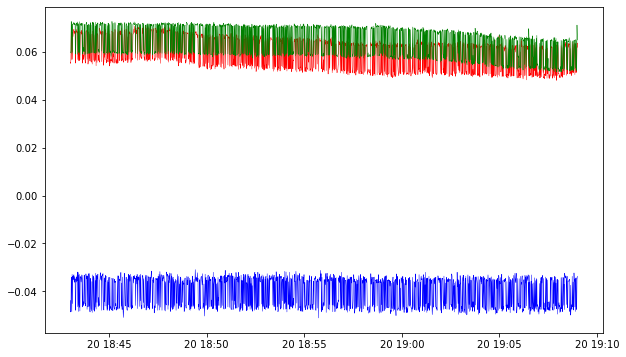

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(S.loc[ts:ts+dt.timedelta(minutes=step), "ch1"][::5], lw=0.5, color="red")
ax.plot(S.loc[ts:ts+dt.timedelta(minutes=step), "ch2"][::5], lw=0.5, color="green")
ax.plot(S.loc[ts:ts+dt.timedelta(minutes=step), "ch3"][::5], lw=0.5, color="blue")
plt.show()

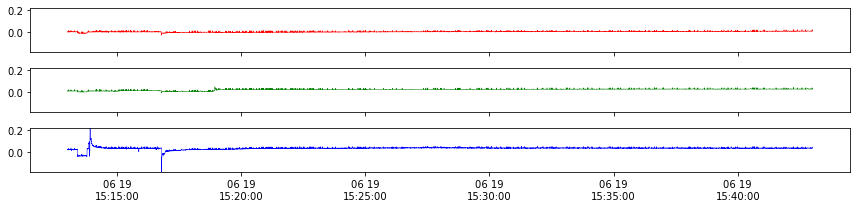

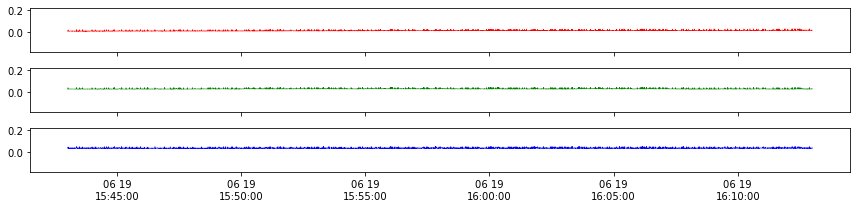

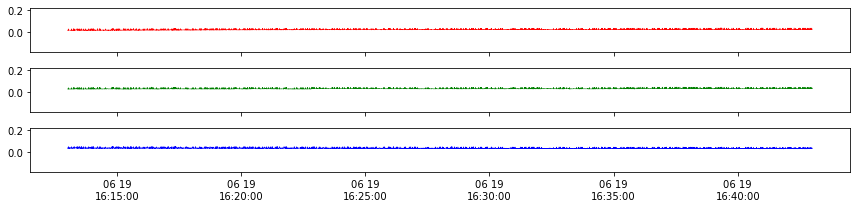

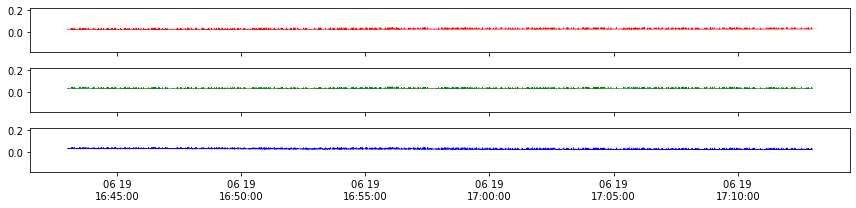

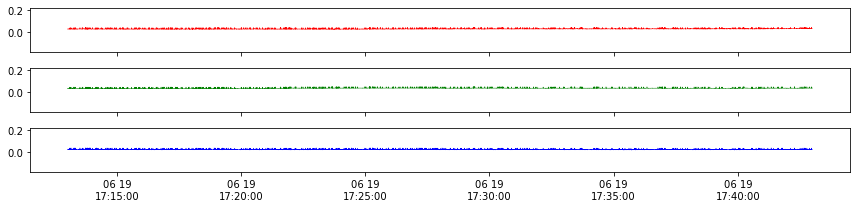

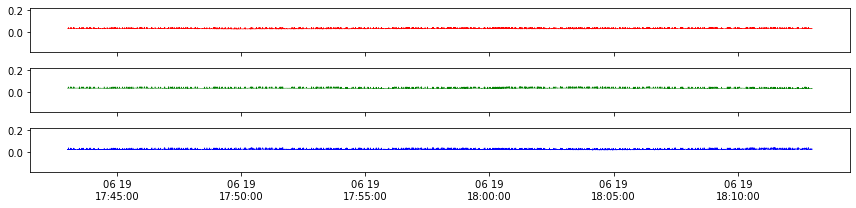

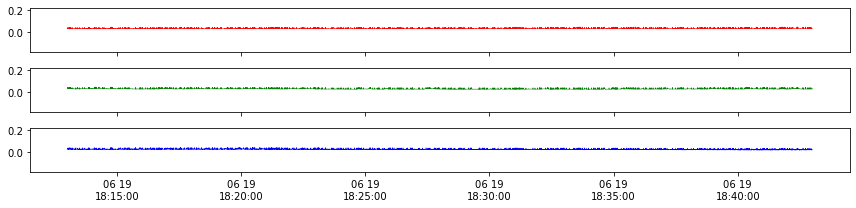

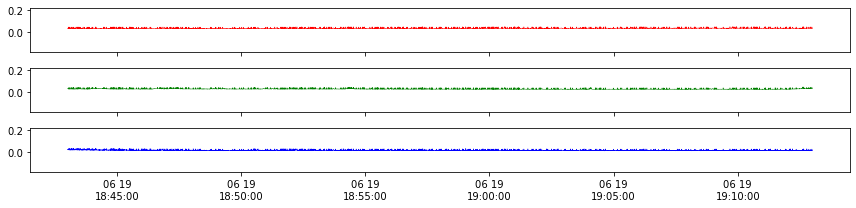

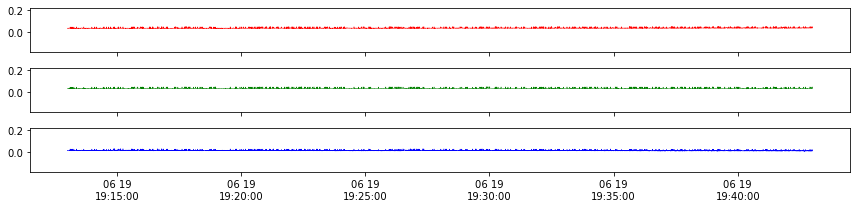

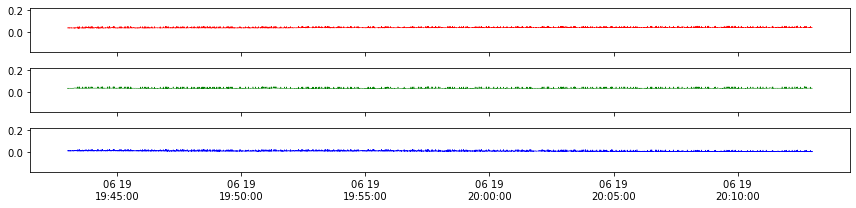

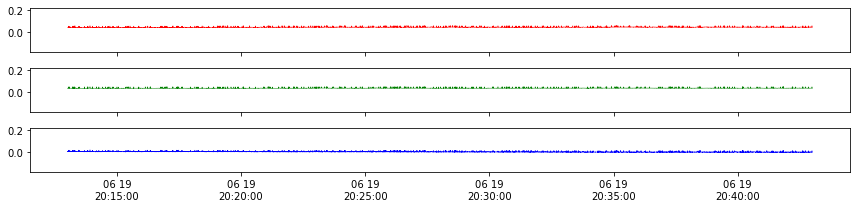

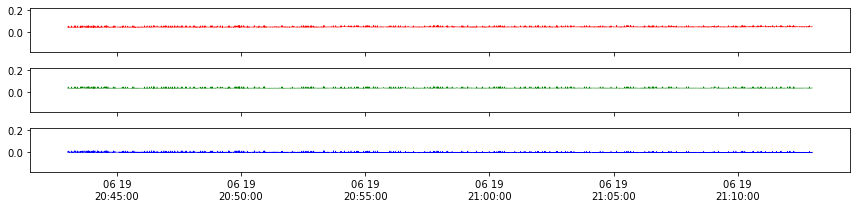

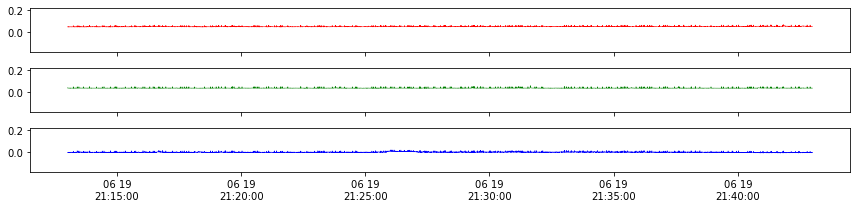

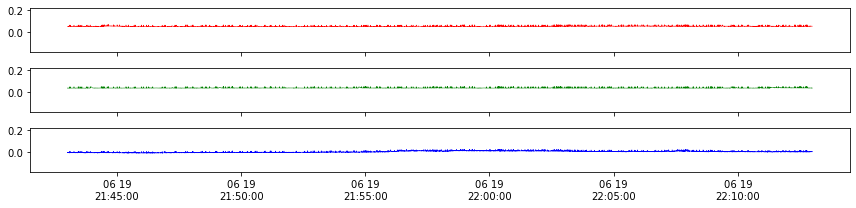

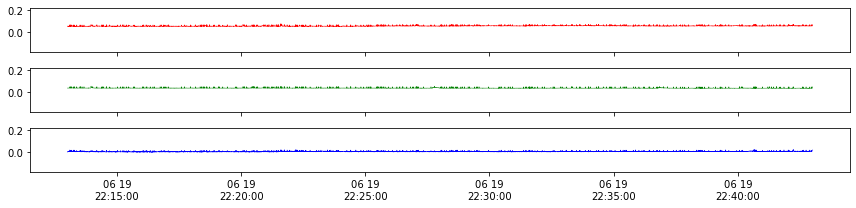

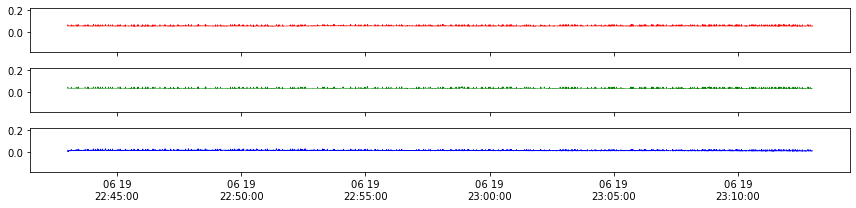

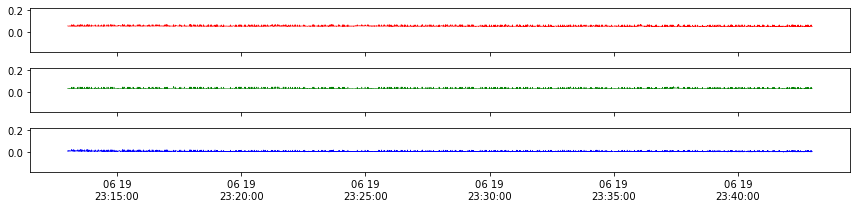

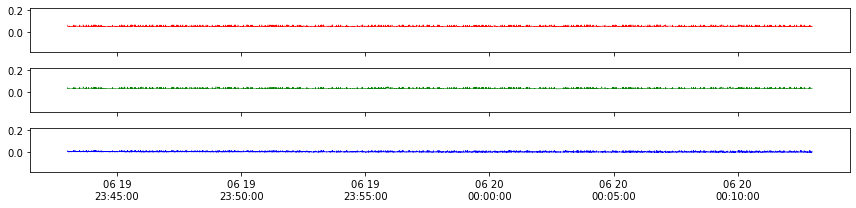

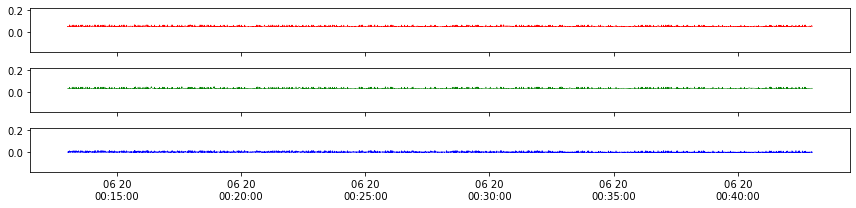

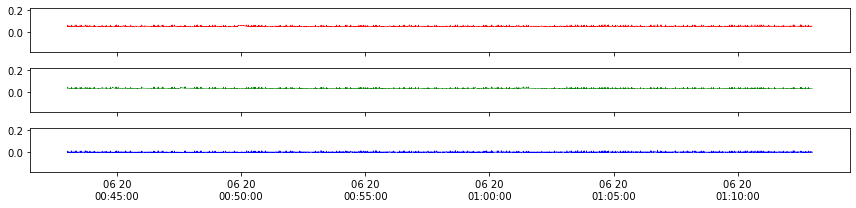

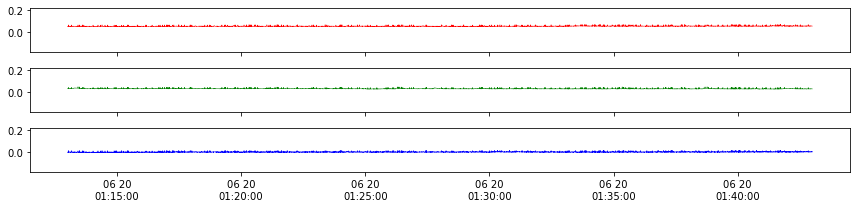

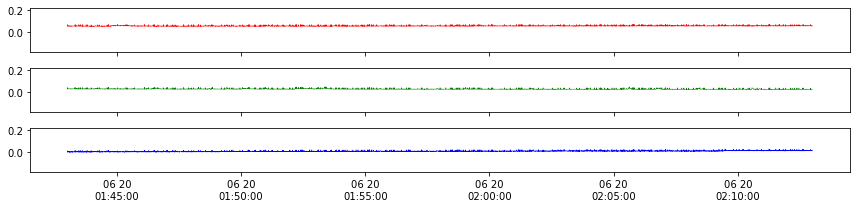

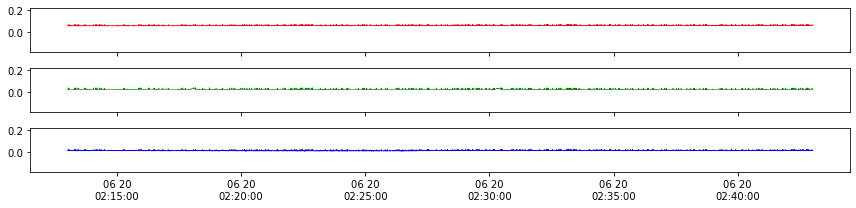

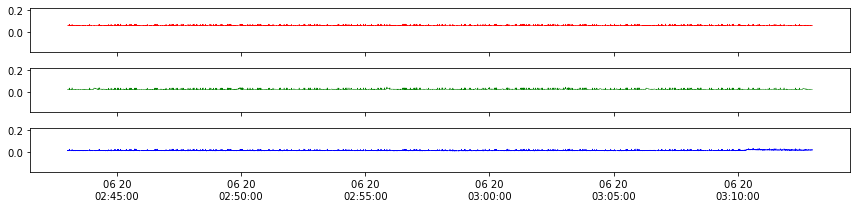

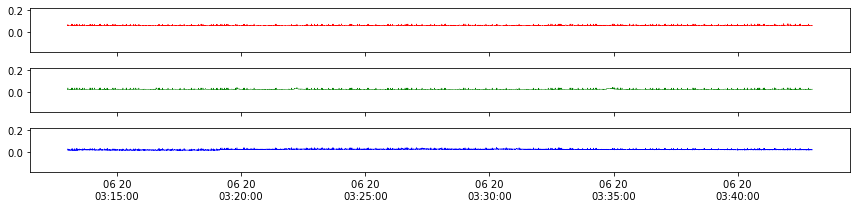

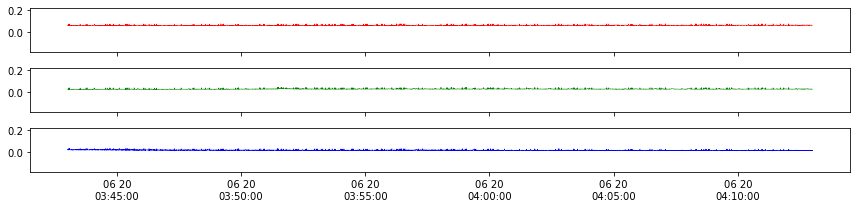

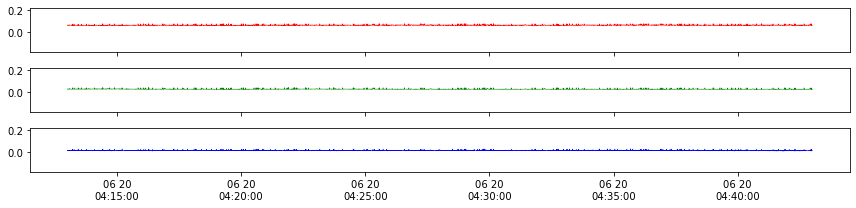

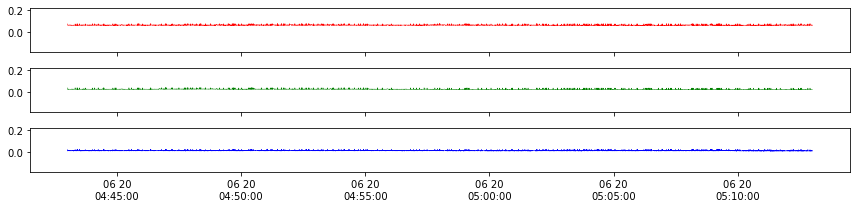

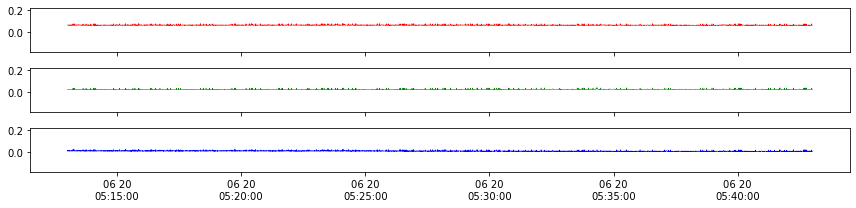

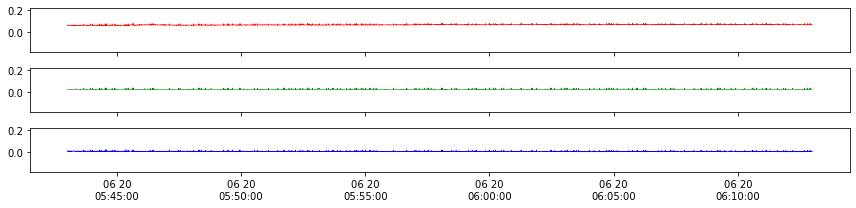

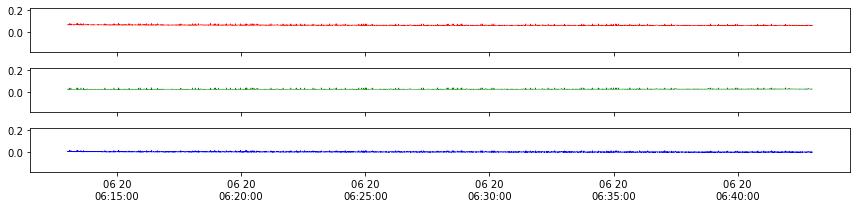

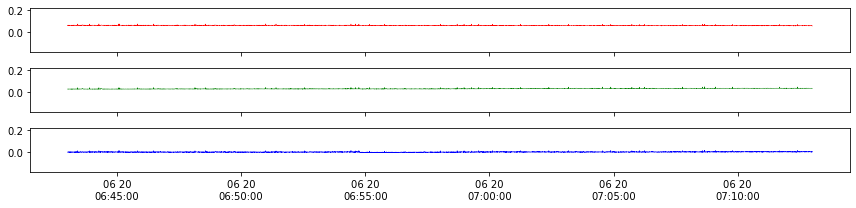

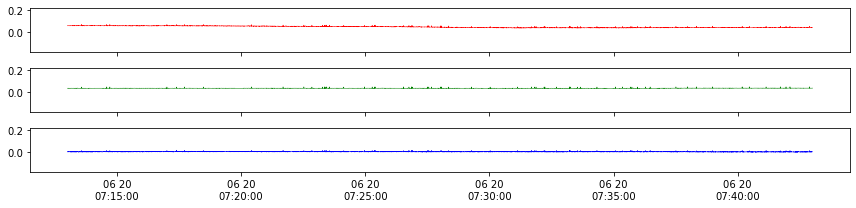

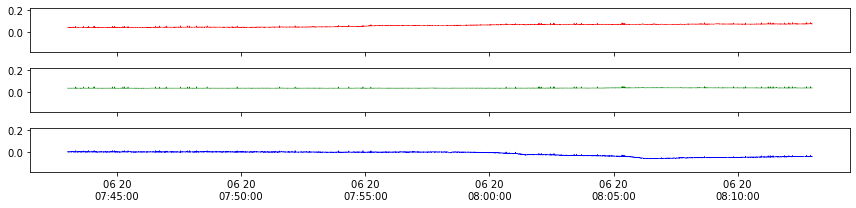

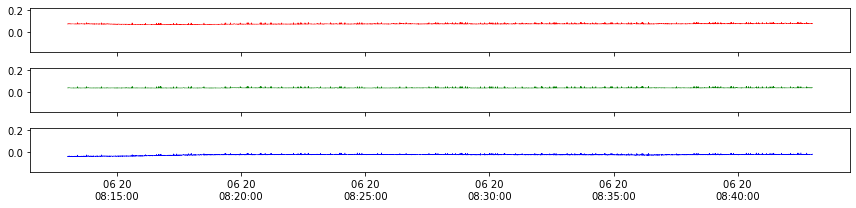

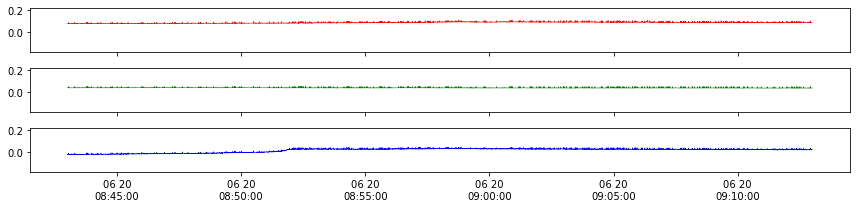

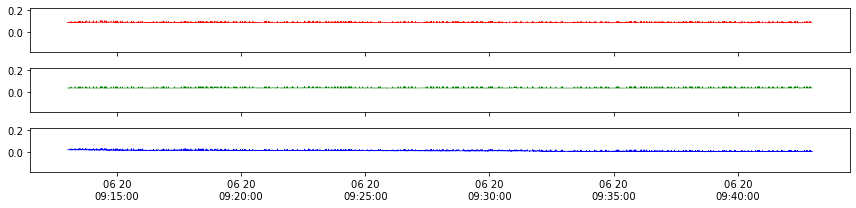

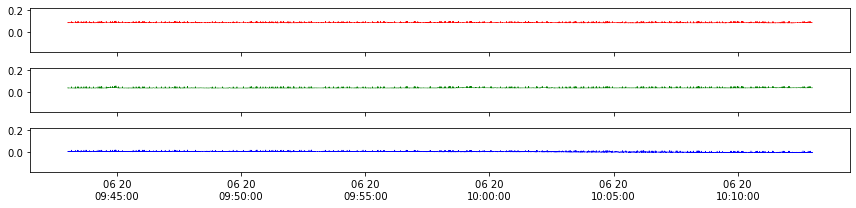

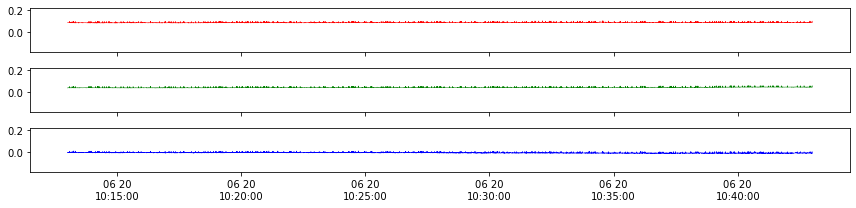

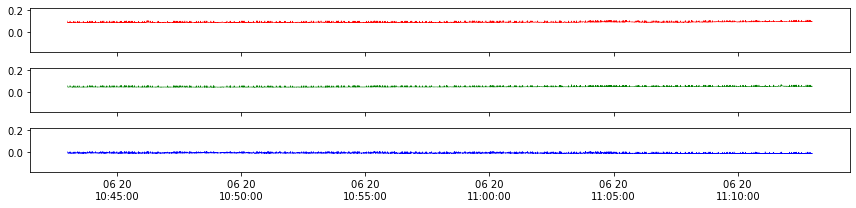

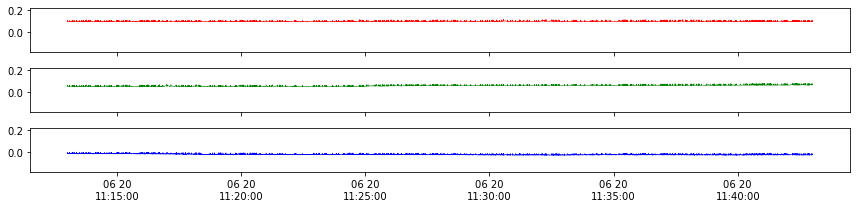

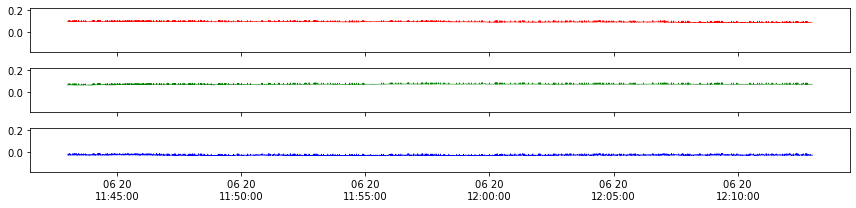

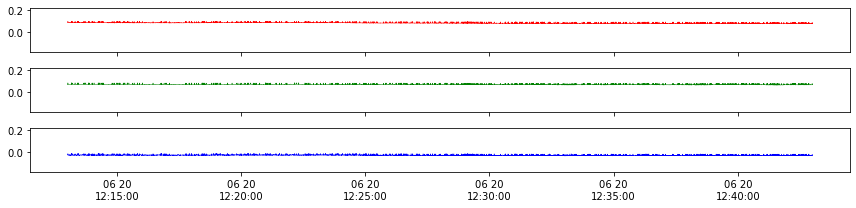

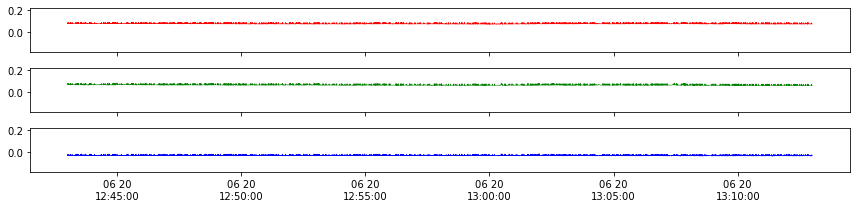

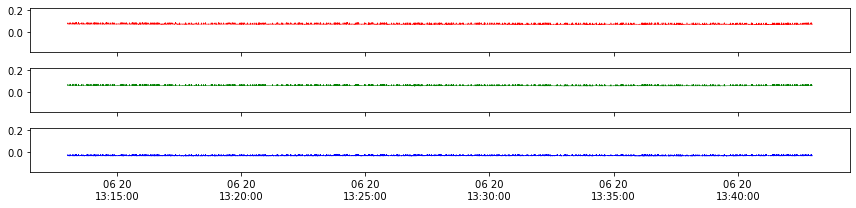

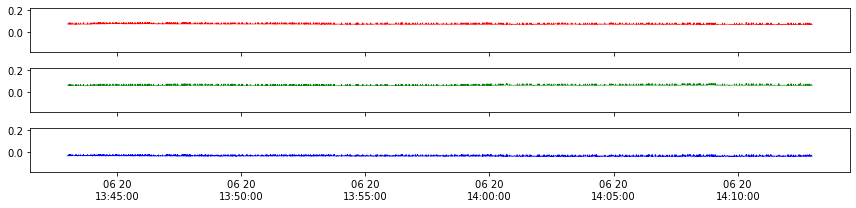

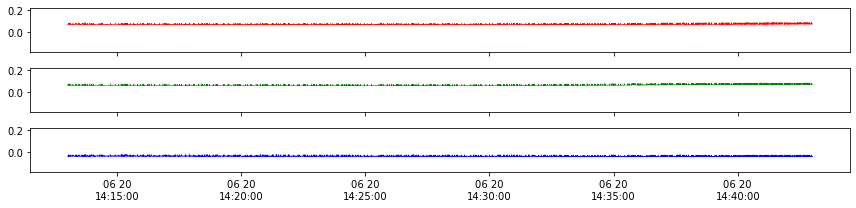

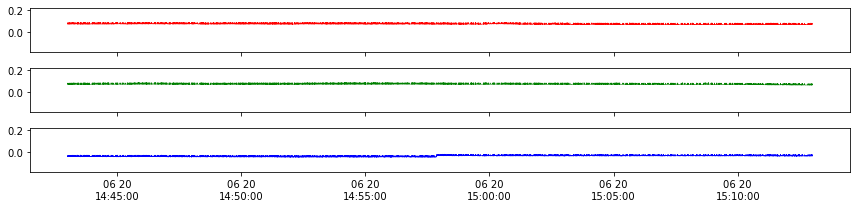

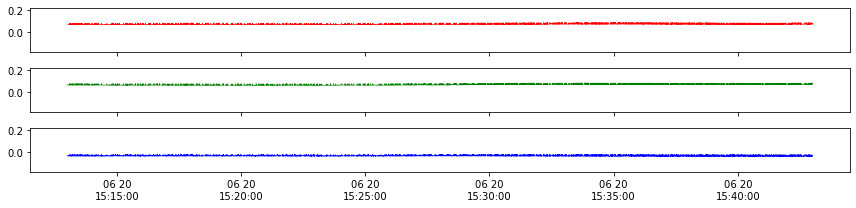

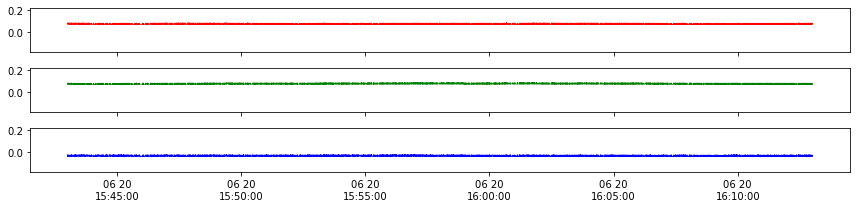

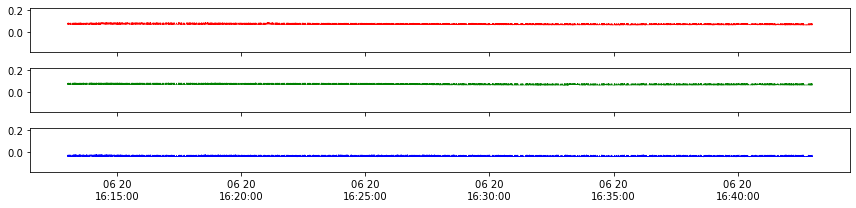

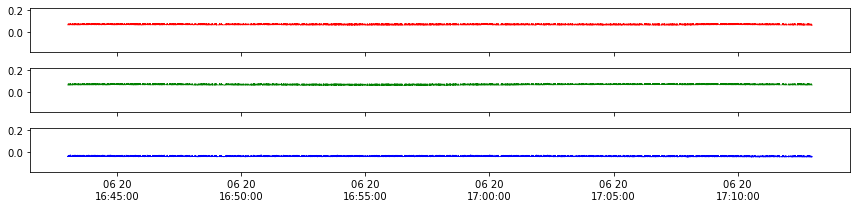

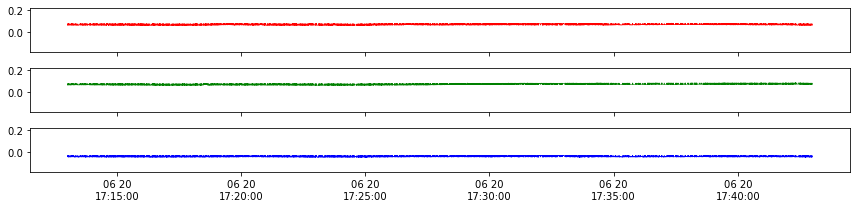

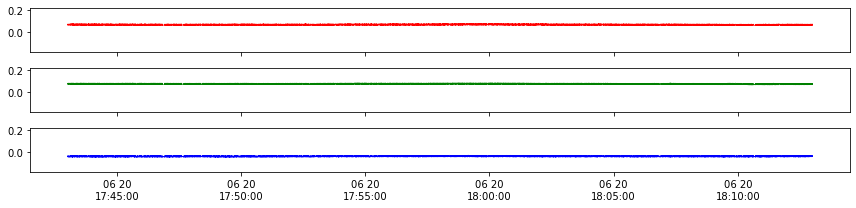

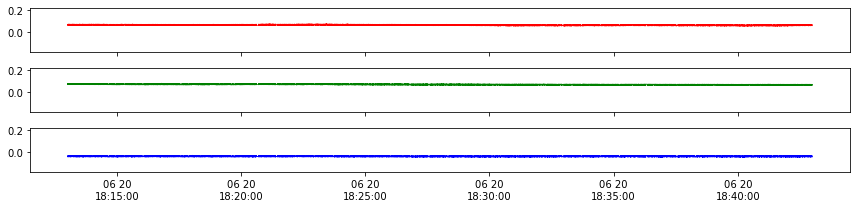

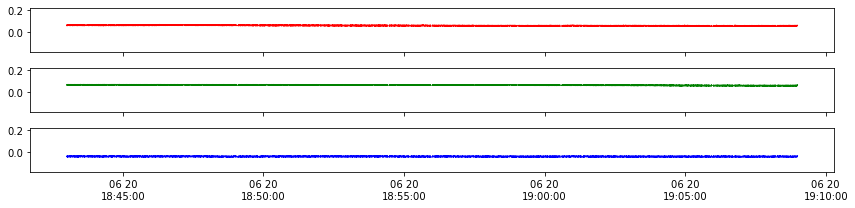

In [18]:
step = 30 # mins
time_steps = np.arange(S.index.min(), S.index.max(), dt.timedelta(minutes=step))


for i, time_step in enumerate(time_steps):
    
    ts = pd.to_datetime(time_step)
    y_max = S.max()[:3].max()
#     y_max = 0.02
#     y_max = 0.1
    y_min = S.min()[:3].min()
#     y_min = 0.0
    
    fig, ax = plt.subplots(3, 1, figsize=(12, 3), sharex=True)
    ax[0].plot(S.loc[ts:ts+dt.timedelta(minutes=step), "ch1"], lw=0.5, color="red")
    ax[1].plot(S.loc[ts:ts+dt.timedelta(minutes=step), "ch2"], lw=0.5, color="green")
    ax[2].plot(S.loc[ts:ts+dt.timedelta(minutes=step), "ch3"], lw=0.5, color="blue")
    
    for a in ax:
        a.set_ylim([y_min, y_max])
        a.xaxis.set_major_formatter(mdates.DateFormatter("%m %d\n%H:%M:%S"))
        
    plt.tight_layout()
    plt.show()
    plt.close()

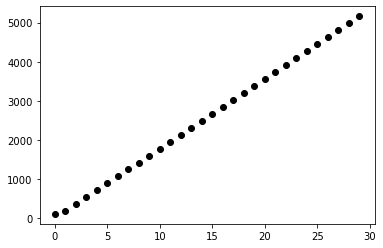

array([8191, 8100, 7864, 7627, 7390, 7154, 6917, 6681, 6444, 6207, 5971,
       5734, 5498, 5261, 5024, 4788, 4551, 4315, 4078, 3841, 3605, 3368,
       3132, 2895, 2659, 2422, 2185, 1949, 1712, 1476])

In [8]:
center_MIDI = 80
f_lower = pretty_midi.note_number_to_hz(center_MIDI-35)
f_upper = pretty_midi.note_number_to_hz(center_MIDI+35)

golden_fs = np.array([gold(f_lower, i) for i in np.arange(0, 30)])
golden_fs = golden_fs[golden_fs < f_upper]

frequency_to_bend = interp1d([f_lower, f_upper],[8191, 0])

plt.plot(golden_fs, ls="", marker="o", color="k")
plt.show()

golden_bends = frequency_to_bend(golden_fs).astype('int')

golden_bends

## How many voices at one time are possible?
The goal is to *do all the pitching with the wheel*, but the wheel affects every MIDI note on a given instrument. That means we must put each voice on a separate instrument. <br>

Thus our constraint: **the *maximum number of MIDI instruments:* 127.** <br>
Bitwig has unlimited MIDI tracks, it would appear. A (soft) constraint would be to keep life simpler for sampling/adjusting purposes and keep the number of tracks below 16.<br>

<br><br>

## Generate THREADS in time

In [ ]:
def THREADS(anchor_points, pitch_center, percussion_length=1.5):
    
    '''
    Generate THREADS: smooth harmonically-related glissandos that merge together.
    
    '''
    
    f_lower = pretty_midi.note_number_to_hz(pitch_center-24)
    f_upper = pretty_midi.note_number_to_hz(pitch_center+24)

    raag = np.array([gold(f_lower, i) for i in np.arange(0, 30)])
    raag = raag[raag < f_upper]
    
#     # pitch bending relies on all frequencies being within the range of the raag
#     anchor_points = anchor_points.loc[(anchor_points.Frequency > raag[0])&
#                                       (anchor_points.Frequency < raag[1]), :]
    
#     anchor_points = anchor_points.reset_index(drop=True)
    
    # initialize an empty DataFrame
    score = pd.DataFrame([])
    
    # new version: anchor points are starting points
    score["OriginalBegins"] = anchor_points["Time"]
    score["PitchBegins"] = anchor_points["Frequency"]

    # let's start with when these pitches will finish
    latest_finish = anchor_points["Time"].iloc[-1]
    
    def choose_end(t):
        return np.random.uniform(t+(0.1*latest_finish), 
                                 np.minimum(t+(0.4*latest_finish), latest_finish))

    # add a beginning time
    score["OriginalEnds"] = score["OriginalBegins"].apply(choose_end)

    # compute a Bezier curve for each
    score["OriginalCurves"] = [make_curve(row, center_MIDI=pitch_center) for _, row in score.iterrows()]

    # generate a random color for each curve
    score["Colors"] = [c for c in np.random.rand(score.shape[0], 3)]

    # create an intersection dictionary
    intersection_points = pd.DataFrame([])

    # ====== draw the curves (this is the slow part) ==============

    fig, ax = plt.subplots(1, 1, figsize=(15, 8))

    # a list to store the terminations
    terminated_thread = []

    for j, row in score.iterrows():

        # plots will be drawn with the curve's color
        curve_color = row["Colors"]

        # plot the bezier curve
        row["OriginalCurves"].plot(num_pts=256, ax=ax, color=curve_color)

        # plot the original starting points
        ax.plot(row["OriginalBegins"], row["PitchBegins"], ls="", 
                marker="o", color=curve_color, label="Note "+str(j))

        # now draw the intersections
        for i in score.index.to_series():

            A = row["OriginalCurves"]
            B = score.iloc[i]["OriginalCurves"]

            if(i != j):

                intersections = A.intersect(B)
                s_vals = np.asfortranarray(intersections[0, :])
                points = A.evaluate_multi(s_vals)

                # which of these curves started at a higher frequency?
                if(row["PitchBegins"] < score.iloc[i]["PitchBegins"]):
                    intersect_color = curve_color
                    terminate = i

                else:
                    intersect_color = score.iloc[i]["Colors"]
                    terminate = j

                ax.plot(points[0], points[1], ls="", marker="o", ms=6,
                        color="white", markeredgecolor=intersect_color, 
                        markeredgewidth=2, zorder=50)

                # add to the DataFrame of intersection points
                if(points.size == 2):

                    # these are combinations: there will eventually be two duplicate values for every match
                    pairing = [str(np.minimum(i, j))+"_"+str(np.maximum(i, j))]

                    # turn the matching point into a DataFrame and append
                    df = pd.DataFrame(points.T, 
                                      index=pairing, columns=["Time", "Frequency"])
                    intersection_points = intersection_points.append(df)

                    terminated_thread.append(terminate)


    ax.axhline(raag[0], lw=3, color="k", zorder=100)
    plt.axis([None, None, 0, None])
    plt.show()

    # add in the terminated threads
    intersection_points["Terminated"] = terminated_thread

    # drop the duplicate intersection points
    intersection_points = intersection_points[intersection_points.index.duplicated(keep='first')]
    
    # sort them (just in case)
    clean_intersect = intersection_points.sort_values("Time", ascending=True)
    
    # add an Series containing pandas Interval objects (for later)
    clean_intersect["TimeInterval"] = clean_intersect["Time"].apply(lambda t: pd.Interval(t, t+percussion_length))
    
    # remove "mirrored" intersections
    clean_intersect = clean_intersect.drop_duplicates("Terminated", keep='first')
    

    fig, ax = plt.subplots(1, 1, figsize=(15, 8))

    # now draw the intersections
    for i, b in enumerate(score.index.to_series().isin(clean_intersect["Terminated"])):

        if(b):

            # reload the nodes of the curve
            new_nodes = score.iloc[i]["OriginalCurves"].nodes

            # the intersection point is the new terminus
            final_node = clean_intersect.loc[clean_intersect["Terminated"] == i, ["Time", "Frequency"]].values

            # mask nodes that occur after the new terminus
            find_new_last = new_nodes[0] < final_node[0][0]

            # we'd like to replace the first false value with the intersection
            new_last_node = np.argmax(find_new_last == False)

            # replace the last node with the correct value
            new_nodes[:, new_last_node] = final_node

            # then overwrite the array
            new_nodes = new_nodes[:, :new_last_node+1]

            newCurve = bezier.Curve.from_nodes(np.asfortranarray(new_nodes))
            score.loc[i, "FinalCurves"] = newCurve

            # evaluate the curve to note the final extent properties of the note
            points = newCurve.evaluate_multi(np.linspace(0, 1, 1000))
            score.loc[i, "FinalBegins"] = points[0][0]
            score.loc[i, "FinalEnds"] = points[0][-1]
            score.loc[i, "PitchEnds"] = points[1][-1]

            # save a `pandas` Interval object, too
            score.loc[i, "TimeInterval"] = pd.Interval(points[0][0], points[0][-1])

            #newCurve.plot(num_pts=500, ax=ax, color=score.iloc[i]["Colors"])
            newCurve.plot(num_pts=500, ax=ax, color="k")

        else:

            new_nodes = score.iloc[i]["OriginalCurves"].nodes
            newCurve = bezier.Curve.from_nodes(np.asfortranarray(new_nodes))

            # evaluate the curve to note the final extent properties of the note
            points = newCurve.evaluate_multi(np.linspace(0, 1, 1000))
            score.loc[i, "FinalBegins"] = points[0][0]
            score.loc[i, "FinalEnds"] = points[0][-1]
            score.loc[i, "PitchEnds"] = points[1][-1]

            # save a `pandas` Interval object, too
            score.loc[i, "TimeInterval"] = pd.Interval(points[0][0], points[0][-1])

            score.loc[i, "FinalCurves"] = newCurve
            #newCurve.plot(num_pts=500, ax=ax, color=score.iloc[i]["Colors"])
            newCurve.plot(num_pts=500, ax=ax, color="k")

    plt.show()
    
    return score, clean_intersect   


## Use an audio file to initialize the THREADS

In [ ]:
# path = "/home/dax/Documents/ALBUM/SAMPLES/imaginary sounds/spores2_normalized.wav"
path = "/home/dax/Documents/ALBUM/NEW DA HEAP/fiddle/m fid.wav"
g = generate_start_times(path, step_size_ms=900)

print(len(g))

# find fundemental frequency that occurs most often
# for some music, this will be a good estimate of the "center"
center = 5*(g["Frequency"]//5).mode().values[0]

# convert the detected fundemental to a new center as a MIDI note
center_MIDI = pretty_midi.hz_to_note_number(center)
center_MIDI = int(np.rint(center_MIDI))

print("pitch center: MIDI", center_MIDI)

fullscore, intersections = THREADS(g, center_MIDI, percussion_length=1.5)
fullscore

### Pitch bending works on a per-instrument basis: find the minimum number of MIDI instruments required
Then, assign each note to an instrument

### If intersections are being used for a drum machine, assign them to notes
There's probably a more interesting way to perform assignment, but for now this will keep life easy

In [ ]:
# find the MIDI instrument assignments for the given score
fullscore["MIDIInstrument"] = min_groupings(fullscore)

# find the MIDI note assignments for a Bitwig drum machine given intersection times
intersections["MIDINote"] = min_groupings(intersections).tolist()

# First MIDI file: Sampler control

In [ ]:
# create a PrettyMIDI object.
pm = pretty_midi.PrettyMIDI(initial_tempo=200, resolution=500)

scaler = 1

frequency_to_bend = pitchbend_map(center_MIDI, ascending=True)

# group the score by MIDI instrument
for num, Inst in fullscore.groupby("MIDIInstrument"):
    
    # add a single instrument
    threads = pretty_midi.Instrument(program=num+1, is_drum=False, name='Inst'+str(num))
    pm.instruments.append(threads)
    
    for n, note in Inst.iterrows():
        
        # the note is easy - it's a constant velocity, constant pitch: only time bounds are needed
        threads.notes.append(pretty_midi.Note(110, center_MIDI, scaler*note["FinalBegins"], scaler*note["FinalEnds"]))
                             
        # to perform the pitch bend, first evaluate the Bezier curve                     
        points = note["FinalCurves"].evaluate_multi(np.linspace(0, 1, 500)).T
        
        # add a bend for every articulation point
        for point in points:
            
            bendtime = scaler*point[0]
            b = frequency_to_bend(point[1]).astype('int')
            
            # a useful diagnostic
            #print("instrument", num+1,", note",n,b, bendtime)
            
            # add the bend
            threads.pitch_bends.append(pretty_midi.PitchBend(int(b), bendtime))
                             

base = r"/home/dax/Documents/ALBUM/NEW DA HEAP/2020 10 16 threads"
savePath = base + os.sep + "THREADS_fiddle.mid"

# it's this easy to write out the file
pm.write(savePath)

In [ ]:
intersections

# Second MIDI file: Intersection-based Percussion
By comparison this one is very simple

In [ ]:
# create a PrettyMIDI object.
pm = pretty_midi.PrettyMIDI(initial_tempo=200, resolution=500)

# initialize the instrument: only one is needed for this file
drums = pretty_midi.Instrument(program=90, is_drum=False, name='Percussion')
pm.instruments.append(drums)

# map intersection frequency onto MIDI velocity (lower = louder)
f_to_vel = interp1d([intersections["Frequency"].min(), intersections["Frequency"].max()],
                    [50, 127])

for pitch, MIDInote in intersections.groupby("MIDINote"):
    
    for meta, note in MIDInote.iterrows():
        
        # map frequency to velocity
        vel = int(f_to_vel(note["Frequency"]))
        
        # the start/end times of the interval
        inter = note["TimeInterval"]
        drums.notes.append(pretty_midi.Note(vel, int(center_MIDI+pitch), inter.left, inter.right))
             
        
base = r"/home/dax/Documents/ALBUM/NEW DA HEAP/2020 10 16 threads"
savePath = base + os.sep + "THREADS_fiddle_percussion.mid"

# it's this easy to write out the file
pm.write(savePath)

### A very simple adjustment to match the length of the original audio file to the length of the Bitwig audio

In [ ]:
bitwig_tempo = 365.00
current = 60+4.438
should_be = 60+57.774

bitwig_tempo*(current/should_be)